In [1]:
import tensorflow as tf

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import indl
from pathlib import Path
import sys
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from scipy import signal
from scipy import stats
from sklearn.model_selection import train_test_split
from indl.fileio import from_neuropype_h5
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import FactorAnalysis
from itertools import cycle

import os

if Path.cwd().stem == 'Analysis':
    os.chdir(Path.cwd().parent.parent)

from misc.misc import sess_infos, load_macaque_pfc, dec_from_enc    
    
data_path = Path.cwd() / 'StudyLocationRule'/ 'Data' / 'Preprocessed'
if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")
    

load_kwargs = {
    'valid_outcomes': (0, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
load_kwargs_ul = {
    'valid_outcomes': (0, 9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, -1),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

load_kwargs_error = {
    'valid_outcomes': (9,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

load_kwargs_all = {
    'valid_outcomes': (0,9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

model_kwargs = dict(
    filt=8,
    kernLength=20,
    ds_rate=5,
    n_rnn=32,
    n_rnn2=0,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=32
)
model_kwargs1 = dict(
    filt=16,
    kernLength=30,
    ds_rate=5,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)
model_kwargs2 = dict(
    filt=32,
    kernLength=30,
    ds_rate=5,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)

N_SPLITS = 10
BATCH_SIZE = 16
EPOCHS = 150
EPOCHS2 = 100
LABEL_SMOOTHING = 0.2

from indl.model import parts
from indl.model.helper import check_inputs
from indl.regularizers import KernelLengthRegularizer

def make_model(
    _input,
    num_classes,
    filt=32,
    kernLength=16,
    n_rnn=32,
    n_rnn2=0,
    dropoutRate=0.1,
    activation='tanh',
    l1_reg=0.010, l2_reg=0.010,
    norm_rate=0.25,
    latent_dim=32,
    return_model=True
):
    
    inputs = tf.keras.layers.Input(shape=_input.shape[1:])
    
#     if _input.shape[2] < 10:
#         kernLength = 4
#         filt = 4
#         ds_rate = 4
#     elif _input.shape[2] < 20:
#         kernLength = 8
#         ds_rate = 8
#     elif _input.shape[2] < 30:
#         kernLength = 16
    
#     input_shape = list(_input.shape)
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    # input_shape[2] = -1  # Comment out during debug
    # _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

    # RNN
#     if len(input_shape) < 4:
#         input_shape = input_shape + [1]
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
#     _y = tf.keras.layers.Reshape(input_shape[1:])(inputs)
    _y = tf.keras.layers.Conv1D(filt, kernLength, strides=1, padding='valid',
                                data_format='channels_last', dilation_rate=1, groups=1,
                                activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                bias_initializer='zeros', kernel_regularizer=None,
                                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
                                bias_constraint=None)(inputs)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    _y = tf.keras.layers.LSTM(n_rnn,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=n_rnn2 > 0,
                              stateful=False,
                              name='rnn1')(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    
    if n_rnn2 > 0:
        
        _y = tf.keras.layers.LSTM(n_rnn2,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False,
                              stateful=False,
                              name='rnn2')(_y)
        _y = tf.keras.layers.Activation(activation)(_y)
        _y = tf.keras.layers.BatchNormalization()(_y)
        _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    # Dense
    _y = tf.keras.layers.Dense(latent_dim, activation=activation)(_y)
#     _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(_y)
#     outputs = parts.Classify(_y, n_classes=num_classes, norm_rate=norm_rate)
    

    if return_model is False:
        return outputs
    else:
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)


def kfold_pred(sess_id,X_rates,Y_class,name, verbose=1):
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []
    per_fold_eval = []
    per_fold_true = []

    for trn, vld in splitter.split(X_rates, Y_class):
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        _y = tf.keras.utils.to_categorical(Y_class, num_classes=np.max(Y_class)+1)
        
        ds_train = tf.data.Dataset.from_tensor_slices((X_rates[trn], _y[trn]))
        ds_valid = tf.data.Dataset.from_tensor_slices((X_rates[vld], _y[vld]))

        # cast data types to GPU-friendly types.
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

        # TODO: augmentations (random slicing?)

        ds_train = ds_train.shuffle(len(trn) + 1)
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
        ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

        tf.keras.backend.clear_session()
        
        randseed = 12345
        random.seed(randseed)
        np.random.seed(randseed)
        tf.random.set_seed(randseed)
        
        model = make_model(X_rates, _y.shape[-1])
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        
        best_model_path = f'{name}_{sess_id}_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                monitor='val_accuracy',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        model = tf.keras.models.load_model(best_model_path)
        per_fold_eval.append(model(X_rates[vld]).numpy())
        per_fold_true.append(Y_class[vld])
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
                
    pred_y = np.concatenate([np.argmax(_, axis=1) for _ in per_fold_eval])
    true_y = np.concatenate(per_fold_true).flatten()
    accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"\n\nSession {sess_id} overall accuracy with CNN/LSTM Model: {accuracy}%")
    
    return history, accuracy, pred_y, true_y

def load_session(s_idx, t_start=-np.inf, t_end=np.inf, monk_perf=False):
    sess_info = sess_infos[s_idx]
    sess_id = sess_info['exp_code']
    if sess_id == "sra3_1_m_074_00+01":
        sess_id = sess_id.replace("+", "") + "_segmented.h5"
    else:
        sess_id = sess_id.replace("+", "") + "_v1_segmented.h5"
    segmented_path = data_path / sess_id
    segmented_data = from_neuropype_h5(segmented_path)
    for i in range(len(segmented_data)):
        if segmented_data[i][0] == "spikerates":
            chunk = i
    outcome = np.array(segmented_data[chunk][1]['axes'][0]['data']['OutcomeCode'])
    flag = np.argwhere(outcome>-1).flatten()
    outcome = outcome[flag]
    Y = np.array(segmented_data[chunk][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
    Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
    X_rates = segmented_data[chunk][1]['data'][flag]
    X_rates = np.nan_to_num(X_rates)
#     X_rates = np.transpose(X_rates, (0, 2, 1))
    block = np.array(segmented_data[chunk][1]['axes'][0]['data']['Block']).flatten()[flag]
    b=np.diff(block, axis=0)
    border=np.array(np.where(b>0)).flatten()
    to_keep = [0]
    for i in range(len(border) - 1):
        if (border[i + 1] - border[i]) > 30 and (len(outcome)-border[i+1]) > 30:
            to_keep.append(i + 1)
    border = border[to_keep]
    color = np.array(segmented_data[chunk][1]['axes'][0]['data']['CueColour']).flatten()[flag]
    target = np.array(segmented_data[chunk][1]['axes'][0]['data']['TargetRule']).flatten()[flag]
    classes = np.array(segmented_data[chunk][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
    times = np.array(segmented_data[chunk][1]['axes'][1]['times']).flatten()
    idx_e = np.argwhere(times < t_end).flatten()[-1]
    idx_s = np.argwhere(times > t_start).flatten()[0]
    rule = np.zeros(np.size(X_rates,0))
    for i in range(len(rule)):
        if (target[i]=='UU'):
            if (color[i] == 'r'):
                rule[i]=0
            elif(color[i] == 'g'):
                rule[i]=1
            else:
                rule[i]=2
        elif (target[i]=='UR'):
            if (color[i] == 'r'):
                rule[i]=3
            elif(color[i] == 'g'):
                rule[i]=4
            else:
                rule[i]=5
        elif (target[i]=='RR'):
            if (color[i] == 'r'):
                rule[i]=6
            elif(color[i] == 'g'):
                rule[i]=7
            else:
                rule[i]=8
        elif (target[i]=='DR'):
            if (color[i] == 'r'):
                rule[i]=9
            elif(color[i] == 'g'):
                rule[i]=10
            else:
                rule[i]=11
        elif (target[i]=='DD'):
            if (color[i] == 'r'):
                rule[i]=12
            elif(color[i] == 'g'):
                rule[i]=13
            else:
                rule[i]=14
        elif (target[i]=='DL'):
            if (color[i] == 'r'):
                rule[i]=15
            elif(color[i] == 'g'):
                rule[i]=16
            else:
                rule[i]=17
        elif (target[i]=='LL'):
            if (color[i] == 'r'):
                rule[i]=18
            elif(color[i] == 'g'):
                rule[i]=19
            else:
                rule[i]=20
        elif (target[i]=='UL'):
            if (color[i] == 'r'):
                rule[i]=21
            elif(color[i] == 'g'):
                rule[i]=22
            else:
                rule[i]=23
    rule = rule.astype(int)
#     tmp = rule
#     _yu = np.unique(rule)
#     for i in range(len(tmp)):
#         rule[i] = np.where(_yu == tmp[i])[0][0]
    
    m_performance = np.zeros(len(outcome))
    cor = 0
    b=0
    tot = 25
    for i in range(tot):
        if outcome[i]==0:
            cor += 1

    m_performance[:tot] = 100 * (cor / tot)
    # for i in range(tot, len(outcome)):
    i = tot
    while i<len(outcome):
        if i == border[b]:
            cor = 0
            for j in range(tot):
                if outcome[i+j]==0:
                    cor += 1
            m_performance[i:i+tot] = 100 * (cor / tot)
            i += tot
            b = (b+1)%len(border)
        elif outcome[i] == outcome[i-tot]:
            m_performance[i] = m_performance[i-1]
            i += 1
        elif outcome[i]==0:
            cor += 1
            m_performance[i] = 100 * (cor / tot)
            i += 1
        else:
            cor -= 1
            m_performance[i] = 100 * (cor / tot)
            i +=1

    for i in range(len(m_performance)):
        if m_performance[i]<0:
            m_performance[i] = 0
    learned = np.argwhere(m_performance>75).flatten()
    unlearned = np.argwhere(m_performance<65).flatten()
    cor = np.array(np.where(outcome==0)).flatten()
    icor = np.array(np.where(outcome==9)).flatten()
    ic_l = []
    c_l = []
    ic_ul = []
    for c in cor:
        if c in learned:
            c_l.append(c)
    for ic in icor:
        if ic in unlearned:
            ic_ul.append(ic)
        else:
            ic_l.append(ic)
    X_rates = X_rates[:, idx_s:idx_e+1, :]
    
    if monk_perf:
        return X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l, border, m_performance
    else:
        return X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l, border

Data directory found. Skipping download.


# Rule vs. Target vs. Saccade Channel Contribution

In [4]:
sess_infos.append ({'name': 'Marty',
                 'bank': 'A',
                 'name_short': 'm',
                 'date': '',
                 'exp_code': 'sra3_1_m_074_00+01',
                 'nsx': ''})

### Learned

In [5]:
N_SPLITS = 10
all_r_accs = []
all_s_accs = []
all_ch_r_accs = []
all_ch_s_accs = []
for s_idx in np.arange(0,9):
    X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l, border = load_session(s_idx)
    sess_info = sess_infos[s_idx]
    sess_id = sess_info['exp_code']
    for ii in range(100):
        np.random.shuffle(c_l)
    print(f'\n\nSession {sess_id}')
    X = X_rates[c_l]
    x = np.reshape(X, [X.shape[0], -1], order='F')
    R = rule[c_l]
    S = Y[c_l]
    kf = KFold(n_splits=N_SPLITS)
    scores_r = []
    scores_s = []
    for train_index, test_index in kf.split(X):
        x_tr, x_ts = x[train_index], x[test_index]
        r_tr, r_ts = R[train_index], R[test_index]
        s_tr, s_ts = S[train_index], S[test_index]
        clf_r = SVC(verbose=False).fit(x_tr, r_tr)
        clf_s = SVC(verbose=False).fit(x_tr, s_tr)
        acc_r = clf_r.score(x_ts, r_ts)
        acc_s = clf_s.score(x_ts, s_ts)
        scores_r.append(acc_r)
        scores_s.append(acc_s)
    rule_acc = np.mean(np.array(scores_r))
    sac_acc = np.mean(np.array(scores_s))
    all_r_accs.append(rule_acc)
    all_s_accs.append(sac_acc)
    print(f"Rule: {rule_acc}, Saccade: {sac_acc}")
    ch_r_accs = []
    ch_s_accs = []
    for ch in range(X.shape[-1]):
        x = np.squeeze(X[:,:,ch])
        kf = KFold(n_splits=N_SPLITS)
        scores_r = []
        scores_s = []
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = x[train_index], x[test_index]
            r_tr, r_ts = R[train_index], R[test_index]
            s_tr, s_ts = S[train_index], S[test_index]
            clf_r = SVC(verbose=False).fit(x_tr, r_tr)
            clf_s = SVC(verbose=False).fit(x_tr, s_tr)
            acc_r = clf_r.score(x_ts, r_ts)
            acc_s = clf_s.score(x_ts, s_ts)
            scores_r.append(acc_r)
            scores_s.append(acc_s)
        ch_r_accs.append(np.mean(np.array(scores_r)))
        ch_s_accs.append(np.mean(np.array(scores_s)))
        print(f"Channel: {ch+1}, Rule: {np.mean(np.array(scores_r))}, Saccade: {np.mean(np.array(scores_s))}")
    all_ch_r_accs.append(ch_r_accs)
    all_ch_s_accs.append(ch_s_accs)



Session sra3_2_j_037_00+03
Rule: 0.49640522875816995, Saccade: 0.5709150326797385
Channel: 1, Rule: 0.4669934640522876, Saccade: 0.4908496732026143
Channel: 2, Rule: 0.46274509803921565, Saccade: 0.4859477124183006
Channel: 3, Rule: 0.48464052287581694, Saccade: 0.4973856209150327
Channel: 4, Rule: 0.46241830065359474, Saccade: 0.47352941176470587
Channel: 5, Rule: 0.4568627450980392, Saccade: 0.5248366013071896
Channel: 6, Rule: 0.46307189542483657, Saccade: 0.5212418300653595
Channel: 7, Rule: 0.42320261437908496, Saccade: 0.4973856209150327
Channel: 8, Rule: 0.4905228758169935, Saccade: 0.5535947712418301
Channel: 9, Rule: 0.4571895424836601, Saccade: 0.4856209150326797
Channel: 10, Rule: 0.5349673202614379, Saccade: 0.6366013071895426
Channel: 11, Rule: 0.47222222222222215, Saccade: 0.5689542483660132
Channel: 12, Rule: 0.5147058823529412, Saccade: 0.5333333333333333
Channel: 13, Rule: 0.5467320261437908, Saccade: 0.6205882352941177
Channel: 14, Rule: 0.4908496732026144, Saccade:

Channel: 28, Rule: 0.376, Saccade: 0.4600000000000001
Channel: 29, Rule: 0.372, Saccade: 0.504
Channel: 30, Rule: 0.34800000000000003, Saccade: 0.38
Channel: 31, Rule: 0.256, Saccade: 0.288
Channel: 32, Rule: 0.38, Saccade: 0.4600000000000001


Session sra3_1_m_077_00+01
Rule: 0.5009523809523809, Saccade: 0.5295238095238096
Channel: 1, Rule: 0.28904761904761905, Saccade: 0.2752380952380952
Channel: 2, Rule: 0.2538095238095238, Saccade: 0.2538095238095238
Channel: 3, Rule: 0.23952380952380953, Saccade: 0.23952380952380953
Channel: 4, Rule: 0.3252380952380952, Saccade: 0.3038095238095238
Channel: 5, Rule: 0.26142857142857145, Saccade: 0.26857142857142857
Channel: 6, Rule: 0.2614285714285714, Saccade: 0.26857142857142857
Channel: 7, Rule: 0.33238095238095233, Saccade: 0.3252380952380952
Channel: 8, Rule: 0.24666666666666665, Saccade: 0.24666666666666665
Channel: 9, Rule: 0.24095238095238095, Saccade: 0.2404761904761905
Channel: 10, Rule: 0.2747619047619047, Saccade: 0.2676190476190476
Cha

Channel: 24, Rule: 0.2954545454545454, Saccade: 0.3372727272727273
Channel: 25, Rule: 0.3054545454545455, Saccade: 0.2772727272727272
Channel: 26, Rule: 0.29454545454545455, Saccade: 0.30636363636363634
Channel: 27, Rule: 0.33454545454545453, Saccade: 0.37636363636363634
Channel: 28, Rule: 0.34363636363636363, Saccade: 0.34545454545454546
Channel: 29, Rule: 0.32545454545454544, Saccade: 0.27
Channel: 30, Rule: 0.35454545454545455, Saccade: 0.45545454545454545
Channel: 31, Rule: 0.3145454545454545, Saccade: 0.3454545454545455
Channel: 32, Rule: 0.4454545454545455, Saccade: 0.48545454545454536


Session sra3_1_m_074_00+01
Rule: 0.7099971313826735, Saccade: 0.6897446930579461
Channel: 1, Rule: 0.16108720596672405, Saccade: 0.20401606425702806
Channel: 2, Rule: 0.1993402180149168, Saccade: 0.2434021801491681
Channel: 3, Rule: 0.3986517498565691, Saccade: 0.42735226620768785
Channel: 4, Rule: 0.2792168674698795, Saccade: 0.3127079747561675
Channel: 5, Rule: 0.15760183591508894, Saccade: 0.1

In [6]:
print(all_r_accs)
print(all_s_accs)
tmp = np.array(all_ch_r_accs)
m = np.mean(tmp, axis=1)
print(all_ch_r_accs)
print(all_ch_s_accs)

[0.49640522875816995, 0.8246031746031747, 0.7520634920634921, 0.736, 0.5009523809523809, 0.3647435897435897, 0.5833333333333333, 0.5027272727272727, 0.7099971313826735]
[0.5709150326797385, 0.966031746031746, 0.9804761904761905, 0.8240000000000001, 0.5295238095238096, 0.4256410256410256, 0.5833333333333333, 0.5036363636363637, 0.6897446930579461]
[[0.4669934640522876, 0.46274509803921565, 0.48464052287581694, 0.46241830065359474, 0.4568627450980392, 0.46307189542483657, 0.42320261437908496, 0.4905228758169935, 0.4571895424836601, 0.5349673202614379, 0.47222222222222215, 0.5147058823529412, 0.5467320261437908, 0.4908496732026144, 0.45588235294117646, 0.4797385620915032, 0.45588235294117646, 0.48006535947712414, 0.42418300653594765, 0.4568627450980392, 0.48986928104575156, 0.4738562091503267, 0.47352941176470587, 0.46241830065359474, 0.4973856209150327, 0.48464052287581694, 0.4790849673202614, 0.4673202614379085, 0.4856209150326797, 0.5343137254901961, 0.48496732026143785, 0.455882352941

In [5]:
for s_idx in np.arange(0,9):
    X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l, border = load_session(s_idx)
    sess_info = sess_infos[s_idx]
    sess_id = sess_info['exp_code']
    print(sess_id)

sra3_2_j_037_00+03
sra3_1_j_050_00+
sra3_1_j_051_00+
sra3_1_j_052_00+
sra3_1_m_077_00+01
sra3_1_m_081_00+01
sra3_1_m_082_00+01
sra3_1_m_083_00+01
sra3_1_m_074_00+01


In [7]:
sesss = [1, 2, 3, 5, 6, 7]
tmp = np.array(all_ch_r_accs)
m_r = np.sum(tmp, axis=1)
nrm = np.zeros_like(tmp)
for i in range(len(m_r)):
    nrm[i] = np.around(100*tmp[i]/m_r[i],1)
# nrm = list(nrm)
for i in range(len(sesss)):
    sess_info = sess_infos[sesss[i]]
    sess_id = sess_info['exp_code']
    print(sess_id)
    print(nrm[sesss[i]])
print("\n\n")
tmp = np.array(all_ch_s_accs)
m_s = np.sum(tmp, axis=1)
nrm = np.zeros_like(tmp)
for i in range(len(m_s)):
    nrm[i] = np.around(100*tmp[i]/m_s[i],1)
# nrm = list(nrm)
for i in range(len(sesss)):
    sess_info = sess_infos[sesss[i]]
    sess_id = sess_info['exp_code']
    print(sess_id)
    print(nrm[sesss[i]])

sra3_1_j_050_00+
[2.1 2.3 3.8 2.1 1.9 3.3 4.1 2.6 2.4 3.7 3.5 2.9 3.3 2.1 2.1 2.4 2.1 3.8
 2.3 4.1 1.9 5.2 3.6 3.4 3.1 2.1 4.4 3.  4.3 3.3 4.5 3.9]
sra3_1_j_051_00+
[2.  1.9 2.9 1.5 2.3 2.7 3.  3.6 2.7 3.  3.4 4.5 2.  4.1 3.  2.6 2.4 2.2
 4.4 3.9 4.5 2.7 3.4 4.  3.7 3.7 3.2 2.6 2.9 3.5 5.5 2.1]
sra3_1_j_052_00+
[2.4 3.8 2.5 3.5 1.3 2.3 1.9 2.  3.1 3.  4.  3.1 2.2 2.9 2.6 1.8 3.6 4.
 4.  2.9 3.6 2.  2.9 3.  2.9 6.4 3.1 4.2 4.1 3.9 2.9 4.2]
sra3_1_m_081_00+01
[2.4 3.1 3.7 2.9 3.6 2.8 2.8 2.5 3.  2.9 3.  3.4 3.8 4.1 2.5 3.6 2.4 3.3
 2.8 2.9 3.  5.1 3.2 3.1 3.3 3.2 2.9 2.9 3.  2.9 2.8 3.4]
sra3_1_m_082_00+01
[2.9 2.7 3.2 3.  3.3 3.  4.5 3.5 4.3 4.  3.5 2.7 4.6 2.6 2.9 2.9 3.  2.6
 3.  2.9 3.2 2.2 2.8 2.8 3.1 3.3 2.9 2.6 2.6 3.2 3.2 3.1]
sra3_1_m_083_00+01
[3.  4.2 3.  3.1 3.2 3.2 3.7 3.2 3.2 2.9 3.3 2.5 2.8 3.  3.7 2.9 2.7 4.3
 3.6 2.7 3.  3.  3.1 2.6 2.7 2.6 3.  3.  2.9 3.1 2.8 3.9]



sra3_1_j_050_00+
[1.9 2.  3.9 2.  1.9 3.6 3.8 2.4 2.3 3.6 3.4 2.8 3.5 2.2 2.  2.4 2.1 4.
 2.1 4.3 1.9 5.

### Unlearned

In [8]:
N_SPLITS = 10
all_r_accs = []
all_s_accs = []
all_ch_r_accs = []
all_ch_s_accs = []
for s_idx in np.arange(0,9):
    X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l, border = load_session(s_idx)
    sess_info = sess_infos[s_idx]
    sess_id = sess_info['exp_code']
    for ii in range(100):
        np.random.shuffle(ic_ul)
    print(f'\n\nSession {sess_id}')
    X = X_rates[ic_ul]
    x = np.reshape(X, [X.shape[0], -1], order='F')
    R = rule[ic_ul]
    S = Y[ic_ul]
    kf = KFold(n_splits=N_SPLITS)
    scores_r = []
    scores_s = []
    for train_index, test_index in kf.split(X):
        x_tr, x_ts = x[train_index], x[test_index]
        r_tr, r_ts = R[train_index], R[test_index]
        s_tr, s_ts = S[train_index], S[test_index]
        clf_r = SVC(verbose=False).fit(x_tr, r_tr)
        clf_s = SVC(verbose=False).fit(x_tr, s_tr)
        acc_r = clf_r.score(x_ts, r_ts)
        acc_s = clf_s.score(x_ts, s_ts)
        scores_r.append(acc_r)
        scores_s.append(acc_s)
    rule_acc = np.mean(np.array(scores_r))
    sac_acc = np.mean(np.array(scores_s))
    all_r_accs.append(rule_acc)
    all_s_accs.append(sac_acc)
    print(f"Rule: {rule_acc}, Saccade: {sac_acc}")
    ch_r_accs = []
    ch_s_accs = []
    for ch in range(X.shape[-1]):
        x = np.squeeze(X[:,:,ch])
        kf = KFold(n_splits=N_SPLITS)
        scores_r = []
        scores_s = []
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = x[train_index], x[test_index]
            r_tr, r_ts = R[train_index], R[test_index]
            s_tr, s_ts = S[train_index], S[test_index]
            clf_r = SVC(verbose=False).fit(x_tr, r_tr)
            clf_s = SVC(verbose=False).fit(x_tr, s_tr)
            acc_r = clf_r.score(x_ts, r_ts)
            acc_s = clf_s.score(x_ts, s_ts)
            scores_r.append(acc_r)
            scores_s.append(acc_s)
        ch_r_accs.append(np.mean(np.array(scores_r)))
        ch_s_accs.append(np.mean(np.array(scores_s)))
        print(f"Channel: {ch+1}, Rule: {np.mean(np.array(scores_r))}, Saccade: {np.mean(np.array(scores_s))}")
    all_ch_r_accs.append(ch_r_accs)
    all_ch_s_accs.append(ch_s_accs)



Session sra3_2_j_037_00+03
Rule: 0.9142857142857143, Saccade: 0.9142857142857143
Channel: 1, Rule: 0.9142857142857143, Saccade: 0.9142857142857143
Channel: 2, Rule: 0.9142857142857143, Saccade: 0.9142857142857143
Channel: 3, Rule: 0.9142857142857143, Saccade: 0.9142857142857143
Channel: 4, Rule: 0.9142857142857143, Saccade: 0.9142857142857143
Channel: 5, Rule: 0.9142857142857143, Saccade: 0.9142857142857143
Channel: 6, Rule: 0.9142857142857143, Saccade: 0.9142857142857143
Channel: 7, Rule: 0.9142857142857143, Saccade: 0.9142857142857143
Channel: 8, Rule: 0.9142857142857143, Saccade: 0.9142857142857143
Channel: 9, Rule: 0.9142857142857143, Saccade: 0.9142857142857143
Channel: 10, Rule: 0.9142857142857143, Saccade: 0.9142857142857143
Channel: 11, Rule: 0.9142857142857143, Saccade: 0.9142857142857143
Channel: 12, Rule: 0.9142857142857143, Saccade: 0.9142857142857143
Channel: 13, Rule: 0.9142857142857143, Saccade: 0.9142857142857143
Channel: 14, Rule: 0.9142857142857143, Saccade: 0.91428

Channel: 27, Rule: 0.28, Saccade: 0.36000000000000004
Channel: 28, Rule: 0.33999999999999997, Saccade: 0.4600000000000001
Channel: 29, Rule: 0.5133333333333333, Saccade: 0.6066666666666667
Channel: 30, Rule: 0.36000000000000004, Saccade: 0.44666666666666666
Channel: 31, Rule: 0.2866666666666667, Saccade: 0.3866666666666666
Channel: 32, Rule: 0.38, Saccade: 0.45999999999999996


Session sra3_1_m_077_00+01
Rule: 0.33666666666666667, Saccade: 0.33666666666666667
Channel: 1, Rule: 0.42000000000000004, Saccade: 0.42000000000000004
Channel: 2, Rule: 0.44333333333333336, Saccade: 0.44333333333333336
Channel: 3, Rule: 0.45, Saccade: 0.45
Channel: 4, Rule: 0.3466666666666667, Saccade: 0.3466666666666667
Channel: 5, Rule: 0.5366666666666667, Saccade: 0.5366666666666667
Channel: 6, Rule: 0.4666666666666667, Saccade: 0.4666666666666667
Channel: 7, Rule: 0.24333333333333332, Saccade: 0.24333333333333332
Channel: 8, Rule: 0.3466666666666666, Saccade: 0.3466666666666666
Channel: 9, Rule: 0.4133333333



Session sra3_1_m_074_00+01
Rule: 0.4642857142857143, Saccade: 0.49523809523809514
Channel: 1, Rule: 0.21666666666666665, Saccade: 0.19285714285714284
Channel: 2, Rule: 0.2619047619047619, Saccade: 0.32857142857142857
Channel: 3, Rule: 0.419047619047619, Saccade: 0.5428571428571429
Channel: 4, Rule: 0.4333333333333333, Saccade: 0.4309523809523809
Channel: 5, Rule: 0.24761904761904757, Saccade: 0.2333333333333333
Channel: 6, Rule: 0.44761904761904764, Saccade: 0.5119047619047619
Channel: 7, Rule: 0.4023809523809524, Saccade: 0.3738095238095238
Channel: 8, Rule: 0.29047619047619044, Saccade: 0.30476190476190473
Channel: 9, Rule: 0.2333333333333333, Saccade: 0.2357142857142857
Channel: 10, Rule: 0.4, Saccade: 0.569047619047619
Channel: 11, Rule: 0.25476190476190474, Saccade: 0.1619047619047619
Channel: 12, Rule: 0.22857142857142856, Saccade: 0.2642857142857143
Channel: 13, Rule: 0.3071428571428571, Saccade: 0.330952380952381
Channel: 14, Rule: 0.4666666666666666, Saccade: 0.4761904761904

In [9]:
sesss = [1, 2, 3, 5, 6, 7, 8]
tmp = np.array(all_ch_r_accs)
# m = np.sum(tmp, axis=1)
nrm = np.zeros_like(tmp)
for i in range(len(m_r)):
    nrm[i] = np.around(100*tmp[i]/m_r[i],1)
# nrm = list(nrm)
for i in range(len(sesss)):
    sess_info = sess_infos[sesss[i]]
    sess_id = sess_info['exp_code']
    print(sess_id)
    print(nrm[sesss[i]])
print("\n\n")
tmp = np.array(all_ch_s_accs)
# m = np.sum(tmp, axis=1)
nrm = np.zeros_like(tmp)
for i in range(len(m_s)):
    nrm[i] = np.around(100*tmp[i]/m_s[i],1)
# nrm = list(nrm)
for i in range(len(sesss)):
    sess_info = sess_infos[sesss[i]]
    sess_id = sess_info['exp_code']
    print(sess_id)
    print(nrm[sesss[i]])

sra3_1_j_050_00+
[2.  2.3 3.5 2.2 2.1 3.3 3.6 2.3 2.8 2.4 3.  3.3 3.2 2.3 2.4 3.9 2.6 3.8
 3.7 4.6 2.2 3.7 2.9 3.  2.4 2.  3.6 4.2 4.8 4.6 4.  4.6]
sra3_1_j_051_00+
[3.1 1.9 2.5 1.9 2.8 3.7 3.4 5.3 3.  3.3 3.7 5.5 2.6 3.8 4.4 3.7 2.4 2.5
 5.5 3.  4.8 2.9 3.8 4.7 4.8 4.7 3.9 3.8 3.9 4.6 5.9 2.8]
sra3_1_j_052_00+
[1.9 4.  2.9 3.3 2.4 2.6 1.7 1.7 2.3 3.  2.9 3.6 1.9 2.5 2.7 2.1 2.9 3.9
 3.5 3.7 5.  2.4 2.8 3.9 3.3 6.3 3.1 3.8 5.7 4.  3.2 4.2]
sra3_1_m_081_00+01
[4.7 6.1 6.1 5.5 4.4 4.  4.9 5.5 3.5 4.7 4.3 4.5 7.1 5.3 4.3 5.9 4.1 1.8
 3.7 5.  6.3 5.3 4.7 6.9 8.9 2.3 2.8 4.3 5.5 4.3 3.  2.7]
sra3_1_m_082_00+01
[5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8
 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.7 5.8 5.8 5.8 5.8 5.7 5.8]
sra3_1_m_083_00+01
[1.7 1.7 1.  1.  1.2 1.2 1.  1.1 1.3 1.2 0.3 0.6 1.7 1.2 0.3 1.  0.6 0.8
 2.  1.9 0.7 2.  1.4 0.8 0.7 1.  0.8 1.4 0.7 1.4 0.5 1.5]
sra3_1_m_074_00+01
[3.  3.6 5.8 6.  3.4 6.2 5.6 4.  3.2 5.5 3.5 3.2 4.2 6.4 3.  3.6 3.9 4.7
 3.  3.  3.2 2

# Fitting Sigmoid to Monkey Performance Learning

In [73]:
sess_infos.append ({'name': 'Marty',
                 'bank': 'A',
                 'name_short': 'm',
                 'date': '',
                 'exp_code': 'sra3_1_m_074_00+01',
                 'nsx': ''})

In [77]:
sess_infos

[{'name': 'JerryLee',
  'bank': 'A',
  'name_short': 'j',
  'date': '090601',
  'exp_code': 'sra3_2_j_037_00+03',
  'nsx': 'datafile003.ns2'},
 {'name': 'JerryLee',
  'bank': 'A',
  'name_short': 'j',
  'date': '090623',
  'exp_code': 'sra3_1_j_050_00+',
  'nsx': 'datafile002.ns2'},
 {'name': 'JerryLee',
  'bank': 'B',
  'name_short': 'j',
  'date': '090624',
  'exp_code': 'sra3_1_j_051_00+',
  'nsx': 'datafile002.ns2'},
 {'name': 'JerryLee',
  'bank': 'C',
  'name_short': 'j',
  'date': '090625',
  'exp_code': 'sra3_1_j_052_00+',
  'nsx': 'datafile003.ns2'},
 {'name': 'Marty',
  'bank': 'C',
  'name_short': 'm',
  'date': '090919',
  'exp_code': 'sra3_1_m_077_00+01',
  'nsx': 'datafile001.ns2'},
 {'name': 'Marty',
  'bank': 'B',
  'name_short': 'm',
  'date': '090925',
  'exp_code': 'sra3_1_m_081_00+01',
  'nsx': 'datafile001.ns2'},
 {'name': 'Marty',
  'bank': 'A',
  'name_short': 'm',
  'date': '090926',
  'exp_code': 'sra3_1_m_082_00+01',
  'nsx': 'datafile001.ns2'},
 {'name': 'Mar

<ipython-input-78-40e80bac1d0e>:4: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
C:\Users\Alireza\miniconda3\envs\dl\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-78-40e80bac1d0e>:4: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
C:\Users\Alireza\miniconda3\envs\dl\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Alireza\miniconda3\envs\dl\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Alireza\miniconda3\envs\dl\lib\site-packages\scipy\optimize\minpack.py:828: Optimi

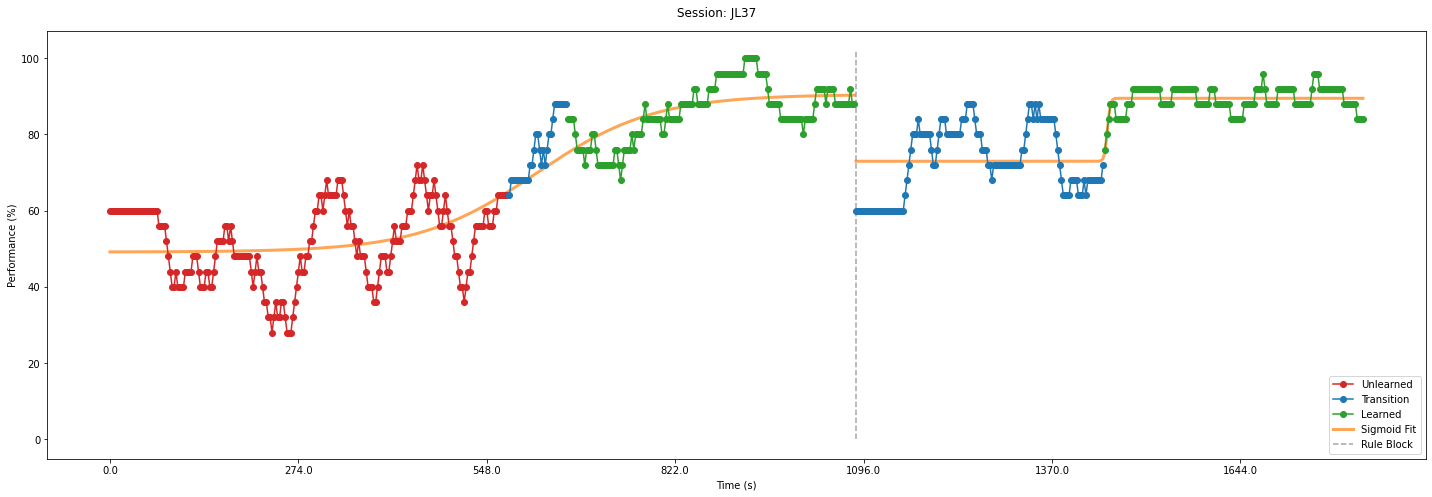

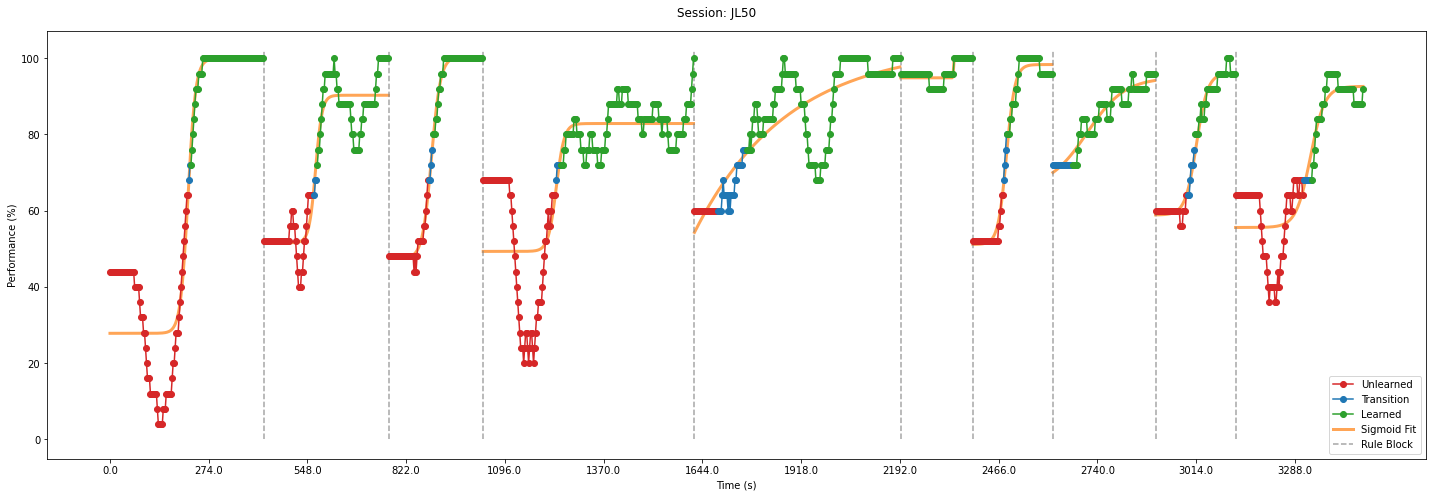

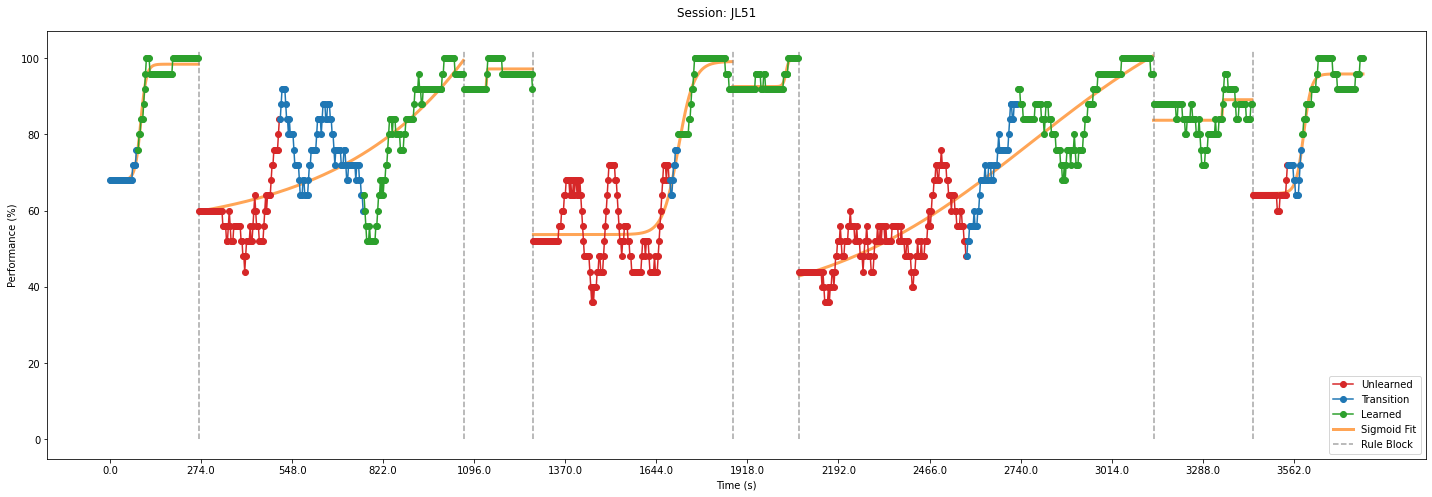

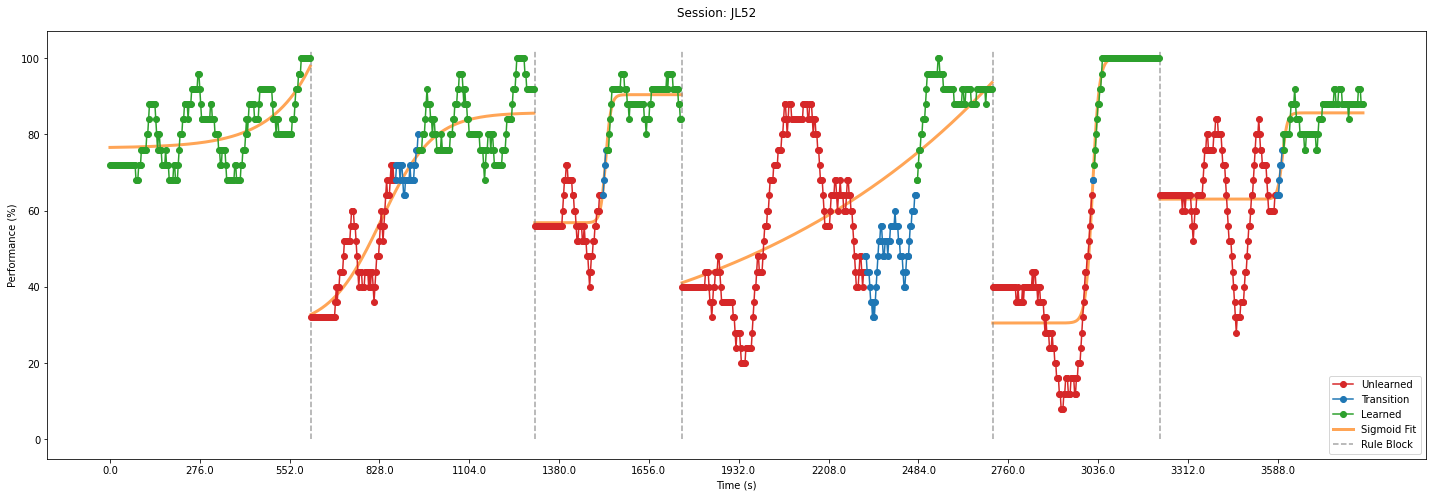

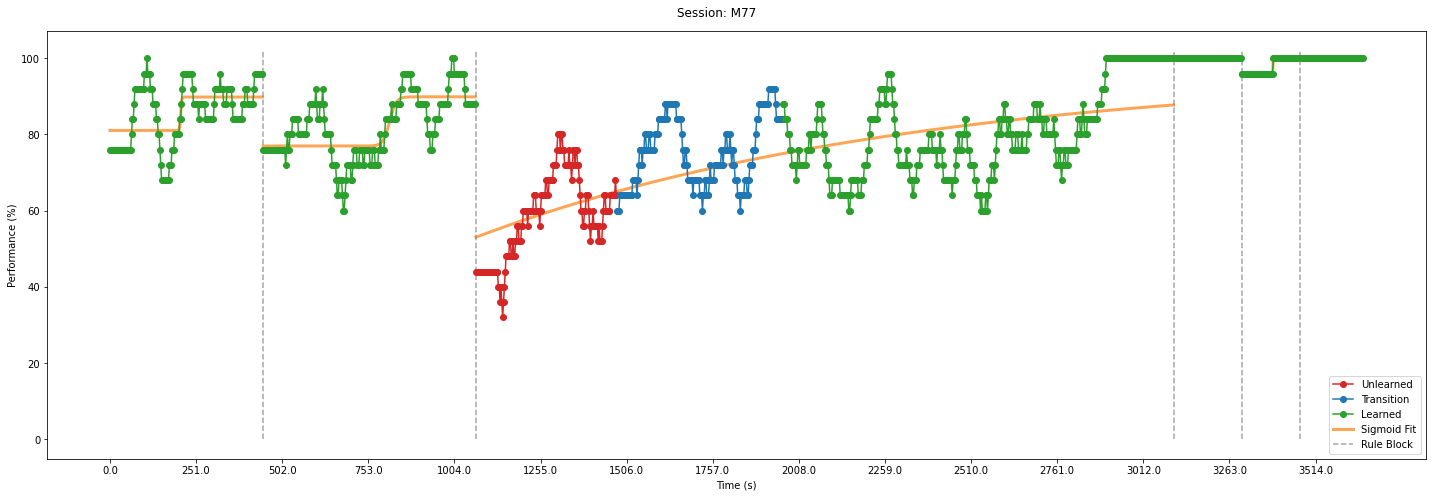

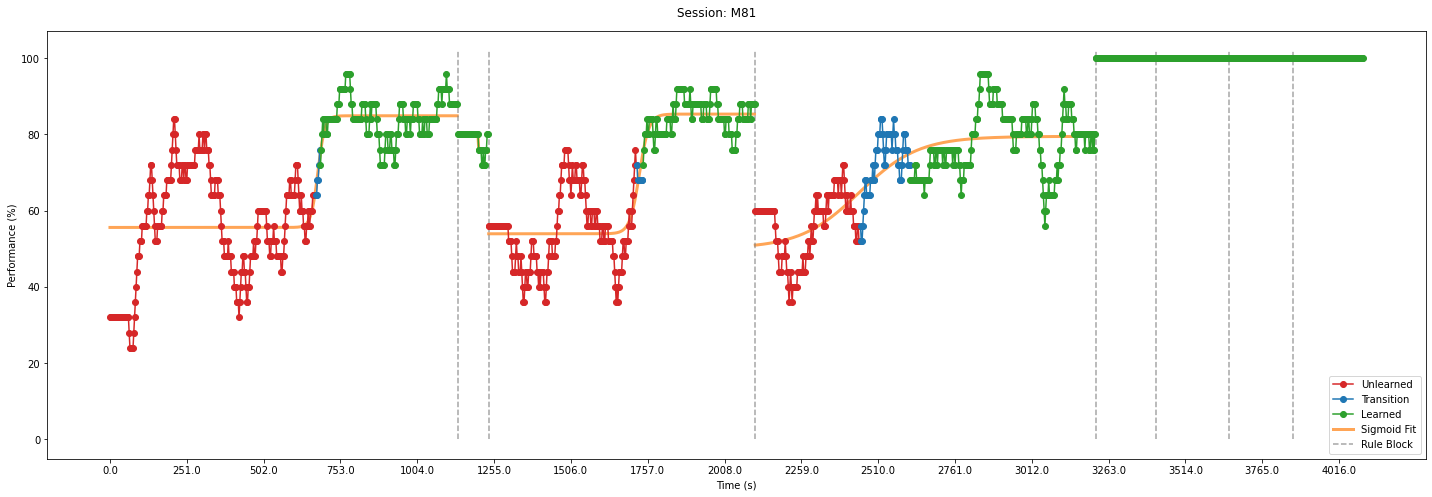

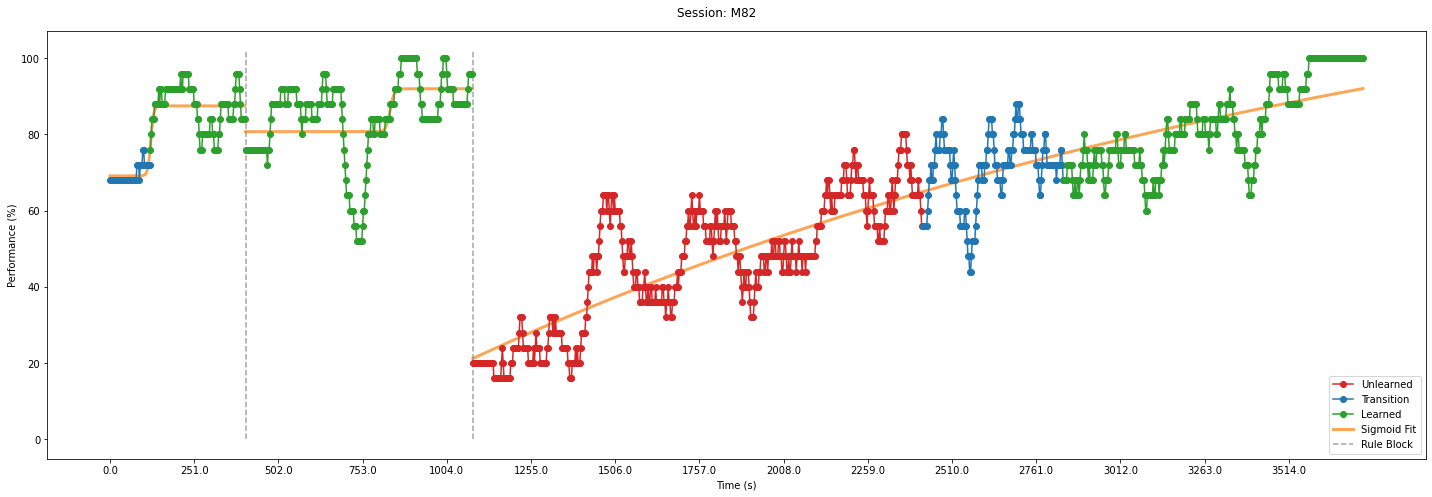

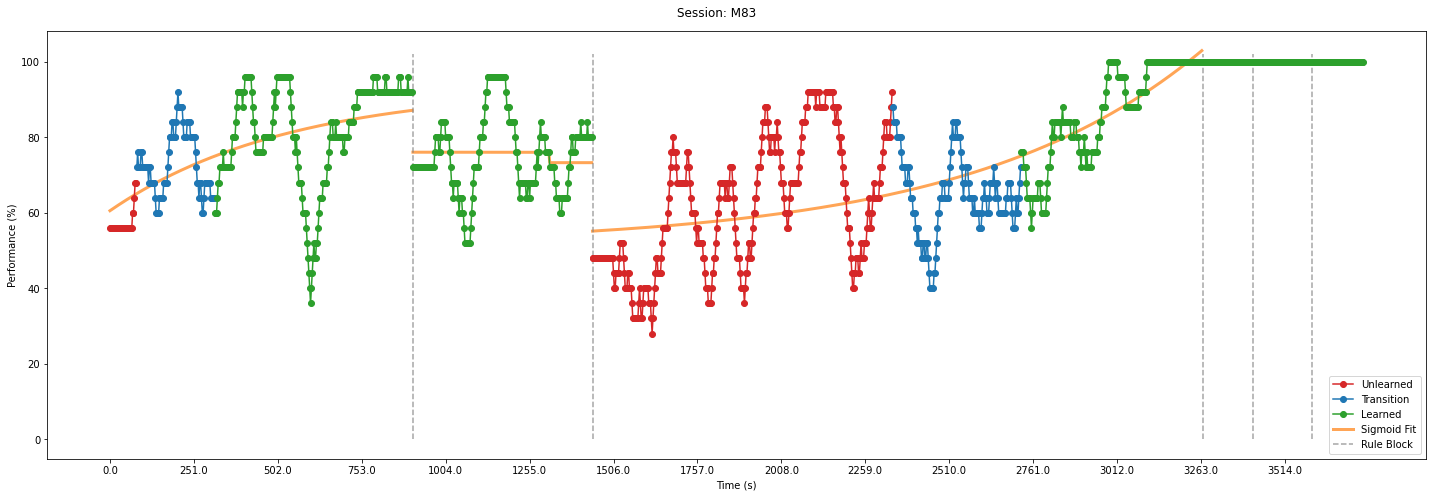

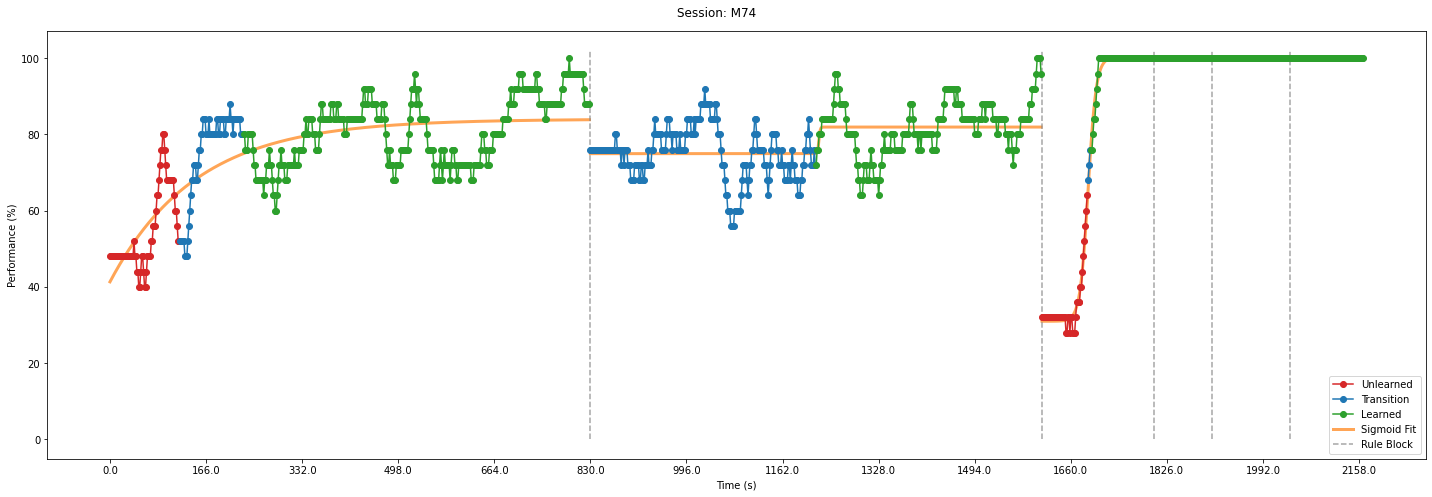

In [78]:
from scipy.optimize import curve_fit
sessions = ["JL37", "JL50", "JL51", "JL52", "M77", "M81", "M82", "M83", "M74"]
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

for s_idx in range(9):
    X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l, border, m_perf = load_session(s_idx, monk_perf=True)
    b = np.concatenate(([0],border,[len(m_perf)])).ravel()
    fig, ax = plt.subplots(1,1, figsize=(20,7))
    first=True
    for i in np.arange(1,len(b)):
        ydata=m_perf[b[i-1]:b[i]]
        xdata=np.arange(b[i-1],b[i])
        p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
        popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='lm', maxfev=100000)
        sig = sigmoid(xdata, *popt)
        l_idx = np.argwhere(sig>65).ravel()[0]
        h_idx = np.argwhere(sig>75).ravel()[0]
        if first:
            ax.plot(xdata[:l_idx], ydata[:l_idx], ls=None, marker='o', color='tab:red', label='Unlearned')
            ax.plot(xdata[l_idx:h_idx], ydata[l_idx:h_idx], ls=None, marker='o', color='tab:blue', label='Transition')
            ax.plot(xdata[h_idx:], ydata[h_idx:], ls=None, marker='o', color='tab:green', label='Learned')
            ax.plot(xdata,sig, color='tab:orange', label='Sigmoid Fit', zorder=-1, lw=3, alpha=0.7)
            first=False
        else:
            ax.plot(xdata[:l_idx], ydata[:l_idx], ls=None, marker='o', color='tab:red')
            ax.plot(xdata[l_idx:h_idx], ydata[l_idx:h_idx], ls=None, marker='o', color='tab:blue')
            ax.plot(xdata[h_idx:], ydata[h_idx:], ls=None, marker='o', color='tab:green')
            ax.plot(xdata,sig, color='tab:orange', zorder=-2, lw=3, alpha=0.7)
    first=True
    for bo in border:
        if first:
            plt.vlines(bo, 0, 102, ls='dashed', alpha=0.7, color='gray', label='Rule Block')
            first=False
        else:
            plt.vlines(bo, 0, 102, ls='dashed', alpha=0.7, color='gray')
    SR = 100 # Sampling Rate
    t_tick = np.arange(0,X_rates.shape[0], 100)
    t_label = np.arange(0, X_rates.shape[0]*X_rates.shape[1]/SR, 100*X_rates.shape[1]/SR)
    plt.xticks(t_tick,t_label)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Performance (%)")
    ax.legend(loc='lower right')
    fig.suptitle(f'Session: {sessions[s_idx]}')
    fig.tight_layout()

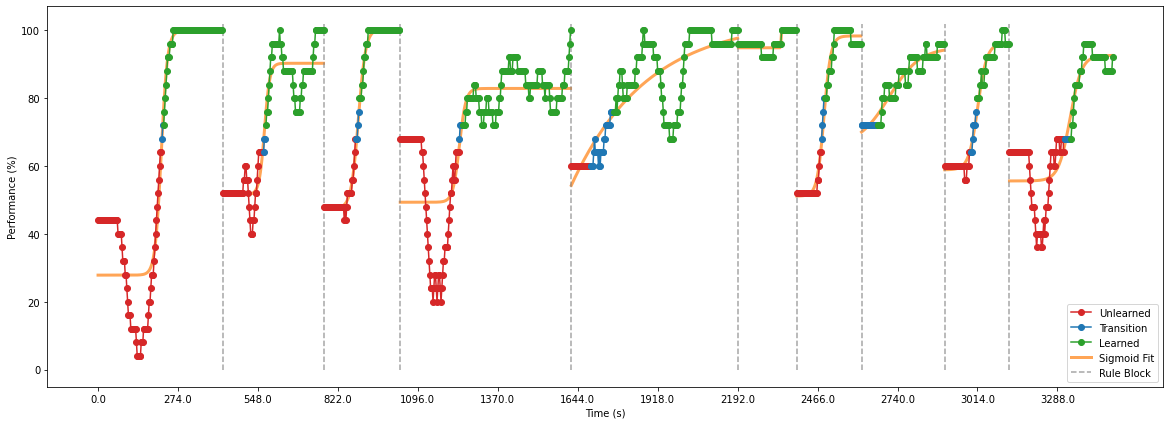

In [71]:

b = np.concatenate(([0],border,[len(m_perf)])).ravel()
fig, ax = plt.subplots(1,1, figsize=(20,7))
first=True
for i in np.arange(1,len(b)):
    ydata=m_perf[b[i-1]:b[i]]
    xdata=np.arange(b[i-1],b[i])
    p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='lm', maxfev=5000)
    sig = sigmoid(xdata, *popt)
    l_idx = np.argwhere(sig>65).ravel()[0]
    h_idx = np.argwhere(sig>75).ravel()[0]
    if first:
        ax.plot(xdata[:l_idx], ydata[:l_idx], ls=None, marker='o', color='tab:red', label='Unlearned')
        ax.plot(xdata[l_idx:h_idx], ydata[l_idx:h_idx], ls=None, marker='o', color='tab:blue', label='Transition')
        ax.plot(xdata[h_idx:], ydata[h_idx:], ls=None, marker='o', color='tab:green', label='Learned')
        ax.plot(xdata,sig, color='tab:orange', label='Sigmoid Fit', zorder=-1, lw=3, alpha=0.7)
        first=False
    else:
        ax.plot(xdata[:l_idx], ydata[:l_idx], ls=None, marker='o', color='tab:red')
        ax.plot(xdata[l_idx:h_idx], ydata[l_idx:h_idx], ls=None, marker='o', color='tab:blue')
        ax.plot(xdata[h_idx:], ydata[h_idx:], ls=None, marker='o', color='tab:green')
        ax.plot(xdata,sig, color='tab:orange', zorder=-2, lw=3, alpha=0.7)
first=True
for bo in border:
    if first:
        plt.vlines(bo, 0, 102, ls='dashed', alpha=0.7, color='gray', label='Rule Block')
        first=False
    else:
        plt.vlines(bo, 0, 102, ls='dashed', alpha=0.7, color='gray')
SR = 100 # Sampling Rate
t_tick = np.arange(0,X_rates.shape[0], 100)
t_label = np.arange(0, X_rates.shape[0]*X_rates.shape[1]/SR, 100*X_rates.shape[1]/SR)
plt.xticks(t_tick,t_label)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Performance (%)")
ax.legend(loc='lower right')

In [52]:
print(np.concatenate(([0],border,[len(m_perf)])).ravel())

[   0  156  283  378  592  801  874  955 1059 1140 1270]


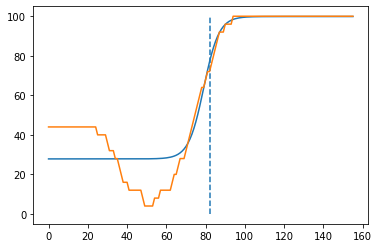

In [47]:
y = sigmoid(xdata, *popt)
plt.plot(xdata,y)
plt.plot(xdata,ydata)
x = np.argwhere(y>75).ravel()[0]
plt.vlines(x, 0,100, ls='dashed')
plt.show()

In [53]:
x

82

In [44]:
y

array([0.27826586, 0.27826586, 0.27826586, 0.27826586, 0.27826586,
       0.27826586, 0.27826587, 0.27826587, 0.27826587, 0.27826587,
       0.27826587, 0.27826588, 0.27826588, 0.27826589, 0.2782659 ,
       0.27826591, 0.27826592, 0.27826594, 0.27826596, 0.27826599,
       0.27826603, 0.27826608, 0.27826614, 0.27826622, 0.27826633,
       0.27826647, 0.27826664, 0.27826688, 0.27826717, 0.27826756,
       0.27826807, 0.27826872, 0.27826956, 0.27827065, 0.27827207,
       0.27827391, 0.27827628, 0.27827936, 0.27828335, 0.27828852,
       0.27829522, 0.27830389, 0.27831513, 0.27832969, 0.27834855,
       0.27837298, 0.27840462, 0.27844562, 0.27849872, 0.2785675 ,
       0.27865658, 0.27877196, 0.27892137, 0.27911484, 0.27936533,
       0.27968958, 0.28010921, 0.28065211, 0.28135422, 0.28226175,
       0.28343406, 0.28494708, 0.28689771, 0.28940894, 0.292636  ,
       0.29677324, 0.30206145, 0.30879496, 0.31732701, 0.32807135,
       0.34149675, 0.3581101 , 0.37842306, 0.40289811, 0.43187

# Best performing Channels Similar Rules

In [12]:
print(sess_infos)

[{'name': 'JerryLee', 'bank': 'A', 'name_short': 'j', 'date': '090601', 'exp_code': 'sra3_2_j_037_00+03', 'nsx': 'datafile003.ns2'}, {'name': 'JerryLee', 'bank': 'A', 'name_short': 'j', 'date': '090623', 'exp_code': 'sra3_1_j_050_00+', 'nsx': 'datafile002.ns2'}, {'name': 'JerryLee', 'bank': 'B', 'name_short': 'j', 'date': '090624', 'exp_code': 'sra3_1_j_051_00+', 'nsx': 'datafile002.ns2'}, {'name': 'JerryLee', 'bank': 'C', 'name_short': 'j', 'date': '090625', 'exp_code': 'sra3_1_j_052_00+', 'nsx': 'datafile003.ns2'}, {'name': 'Marty', 'bank': 'C', 'name_short': 'm', 'date': '090919', 'exp_code': 'sra3_1_m_077_00+01', 'nsx': 'datafile001.ns2'}, {'name': 'Marty', 'bank': 'B', 'name_short': 'm', 'date': '090925', 'exp_code': 'sra3_1_m_081_00+01', 'nsx': 'datafile001.ns2'}, {'name': 'Marty', 'bank': 'A', 'name_short': 'm', 'date': '090926', 'exp_code': 'sra3_1_m_082_00+01', 'nsx': 'datafile001.ns2'}, {'name': 'Marty', 'bank': 'C', 'name_short': 'm', 'date': '090927', 'exp_code': 'sra3_1_m_

In [5]:
sess_infos.append ({'name': 'Marty',
                 'bank': 'A',
                 'name_short': 'm',
                 'date': '',
                 'exp_code': 'sra3_1_m_074_00+01',
                 'nsx': ''})

In [15]:
for s_idx in np.arange(0,9):
    X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l, border = load_session(s_idx)
    sess_info = sess_infos[s_idx]
    sess_id = sess_info['exp_code']
    print(sess_id, X_rates.shape)

sra3_2_j_037_00+03 (332, 207, 32)
sra3_1_j_050_00+ (663, 207, 32)
sra3_1_j_051_00+ (681, 207, 32)
sra3_1_j_052_00+ (695, 207, 32)
sra3_1_m_077_00+01 (311, 207, 32)
sra3_1_m_081_00+01 (307, 207, 32)
sra3_1_m_082_00+01 (251, 207, 32)
sra3_1_m_083_00+01 (289, 207, 32)
sra3_1_m_074_00+01 (1305, 166, 32)


### Same Number of Channels

In [28]:
N_SPLITS = 2
s_idx = 4
X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l, border = load_session(s_idx)
sess_info = sess_infos[s_idx]
sess_id = sess_info['exp_code']
b = np.zeros(len(border)+2)
b[0] = 0
b[1:-1] = border
b[-1] = len(rule)
b = b.astype(int)
print(f'\n\nSession {sess_id}')
block = 5
perf = []
idx = []
for i in learned:
    if ((b[block]<i)&(i<b[block+1])):
        idx.append(i)
r = rule[idx]
rr, cc = np.unique(r, return_counts=True)
ss = np.argsort(b)
print(f'Block {block}, Rules: {rr[ss[0]]}, {rr[ss[1]]}')
for ch in range(X_rates.shape[-1]):
    X = np.squeeze(X_rates[idx,:,ch])
    shuf_idx = np.arange(len(r))
    for s in range(100):
        np.random.shuffle(shuf_idx)
    X = X[shuf_idx,:]
    r = r[shuf_idx]
    kf = KFold(n_splits=N_SPLITS)
    scores = []
    scores_shuf = []
    for train_index, test_index in kf.split(X):
        x_tr, x_ts = X[train_index], X[test_index]
        y_tr, y_ts = r[train_index], r[test_index]
        clf = SVC(verbose=False).fit(x_tr, y_tr)
        acc = clf.score(x_ts, y_ts)
        scores.append(acc)
    perf.append(np.mean(np.array(scores)))
print(perf)
s_idx = 7
X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l, border = load_session(s_idx)
sess_info = sess_infos[s_idx]
sess_id = sess_info['exp_code']
b = np.zeros(len(border)+2)
b[0] = 0
b[1:-1] = border
b[-1] = len(rule)
b = b.astype(int)
print(f'\n\nSession {sess_id}')
block = 3
perf = []
idx = []
for i in learned:
    if ((b[block]<i)&(i<b[block+1])):
        idx.append(i)
r = rule[idx]
rr, cc = np.unique(r, return_counts=True)
ss = np.argsort(b)
print(f'Block {block}, Rules: {rr[ss[0]]}, {rr[ss[1]]}')
for ch in range(X_rates.shape[-1]):
    X = np.squeeze(X_rates[idx,:,ch])
    shuf_idx = np.arange(len(r))
    for s in range(100):
        np.random.shuffle(shuf_idx)
    X = X[shuf_idx,:]
    r = r[shuf_idx]
    kf = KFold(n_splits=N_SPLITS)
    scores = []
    scores_shuf = []
    for train_index, test_index in kf.split(X):
        x_tr, x_ts = X[train_index], X[test_index]
        y_tr, y_ts = r[train_index], r[test_index]
        clf = SVC(verbose=False).fit(x_tr, y_tr)
        acc = clf.score(x_ts, y_ts)
        scores.append(acc)
    perf.append(np.mean(np.array(scores)))
print(perf)
#             print (f'Channel {ch} Performance: {np.mean(np.array(scores))}')



Session sra3_1_m_077_00+01


IndexError: index 5 is out of bounds for axis 0 with size 4

In [31]:
for block in range(len(b)-1):
    for i in learned:
        if ((b[block]<i)&(i<b[block+1])):
            idx.append(i)
    r = rule[idx]
    rr, cc = np.unique(r, return_counts=True)
    ss = np.argsort(b)
    print(f'Block {block}, Rules: {rr[ss[0]]}, {rr[ss[1]]}')

Block 0, Rules: 1, 6
Block 1, Rules: 1, 6
Block 2, Rules: 1, 6


### Not having the same number of channels

In [6]:
N_SPLITS = 3
s_idx = 8
for s_idx in np.arange(0,9):
    X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l, border = load_session(s_idx)
    sess_info = sess_infos[s_idx]
    sess_id = sess_info['exp_code']
    b = np.zeros(len(border)+2)
    b[0] = 0
    b[1:-1] = border
    b[-1] = len(rule)
    b = b.astype(int)
    print(f'\n\nSession {sess_id}')
    for block in range(len(b)-1):
        perf = []
        idx = []
        for i in learned:
            if ((b[block]<i)&(i<b[block+1])):
                idx.append(i)
        r = rule[idx]
        rr, cc = np.unique(r, return_counts=True)
        ss = np.argsort(b)
        print(f'Block {block}, Rules: {rr[ss[0]]}, {rr[ss[1]]}')
        for ch in range(X_rates.shape[-1]):
            X = np.squeeze(X_rates[idx,:,ch])
            kf = KFold(n_splits=N_SPLITS)
            scores = []
            scores_shuf = []
            for train_index, test_index in kf.split(X):
                x_tr, x_ts = X[train_index], X[test_index]
                y_tr, y_ts = r[train_index], r[test_index]
                clf = SVC(verbose=False).fit(x_tr, y_tr)
                acc = clf.score(x_ts, y_ts)
                scores.append(acc)
            perf.append(np.mean(np.array(scores)))
        print(perf)
#             print (f'Channel {ch} Performance: {np.mean(np.array(scores))}')



Session sra3_2_j_037_00+03
Block 0, Rules: 11, 22
[0.5128205128205128, 0.5, 0.4807692307692308, 0.6153846153846153, 0.5576923076923077, 0.4807692307692308, 0.4615384615384615, 0.5256410256410257, 0.4871794871794872, 0.5, 0.5512820512820512, 0.576923076923077]
Block 1, Rules: 10, 23
[0.46752136752136747, 0.5075369075369075, 0.518026418026418, 0.46744366744366744, 0.44638694638694637, 0.5329448329448329, 0.4821289821289822, 0.5683760683760682, 0.4874125874125874, 0.5028749028749029, 0.4977466977466978, 0.4824397824397824]


Session sra3_1_j_050_00+
Block 0, Rules: 2, 13
[0.7799999999999999, 0.576111111111111, 0.7538888888888889, 0.7527777777777778, 0.5622222222222222, 0.6577777777777779, 0.5333333333333333, 0.5750000000000001, 0.46555555555555556, 0.43777777777777777, 0.7816666666666667, 0.7116666666666666, 0.9033333333333333, 0.7538888888888889, 0.5894444444444444, 0.63, 0.6172222222222222, 0.6172222222222223, 0.5761111111111111, 0.8077777777777778, 0.6988888888888889, 0.5077777777777

[0.5673758865248227, 0.41843971631205673, 0.673758865248227, 0.6808510638297872, 0.5673758865248226, 0.5531914893617021, 0.5815602836879433, 0.48936170212765956, 0.6382978723404255, 0.5106382978723404, 0.4751773049645389, 0.5035460992907802, 0.5602836879432624, 0.6028368794326241, 0.652482269503546, 0.5815602836879433, 0.524822695035461, 0.46808510638297873, 0.3900709219858156, 0.6028368794326241, 0.524822695035461, 0.5531914893617021, 0.6666666666666666, 0.702127659574468, 0.45390070921985815, 0.524822695035461, 0.7375886524822696, 0.5886524822695036, 0.6170212765957447, 0.5531914893617021, 0.5390070921985816, 0.5460992907801419, 0.4822695035460993, 0.4822695035460993, 0.5957446808510638, 0.5673758865248226, 0.4326241134751773, 0.9148936170212766, 0.6170212765957447, 0.41843971631205673, 0.5106382978723404, 0.48936170212765956, 0.5602836879432624, 0.4326241134751773, 0.45390070921985815, 0.48936170212765956, 0.8085106382978724, 0.6099290780141845]
Block 2, Rules: 8, 18
[0.573333333333

[0.4166666666666667, 0.36111111111111116, 0.4166666666666667, 0.6805555555555555, 0.4861111111111111, 0.625, 0.5416666666666666, 0.4166666666666667, 0.375, 0.3333333333333333, 0.4861111111111111, 0.34722222222222227, 0.47222222222222227, 0.375, 0.3194444444444444, 0.4166666666666667, 0.638888888888889, 0.4166666666666667, 0.5694444444444445, 0.625, 0.7083333333333334, 0.3611111111111111, 0.40277777777777773, 0.5000000000000001, 0.375, 0.6527777777777778, 0.9166666666666666, 0.736111111111111, 0.8333333333333334, 0.6944444444444445, 0.6111111111111112, 0.861111111111111, 0.875, 0.8888888888888888]
Block 5, Rules: 3, 16
[0.5967948717948718, 0.5126068376068376, 0.5722222222222223, 0.5715811965811967, 0.5805555555555556, 0.5378205128205128, 0.5549145299145298, 0.513034188034188, 0.5884615384615385, 0.5463675213675213, 0.6138888888888889, 0.7064102564102565, 0.6051282051282051, 0.5717948717948719, 0.5463675213675214, 0.4707264957264958, 0.4611111111111111, 0.5123931623931625, 0.588247863247

[0.4373251970505974, 0.437350622934147, 0.5130689041444191, 0.4897025171624714, 0.5948385456394609, 0.41973048563437576, 0.6064581744215612, 0.4198321891685735, 0.6207475209763539, 0.6674294431731503, 0.4401983218916857, 0.4896516653953726, 0.4430205949656751, 0.46920925502161204, 0.5480040681413679, 0.6238240528858378, 0.7434274091024663, 0.44304602084922456, 0.4810068649885584, 0.489626239511823, 0.41967963386727686, 0.4401728960081363, 0.4372743452834986, 0.512840071192474, 0.4372743452834986, 0.4372743452834986, 0.4604118993135011]


Session sra3_1_m_083_00+01
Block 0, Rules: 8, 18
[0.5972222222222222, 0.5462962962962963, 0.5324074074074074, 0.7407407407407408, 0.5925925925925926, 0.5277777777777777, 0.5277777777777777, 0.5879629629629629, 0.5370370370370371, 0.5833333333333334, 0.5648148148148148, 0.5972222222222222, 0.5462962962962963, 0.6759259259259259, 0.611111111111111, 0.5648148148148149, 0.6342592592592592, 0.5555555555555556, 0.9537037037037037, 0.5324074074074074, 0.59722

In [9]:
a = [1, 2, 4, 5, 6, 6]
print(not(3 in a))

True


In [14]:
print(border)
np.unique(rule[border[0]:border[1]], return_counts=True)

[ 500  970 1087 1147 1228]


(array([ 9, 16, 22]), array([233,   1, 236], dtype=int64))

# Memory Capacity

We go block by block, decode the rule, evaluation accuracy / chance level is our metrics on y axis. Number of new rules is our metrics on x axis.
Repeated rules do not count as new rules.

In [20]:
N_SPLITS = 3
s_idx = 8
for s_idx in np.arange(0,9):
    perf = []
    X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l, border = load_session(s_idx)
    sess_info = sess_infos[s_idx]
    sess_id = sess_info['exp_code']
    b = np.zeros(len(border)+2)
    b[0] = 0
    b[1:-1] = border
    b[-1] = len(rule)
    b = b.astype(int)
    n_unq_rules = []
    unq_rules = []
    print(f'\n\nSession {sess_id}')
    for block in range(len(b)-1):
        idx = []
        for i in learned:
            if ((b[block]<i)&(i<b[block+1])):
                idx.append(i)
        r = rule[idx]
        rr, cc = np.unique(r, return_counts=True)
        ss = np.argsort(b)
        if not(rr[ss[0]] in unq_rules): unq_rules.append(rr[ss[0]])
        if not(rr[ss[1]] in unq_rules): unq_rules.append(rr[ss[1]])
        print(f'Block {block}, Rules: {rr[ss[0]]}, {rr[ss[1]]}')
        print(f'Unique Rules to This Point: {unq_rules}')
        idx = []
        for i in learned:
            if (i<b[block+1]):
                idx.append(i)
        r = rule[idx]
        r_s = rule[idx]
        for rep in range(100):
            np.random.shuffle(r_s)
        X = np.reshape(X_rates[idx], [len(idx), -1])
        kf = KFold(n_splits=N_SPLITS)
        scores = []
        scores_s = []
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = r[train_index], r[test_index]
            y_tr_s, y_ts_s = r_s[train_index], r_s[test_index]
            clf = SVC(verbose=False).fit(x_tr, y_tr)
            clf2 = SVC(verbose=False).fit(x_tr, y_tr_s)
            acc = clf.score(x_ts, y_ts)
            acc_s = clf2.score(x_ts, y_ts_s)
            scores.append(acc)
            scores_s.append(acc_s)
        n_unq_rules.append(len(unq_rules))
        perf.append(np.mean(np.array(scores))/np.mean(np.array(scores_s)))
        print(f'Normalized Rule Decoding Accuracy: {perf[-1]}')
    print (f'X = {n_unq_rules}\nY = {perf}')



Session sra3_2_j_037_00+03
Block 0, Rules: 11, 22
Unique Rules to This Point: [11, 22]
Normalized Rule Decoding Accuracy: 0.9775280898876403
Block 1, Rules: 10, 23
Unique Rules to This Point: [11, 22, 10, 23]
Normalized Rule Decoding Accuracy: 0.5375927973463906
X = [2, 4]
Y = [0.9775280898876403, 0.5375927973463906]


Session sra3_1_j_050_00+
Block 0, Rules: 2, 13
Unique Rules to This Point: [2, 13]
Normalized Rule Decoding Accuracy: 1.9758507135016468
Block 1, Rules: 9, 23
Unique Rules to This Point: [2, 13, 9, 23]
Normalized Rule Decoding Accuracy: 4.1619110816191105
Block 2, Rules: 2, 13
Unique Rules to This Point: [2, 13, 9, 23]
Normalized Rule Decoding Accuracy: 3.1273991655076494
Block 3, Rules: 4, 17
Unique Rules to This Point: [2, 13, 9, 23, 4, 17]
Normalized Rule Decoding Accuracy: 4.447612944569049
Block 4, Rules: 7, 18
Unique Rules to This Point: [2, 13, 9, 23, 4, 17, 7, 18]
Normalized Rule Decoding Accuracy: 2.7205882352941178
Block 5, Rules: 7, 12
Unique Rules to This P

Normalized Rule Decoding Accuracy: 1.43597410095678
Block 5, Rules: 7, 12
Unique Rules to This Point: [3, 16, 9, 22, 10, 21, 4, 17, 2, 12, 7]
Normalized Rule Decoding Accuracy: 0.15625
X = [2, 4, 6, 8, 10, 11]
Y = [1.4923817161186848, 2.474860335195531, 2.585769550952451, 2.4407261642059286, 1.43597410095678, 0.15625]


# Learned vs. Unlearned

In [3]:
chunk = 2
segmented_path = data_path / 'sra3_1_j_050_00_v4_segmented.h5'
segmented_data = from_neuropype_h5(segmented_path)
outcome = np.array(segmented_data[chunk][1]['axes'][0]['data']['OutcomeCode'])
flag = np.argwhere(outcome>-1).flatten()
outcome = outcome[flag]
Y = np.array(segmented_data[chunk][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X_rates = segmented_data[chunk][1]['data'][flag]
X_rates = np.nan_to_num(X_rates)
X_rates = np.transpose(X_rates, (0, 2, 1))
block = np.array(segmented_data[chunk][1]['axes'][0]['data']['Block']).flatten()[flag]
b=np.diff(block, axis=0)
border=np.array(np.where(b>0)).flatten()
to_keep = [0]
for i in range(len(border) - 1):
    if (border[i + 1] - border[i]) > 30 and (len(outcome)-border[i+1]) > 30:
        to_keep.append(i + 1)
border = border[to_keep]
color = np.array(segmented_data[chunk][1]['axes'][0]['data']['CueColour']).flatten()[flag]
target = np.array(segmented_data[chunk][1]['axes'][0]['data']['TargetRule']).flatten()[flag]
classes = np.array(segmented_data[chunk][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
times = np.array(segmented_data[chunk][1]['axes'][1]['times']).flatten()

print(border)
print(outcome.shape)
print(f'times : {times.shape}')
print(X_rates.shape, Y.shape, np.unique(Y, return_counts=True))

[ 154  282  378  593  802  875  960 1064 1146]
(1277,)
times : (166,)
(1277, 32, 166) (1277,) (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([177, 222, 141, 112, 167, 199, 138, 121], dtype=int64))


(651,) (247,)


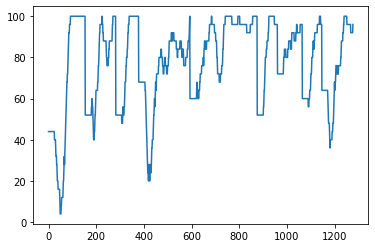

In [4]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)
learned = np.argwhere(m_performance>80).flatten()
unlearned = np.argwhere(m_performance<60).flatten()
print(learned.shape, unlearned.shape)

In [5]:
rule = np.zeros(np.size(X_rates,0))
for i in range(len(rule)):
    if (target[i]=='UU'):
        if (color[i] == 'r'):
            rule[i]=0
        elif(color[i] == 'g'):
            rule[i]=1
        else:
            rule[i]=2
    elif (target[i]=='UR'):
        if (color[i] == 'r'):
            rule[i]=3
        elif(color[i] == 'g'):
            rule[i]=4
        else:
            rule[i]=5
    elif (target[i]=='RR'):
        if (color[i] == 'r'):
            rule[i]=6
        elif(color[i] == 'g'):
            rule[i]=7
        else:
            rule[i]=8
    elif (target[i]=='DR'):
        if (color[i] == 'r'):
            rule[i]=9
        elif(color[i] == 'g'):
            rule[i]=10
        else:
            rule[i]=11
    elif (target[i]=='DD'):
        if (color[i] == 'r'):
            rule[i]=12
        elif(color[i] == 'g'):
            rule[i]=13
        else:
            rule[i]=14
    elif (target[i]=='DL'):
        if (color[i] == 'r'):
            rule[i]=15
        elif(color[i] == 'g'):
            rule[i]=16
        else:
            rule[i]=17
    elif (target[i]=='LL'):
        if (color[i] == 'r'):
            rule[i]=18
        elif(color[i] == 'g'):
            rule[i]=19
        else:
            rule[i]=20
    elif (target[i]=='UL'):
        if (color[i] == 'r'):
            rule[i]=21
        elif(color[i] == 'g'):
            rule[i]=22
        else:
            rule[i]=23
rule = rule.astype(int)
print(np.unique(rule, return_counts=True))
print(np.unique(rule[unlearned], return_counts=True))
print(np.unique(rule[learned], return_counts=True))

(array([ 0,  1,  2,  3,  4,  7,  9, 10, 12, 13, 15, 17, 18, 23]), array([ 51,   1, 125,  63, 159, 141,  62,  50,   7, 160,  36, 163, 138,
       121], dtype=int64))
(array([ 0,  2,  3,  4,  9, 13, 15, 17, 18, 23]), array([16, 58, 12, 19, 19, 65,  1, 34,  1, 22], dtype=int64))
(array([ 0,  2,  3,  4,  7,  9, 10, 12, 13, 15, 17, 18, 23]), array([ 28,  58,  26,  55, 104,  32,  32,   4,  80,  20,  59,  90,  63],
      dtype=int64))


In [15]:
idx=[962,  963,  969,  970,  971,  973,  974,  976,  977,  978,  981,
        984,  987,  990,  991,  994,  995,  996,  998,  999, 1000, 1001,
       1004, 1006, 1007, 1009, 1010, 1011, 1014, 1016, 1017, 1018, 1020,
       1021, 1022, 1023, 1024, 1025, 1027, 1028, 1030, 1032, 1033, 1036,
       1041, 1045, 1046, 1047, 1048, 1050, 1054, 1056, 1058, 1060, 1065]
rule[idx] = 24
print(np.unique(rule[learned], return_counts=True))

(array([ 0,  2,  3,  4,  7,  9, 10, 12, 13, 15, 17, 18, 23, 24]), array([ 28,  58,  26,  55, 104,  32,  32,   4,  80,  20,  59,  90,  28,
        35], dtype=int64))


In [16]:
cor = np.array(np.where(outcome==0)).flatten()
icor = np.array(np.where(outcome==9)).flatten()
c_l = []
ic_ul = []
for c in cor:
    if c in learned:
        c_l.append(c)
for ic in icor:
    if ic in unlearned:
        ic_ul.append(ic)
print(np.unique(rule[c_l], return_counts=True))
print(np.unique(rule[ic_ul], return_counts=True))

(array([ 0,  2,  3,  4,  7,  9, 10, 12, 13, 15, 17, 18, 23, 24]), array([ 27,  58,  24,  50, 103,  32,  29,   4,  80,  18,  57,  83,  24,
        33], dtype=int64))
(array([ 0,  2,  3,  4,  9, 13, 17, 23]), array([12, 45,  7, 14,  5, 20, 15, 13], dtype=int64))


# Model

In [17]:
_xx = X_rates[c_l]
_yy = tf.keras.utils.to_categorical(rule[c_l], num_classes=np.max(rule[c_l])+1)
print(_xx.shape, _yy.shape)
tmp_model = make_model(_xx, _yy.shape[-1])
tmp_model.summary()

(622, 32, 166) (622, 25)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 166)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 17, 32)            85024     
_________________________________________________________________
batch_normalization (BatchNo (None, 17, 32)            128       
_________________________________________________________________
dropout (Dropout)            (None, 17, 32)            0         
_________________________________________________________________
rnn1 (LSTM)                  (None, 32)                8320      
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch 

In [19]:
sess_info = sess_infos[1]
sess_id = sess_info['exp_code']
sess_id

'sra3_1_j_050_00+'

In [20]:
rates = X_rates[c_l]
rules = rule[c_l]
hist, acc, y_pred, y_true = kfold_pred(sess_id,rates,rules,name='cor_l_rd2' ,verbose=1)

C:\Users\Alireza\miniconda3\envs\dl\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 1 of 10
Epoch 1/150
27/34 [======================>.......] - ETA: 0s - loss: 3.4850 - accuracy: 0.3449  
Epoch 00001: val_accuracy improved from -inf to 0.30159, saving model to cor_l_rd2_sra3_1_j_050_00+_split0.h5
34/34 [==============================] - 1s 15ms/step - loss: 3.3711 - accuracy: 0.4081 - val_loss: 3.5625 - val_accuracy: 0.3016
Epoch 2/150
27/34 [======================>.......] - ETA: 0s - loss: 2.6942 - accuracy: 0.6319
Epoch 00002: val_accuracy improved from 0.30159 to 0.42857, saving model to cor_l_rd2_sra3_1_j_050_00+_split0.h5
34/34 [==============================] - 0s 5ms/step - loss: 2.6490 - accuracy: 0.6324 - val_loss: 3.1039 - val_accuracy: 0.4286
Epoch 3/150
28/34 [=======================>......] - ETA: 0s - loss: 2.3631 - accuracy: 0.6875
Epoch 00003: val_accuracy improved from 0.42857 to 0.60317, saving model to cor_l_rd2_sra3_1_j_050_00+_split0.h5
34/34 [==============================] - 0s 5ms/step - loss: 2.3554 - accuracy: 0.6893 - val_loss: 2.63

Epoch 29/150
29/34 [========================>.....] - ETA: 0s - loss: 1.3304 - accuracy: 0.9741
Epoch 00029: val_accuracy did not improve from 0.74603
34/34 [==============================] - 0s 4ms/step - loss: 1.3309 - accuracy: 0.9724 - val_loss: 1.8102 - val_accuracy: 0.7302
Epoch 30/150
29/34 [========================>.....] - ETA: 0s - loss: 1.3164 - accuracy: 0.9655
Epoch 00030: val_accuracy did not improve from 0.74603
34/34 [==============================] - 0s 4ms/step - loss: 1.3161 - accuracy: 0.9688 - val_loss: 1.8575 - val_accuracy: 0.7302
Epoch 31/150
29/34 [========================>.....] - ETA: 0s - loss: 1.3339 - accuracy: 0.9612
Epoch 00031: val_accuracy did not improve from 0.74603
34/34 [==============================] - 0s 4ms/step - loss: 1.3318 - accuracy: 0.9614 - val_loss: 1.8971 - val_accuracy: 0.6825
Epoch 32/150
29/34 [========================>.....] - ETA: 0s - loss: 1.3025 - accuracy: 0.9871
Epoch 00032: val_accuracy did not improve from 0.74603
34/34 [==

27/34 [======================>.......] - ETA: 0s - loss: 1.2002 - accuracy: 0.9931
Epoch 00087: val_accuracy did not improve from 0.76190
34/34 [==============================] - 0s 4ms/step - loss: 1.1999 - accuracy: 0.9945 - val_loss: 1.8967 - val_accuracy: 0.6984
Epoch 88/150
27/34 [======================>.......] - ETA: 0s - loss: 1.1877 - accuracy: 0.9977
Epoch 00088: val_accuracy did not improve from 0.76190
34/34 [==============================] - 0s 4ms/step - loss: 1.1890 - accuracy: 0.9945 - val_loss: 2.1377 - val_accuracy: 0.6349
Epoch 89/150
27/34 [======================>.......] - ETA: 0s - loss: 1.2001 - accuracy: 0.9907
Epoch 00089: val_accuracy did not improve from 0.76190
34/34 [==============================] - 0s 4ms/step - loss: 1.2023 - accuracy: 0.9908 - val_loss: 1.9621 - val_accuracy: 0.6508
Epoch 90/150
26/34 [=====================>........] - ETA: 0s - loss: 1.2130 - accuracy: 0.9928
Epoch 00090: val_accuracy did not improve from 0.76190
34/34 [===============

27/34 [======================>.......] - ETA: 0s - loss: 1.1748 - accuracy: 0.9954
Epoch 00145: val_accuracy did not improve from 0.76190
34/34 [==============================] - 0s 4ms/step - loss: 1.1727 - accuracy: 0.9963 - val_loss: 2.0433 - val_accuracy: 0.6825
Epoch 146/150
28/34 [=======================>......] - ETA: 0s - loss: 1.1590 - accuracy: 1.0000
Epoch 00146: val_accuracy did not improve from 0.76190
34/34 [==============================] - 0s 4ms/step - loss: 1.1620 - accuracy: 1.0000 - val_loss: 1.8872 - val_accuracy: 0.7143
Epoch 147/150
27/34 [======================>.......] - ETA: 0s - loss: 1.1665 - accuracy: 1.0000
Epoch 00147: val_accuracy did not improve from 0.76190
34/34 [==============================] - 0s 4ms/step - loss: 1.1667 - accuracy: 1.0000 - val_loss: 1.9095 - val_accuracy: 0.7143
Epoch 148/150
27/34 [======================>.......] - ETA: 0s - loss: 1.1605 - accuracy: 0.9977
Epoch 00148: val_accuracy did not improve from 0.76190
34/34 [============

Epoch 23/150
29/34 [========================>.....] - ETA: 0s - loss: 1.3430 - accuracy: 0.9763
Epoch 00023: val_accuracy did not improve from 0.74603
34/34 [==============================] - 0s 4ms/step - loss: 1.3471 - accuracy: 0.9743 - val_loss: 2.1755 - val_accuracy: 0.5714
Epoch 24/150
29/34 [========================>.....] - ETA: 0s - loss: 1.3432 - accuracy: 0.9634
Epoch 00024: val_accuracy did not improve from 0.74603
34/34 [==============================] - 0s 4ms/step - loss: 1.3502 - accuracy: 0.9614 - val_loss: 2.0185 - val_accuracy: 0.6508
Epoch 25/150
29/34 [========================>.....] - ETA: 0s - loss: 1.3362 - accuracy: 0.9677
Epoch 00025: val_accuracy did not improve from 0.74603
34/34 [==============================] - 0s 4ms/step - loss: 1.3372 - accuracy: 0.9669 - val_loss: 1.8272 - val_accuracy: 0.6984
Epoch 26/150
29/34 [========================>.....] - ETA: 0s - loss: 1.3198 - accuracy: 0.9720
Epoch 00026: val_accuracy did not improve from 0.74603
34/34 [==

29/34 [========================>.....] - ETA: 0s - loss: 1.2201 - accuracy: 0.9871
Epoch 00081: val_accuracy did not improve from 0.82540
34/34 [==============================] - 0s 4ms/step - loss: 1.2208 - accuracy: 0.9871 - val_loss: 1.7833 - val_accuracy: 0.6667
Epoch 82/150
29/34 [========================>.....] - ETA: 0s - loss: 1.2039 - accuracy: 0.9957
Epoch 00082: val_accuracy did not improve from 0.82540
34/34 [==============================] - 0s 4ms/step - loss: 1.2043 - accuracy: 0.9963 - val_loss: 1.8881 - val_accuracy: 0.6984
Epoch 83/150
29/34 [========================>.....] - ETA: 0s - loss: 1.2100 - accuracy: 0.9935
Epoch 00083: val_accuracy did not improve from 0.82540
34/34 [==============================] - 0s 4ms/step - loss: 1.2110 - accuracy: 0.9945 - val_loss: 1.8127 - val_accuracy: 0.6984
Epoch 84/150
29/34 [========================>.....] - ETA: 0s - loss: 1.2037 - accuracy: 0.9957
Epoch 00084: val_accuracy did not improve from 0.82540
34/34 [===============

29/34 [========================>.....] - ETA: 0s - loss: 1.1809 - accuracy: 0.9978
Epoch 00139: val_accuracy did not improve from 0.82540
34/34 [==============================] - 0s 4ms/step - loss: 1.1812 - accuracy: 0.9963 - val_loss: 2.0015 - val_accuracy: 0.6667
Epoch 140/150
29/34 [========================>.....] - ETA: 0s - loss: 1.1754 - accuracy: 0.9957
Epoch 00140: val_accuracy did not improve from 0.82540
34/34 [==============================] - 0s 4ms/step - loss: 1.1756 - accuracy: 0.9963 - val_loss: 1.8345 - val_accuracy: 0.7143
Epoch 141/150
26/34 [=====================>........] - ETA: 0s - loss: 1.1867 - accuracy: 0.9880
Epoch 00141: val_accuracy did not improve from 0.82540
34/34 [==============================] - 0s 4ms/step - loss: 1.1830 - accuracy: 0.9908 - val_loss: 1.7623 - val_accuracy: 0.6984
Epoch 142/150
27/34 [======================>.......] - ETA: 0s - loss: 1.1869 - accuracy: 0.9954
Epoch 00142: val_accuracy did not improve from 0.82540
34/34 [============

Epoch 17/150
29/35 [=======================>......] - ETA: 0s - loss: 1.4164 - accuracy: 0.9375
Epoch 00017: val_accuracy did not improve from 0.72581
35/35 [==============================] - 0s 4ms/step - loss: 1.4273 - accuracy: 0.9357 - val_loss: 1.9283 - val_accuracy: 0.6613
Epoch 18/150
29/35 [=======================>......] - ETA: 0s - loss: 1.4265 - accuracy: 0.9461
Epoch 00018: val_accuracy did not improve from 0.72581
35/35 [==============================] - 0s 4ms/step - loss: 1.4223 - accuracy: 0.9411 - val_loss: 1.9663 - val_accuracy: 0.5806
Epoch 19/150
29/35 [=======================>......] - ETA: 0s - loss: 1.3992 - accuracy: 0.9634
Epoch 00019: val_accuracy did not improve from 0.72581
35/35 [==============================] - 0s 4ms/step - loss: 1.4005 - accuracy: 0.9607 - val_loss: 1.8748 - val_accuracy: 0.7258
Epoch 20/150
29/35 [=======================>......] - ETA: 0s - loss: 1.3907 - accuracy: 0.9526
Epoch 00020: val_accuracy did not improve from 0.72581
35/35 [==

29/35 [=======================>......] - ETA: 0s - loss: 1.2412 - accuracy: 0.9763
Epoch 00075: val_accuracy did not improve from 0.74194
35/35 [==============================] - 0s 4ms/step - loss: 1.2402 - accuracy: 0.9786 - val_loss: 1.9645 - val_accuracy: 0.5968
Epoch 76/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2230 - accuracy: 0.9838
Epoch 00076: val_accuracy did not improve from 0.74194
35/35 [==============================] - 0s 4ms/step - loss: 1.2235 - accuracy: 0.9857 - val_loss: 1.9493 - val_accuracy: 0.6774
Epoch 77/150
28/35 [=======================>......] - ETA: 0s - loss: 1.2112 - accuracy: 0.9933
Epoch 00077: val_accuracy did not improve from 0.74194
35/35 [==============================] - 0s 4ms/step - loss: 1.2101 - accuracy: 0.9946 - val_loss: 1.9594 - val_accuracy: 0.6613
Epoch 78/150
28/35 [=======================>......] - ETA: 0s - loss: 1.2000 - accuracy: 0.9911
Epoch 00078: val_accuracy did not improve from 0.74194
35/35 [===============

26/35 [=====================>........] - ETA: 0s - loss: 1.1766 - accuracy: 0.9952
Epoch 00133: val_accuracy did not improve from 0.74194
35/35 [==============================] - 0s 4ms/step - loss: 1.1766 - accuracy: 0.9946 - val_loss: 1.9469 - val_accuracy: 0.6774
Epoch 134/150
28/35 [=======================>......] - ETA: 0s - loss: 1.1712 - accuracy: 0.9933
Epoch 00134: val_accuracy did not improve from 0.74194
35/35 [==============================] - 0s 4ms/step - loss: 1.1716 - accuracy: 0.9929 - val_loss: 2.0702 - val_accuracy: 0.6290
Epoch 135/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1841 - accuracy: 0.9931
Epoch 00135: val_accuracy did not improve from 0.74194
35/35 [==============================] - 0s 4ms/step - loss: 1.1864 - accuracy: 0.9946 - val_loss: 2.0995 - val_accuracy: 0.6613
Epoch 136/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1837 - accuracy: 0.9931
Epoch 00136: val_accuracy did not improve from 0.74194
35/35 [============

28/35 [=======================>......] - ETA: 0s - loss: 1.2885 - accuracy: 0.9710
Epoch 00040: val_accuracy did not improve from 0.69355
35/35 [==============================] - 0s 4ms/step - loss: 1.2844 - accuracy: 0.9750 - val_loss: 1.9740 - val_accuracy: 0.5968
Epoch 41/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2840 - accuracy: 0.9792
Epoch 00041: val_accuracy did not improve from 0.69355
35/35 [==============================] - 0s 4ms/step - loss: 1.2803 - accuracy: 0.9804 - val_loss: 2.0219 - val_accuracy: 0.5806
Epoch 42/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2630 - accuracy: 0.9838
Epoch 00042: val_accuracy did not improve from 0.69355
35/35 [==============================] - 0s 4ms/step - loss: 1.2702 - accuracy: 0.9768 - val_loss: 1.9220 - val_accuracy: 0.5968
Epoch 43/150
28/35 [=======================>......] - ETA: 0s - loss: 1.2640 - accuracy: 0.9866
Epoch 00043: val_accuracy did not improve from 0.69355
35/35 [===============

26/35 [=====================>........] - ETA: 0s - loss: 1.1944 - accuracy: 0.9976
Epoch 00098: val_accuracy did not improve from 0.69355
35/35 [==============================] - 0s 4ms/step - loss: 1.1990 - accuracy: 0.9964 - val_loss: 1.9085 - val_accuracy: 0.6935
Epoch 99/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1876 - accuracy: 0.9977
Epoch 00099: val_accuracy did not improve from 0.69355
35/35 [==============================] - 0s 4ms/step - loss: 1.1944 - accuracy: 0.9946 - val_loss: 2.0041 - val_accuracy: 0.6452
Epoch 100/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1918 - accuracy: 0.9977
Epoch 00100: val_accuracy did not improve from 0.69355
35/35 [==============================] - 0s 4ms/step - loss: 1.1907 - accuracy: 0.9982 - val_loss: 2.0082 - val_accuracy: 0.5968
Epoch 101/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1930 - accuracy: 0.9954
Epoch 00101: val_accuracy did not improve from 0.69355
35/35 [=============

27/35 [======================>.......] - ETA: 0s - loss: 1.1890 - accuracy: 0.9931
Epoch 00127: val_accuracy did not improve from 0.70968
35/35 [==============================] - 0s 4ms/step - loss: 1.2260 - accuracy: 0.9732 - val_loss: 2.0740 - val_accuracy: 0.5968
Epoch 128/150
29/35 [=======================>......] - ETA: 0s - loss: 1.2027 - accuracy: 0.9935
Epoch 00128: val_accuracy did not improve from 0.70968
35/35 [==============================] - 0s 4ms/step - loss: 1.1996 - accuracy: 0.9946 - val_loss: 2.0350 - val_accuracy: 0.6129
Epoch 129/150
28/35 [=======================>......] - ETA: 0s - loss: 1.1841 - accuracy: 0.9978
Epoch 00129: val_accuracy did not improve from 0.70968
35/35 [==============================] - 0s 4ms/step - loss: 1.1867 - accuracy: 0.9964 - val_loss: 1.8977 - val_accuracy: 0.6129
Epoch 130/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1933 - accuracy: 0.9931
Epoch 00130: val_accuracy did not improve from 0.70968
35/35 [============

35/35 [==============================] - 0s 5ms/step - loss: 1.9936 - accuracy: 0.7857 - val_loss: 2.2000 - val_accuracy: 0.7258
Epoch 6/150
28/35 [=======================>......] - ETA: 0s - loss: 1.8644 - accuracy: 0.8237
Epoch 00006: val_accuracy did not improve from 0.72581
35/35 [==============================] - 0s 4ms/step - loss: 1.8681 - accuracy: 0.8143 - val_loss: 1.9976 - val_accuracy: 0.7258
Epoch 7/150
28/35 [=======================>......] - ETA: 0s - loss: 1.7987 - accuracy: 0.8415
Epoch 00007: val_accuracy did not improve from 0.72581
35/35 [==============================] - 0s 4ms/step - loss: 1.8012 - accuracy: 0.8339 - val_loss: 1.9465 - val_accuracy: 0.7097
Epoch 8/150
28/35 [=======================>......] - ETA: 0s - loss: 1.7386 - accuracy: 0.8371
Epoch 00008: val_accuracy improved from 0.72581 to 0.75806, saving model to cor_l_rd2_sra3_1_j_050_00+_split4.h5
35/35 [==============================] - 0s 5ms/step - loss: 1.7417 - accuracy: 0.8321 - val_loss: 1.8729

28/35 [=======================>......] - ETA: 0s - loss: 1.2165 - accuracy: 0.9955
Epoch 00063: val_accuracy did not improve from 0.79032
35/35 [==============================] - 0s 4ms/step - loss: 1.2205 - accuracy: 0.9946 - val_loss: 1.8383 - val_accuracy: 0.7419
Epoch 64/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2088 - accuracy: 0.9931
Epoch 00064: val_accuracy did not improve from 0.79032
35/35 [==============================] - 0s 4ms/step - loss: 1.2097 - accuracy: 0.9929 - val_loss: 1.8679 - val_accuracy: 0.7419
Epoch 65/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2185 - accuracy: 0.9884
Epoch 00065: val_accuracy did not improve from 0.79032
35/35 [==============================] - 0s 4ms/step - loss: 1.2170 - accuracy: 0.9893 - val_loss: 1.8405 - val_accuracy: 0.7419
Epoch 66/150
28/35 [=======================>......] - ETA: 0s - loss: 1.2126 - accuracy: 0.9978
Epoch 00066: val_accuracy did not improve from 0.79032
35/35 [===============

Epoch 121/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2008 - accuracy: 0.9931
Epoch 00121: val_accuracy did not improve from 0.82258
35/35 [==============================] - 0s 4ms/step - loss: 1.1961 - accuracy: 0.9946 - val_loss: 1.7632 - val_accuracy: 0.7581
Epoch 122/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1808 - accuracy: 0.9954
Epoch 00122: val_accuracy did not improve from 0.82258
35/35 [==============================] - 0s 4ms/step - loss: 1.1814 - accuracy: 0.9964 - val_loss: 1.7484 - val_accuracy: 0.7742
Epoch 123/150
28/35 [=======================>......] - ETA: 0s - loss: 1.1781 - accuracy: 0.9978
Epoch 00123: val_accuracy did not improve from 0.82258
35/35 [==============================] - 0s 4ms/step - loss: 1.1759 - accuracy: 0.9982 - val_loss: 1.8403 - val_accuracy: 0.7581
Epoch 124/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1809 - accuracy: 0.9954
Epoch 00124: val_accuracy did not improve from 0.82258
35/35

28/35 [=======================>......] - ETA: 0s - loss: 1.3264 - accuracy: 0.9621
Epoch 00028: val_accuracy did not improve from 0.75806
35/35 [==============================] - 0s 4ms/step - loss: 1.3297 - accuracy: 0.9625 - val_loss: 1.8992 - val_accuracy: 0.6613
Epoch 29/150
28/35 [=======================>......] - ETA: 0s - loss: 1.2931 - accuracy: 0.9911
Epoch 00029: val_accuracy did not improve from 0.75806
35/35 [==============================] - 0s 4ms/step - loss: 1.3075 - accuracy: 0.9768 - val_loss: 1.9422 - val_accuracy: 0.6129
Epoch 30/150
28/35 [=======================>......] - ETA: 0s - loss: 1.3036 - accuracy: 0.9777
Epoch 00030: val_accuracy did not improve from 0.75806
35/35 [==============================] - 0s 4ms/step - loss: 1.3039 - accuracy: 0.9732 - val_loss: 1.9314 - val_accuracy: 0.6774
Epoch 31/150
28/35 [=======================>......] - ETA: 0s - loss: 1.3100 - accuracy: 0.9688
Epoch 00031: val_accuracy did not improve from 0.75806
35/35 [===============

28/35 [=======================>......] - ETA: 0s - loss: 1.2100 - accuracy: 0.9888
Epoch 00086: val_accuracy did not improve from 0.77419
35/35 [==============================] - 0s 4ms/step - loss: 1.2063 - accuracy: 0.9893 - val_loss: 1.8836 - val_accuracy: 0.6613
Epoch 87/150
28/35 [=======================>......] - ETA: 0s - loss: 1.1938 - accuracy: 0.9978
Epoch 00087: val_accuracy did not improve from 0.77419
35/35 [==============================] - 0s 4ms/step - loss: 1.1953 - accuracy: 0.9964 - val_loss: 1.8405 - val_accuracy: 0.7258
Epoch 88/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1963 - accuracy: 0.9954
Epoch 00088: val_accuracy did not improve from 0.77419
35/35 [==============================] - 0s 4ms/step - loss: 1.2080 - accuracy: 0.9929 - val_loss: 1.9720 - val_accuracy: 0.6613
Epoch 89/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2032 - accuracy: 0.9931
Epoch 00089: val_accuracy did not improve from 0.77419
35/35 [===============

27/35 [======================>.......] - ETA: 0s - loss: 1.1741 - accuracy: 0.9907
Epoch 00144: val_accuracy did not improve from 0.77419
35/35 [==============================] - 0s 4ms/step - loss: 1.1708 - accuracy: 0.9911 - val_loss: 1.8997 - val_accuracy: 0.7097
Epoch 145/150
28/35 [=======================>......] - ETA: 0s - loss: 1.1812 - accuracy: 0.9911
Epoch 00145: val_accuracy did not improve from 0.77419
35/35 [==============================] - 0s 4ms/step - loss: 1.1789 - accuracy: 0.9929 - val_loss: 1.9160 - val_accuracy: 0.7258
Epoch 146/150
28/35 [=======================>......] - ETA: 0s - loss: 1.1883 - accuracy: 0.9844
Epoch 00146: val_accuracy did not improve from 0.77419
35/35 [==============================] - 0s 4ms/step - loss: 1.1884 - accuracy: 0.9821 - val_loss: 2.0103 - val_accuracy: 0.6774
Epoch 147/150
28/35 [=======================>......] - ETA: 0s - loss: 1.1787 - accuracy: 0.9888
Epoch 00147: val_accuracy did not improve from 0.77419
35/35 [============

26/35 [=====================>........] - ETA: 0s - loss: 1.3567 - accuracy: 0.9688
Epoch 00022: val_accuracy did not improve from 0.79032
35/35 [==============================] - 0s 4ms/step - loss: 1.3535 - accuracy: 0.9696 - val_loss: 1.8202 - val_accuracy: 0.7258
Epoch 23/150
27/35 [======================>.......] - ETA: 0s - loss: 1.3735 - accuracy: 0.9653
Epoch 00023: val_accuracy did not improve from 0.79032
35/35 [==============================] - 0s 4ms/step - loss: 1.3685 - accuracy: 0.9661 - val_loss: 1.9067 - val_accuracy: 0.7097
Epoch 24/150
28/35 [=======================>......] - ETA: 0s - loss: 1.3377 - accuracy: 0.9754
Epoch 00024: val_accuracy did not improve from 0.79032
35/35 [==============================] - 0s 4ms/step - loss: 1.3368 - accuracy: 0.9732 - val_loss: 1.8881 - val_accuracy: 0.6290
Epoch 25/150
26/35 [=====================>........] - ETA: 0s - loss: 1.3365 - accuracy: 0.9736
Epoch 00025: val_accuracy did not improve from 0.79032
35/35 [===============

27/35 [======================>.......] - ETA: 0s - loss: 1.2081 - accuracy: 0.9931
Epoch 00080: val_accuracy did not improve from 0.79032
35/35 [==============================] - 0s 4ms/step - loss: 1.2029 - accuracy: 0.9946 - val_loss: 1.8624 - val_accuracy: 0.7419
Epoch 81/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2045 - accuracy: 0.9931
Epoch 00081: val_accuracy did not improve from 0.79032
35/35 [==============================] - 0s 4ms/step - loss: 1.2066 - accuracy: 0.9929 - val_loss: 1.8834 - val_accuracy: 0.6935
Epoch 82/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2061 - accuracy: 0.9884
Epoch 00082: val_accuracy did not improve from 0.79032
35/35 [==============================] - 0s 4ms/step - loss: 1.2129 - accuracy: 0.9839 - val_loss: 1.7724 - val_accuracy: 0.7742
Epoch 83/150
28/35 [=======================>......] - ETA: 0s - loss: 1.2224 - accuracy: 0.9844
Epoch 00083: val_accuracy did not improve from 0.79032
35/35 [===============

28/35 [=======================>......] - ETA: 0s - loss: 1.1942 - accuracy: 0.9866
Epoch 00138: val_accuracy did not improve from 0.79032
35/35 [==============================] - 0s 4ms/step - loss: 1.1931 - accuracy: 0.9875 - val_loss: 1.9141 - val_accuracy: 0.6774
Epoch 139/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1837 - accuracy: 0.9954
Epoch 00139: val_accuracy did not improve from 0.79032
35/35 [==============================] - 0s 4ms/step - loss: 1.1812 - accuracy: 0.9964 - val_loss: 1.9885 - val_accuracy: 0.6613
Epoch 140/150
28/35 [=======================>......] - ETA: 0s - loss: 1.1774 - accuracy: 0.9978
Epoch 00140: val_accuracy did not improve from 0.79032
35/35 [==============================] - 0s 4ms/step - loss: 1.1764 - accuracy: 0.9964 - val_loss: 1.9125 - val_accuracy: 0.7097
Epoch 141/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1661 - accuracy: 1.0000
Epoch 00141: val_accuracy did not improve from 0.79032
35/35 [============

Epoch 45/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2568 - accuracy: 0.9884
Epoch 00045: val_accuracy did not improve from 0.82258
35/35 [==============================] - 0s 4ms/step - loss: 1.2588 - accuracy: 0.9893 - val_loss: 1.6397 - val_accuracy: 0.7419
Epoch 46/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2564 - accuracy: 0.9931
Epoch 00046: val_accuracy did not improve from 0.82258
35/35 [==============================] - 0s 4ms/step - loss: 1.2564 - accuracy: 0.9946 - val_loss: 1.8047 - val_accuracy: 0.6613
Epoch 47/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2661 - accuracy: 0.9769
Epoch 00047: val_accuracy did not improve from 0.82258
35/35 [==============================] - 0s 4ms/step - loss: 1.2613 - accuracy: 0.9804 - val_loss: 1.5697 - val_accuracy: 0.8065
Epoch 48/150
26/35 [=====================>........] - ETA: 0s - loss: 1.2450 - accuracy: 0.9976
Epoch 00048: val_accuracy did not improve from 0.82258
35/35 [==

Epoch 103/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1884 - accuracy: 0.9931
Epoch 00103: val_accuracy did not improve from 0.87097
35/35 [==============================] - 0s 4ms/step - loss: 1.1914 - accuracy: 0.9929 - val_loss: 1.5293 - val_accuracy: 0.8065
Epoch 104/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1972 - accuracy: 0.9954
Epoch 00104: val_accuracy did not improve from 0.87097
35/35 [==============================] - 0s 4ms/step - loss: 1.1967 - accuracy: 0.9929 - val_loss: 1.5160 - val_accuracy: 0.7742
Epoch 105/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1816 - accuracy: 1.0000
Epoch 00105: val_accuracy did not improve from 0.87097
35/35 [==============================] - 0s 4ms/step - loss: 1.1874 - accuracy: 0.9982 - val_loss: 1.5247 - val_accuracy: 0.7903
Epoch 106/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1959 - accuracy: 0.9931
Epoch 00106: val_accuracy did not improve from 0.87097
35/35

Epoch 10/150
27/35 [======================>.......] - ETA: 0s - loss: 1.6222 - accuracy: 0.8866
Epoch 00010: val_accuracy did not improve from 0.74194
35/35 [==============================] - 0s 4ms/step - loss: 1.6147 - accuracy: 0.8857 - val_loss: 1.9540 - val_accuracy: 0.6613
Epoch 11/150
27/35 [======================>.......] - ETA: 0s - loss: 1.5692 - accuracy: 0.9097
Epoch 00011: val_accuracy did not improve from 0.74194
35/35 [==============================] - 0s 4ms/step - loss: 1.5671 - accuracy: 0.9125 - val_loss: 1.9108 - val_accuracy: 0.7097
Epoch 12/150
27/35 [======================>.......] - ETA: 0s - loss: 1.4907 - accuracy: 0.9444
Epoch 00012: val_accuracy did not improve from 0.74194
35/35 [==============================] - 0s 4ms/step - loss: 1.5056 - accuracy: 0.9286 - val_loss: 1.8811 - val_accuracy: 0.6774
Epoch 13/150
27/35 [======================>.......] - ETA: 0s - loss: 1.4849 - accuracy: 0.9398
Epoch 00013: val_accuracy did not improve from 0.74194
35/35 [==

28/35 [=======================>......] - ETA: 0s - loss: 1.2184 - accuracy: 0.9911
Epoch 00068: val_accuracy did not improve from 0.75806
35/35 [==============================] - 0s 4ms/step - loss: 1.2168 - accuracy: 0.9929 - val_loss: 2.0388 - val_accuracy: 0.6290
Epoch 69/150
28/35 [=======================>......] - ETA: 0s - loss: 1.2158 - accuracy: 0.9888
Epoch 00069: val_accuracy did not improve from 0.75806
35/35 [==============================] - 0s 4ms/step - loss: 1.2155 - accuracy: 0.9911 - val_loss: 2.0175 - val_accuracy: 0.6290
Epoch 70/150
26/35 [=====================>........] - ETA: 0s - loss: 1.2192 - accuracy: 0.9904
Epoch 00070: val_accuracy did not improve from 0.75806
35/35 [==============================] - 0s 5ms/step - loss: 1.2151 - accuracy: 0.9911 - val_loss: 1.9845 - val_accuracy: 0.6452
Epoch 71/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2165 - accuracy: 0.9861
Epoch 00071: val_accuracy did not improve from 0.75806
35/35 [===============

27/35 [======================>.......] - ETA: 0s - loss: 1.1814 - accuracy: 0.9954
Epoch 00126: val_accuracy did not improve from 0.75806
35/35 [==============================] - 0s 4ms/step - loss: 1.1832 - accuracy: 0.9929 - val_loss: 1.8930 - val_accuracy: 0.7258
Epoch 127/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1728 - accuracy: 1.0000
Epoch 00127: val_accuracy did not improve from 0.75806
35/35 [==============================] - 0s 4ms/step - loss: 1.1759 - accuracy: 1.0000 - val_loss: 1.8683 - val_accuracy: 0.7419
Epoch 128/150
28/35 [=======================>......] - ETA: 0s - loss: 1.1919 - accuracy: 0.9933
Epoch 00128: val_accuracy did not improve from 0.75806
35/35 [==============================] - 0s 4ms/step - loss: 1.1911 - accuracy: 0.9929 - val_loss: 1.9529 - val_accuracy: 0.6935
Epoch 129/150
28/35 [=======================>......] - ETA: 0s - loss: 1.1734 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.75806
35/35 [============

Epoch 5/150
28/35 [=======================>......] - ETA: 0s - loss: 1.9570 - accuracy: 0.7812
Epoch 00005: val_accuracy did not improve from 0.62903
35/35 [==============================] - 0s 4ms/step - loss: 1.9509 - accuracy: 0.7786 - val_loss: 2.2038 - val_accuracy: 0.6129
Epoch 6/150
28/35 [=======================>......] - ETA: 0s - loss: 1.8399 - accuracy: 0.8326
Epoch 00006: val_accuracy did not improve from 0.62903
35/35 [==============================] - 0s 4ms/step - loss: 1.8381 - accuracy: 0.8321 - val_loss: 2.1354 - val_accuracy: 0.6290
Epoch 7/150
27/35 [======================>.......] - ETA: 0s - loss: 1.7601 - accuracy: 0.8310
Epoch 00007: val_accuracy did not improve from 0.62903
35/35 [==============================] - 0s 4ms/step - loss: 1.7542 - accuracy: 0.8393 - val_loss: 2.1996 - val_accuracy: 0.5323
Epoch 8/150
28/35 [=======================>......] - ETA: 0s - loss: 1.6932 - accuracy: 0.8549
Epoch 00008: val_accuracy did not improve from 0.62903
35/35 [======

Epoch 34/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2973 - accuracy: 0.9745
Epoch 00034: val_accuracy did not improve from 0.69355
35/35 [==============================] - 0s 4ms/step - loss: 1.2948 - accuracy: 0.9768 - val_loss: 1.8612 - val_accuracy: 0.5645
Epoch 35/150
28/35 [=======================>......] - ETA: 0s - loss: 1.2950 - accuracy: 0.9777
Epoch 00035: val_accuracy did not improve from 0.69355
35/35 [==============================] - 0s 4ms/step - loss: 1.2938 - accuracy: 0.9768 - val_loss: 1.8613 - val_accuracy: 0.6774
Epoch 36/150
27/35 [======================>.......] - ETA: 0s - loss: 1.3032 - accuracy: 0.9722
Epoch 00036: val_accuracy did not improve from 0.69355
35/35 [==============================] - 0s 4ms/step - loss: 1.2966 - accuracy: 0.9786 - val_loss: 1.8681 - val_accuracy: 0.6613
Epoch 37/150
27/35 [======================>.......] - ETA: 0s - loss: 1.2714 - accuracy: 0.9884
Epoch 00037: val_accuracy did not improve from 0.69355
35/35 [==

27/35 [======================>.......] - ETA: 0s - loss: 1.2066 - accuracy: 0.9861
Epoch 00092: val_accuracy did not improve from 0.72581
35/35 [==============================] - 0s 4ms/step - loss: 1.2082 - accuracy: 0.9875 - val_loss: 1.8991 - val_accuracy: 0.6452
Epoch 93/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1975 - accuracy: 0.9954
Epoch 00093: val_accuracy did not improve from 0.72581
35/35 [==============================] - 0s 4ms/step - loss: 1.1970 - accuracy: 0.9964 - val_loss: 1.8288 - val_accuracy: 0.7258
Epoch 94/150
27/35 [======================>.......] - ETA: 0s - loss: 1.1974 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.72581
35/35 [==============================] - 0s 4ms/step - loss: 1.1969 - accuracy: 0.9982 - val_loss: 1.9130 - val_accuracy: 0.6452
Epoch 95/150
28/35 [=======================>......] - ETA: 0s - loss: 1.2117 - accuracy: 0.9821
Epoch 00095: val_accuracy did not improve from 0.72581
35/35 [===============

27/35 [======================>.......] - ETA: 0s - loss: 1.1786 - accuracy: 0.9931
Epoch 00150: val_accuracy did not improve from 0.74194
35/35 [==============================] - 0s 4ms/step - loss: 1.1751 - accuracy: 0.9946 - val_loss: 1.8848 - val_accuracy: 0.6935


Session sra3_1_j_050_00+ overall accuracy with CNN/LSTM Model: 77.97427652733118%


In [9]:
rates = X_rates[c_l]
rules = rule[c_l]
hist, acc, y_pred, y_true = kfold_pred(sess_id,rates,rules,name='cor_l_rd2' ,verbose=1)

C:\Users\Alireza\miniconda3\envs\dl\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 1 of 10
Epoch 1/150
39/42 [==========================>...] - ETA: 0s - loss: 3.1068 - accuracy: 0.5337
Epoch 00001: val_accuracy improved from -inf to 0.42105, saving model to cor_l_rd_sra3_1_j_050_00_split0.h5
42/42 [==============================] - 1s 15ms/step - loss: 3.0634 - accuracy: 0.5551 - val_loss: 3.1951 - val_accuracy: 0.4211
Epoch 2/150
42/42 [==============================] - ETA: 0s - loss: 2.2779 - accuracy: 0.8170
Epoch 00002: val_accuracy improved from 0.42105 to 0.61842, saving model to cor_l_rd_sra3_1_j_050_00_split0.h5
42/42 [==============================] - 0s 6ms/step - loss: 2.2779 - accuracy: 0.8170 - val_loss: 2.6459 - val_accuracy: 0.6184
Epoch 3/150
42/42 [==============================] - ETA: 0s - loss: 1.9452 - accuracy: 0.8497
Epoch 00003: val_accuracy did not improve from 0.61842
42/42 [==============================] - 0s 6ms/step - loss: 1.9452 - accuracy: 0.8497 - val_loss: 2.4124 - val_accuracy: 0.5526
Epoch 4/150
32/42 [===================

Epoch 29/150
41/42 [============================>.] - ETA: 0s - loss: 1.1975 - accuracy: 0.9985
Epoch 00029: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 5ms/step - loss: 1.1975 - accuracy: 0.9985 - val_loss: 1.5093 - val_accuracy: 0.8289
Epoch 30/150
32/42 [=====================>........] - ETA: 0s - loss: 1.1892 - accuracy: 0.9980
Epoch 00030: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 5ms/step - loss: 1.1924 - accuracy: 0.9955 - val_loss: 1.5558 - val_accuracy: 0.8158
Epoch 31/150
32/42 [=====================>........] - ETA: 0s - loss: 1.1932 - accuracy: 0.9961
Epoch 00031: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 5ms/step - loss: 1.1960 - accuracy: 0.9955 - val_loss: 1.4883 - val_accuracy: 0.8553
Epoch 32/150
42/42 [==============================] - ETA: 0s - loss: 1.1963 - accuracy: 0.9926
Epoch 00032: val_accuracy did not improve from 0.86842
42/42 [==

33/42 [======================>.......] - ETA: 0s - loss: 1.1357 - accuracy: 1.0000
Epoch 00087: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 5ms/step - loss: 1.1346 - accuracy: 1.0000 - val_loss: 1.5043 - val_accuracy: 0.8026
Epoch 88/150
41/42 [============================>.] - ETA: 0s - loss: 1.1350 - accuracy: 0.9985
Epoch 00088: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 6ms/step - loss: 1.1371 - accuracy: 0.9970 - val_loss: 1.5959 - val_accuracy: 0.8158
Epoch 89/150
33/42 [======================>.......] - ETA: 0s - loss: 1.1626 - accuracy: 0.9943
Epoch 00089: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 5ms/step - loss: 1.1605 - accuracy: 0.9940 - val_loss: 1.7325 - val_accuracy: 0.7632
Epoch 90/150
42/42 [==============================] - ETA: 0s - loss: 1.1587 - accuracy: 0.9926
Epoch 00090: val_accuracy improved from 0.86842 to 0.88158, saving model to c

42/42 [==============================] - ETA: 0s - loss: 1.1413 - accuracy: 0.9940
Epoch 00116: val_accuracy did not improve from 0.88158
42/42 [==============================] - 0s 6ms/step - loss: 1.1413 - accuracy: 0.9940 - val_loss: 1.5537 - val_accuracy: 0.7500
Epoch 117/150
40/42 [===========================>..] - ETA: 0s - loss: 1.1311 - accuracy: 0.9984
Epoch 00117: val_accuracy did not improve from 0.88158
42/42 [==============================] - 0s 6ms/step - loss: 1.1305 - accuracy: 0.9985 - val_loss: 1.5358 - val_accuracy: 0.8421
Epoch 118/150
35/42 [========================>.....] - ETA: 0s - loss: 1.1297 - accuracy: 0.9964
Epoch 00118: val_accuracy did not improve from 0.88158
42/42 [==============================] - 0s 5ms/step - loss: 1.1339 - accuracy: 0.9940 - val_loss: 1.8846 - val_accuracy: 0.7500
Epoch 119/150
42/42 [==============================] - ETA: 0s - loss: 1.1580 - accuracy: 0.9896
Epoch 00119: val_accuracy did not improve from 0.88158
42/42 [============

Epoch 23/150
33/42 [======================>.......] - ETA: 0s - loss: 1.2179 - accuracy: 0.9962
Epoch 00023: val_accuracy did not improve from 0.88158
42/42 [==============================] - 0s 5ms/step - loss: 1.2164 - accuracy: 0.9970 - val_loss: 1.3860 - val_accuracy: 0.8816
Epoch 24/150
42/42 [==============================] - ETA: 0s - loss: 1.2136 - accuracy: 0.9926
Epoch 00024: val_accuracy did not improve from 0.88158
42/42 [==============================] - 0s 6ms/step - loss: 1.2136 - accuracy: 0.9926 - val_loss: 1.4870 - val_accuracy: 0.8553
Epoch 25/150
32/42 [=====================>........] - ETA: 0s - loss: 1.2266 - accuracy: 0.9922
Epoch 00025: val_accuracy did not improve from 0.88158
42/42 [==============================] - 0s 6ms/step - loss: 1.2248 - accuracy: 0.9896 - val_loss: 1.4691 - val_accuracy: 0.8816
Epoch 26/150
42/42 [==============================] - ETA: 0s - loss: 1.2069 - accuracy: 0.9985
Epoch 00026: val_accuracy improved from 0.88158 to 0.89474, savi

Epoch 52/150
41/42 [============================>.] - ETA: 0s - loss: 1.1576 - accuracy: 0.9970
Epoch 00052: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 6ms/step - loss: 1.1575 - accuracy: 0.9970 - val_loss: 1.4196 - val_accuracy: 0.8421
Epoch 53/150
42/42 [==============================] - ETA: 0s - loss: 1.1728 - accuracy: 0.9940
Epoch 00053: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 6ms/step - loss: 1.1728 - accuracy: 0.9940 - val_loss: 1.3797 - val_accuracy: 0.8684
Epoch 54/150
33/42 [======================>.......] - ETA: 0s - loss: 1.1576 - accuracy: 0.9981
Epoch 00054: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1575 - accuracy: 0.9985 - val_loss: 1.4371 - val_accuracy: 0.8421
Epoch 55/150
40/42 [===========================>..] - ETA: 0s - loss: 1.1514 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.90789
42/42 [==

42/42 [==============================] - ETA: 0s - loss: 1.1301 - accuracy: 0.9985
Epoch 00110: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1301 - accuracy: 0.9985 - val_loss: 1.4141 - val_accuracy: 0.8684
Epoch 111/150
33/42 [======================>.......] - ETA: 0s - loss: 1.1664 - accuracy: 0.9792
Epoch 00111: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1597 - accuracy: 0.9836 - val_loss: 1.4054 - val_accuracy: 0.8816
Epoch 112/150
37/42 [=========================>....] - ETA: 0s - loss: 1.1412 - accuracy: 0.9983
Epoch 00112: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1410 - accuracy: 0.9985 - val_loss: 1.4113 - val_accuracy: 0.8947
Epoch 113/150
35/42 [========================>.....] - ETA: 0s - loss: 1.1663 - accuracy: 0.9839
Epoch 00113: val_accuracy did not improve from 0.90789
42/42 [============

35/42 [========================>.....] - ETA: 0s - loss: 1.2617 - accuracy: 0.9875
Epoch 00017: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 5ms/step - loss: 1.2667 - accuracy: 0.9866 - val_loss: 1.6342 - val_accuracy: 0.8158
Epoch 18/150
32/42 [=====================>........] - ETA: 0s - loss: 1.2683 - accuracy: 0.9863
Epoch 00018: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 5ms/step - loss: 1.2673 - accuracy: 0.9836 - val_loss: 1.5202 - val_accuracy: 0.8947
Epoch 19/150
41/42 [============================>.] - ETA: 0s - loss: 1.2453 - accuracy: 0.9954
Epoch 00019: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 6ms/step - loss: 1.2452 - accuracy: 0.9955 - val_loss: 1.5404 - val_accuracy: 0.8684
Epoch 20/150
31/42 [=====================>........] - ETA: 0s - loss: 1.2390 - accuracy: 0.9919
Epoch 00020: val_accuracy did not improve from 0.89474
42/42 [===============

34/42 [=======================>......] - ETA: 0s - loss: 1.1367 - accuracy: 1.0000
Epoch 00075: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 6ms/step - loss: 1.1403 - accuracy: 1.0000 - val_loss: 1.4559 - val_accuracy: 0.8289
Epoch 76/150
35/42 [========================>.....] - ETA: 0s - loss: 1.1352 - accuracy: 1.0000
Epoch 00076: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 5ms/step - loss: 1.1362 - accuracy: 1.0000 - val_loss: 1.5110 - val_accuracy: 0.8421
Epoch 77/150
34/42 [=======================>......] - ETA: 0s - loss: 1.1474 - accuracy: 0.9963
Epoch 00077: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 5ms/step - loss: 1.1487 - accuracy: 0.9955 - val_loss: 1.6972 - val_accuracy: 0.8158
Epoch 78/150
32/42 [=====================>........] - ETA: 0s - loss: 1.1476 - accuracy: 0.9941
Epoch 00078: val_accuracy did not improve from 0.89474
42/42 [===============

33/42 [======================>.......] - ETA: 0s - loss: 1.1227 - accuracy: 1.0000
Epoch 00133: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 5ms/step - loss: 1.1217 - accuracy: 1.0000 - val_loss: 1.4558 - val_accuracy: 0.8816
Epoch 134/150
33/42 [======================>.......] - ETA: 0s - loss: 1.1208 - accuracy: 1.0000
Epoch 00134: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 5ms/step - loss: 1.1228 - accuracy: 1.0000 - val_loss: 1.5440 - val_accuracy: 0.8289
Epoch 135/150
41/42 [============================>.] - ETA: 0s - loss: 1.1240 - accuracy: 1.0000
Epoch 00135: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 6ms/step - loss: 1.1239 - accuracy: 1.0000 - val_loss: 1.4899 - val_accuracy: 0.8684
Epoch 136/150
34/42 [=======================>......] - ETA: 0s - loss: 1.1213 - accuracy: 1.0000
Epoch 00136: val_accuracy did not improve from 0.89474
42/42 [============

Epoch 40/150
32/42 [=====================>........] - ETA: 0s - loss: 1.1759 - accuracy: 0.9922
Epoch 00040: val_accuracy did not improve from 0.92105
42/42 [==============================] - 0s 5ms/step - loss: 1.1798 - accuracy: 0.9926 - val_loss: 1.4004 - val_accuracy: 0.9079
Epoch 41/150
36/42 [========================>.....] - ETA: 0s - loss: 1.1845 - accuracy: 0.9948
Epoch 00041: val_accuracy did not improve from 0.92105
42/42 [==============================] - 0s 5ms/step - loss: 1.1843 - accuracy: 0.9955 - val_loss: 1.3642 - val_accuracy: 0.9211
Epoch 42/150
41/42 [============================>.] - ETA: 0s - loss: 1.1746 - accuracy: 0.9985
Epoch 00042: val_accuracy did not improve from 0.92105
42/42 [==============================] - 0s 6ms/step - loss: 1.1744 - accuracy: 0.9985 - val_loss: 1.4136 - val_accuracy: 0.8947
Epoch 43/150
31/42 [=====================>........] - ETA: 0s - loss: 1.1627 - accuracy: 0.9980
Epoch 00043: val_accuracy did not improve from 0.92105
42/42 [==

40/42 [===========================>..] - ETA: 0s - loss: 1.1326 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.92105
42/42 [==============================] - 0s 6ms/step - loss: 1.1330 - accuracy: 1.0000 - val_loss: 1.4073 - val_accuracy: 0.8684
Epoch 99/150
42/42 [==============================] - ETA: 0s - loss: 1.1358 - accuracy: 0.9970
Epoch 00099: val_accuracy did not improve from 0.92105
42/42 [==============================] - 0s 5ms/step - loss: 1.1358 - accuracy: 0.9970 - val_loss: 1.4333 - val_accuracy: 0.8553
Epoch 100/150
33/42 [======================>.......] - ETA: 0s - loss: 1.1455 - accuracy: 0.9962
Epoch 00100: val_accuracy did not improve from 0.92105
42/42 [==============================] - 0s 5ms/step - loss: 1.1446 - accuracy: 0.9955 - val_loss: 1.4638 - val_accuracy: 0.8684
Epoch 101/150
33/42 [======================>.......] - ETA: 0s - loss: 1.1322 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.92105
42/42 [=============

41/42 [============================>.] - ETA: 0s - loss: 1.1258 - accuracy: 0.9985
Epoch 00127: val_accuracy did not improve from 0.93421
42/42 [==============================] - 0s 6ms/step - loss: 1.1260 - accuracy: 0.9985 - val_loss: 1.3653 - val_accuracy: 0.9079
Epoch 128/150
34/42 [=======================>......] - ETA: 0s - loss: 1.1200 - accuracy: 0.9982
Epoch 00128: val_accuracy did not improve from 0.93421
42/42 [==============================] - 0s 5ms/step - loss: 1.1207 - accuracy: 0.9985 - val_loss: 1.3900 - val_accuracy: 0.8947
Epoch 129/150
34/42 [=======================>......] - ETA: 0s - loss: 1.1184 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.93421
42/42 [==============================] - 0s 5ms/step - loss: 1.1180 - accuracy: 1.0000 - val_loss: 1.3703 - val_accuracy: 0.8947
Epoch 130/150
33/42 [======================>.......] - ETA: 0s - loss: 1.1291 - accuracy: 0.9981
Epoch 00130: val_accuracy did not improve from 0.93421
42/42 [============

42/42 [==============================] - 0s 6ms/step - loss: 1.6655 - accuracy: 0.9048 - val_loss: 1.8549 - val_accuracy: 0.7895
Epoch 6/150
42/42 [==============================] - ETA: 0s - loss: 1.5754 - accuracy: 0.9092
Epoch 00006: val_accuracy did not improve from 0.78947
42/42 [==============================] - 0s 6ms/step - loss: 1.5754 - accuracy: 0.9092 - val_loss: 1.7734 - val_accuracy: 0.7763
Epoch 7/150
38/42 [==========================>...] - ETA: 0s - loss: 1.5085 - accuracy: 0.9342
Epoch 00007: val_accuracy improved from 0.78947 to 0.84211, saving model to cor_l_rd_sra3_1_j_050_00_split4.h5
42/42 [==============================] - 0s 7ms/step - loss: 1.5091 - accuracy: 0.9315 - val_loss: 1.6533 - val_accuracy: 0.8421
Epoch 8/150
35/42 [========================>.....] - ETA: 0s - loss: 1.4637 - accuracy: 0.9446
Epoch 00008: val_accuracy improved from 0.84211 to 0.86842, saving model to cor_l_rd_sra3_1_j_050_00_split4.h5
42/42 [==============================] - 0s 6ms/ste

38/42 [==========================>...] - ETA: 0s - loss: 1.1802 - accuracy: 0.9951
Epoch 00034: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 6ms/step - loss: 1.1805 - accuracy: 0.9955 - val_loss: 1.4461 - val_accuracy: 0.8553
Epoch 35/150
41/42 [============================>.] - ETA: 0s - loss: 1.1903 - accuracy: 0.9924
Epoch 00035: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 6ms/step - loss: 1.1911 - accuracy: 0.9926 - val_loss: 1.4593 - val_accuracy: 0.8421
Epoch 36/150
41/42 [============================>.] - ETA: 0s - loss: 1.1838 - accuracy: 0.9985
Epoch 00036: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 6ms/step - loss: 1.1836 - accuracy: 0.9985 - val_loss: 1.3606 - val_accuracy: 0.8684
Epoch 37/150
42/42 [==============================] - ETA: 0s - loss: 1.2045 - accuracy: 0.9866
Epoch 00037: val_accuracy did not improve from 0.89474
42/42 [===============

41/42 [============================>.] - ETA: 0s - loss: 1.1395 - accuracy: 0.9985
Epoch 00092: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1393 - accuracy: 0.9985 - val_loss: 1.4893 - val_accuracy: 0.8289
Epoch 93/150
32/42 [=====================>........] - ETA: 0s - loss: 1.1349 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1362 - accuracy: 0.9985 - val_loss: 1.4533 - val_accuracy: 0.8421
Epoch 94/150
41/42 [============================>.] - ETA: 0s - loss: 1.1370 - accuracy: 0.9970
Epoch 00094: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 6ms/step - loss: 1.1373 - accuracy: 0.9970 - val_loss: 1.3800 - val_accuracy: 0.8816
Epoch 95/150
41/42 [============================>.] - ETA: 0s - loss: 1.1357 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.90789
42/42 [===============

41/42 [============================>.] - ETA: 0s - loss: 1.1332 - accuracy: 0.9970
Epoch 00150: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 6ms/step - loss: 1.1329 - accuracy: 0.9970 - val_loss: 1.4525 - val_accuracy: 0.8421
	Split 6 of 10
Epoch 1/150
39/42 [==========================>...] - ETA: 0s - loss: 3.1450 - accuracy: 0.5000
Epoch 00001: val_accuracy improved from -inf to 0.44737, saving model to cor_l_rd_sra3_1_j_050_00_split5.h5
42/42 [==============================] - 1s 14ms/step - loss: 3.1014 - accuracy: 0.5223 - val_loss: 3.2889 - val_accuracy: 0.4474
Epoch 2/150
35/42 [========================>.....] - ETA: 0s - loss: 2.3508 - accuracy: 0.7857
Epoch 00002: val_accuracy improved from 0.44737 to 0.51316, saving model to cor_l_rd_sra3_1_j_050_00_split5.h5
42/42 [==============================] - 0s 6ms/step - loss: 2.3103 - accuracy: 0.7932 - val_loss: 2.8727 - val_accuracy: 0.5132
Epoch 3/150
41/42 [============================>.]

Epoch 28/150
41/42 [============================>.] - ETA: 0s - loss: 1.1986 - accuracy: 0.9939
Epoch 00028: val_accuracy did not improve from 0.88158
42/42 [==============================] - 0s 6ms/step - loss: 1.1984 - accuracy: 0.9940 - val_loss: 1.5600 - val_accuracy: 0.8158
Epoch 29/150
42/42 [==============================] - ETA: 0s - loss: 1.2009 - accuracy: 0.9926
Epoch 00029: val_accuracy did not improve from 0.88158
42/42 [==============================] - 0s 5ms/step - loss: 1.2009 - accuracy: 0.9926 - val_loss: 1.5167 - val_accuracy: 0.8421
Epoch 30/150
41/42 [============================>.] - ETA: 0s - loss: 1.1999 - accuracy: 0.9893
Epoch 00030: val_accuracy did not improve from 0.88158
42/42 [==============================] - 0s 5ms/step - loss: 1.1995 - accuracy: 0.9896 - val_loss: 1.5018 - val_accuracy: 0.8289
Epoch 31/150
41/42 [============================>.] - ETA: 0s - loss: 1.1912 - accuracy: 0.9909
Epoch 00031: val_accuracy improved from 0.88158 to 0.89474, savi

40/42 [===========================>..] - ETA: 0s - loss: 1.1442 - accuracy: 0.9984
Epoch 00086: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 6ms/step - loss: 1.1437 - accuracy: 0.9985 - val_loss: 1.5013 - val_accuracy: 0.8684
Epoch 87/150
41/42 [============================>.] - ETA: 0s - loss: 1.1326 - accuracy: 1.0000
Epoch 00087: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 5ms/step - loss: 1.1324 - accuracy: 1.0000 - val_loss: 1.4541 - val_accuracy: 0.8684
Epoch 88/150
41/42 [============================>.] - ETA: 0s - loss: 1.1390 - accuracy: 0.9985
Epoch 00088: val_accuracy did not improve from 0.89474
42/42 [==============================] - 0s 6ms/step - loss: 1.1390 - accuracy: 0.9985 - val_loss: 1.4791 - val_accuracy: 0.8421
Epoch 89/150
34/42 [=======================>......] - ETA: 0s - loss: 1.1363 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.89474
42/42 [===============

35/42 [========================>.....] - ETA: 0s - loss: 1.1191 - accuracy: 1.0000
Epoch 00144: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1195 - accuracy: 1.0000 - val_loss: 1.4703 - val_accuracy: 0.8816
Epoch 145/150
41/42 [============================>.] - ETA: 0s - loss: 1.1211 - accuracy: 1.0000
Epoch 00145: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1208 - accuracy: 1.0000 - val_loss: 1.6066 - val_accuracy: 0.7895
Epoch 146/150
31/42 [=====================>........] - ETA: 0s - loss: 1.1229 - accuracy: 1.0000
Epoch 00146: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1224 - accuracy: 1.0000 - val_loss: 1.5411 - val_accuracy: 0.8289
Epoch 147/150
33/42 [======================>.......] - ETA: 0s - loss: 1.1196 - accuracy: 1.0000
Epoch 00147: val_accuracy did not improve from 0.90789
42/42 [============

Epoch 23/150
40/42 [===========================>..] - ETA: 0s - loss: 1.2197 - accuracy: 0.9922
Epoch 00023: val_accuracy did not improve from 0.88158
42/42 [==============================] - 0s 6ms/step - loss: 1.2214 - accuracy: 0.9926 - val_loss: 1.4924 - val_accuracy: 0.8553
Epoch 24/150
40/42 [===========================>..] - ETA: 0s - loss: 1.2174 - accuracy: 0.9937
Epoch 00024: val_accuracy did not improve from 0.88158
42/42 [==============================] - 0s 6ms/step - loss: 1.2184 - accuracy: 0.9940 - val_loss: 1.5046 - val_accuracy: 0.8158
Epoch 25/150
41/42 [============================>.] - ETA: 0s - loss: 1.2148 - accuracy: 0.9909
Epoch 00025: val_accuracy did not improve from 0.88158
42/42 [==============================] - 0s 6ms/step - loss: 1.2141 - accuracy: 0.9911 - val_loss: 1.6087 - val_accuracy: 0.7895
Epoch 26/150
40/42 [===========================>..] - ETA: 0s - loss: 1.2139 - accuracy: 0.9953
Epoch 00026: val_accuracy did not improve from 0.88158
42/42 [==

41/42 [============================>.] - ETA: 0s - loss: 1.1400 - accuracy: 0.9985
Epoch 00081: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1397 - accuracy: 0.9985 - val_loss: 1.4595 - val_accuracy: 0.8684
Epoch 82/150
41/42 [============================>.] - ETA: 0s - loss: 1.1429 - accuracy: 0.9985
Epoch 00082: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 6ms/step - loss: 1.1431 - accuracy: 0.9985 - val_loss: 1.4395 - val_accuracy: 0.8816
Epoch 83/150
40/42 [===========================>..] - ETA: 0s - loss: 1.1419 - accuracy: 0.9953
Epoch 00083: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 6ms/step - loss: 1.1427 - accuracy: 0.9955 - val_loss: 1.4703 - val_accuracy: 0.8684
Epoch 84/150
40/42 [===========================>..] - ETA: 0s - loss: 1.1443 - accuracy: 0.9984
Epoch 00084: val_accuracy did not improve from 0.90789
42/42 [===============

36/42 [========================>.....] - ETA: 0s - loss: 1.1245 - accuracy: 0.9983
Epoch 00139: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 6ms/step - loss: 1.1272 - accuracy: 0.9955 - val_loss: 1.6333 - val_accuracy: 0.7895
Epoch 140/150
33/42 [======================>.......] - ETA: 0s - loss: 1.1484 - accuracy: 0.9905
Epoch 00140: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 6ms/step - loss: 1.1623 - accuracy: 0.9851 - val_loss: 1.7577 - val_accuracy: 0.7368
Epoch 141/150
34/42 [=======================>......] - ETA: 0s - loss: 1.1526 - accuracy: 0.9963
Epoch 00141: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1528 - accuracy: 0.9970 - val_loss: 1.6289 - val_accuracy: 0.7895
Epoch 142/150
41/42 [============================>.] - ETA: 0s - loss: 1.1340 - accuracy: 0.9985
Epoch 00142: val_accuracy did not improve from 0.90789
42/42 [============

41/42 [============================>.] - ETA: 0s - loss: 1.1677 - accuracy: 1.0000
Epoch 00046: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1671 - accuracy: 1.0000 - val_loss: 1.5201 - val_accuracy: 0.8158
Epoch 47/150
41/42 [============================>.] - ETA: 0s - loss: 1.1771 - accuracy: 0.9954
Epoch 00047: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 6ms/step - loss: 1.1769 - accuracy: 0.9955 - val_loss: 1.5074 - val_accuracy: 0.8421
Epoch 48/150
37/42 [=========================>....] - ETA: 0s - loss: 1.1620 - accuracy: 1.0000
Epoch 00048: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1640 - accuracy: 0.9985 - val_loss: 1.5019 - val_accuracy: 0.8553
Epoch 49/150
33/42 [======================>.......] - ETA: 0s - loss: 1.1828 - accuracy: 0.9924
Epoch 00049: val_accuracy did not improve from 0.90789
42/42 [===============

36/42 [========================>.....] - ETA: 0s - loss: 1.1411 - accuracy: 0.9948
Epoch 00104: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1488 - accuracy: 0.9911 - val_loss: 1.7828 - val_accuracy: 0.7105
Epoch 105/150
33/42 [======================>.......] - ETA: 0s - loss: 1.1536 - accuracy: 0.9924
Epoch 00105: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1491 - accuracy: 0.9940 - val_loss: 1.6307 - val_accuracy: 0.7895
Epoch 106/150
42/42 [==============================] - ETA: 0s - loss: 1.1339 - accuracy: 1.0000
Epoch 00106: val_accuracy did not improve from 0.90789
42/42 [==============================] - 0s 5ms/step - loss: 1.1339 - accuracy: 1.0000 - val_loss: 1.5613 - val_accuracy: 0.7895
Epoch 107/150
41/42 [============================>.] - ETA: 0s - loss: 1.1285 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.90789
42/42 [============

41/42 [============================>.] - ETA: 0s - loss: 1.3769 - accuracy: 0.9665
Epoch 00011: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 6ms/step - loss: 1.3761 - accuracy: 0.9673 - val_loss: 1.5873 - val_accuracy: 0.8289
Epoch 12/150
34/42 [=======================>......] - ETA: 0s - loss: 1.3327 - accuracy: 0.9706
Epoch 00012: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 5ms/step - loss: 1.3346 - accuracy: 0.9732 - val_loss: 1.6265 - val_accuracy: 0.8289
Epoch 13/150
41/42 [============================>.] - ETA: 0s - loss: 1.3154 - accuracy: 0.9771
Epoch 00013: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 6ms/step - loss: 1.3163 - accuracy: 0.9777 - val_loss: 1.5472 - val_accuracy: 0.8684
Epoch 14/150
41/42 [============================>.] - ETA: 0s - loss: 1.3090 - accuracy: 0.9726
Epoch 00014: val_accuracy did not improve from 0.86842
42/42 [===============

42/42 [==============================] - ETA: 0s - loss: 1.1865 - accuracy: 0.9792
Epoch 00069: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 5ms/step - loss: 1.1865 - accuracy: 0.9792 - val_loss: 1.6094 - val_accuracy: 0.8421
Epoch 70/150
34/42 [=======================>......] - ETA: 0s - loss: 1.1744 - accuracy: 0.9890
Epoch 00070: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 5ms/step - loss: 1.1713 - accuracy: 0.9896 - val_loss: 1.5805 - val_accuracy: 0.8158
Epoch 71/150
34/42 [=======================>......] - ETA: 0s - loss: 1.1570 - accuracy: 0.9982
Epoch 00071: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 5ms/step - loss: 1.1637 - accuracy: 0.9955 - val_loss: 1.5903 - val_accuracy: 0.8289
Epoch 72/150
33/42 [======================>.......] - ETA: 0s - loss: 1.1707 - accuracy: 0.9905
Epoch 00072: val_accuracy did not improve from 0.86842
42/42 [===============

41/42 [============================>.] - ETA: 0s - loss: 1.1317 - accuracy: 0.9954
Epoch 00127: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 5ms/step - loss: 1.1318 - accuracy: 0.9955 - val_loss: 1.6445 - val_accuracy: 0.8158
Epoch 128/150
41/42 [============================>.] - ETA: 0s - loss: 1.1355 - accuracy: 0.9970
Epoch 00128: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 6ms/step - loss: 1.1355 - accuracy: 0.9970 - val_loss: 1.5568 - val_accuracy: 0.8421
Epoch 129/150
41/42 [============================>.] - ETA: 0s - loss: 1.1327 - accuracy: 0.9970
Epoch 00129: val_accuracy did not improve from 0.86842
42/42 [==============================] - 0s 5ms/step - loss: 1.1323 - accuracy: 0.9970 - val_loss: 1.5414 - val_accuracy: 0.8289
Epoch 130/150
42/42 [==============================] - ETA: 0s - loss: 1.1406 - accuracy: 0.9926
Epoch 00130: val_accuracy did not improve from 0.86842
42/42 [============

Epoch 6/150
34/42 [=======================>......] - ETA: 0s - loss: 1.5756 - accuracy: 0.9265
Epoch 00006: val_accuracy improved from 0.73684 to 0.85526, saving model to cor_l_rd_sra3_1_j_050_00_split9.h5
42/42 [==============================] - 0s 6ms/step - loss: 1.5811 - accuracy: 0.9167 - val_loss: 1.6847 - val_accuracy: 0.8553
Epoch 7/150
40/42 [===========================>..] - ETA: 0s - loss: 1.5426 - accuracy: 0.9219
Epoch 00007: val_accuracy did not improve from 0.85526
42/42 [==============================] - 0s 6ms/step - loss: 1.5402 - accuracy: 0.9226 - val_loss: 1.6649 - val_accuracy: 0.8289
Epoch 8/150
41/42 [============================>.] - ETA: 0s - loss: 1.4777 - accuracy: 0.9451
Epoch 00008: val_accuracy improved from 0.85526 to 0.88158, saving model to cor_l_rd_sra3_1_j_050_00_split9.h5
42/42 [==============================] - 0s 6ms/step - loss: 1.4786 - accuracy: 0.9435 - val_loss: 1.5719 - val_accuracy: 0.8816
Epoch 9/150
32/42 [=====================>........] 

Epoch 35/150
33/42 [======================>.......] - ETA: 0s - loss: 1.1972 - accuracy: 0.9867
Epoch 00035: val_accuracy did not improve from 0.92105
42/42 [==============================] - 0s 6ms/step - loss: 1.1938 - accuracy: 0.9896 - val_loss: 1.4612 - val_accuracy: 0.8553
Epoch 36/150
33/42 [======================>.......] - ETA: 0s - loss: 1.1846 - accuracy: 0.9924
Epoch 00036: val_accuracy did not improve from 0.92105
42/42 [==============================] - 0s 5ms/step - loss: 1.1841 - accuracy: 0.9926 - val_loss: 1.4758 - val_accuracy: 0.8421
Epoch 37/150
40/42 [===========================>..] - ETA: 0s - loss: 1.1781 - accuracy: 1.0000
Epoch 00037: val_accuracy did not improve from 0.92105
42/42 [==============================] - 0s 6ms/step - loss: 1.1772 - accuracy: 1.0000 - val_loss: 1.4838 - val_accuracy: 0.8684
Epoch 38/150
39/42 [==========================>...] - ETA: 0s - loss: 1.1779 - accuracy: 0.9952
Epoch 00038: val_accuracy did not improve from 0.92105
42/42 [==

42/42 [==============================] - ETA: 0s - loss: 1.1371 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.92105
42/42 [==============================] - 0s 6ms/step - loss: 1.1371 - accuracy: 1.0000 - val_loss: 1.4825 - val_accuracy: 0.8421
Epoch 94/150
31/42 [=====================>........] - ETA: 0s - loss: 1.1393 - accuracy: 0.9980
Epoch 00094: val_accuracy did not improve from 0.92105
42/42 [==============================] - 0s 5ms/step - loss: 1.1407 - accuracy: 0.9970 - val_loss: 1.4164 - val_accuracy: 0.8816
Epoch 95/150
34/42 [=======================>......] - ETA: 0s - loss: 1.1501 - accuracy: 0.9908
Epoch 00095: val_accuracy did not improve from 0.92105
42/42 [==============================] - 0s 5ms/step - loss: 1.1470 - accuracy: 0.9926 - val_loss: 1.4564 - val_accuracy: 0.8421
Epoch 96/150
41/42 [============================>.] - ETA: 0s - loss: 1.1335 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.92105
42/42 [===============

In [22]:
from tensorflow.keras.models import load_model
model = load_model("cor_l_rd2_sra3_1_j_050_00+_split1.h5")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 166)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 17, 32)            85024     
_________________________________________________________________
batch_normalization (BatchNo (None, 17, 32)            128       
_________________________________________________________________
dropout (Dropout)            (None, 17, 32)            0         
_________________________________________________________________
rnn1 (LSTM)                  (None, 32)                8320      
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)               

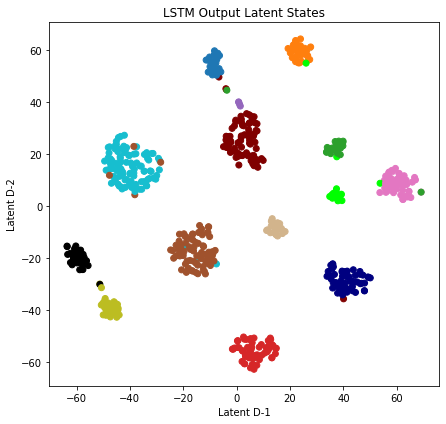

In [23]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create a colour code cycler e.g. 'C0', 'C1', etc.
# from itertools import cycle
# colour_codes = map('C{}'.format, cycle(range(24)))
# class_colors = np.array([next(colour_codes) for _ in range(24)])  # b, o, g, r
# class_colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])
class_colors = np.array(['tab:blue', 'tab:red', 'tab:green', 'tab:pink','tab:cyan','tab:orange',
                         'tab:olive','tab:purple','maroon', 'lime', 'navy', 'sienna', 'tan', 'black', 'grey'])

TEST_PERPLEXITY = [10]
X = X_rates[c_l]
_y = rule[c_l].astype(int)
tmp = _y
_yu = np.unique(_y)
for i in range(len(tmp)):
    _y[i] = np.where(_yu == tmp[i])[0][0]

fig = plt.figure(figsize=(18, 6))
def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('Latent D-1')
    plt.ylabel('Latent D-2')
    plt.title(title)
    ax = plt.gca()

# First plot a t-SNE on the input data. Precede TSNE with a PCA.
pca = PCA(n_components=50)
pca_values = pca.fit_transform(X.reshape([-1, np.prod(X.shape[1:])]))
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY[-1])
tsne_values = tsne_model.fit_transform(pca_values)
# plt.subplot(1, 3, 1)
# plot_tsne(tsne_values, _y.ravel(), TEST_PERPLEXITY[-1], title='Input Firing Rates')

# Let's create a version of our CNN model that goes from input all the way to the 200-D flatten layer
output_layer = -5
tbs = 30  # tsne batch size
truncated_model = tf.keras.Model(model.input, model.layers[output_layer].output)
flattened_output = []
for start_ix in range(0, X.shape[0], tbs):
#     flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, MAX_OFFSET:, :].astype(np.float32)[:, :, :, None]))
    flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, :, :].astype(np.float32)))
flattened_output = tf.concat(flattened_output, 0)
tf.keras.backend.clear_session()

for p_ix, perplexity in enumerate(TEST_PERPLEXITY):
    # Initialize and fit our TSNE
    pca = PCA(n_components=30)
    pca_values = pca.fit_transform(flattened_output)
    tsne_model = TSNE(n_components=2, perplexity=perplexity)
    tsne_values = tsne_model.fit_transform(pca_values)
    
    plt.subplot(1, 3, p_ix + 2)
    plot_tsne(tsne_values, _y.ravel(), perplexity, title='LSTM Output Latent States')

plt.tight_layout()
# plt.savefig("rule_decode_latent.svg")

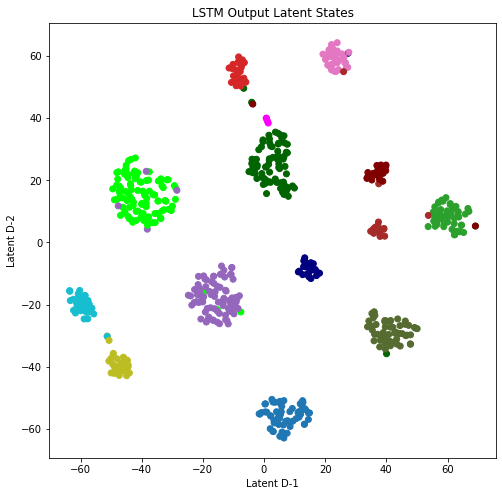

In [24]:
fig = plt.figure(figsize=(8, 8))
class_colors = np.array(['tab:red', 'tab:blue', 'maroon','tab:green', 'lime', 'tab:pink','tab:olive','magenta','darkgreen', 'brown','darkolivegreen',
                         'tab:purple', 'navy',  'tab:cyan', 'black', 'grey'])
plot_tsne(tsne_values, _y.ravel(), perplexity, title='LSTM Output Latent States')
# plt.savefig("rule_decode_latent_2.svg")

In [131]:
pca_values.shape

(609, 30)

In [129]:
to_save = {'pca': pca_values,
          'tsne': tsne_values,
          'labels': _y,
          'colors': class_colors}
with open('rule_lstm_latent.pkl', 'wb') as f:
    pickle.dump(to_save, f)

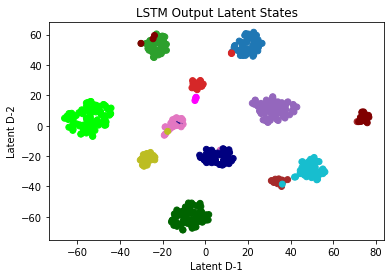

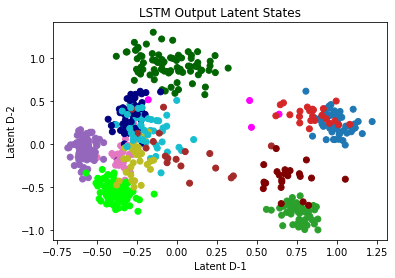

In [13]:
def plot_tsne(x_vals, y_vals, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('Latent D-1')
    plt.ylabel('Latent D-2')
    plt.title(title)
    ax = plt.gca()

with open('rule_lstm_latent.pkl', 'rb') as f:
    a = pickle.load(f)
tsne = a['tsne']
pca = a['pca']
label = a['labels']
class_colors = a['colors']
plot_tsne(tsne, label.ravel(), title='LSTM Output Latent States')
plt.figure()
plot_tsne(pca, label.ravel(), title='LSTM Output Latent States')

In [68]:
tsne_mean = np.zeros((13, 2))
dist_tsne2 = np.zeros((13,13))
for i in range(13):
    tsne_mean[i] = np.mean(tsne[np.argwhere(label==i).ravel()], axis=0)
for i in range(13):
    for j in range(13):
        if j != i: dist_tsne2[i,j] = np.sqrt(np.square(tsne_mean[i,0]-tsne_mean[j,0])+np.square(tsne_mean[i,1]-tsne_mean[j,1]))

In [71]:
np.mean(dist_tsne2)

56.96745086664662

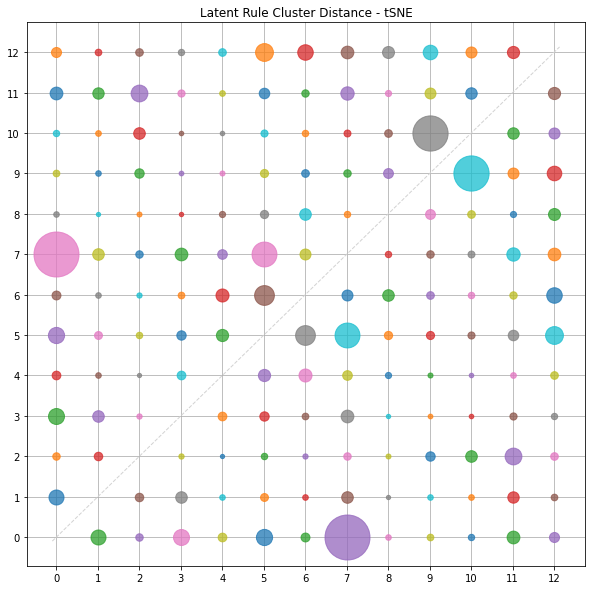

In [74]:
plt.figure(figsize=(10,10))
for i in range(13):
    for j in range(13):
        if j != i:
            plt.plot(i, j, marker=".", markersize=1000/dist_tsne2[i,j], alpha=0.75)
x=[-.1, 12.13]
y=[-.1, 12.13]
plt.plot(x, y, color='lightgrey', linestyle='dashed', linewidth=1)
p = range(13)
plt.xticks(p,p)
plt.yticks(p,p)
plt.grid()
plt.title('Latent Rule Cluster Distance - tSNE')
plt.savefig('latent_rule_distance_tSNE2.svg')

In [10]:
idx=[]
for i, l in enumerate(label):
    if (l==0) or (l==1):
        idx.append(i)

In [14]:
print(idx)
print(label[idx])
print(pca.shape, tsne.shape)

[1, 4, 5, 6, 9, 10, 11, 14, 15, 18, 19, 20, 24, 25, 28, 32, 35, 37, 41, 44, 45, 49, 50, 52, 54, 59, 60, 62, 65, 68, 69, 70, 127, 128, 132, 133, 134, 135, 136, 137, 138, 139, 142, 143, 146, 147, 153, 154, 156, 157, 159, 160, 162, 163, 164, 166, 168, 169, 171, 424, 426, 427, 428, 431, 433, 436, 437, 440, 441, 442, 443, 446, 451, 452, 453, 454, 455, 456, 458, 460, 462, 463]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
(609, 30) (609, 2)


In [20]:
label[idx]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

# Distance of Rule clusters

In [21]:
from sklearn.metrics.cluster import calinski_harabasz_score as chs
dist_pca=np.zeros((13,13))
dist_tsne = np.zeros((13,13))
for i in range(13):
    for j in range(13):
        if j==i: continue
        idx=[]
        for k, l in enumerate(label):
            if (l==i) or (l==j):
                idx.append(k)
        dist_pca[i,j] = chs(pca[idx], label[idx])
        dist_tsne[i,j] = chs(tsne[idx], label[idx])

In [29]:
np.mean(dist_pca)

247.3319008089289

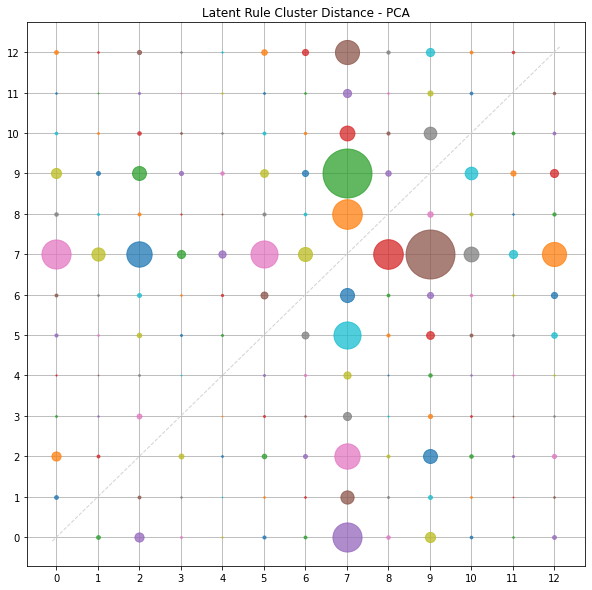

In [53]:
plt.figure(figsize=(10,10))
for i in range(13):
    for j in range(13):
        if j != i:
            plt.plot(i, j, marker=".", markersize=1400/dist_pca[i,j], alpha=0.75)
x=[-.1, 12.13]
y=[-.1, 12.13]
plt.plot(x, y, color='lightgrey', linestyle='dashed', linewidth=1)
p = range(13)
plt.xticks(p,p)
plt.yticks(p,p)
plt.grid()
plt.title('Latent Rule Cluster Distance - PCA')
plt.savefig('latent_rule_distance_PCA.svg')

Text(0.5, 1.0, 'Latent Rule Cluster Distance - t-SNE')

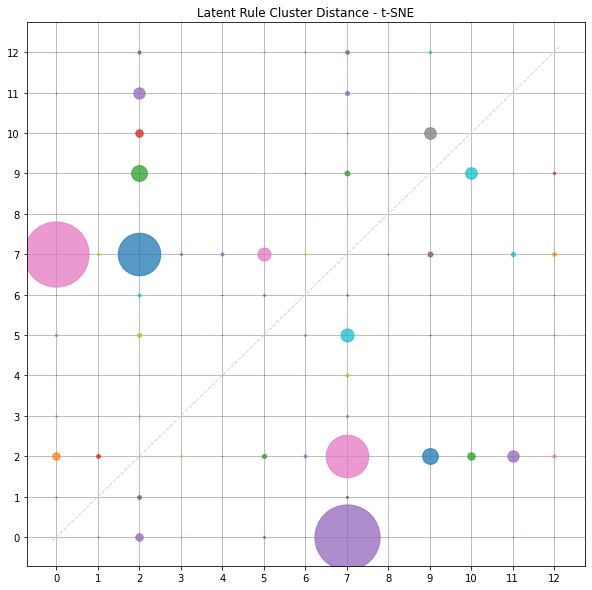

In [57]:
plt.figure(figsize=(10,10))
for i in range(13):
    for j in range(13):
        if j != i:
            plt.plot(i, j, marker=".", markersize=1000/dist_tsne[i,j], alpha=0.75)
x=[-.1, 12.13]
y=[-.1, 12.13]
plt.plot(x, y, color='lightgrey', linestyle='dashed', linewidth=1)
p = range(13)
plt.xticks(p,p)
plt.yticks(p,p)
plt.grid()
plt.title('Latent Rule Cluster Distance - t-SNE')
# plt.savefig('latent_rule_distance_tSNE.svg')

In [144]:
import pandas as pd


df = pd.DataFrame(dist).T
df.to_excel(excel_writer = "G:/Projects/MonkeyPFCSaccadeStudies/latent_distance.xlsx")

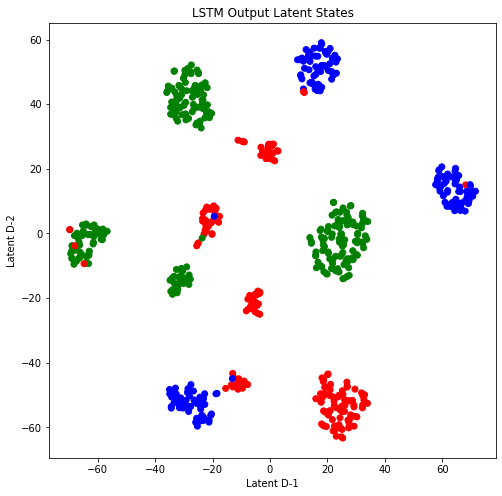

In [78]:
fig = plt.figure(figsize=(8, 8))
class_colors = np.array(['red', 'blue', 'red','green', 'green', 'red','green','red','green', 'red','blue',
                         'red', 'blue',  'black', 'grey'])
plot_tsne(tsne_values, _y.ravel(), perplexity, title='LSTM Output Latent States')
plt.savefig("rule_decode_latent_3.svg")

In [68]:
_yu

array([ 0,  2,  3,  4,  7,  9, 10, 12, 13, 15, 17, 18, 23])

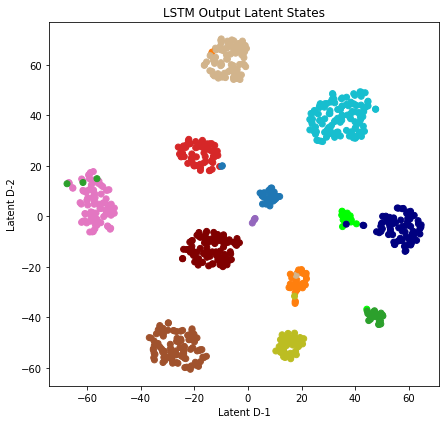

In [41]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create a colour code cycler e.g. 'C0', 'C1', etc.
# from itertools import cycle
# colour_codes = map('C{}'.format, cycle(range(24)))
# class_colors = np.array([next(colour_codes) for _ in range(24)])  # b, o, g, r
# class_colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])
class_colors = np.array(['tab:blue', 'tab:red', 'tab:green', 'tab:pink','tab:cyan','tab:orange',
                         'tab:olive','tab:purple','maroon', 'lime', 'navy', 'sienna', 'tan', 'black', 'grey'])

TEST_PERPLEXITY = [10]
X = X_rates[c_l]
_y = rule[c_l].astype(int)
tmp = _y
_yu = np.unique(_y)
for i in range(len(tmp)):
    _y[i] = np.where(_yu == tmp[i])[0][0]

fig = plt.figure(figsize=(18, 6))
def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('Latent D-1')
    plt.ylabel('Latent D-2')
    plt.title(title)
    ax = plt.gca()

# First plot a t-SNE on the input data. Precede TSNE with a PCA.
pca = PCA(n_components=50)
pca_values = pca.fit_transform(X.reshape([-1, np.prod(X.shape[1:])]))
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY[-1])
tsne_values = tsne_model.fit_transform(pca_values)
# plt.subplot(1, 3, 1)
# plot_tsne(tsne_values, _y.ravel(), TEST_PERPLEXITY[-1], title='Input Firing Rates')

# Let's create a version of our CNN model that goes from input all the way to the 200-D flatten layer
output_layer = -5
tbs = 30  # tsne batch size
truncated_model = tf.keras.Model(model.input, model.layers[output_layer].output)
flattened_output = []
for start_ix in range(0, X.shape[0], tbs):
#     flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, MAX_OFFSET:, :].astype(np.float32)[:, :, :, None]))
    flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, :, :].astype(np.float32)))
flattened_output = tf.concat(flattened_output, 0)
tf.keras.backend.clear_session()

for p_ix, perplexity in enumerate(TEST_PERPLEXITY):
    # Initialize and fit our TSNE
    pca = PCA(n_components=30)
    pca_values = pca.fit_transform(flattened_output)
    tsne_model = TSNE(n_components=2, perplexity=perplexity)
    tsne_values = tsne_model.fit_transform(pca_values)
    
    plt.subplot(1, 3, p_ix + 2)
    plot_tsne(tsne_values, _y.ravel(), perplexity, title='LSTM Output Latent States')

plt.tight_layout()
plt.savefig("rule_decode_latent.svg")

In [54]:
rl = np.array(np.where((rule==3)|(rule==4))).flatten()
c_l_rl = []
ic_ul_rl = []
for r in rl:
    if r in c_l:
        c_l_rl.append(r)
    elif r in ic_ul:
        ic_ul_rl.append(r)
print(np.unique(color[c_l_rl], return_counts=True))
print(np.unique(color[ic_ul_rl], return_counts=True))

(array([0], dtype=int64), array([113], dtype=int64))
(array([9], dtype=int64), array([15], dtype=int64))


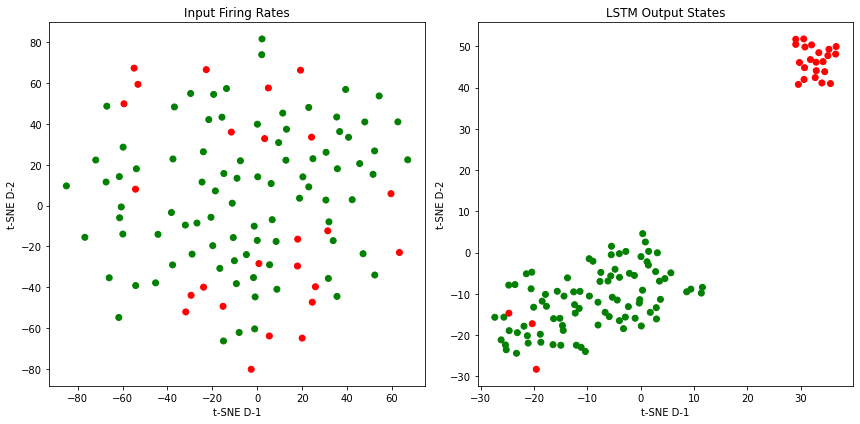

In [305]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(24)))
class_colors = np.array([next(colour_codes) for _ in range(24)])  # b, o, g, r
class_colors = np.array(['b', 'c', 'y','r', 'g',  'm', 'k', 'w'])

TEST_PERPLEXITY = [10]
X = X_rates[c_l_rl]
_y = rule[c_l_rl].astype(int)

fig = plt.figure(figsize=(18, 6))
def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('t-SNE D-1')
    plt.ylabel('t-SNE D-2')
    plt.title(title)
    ax = plt.gca()

# First plot a t-SNE on the input data. Precede TSNE with a PCA.
pca = PCA(n_components=50)
pca_values = pca.fit_transform(X.reshape([-1, np.prod(X.shape[1:])]))
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY[-1])
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(1, 3, 1)
plot_tsne(tsne_values, _y.ravel(), TEST_PERPLEXITY[-1], title='Input Firing Rates')

# Let's create a version of our CNN model that goes from input all the way to the 200-D flatten layer
output_layer = -5
tbs = 30  # tsne batch size
truncated_model = tf.keras.Model(model.input, model.layers[output_layer].output)
flattened_output = []
for start_ix in range(0, X.shape[0], tbs):
#     flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, MAX_OFFSET:, :].astype(np.float32)[:, :, :, None]))
    flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, :, :].astype(np.float32)))
flattened_output = tf.concat(flattened_output, 0)
tf.keras.backend.clear_session()

for p_ix, perplexity in enumerate(TEST_PERPLEXITY):
    # Initialize and fit our TSNE
    pca = PCA(n_components=30)
    pca_values = pca.fit_transform(flattened_output)
    tsne_model = TSNE(n_components=2, perplexity=perplexity)
    tsne_values = tsne_model.fit_transform(pca_values)
    
    plt.subplot(1, 3, p_ix + 2)
    plot_tsne(tsne_values, _y.ravel(), perplexity, title='LSTM Output States')

plt.tight_layout()

In [275]:
tsne_learned = np.zeros((len(c_l_rl), len(times)//10, 2))
tsne_unlearned = np.zeros((len(ic_ul_rl), len(times)//10, 2))
pca = PCA(n_components=30)
tsne_model = TSNE(n_components=2, perplexity=perplexity)
for t in range(1,len(times)//10):
    _X = X_rates[c_l_rl]
    _X[:,:,10*t:] = 0
    flattened_output = []
    for start_ix in range(0, _X.shape[0], tbs):
        flattened_output.append(truncated_model(_X[start_ix:start_ix+tbs, :, :].astype(np.float32)))
    flattened_output = tf.concat(flattened_output, 0)
    tf.keras.backend.clear_session()
    pca_values = pca.fit_transform(flattened_output)
    tsne_learned[:,t,:] = tsne_model.fit_transform(pca_values)
pca = PCA(n_components=10)
tsne_model = TSNE(n_components=2, perplexity=perplexity)
for t in range(1,len(times)//10):
    _X = X_rates[ic_ul_rl]
    _X[:,:,10*t:] = 0
    flattened_output = []
    for start_ix in range(0, _X.shape[0], tbs):
        flattened_output.append(truncated_model(_X[start_ix:start_ix+tbs, :, :].astype(np.float32)))
    flattened_output = tf.concat(flattened_output, 0)
    tf.keras.backend.clear_session()
    pca_values = pca.fit_transform(flattened_output)
    tsne_unlearned[:,t,:] = tsne_model.fit_transform(pca_values)

In [283]:
print(rule[c_l_rl][87],rule[c_l_rl][88])
print(rule[ic_ul_rl][9],rule[ic_ul_rl][10])

4 3
4 3


In [296]:
green_m = np.mean(tsne_learned[:88], axis=0)
red_m = np.mean(tsne_learned[88:], axis=0)
green_v = np.var(tsne_learned[:88], axis=0)
red_v = np.var(tsne_learned[88:], axis=0)

Text(0, 0.5, 'Latent 0')

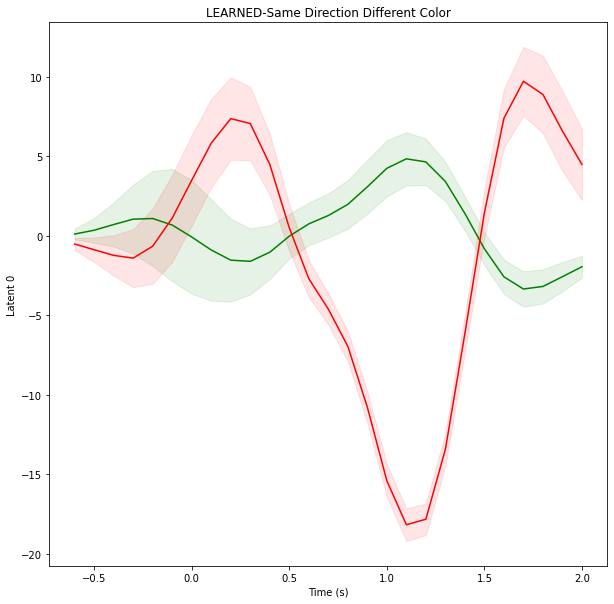

In [297]:
from scipy import signal
kernel = 0.1*signal.gaussian(10, 2)
fig = plt.figure(figsize=(10,10))
t=times[::10][:-1]
g_m_s0 = signal.fftconvolve(np.squeeze(green_m[:,0]), kernel, mode='same')
r_m_s0 = signal.fftconvolve(np.squeeze(red_m[:,0]), kernel, mode='same')
g_v_s0 = signal.fftconvolve(np.squeeze(green_v[:,0]), kernel, mode='same')/500
r_v_s0 = signal.fftconvolve(np.squeeze(red_v[:,0]), kernel, mode='same')/500
plt.plot(t, g_m_s0, 'g')
plt.fill_between(t, g_m_s0-g_v_s0, g_m_s0+g_v_s0, alpha=0.1, color='g')
plt.plot(t, r_m_s0, 'r')
plt.fill_between(t, r_m_s0-r_v_s0, r_m_s0+r_v_s0, alpha=0.1, color='r')
# plt.ylim(-50,50)
plt.title('LEARNED-Same Direction Different Color')
plt.xlabel('Time (s)')
plt.ylabel('Latent 0')

Text(0, 0.5, 'Latent 1')

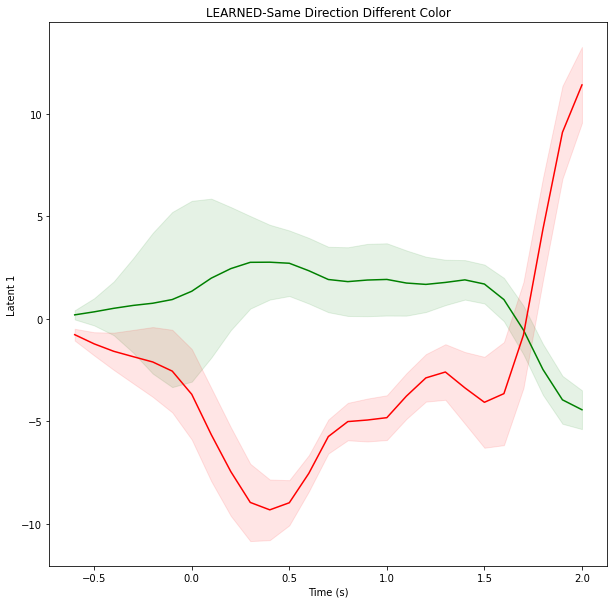

In [298]:
fig = plt.figure(figsize=(10,10))
t=times[::10][:-1]
g_m_s1 = signal.fftconvolve(np.squeeze(green_m[:,1]), kernel, mode='same')
r_m_s1 = signal.fftconvolve(np.squeeze(red_m[:,1]), kernel, mode='same')
g_v_s1 = signal.fftconvolve(np.squeeze(green_v[:,1]), kernel, mode='same')/500
r_v_s1 = signal.fftconvolve(np.squeeze(red_v[:,1]), kernel, mode='same')/500
plt.plot(t, g_m_s1, 'g')
plt.fill_between(t, g_m_s1-g_v_s1, g_m_s1+g_v_s1, alpha=0.1, color='g')
plt.plot(t, r_m_s1, 'r')
plt.fill_between(t, r_m_s1-r_v_s1, r_m_s1+r_v_s1, alpha=0.1, color='r')
# plt.ylim(-50,50)
plt.title('LEARNED-Same Direction Different Color')
plt.xlabel('Time (s)')
plt.ylabel('Latent 1')

Text(0.5, 1.0, 'LEARNED-Same Direction Different Color Trajectory')

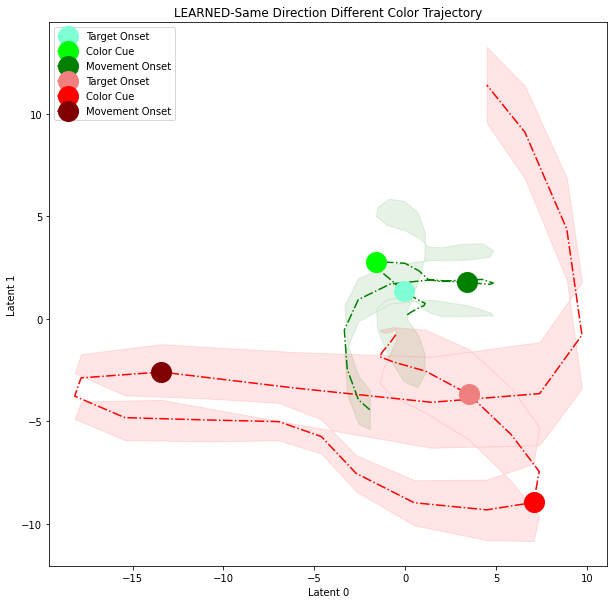

In [299]:
fig = plt.figure(figsize=(10,10))
plt.plot(g_m_s0,g_m_s1, 'g-.')
plt.fill_between(g_m_s0, g_m_s1-g_v_s1, g_m_s1+g_v_s1, alpha=0.1, color='g')
plt.plot(g_m_s0[6], g_m_s1[6], markersize=20,marker='o',color='aquamarine', label='Target Onset')
plt.plot(g_m_s0[9], g_m_s1[9],markersize=20, marker='o',color='lime', label='Color Cue')
plt.plot(g_m_s0[19], g_m_s1[19],markersize=20, marker='o',color='green', label='Movement Onset')
plt.plot(r_m_s0,r_m_s1, 'r-.')
plt.fill_between(r_m_s0, r_m_s1-r_v_s1, r_m_s1+r_v_s1, alpha=0.1, color='r')
plt.plot(r_m_s0[6], r_m_s1[6],markersize=20,marker='o',color='lightcoral', label='Target Onset')
plt.plot(r_m_s0[9], r_m_s1[9], markersize=20,marker='o',color='red', label='Color Cue')
plt.plot(r_m_s0[19], r_m_s1[19], markersize=20,marker='o',color='maroon', label='Movement Onset')
plt.legend()
plt.xlabel('Latent 0')
plt.ylabel('Latent 1')
plt.title('LEARNED-Same Direction Different Color Trajectory')

In [292]:
green_m = np.mean(tsne_unlearned[:10], axis=0)
red_m = np.mean(tsne_unlearned[10:], axis=0)
green_v = np.var(tsne_unlearned[:10], axis=0)
red_v = np.var(tsne_unlearned[10:], axis=0)

Text(0, 0.5, 'Latent 0')

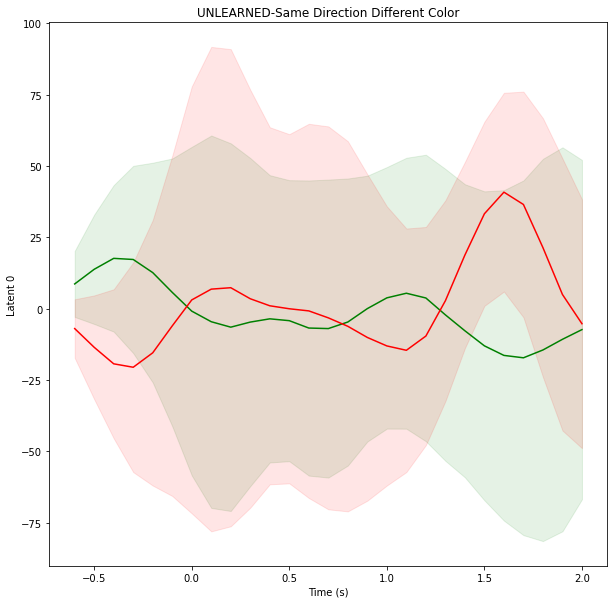

In [293]:
from scipy import signal
kernel = 0.1*signal.gaussian(10, 2)
fig = plt.figure(figsize=(10,10))
t=times[::10][:-1]
g_m_s0 = signal.fftconvolve(np.squeeze(green_m[:,0]), kernel, mode='same')
r_m_s0 = signal.fftconvolve(np.squeeze(red_m[:,0]), kernel, mode='same')
g_v_s0 = signal.fftconvolve(np.squeeze(green_v[:,0]), kernel, mode='same')/500
r_v_s0 = signal.fftconvolve(np.squeeze(red_v[:,0]), kernel, mode='same')/500
plt.plot(t, g_m_s0, 'g')
plt.fill_between(t, g_m_s0-g_v_s0, g_m_s0+g_v_s0, alpha=0.1, color='g')
plt.plot(t, r_m_s0, 'r')
plt.fill_between(t, r_m_s0-r_v_s0, r_m_s0+r_v_s0, alpha=0.1, color='r')
# plt.ylim(-50,50)
plt.title('UNLEARNED-Same Direction Different Color')
plt.xlabel('Time (s)')
plt.ylabel('Latent 0')

Text(0, 0.5, 'Latent 1')

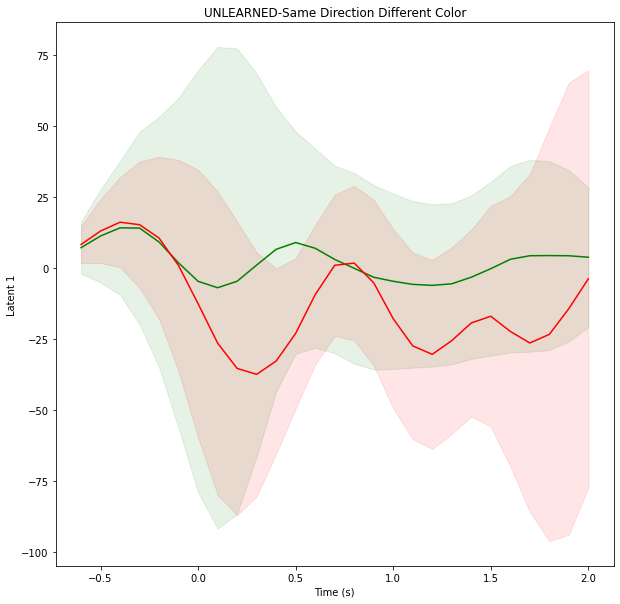

In [294]:
fig = plt.figure(figsize=(10,10))
t=times[::10][:-1]
g_m_s1 = signal.fftconvolve(np.squeeze(green_m[:,1]), kernel, mode='same')
r_m_s1 = signal.fftconvolve(np.squeeze(red_m[:,1]), kernel, mode='same')
g_v_s1 = signal.fftconvolve(np.squeeze(green_v[:,1]), kernel, mode='same')/500
r_v_s1 = signal.fftconvolve(np.squeeze(red_v[:,1]), kernel, mode='same')/500
plt.plot(t, g_m_s1, 'g')
plt.fill_between(t, g_m_s1-g_v_s1, g_m_s1+g_v_s1, alpha=0.1, color='g')
plt.plot(t, r_m_s1, 'r')
plt.fill_between(t, r_m_s1-r_v_s1, r_m_s1+r_v_s1, alpha=0.1, color='r')
# plt.ylim(-50,50)
plt.title('UNLEARNED-Same Direction Different Color')
plt.xlabel('Time (s)')
plt.ylabel('Latent 1')

Text(0.5, 1.0, 'UNLEARNED-Same Direction Different Color Trajectory')

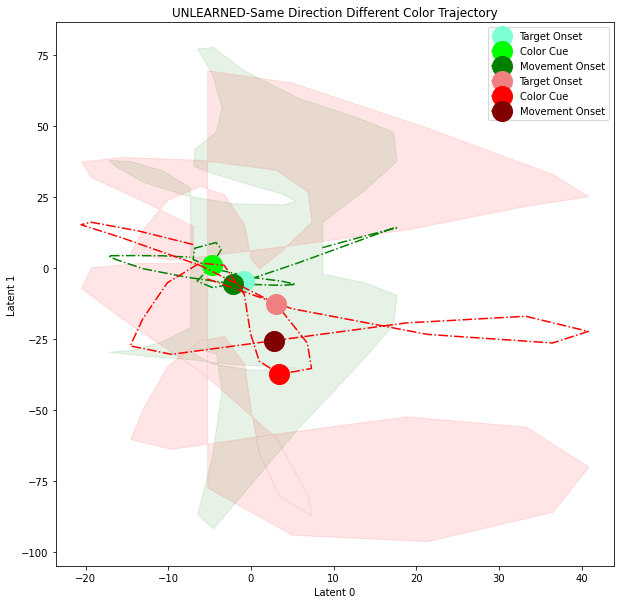

In [295]:
fig = plt.figure(figsize=(10,10))
plt.plot(g_m_s0,g_m_s1, 'g-.')
plt.fill_between(g_m_s0, g_m_s1-g_v_s1, g_m_s1+g_v_s1, alpha=0.1, color='g')
plt.plot(g_m_s0[6], g_m_s1[6], markersize=20,marker='o',color='aquamarine', label='Target Onset')
plt.plot(g_m_s0[9], g_m_s1[9],markersize=20, marker='o',color='lime', label='Color Cue')
plt.plot(g_m_s0[19], g_m_s1[19],markersize=20, marker='o',color='green', label='Movement Onset')
plt.plot(r_m_s0,r_m_s1, 'r-.')
plt.fill_between(r_m_s0, r_m_s1-r_v_s1, r_m_s1+r_v_s1, alpha=0.1, color='r')
plt.plot(r_m_s0[6], r_m_s1[6],markersize=20,marker='o',color='lightcoral', label='Target Onset')
plt.plot(r_m_s0[9], r_m_s1[9], markersize=20,marker='o',color='red', label='Color Cue')
plt.plot(r_m_s0[19], r_m_s1[19], markersize=20,marker='o',color='maroon', label='Movement Onset')
plt.legend()
plt.xlabel('Latent 0')
plt.ylabel('Latent 1')
plt.title('UNLEARNED-Same Direction Different Color Trajectory')

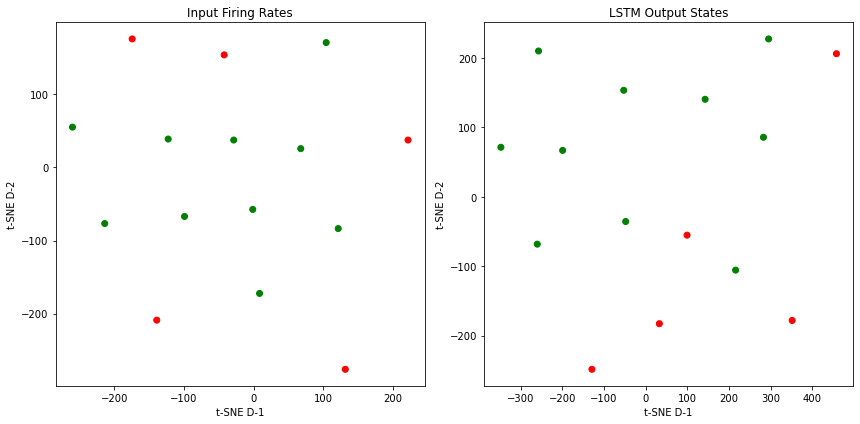

In [303]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(24)))
class_colors = np.array([next(colour_codes) for _ in range(24)])  # b, o, g, r
class_colors = np.array(['b', 'c', 'y','r', 'g',  'm', 'k', 'w'])

TEST_PERPLEXITY = [10]
X = X_rates[ic_ul_rl]
_y = rule[ic_ul_rl].astype(int)

fig = plt.figure(figsize=(18, 6))
def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('t-SNE D-1')
    plt.ylabel('t-SNE D-2')
    plt.title(title)
    ax = plt.gca()

# First plot a t-SNE on the input data. Precede TSNE with a PCA.
pca = PCA(n_components=10)
pca_values = pca.fit_transform(X.reshape([-1, np.prod(X.shape[1:])]))
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY[-1])
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(1, 3, 1)
plot_tsne(tsne_values, _y.ravel(), TEST_PERPLEXITY[-1], title='Input Firing Rates')

# Let's create a version of our CNN model that goes from input all the way to the 200-D flatten layer
output_layer = -5
tbs = 30  # tsne batch size
truncated_model = tf.keras.Model(model.input, model.layers[output_layer].output)
flattened_output = []
for start_ix in range(0, X.shape[0], tbs):
#     flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, MAX_OFFSET:, :].astype(np.float32)[:, :, :, None]))
    flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, :, :].astype(np.float32)))
flattened_output = tf.concat(flattened_output, 0)
tf.keras.backend.clear_session()

for p_ix, perplexity in enumerate(TEST_PERPLEXITY):
    # Initialize and fit our TSNE
    pca = PCA(n_components=10)
    pca_values = pca.fit_transform(flattened_output)
    tsne_model = TSNE(n_components=2, perplexity=perplexity)
    tsne_values = tsne_model.fit_transform(pca_values)
    
    plt.subplot(1, 3, p_ix + 2)
    plot_tsne(tsne_values, _y.ravel(), perplexity, title='LSTM Output States')

plt.tight_layout()

# Firing Rates

In [6]:
rule1 = 9
rule2 = 10

In [7]:
rl = np.array(np.where((rule==rule1)|(rule==rule2))).flatten()
l_rl = []
ul_rl = []
for r in rl:
    if r in learned:
        l_rl.append(r)
    elif r in unlearned:
        ul_rl.append(r)
print(np.unique(color[l_rl], return_counts=True))
print(np.unique(color[ul_rl], return_counts=True))

NameError: name 'rule' is not defined

In [66]:
rl = np.array(np.where((rule==rule1)|(rule==rule2))).flatten()
l_rl = []
ul_rl = []
for r in rl:
    if r in c_l:
        l_rl.append(r)
    elif r in ic_ul:
        ul_rl.append(r)
print(np.unique(color[l_rl], return_counts=True))
print(np.unique(color[ul_rl], return_counts=True))

(array(['b', 'r'], dtype=object), array([21, 33], dtype=int64))
(array(['b', 'r'], dtype=object), array([ 7, 24], dtype=int64))


In [9]:
tmp = rule[l_rl]
_y_l = np.zeros_like(tmp)
for i in range(len(tmp)):
    if (tmp[i]==rule2):
        _y_l[i]=1
tmp = rule[ul_rl]
_y_ul = np.zeros_like(tmp)
for i in range(len(tmp)):
    if (tmp[i]==rule2):
        _y_ul[i]=1

In [10]:
with open('traj_y_l.pkl', 'wb') as f:
    pickle.dump(_y_l, f)
with open('traj_y_ul.pkl', 'wb') as f:
    pickle.dump(_y_ul, f)

In [94]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

step = 20
length = len(times[::step])

_X = np.transpose(X_rates, (0, 2, 1))
# _X = X_rates

def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('Latent D-1')
    plt.ylabel('Latent D-2')
    plt.title(title)
    ax = plt.gca()
class_colors = np.array(['tab:red', 'tab:green', 'tab:blue', 'tab:pink','tab:cyan','tab:orange',
                         'tab:olive','tab:purple','maroon', 'lime', 'navy', 'sienna', 'tan', 'black', 'grey'])

TEST_PERPLEXITY = [10]
X = _X[l_rl]

traj_l = np.zeros((X.shape[0], length, 2))

pca = PCA(n_components=16)
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY[-1])
for t in np.arange(1,length):
    tmp = X[:, :step*t, :]
    pca_values = pca.fit_transform(tmp.reshape([-1, np.prod(tmp.shape[1:])]))
    traj_l[:,t,:] = tsne_model.fit_transform(pca_values)
    
X = _X[ul_rl]
traj_ul = np.zeros((X.shape[0], length, 2))

pca = PCA(n_components=16)
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY[-1])
for t in np.arange(1,length):
    tmp = X[:, :step*t, :]
    pca_values = pca.fit_transform(tmp.reshape([-1, np.prod(tmp.shape[1:])]))
    traj_ul[:,t,:] = tsne_model.fit_transform(pca_values)
print('Done')

Done


In [4]:
with open('traj_l.pkl', 'wb') as f:
    pickle.dump(traj_l, f)
with open('traj_ul.pkl', 'wb') as f:
    pickle.dump(traj_ul, f)

NameError: name 'traj_l' is not defined

In [5]:
with open('traj_l.pkl', 'rb') as f:
    traj_l = pickle.load(f)
with open('traj_ul.pkl', 'rb') as f:
    traj_ul = pickle.load(f)
    
with open('traj_y_l.pkl', 'rb') as f:
    _y_l = pickle.load(f)
with open('traj_y_ul.pkl', 'rb') as f:
    _y_ul = pickle.load(f)

EOFError: Ran out of input

In [40]:
with open('sep_score_l_m74.pkl', 'rb') as f:
    sep_score_l = np.array(pickle.load(f))
with open('sep_score_ul_m74.pkl', 'rb') as f:
    sep_score_ul = np.array(pickle.load(f))

In [59]:
sep_score_l.shape

(100, 5)

In [69]:
err_l=np.zeros(8)
err_l[0] = np.std(sep_score_l[:, 1])
err_l[1] = np.std(sep_score_l[:, 2])
err_l[2] = np.std(sep_score_l[:20, 3])
err_l[3] = np.std(sep_score_l[20:40, 3])
err_l[4] = np.std(sep_score_l[40:60, 3])
err_l[5] = np.std(sep_score_l[60:80, 3])
err_l[6] = np.std(sep_score_l[80:100, 3])
err_l[7] = np.std(sep_score_l[:, 4])

err_ul=np.zeros(8)
err_ul[0] = np.std(sep_score_ul[:, 1])
err_ul[1] = np.std(sep_score_ul[:, 2])
err_ul[2] = np.std(sep_score_ul[:20, 3])
err_ul[3] = np.std(sep_score_ul[20:40, 3])
err_ul[4] = np.std(sep_score_ul[40:60, 3])
err_ul[5] = np.std(sep_score_ul[60:80, 3])
err_ul[6] = np.std(sep_score_ul[80:100, 3])
err_ul[7] = np.std(sep_score_ul[:, 4])

In [53]:
times[::31].shape

(9,)

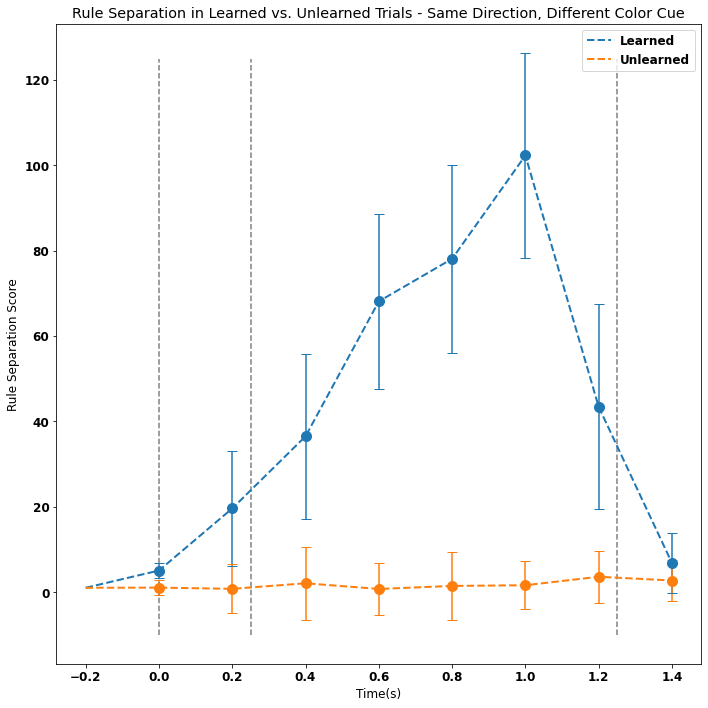

In [77]:
from sklearn.metrics.cluster import calinski_harabasz_score as chs
step=200
font = {'weight'   : 'bold',
       'size': 12}

matplotlib.rc('font', **font)
score_l = np.zeros(traj_l.shape[1])
score_ul = np.zeros(traj_ul.shape[1])
for i in range(len(score_l)):
    score_l[i] = chs(np.squeeze(traj_l[:,i,:]), _y_l)
    score_ul[i] = chs(np.squeeze(traj_ul[:,i,:]), _y_ul)
fig = plt.figure(figsize=(10,10))
t = times[::step]
plt.plot(t, score_l, lw=2,ls='dashed',label='Learned')
p = t[1:]
plt.errorbar(p, score_l[1:], yerr=err_l, fmt='.', markersize='20', capsize=5, color='tab:blue')
plt.plot(t, score_ul, lw=2,ls='dashed',label='Unlearned')
plt.errorbar(p, score_ul[1:], yerr=err_ul, fmt='.', markersize='20', capsize=5, color='tab:orange')
plt.vlines(0, -10, 125, ls='dashed', color='grey')
plt.vlines(0.25, -10, 125, ls='dashed', color='grey')
plt.vlines(1.25, -10, 125, ls='dashed', color='grey')
plt.title('Rule Separation in Learned vs. Unlearned Trials - Same Direction, Different Color Cue')
plt.xlabel('Time(s)')
plt.ylabel('Rule Separation Score')
plt.legend()
plt.tight_layout()
plt.savefig("rule_separation_score.svg")

Text(0, 0.5, 'Latent 2')

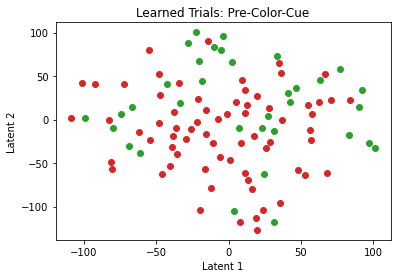

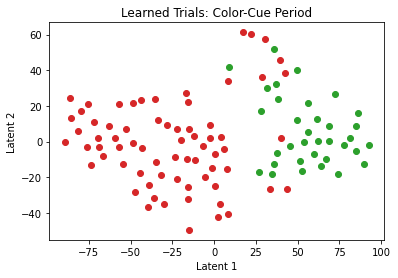

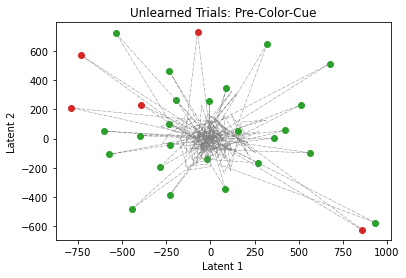

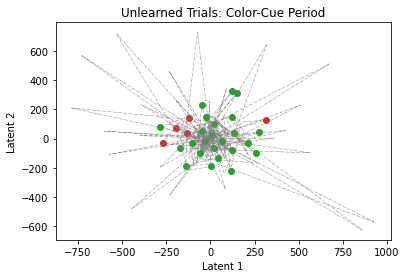

In [13]:
color=['tab:red', 'tab:green']
plt.figure()
for i in range(len(_y_l)):
#     plt.plot(np.squeeze(traj_l[i,:,0]), np.squeeze(traj_l[i,:,1]), ls='-.', color='grey', lw=0.5)
    plt.plot(np.squeeze(traj_l[i,1,0]), np.squeeze(traj_l[i,1,1]), 'o', color=color[_y_l[i]], lw=1)
plt.title('Learned Trials: Pre-Color-Cue')
plt.xlabel('Latent 1')
plt.ylabel('Latent 2')
# plt.ylim(-100,100)
# plt.xlim(-100,100)
plt.savefig("learned_pre_color_period.svg")
plt.figure()
for i in range(len(_y_l)):
#     plt.plot(np.squeeze(traj_l[i,:,0]), np.squeeze(traj_l[i,:,1]), ls='-.', color='grey', lw=0.5)
    plt.plot(np.squeeze(traj_l[i,6,0]), np.squeeze(traj_l[i,6,1]), 'o', color=color[_y_l[i]], lw=1)
plt.title('Learned Trials: Color-Cue Period')
plt.xlabel('Latent 1')
plt.ylabel('Latent 2')
# plt.ylim(-100,100)
# plt.xlim(-100,100)
plt.savefig("learned_color_period.svg")

plt.figure()
for i in range(len(_y_ul)):
    plt.plot(np.squeeze(traj_ul[i,:,0]), np.squeeze(traj_ul[i,:,1]), ls='-.', color='grey', lw=0.5)
    plt.plot(np.squeeze(traj_ul[i,1,0]), np.squeeze(traj_ul[i,1,1]), 'o', color=color[_y_ul[i]], lw=1)
plt.title('Unlearned Trials: Pre-Color-Cue')
plt.xlabel('Latent 1')
plt.ylabel('Latent 2')
# plt.savefig("unlearned_pre_color_period.svg")
plt.figure()
for i in range(len(_y_ul)):
    plt.plot(np.squeeze(traj_ul[i,:,0]), np.squeeze(traj_ul[i,:,1]), ls='-.', color='grey', lw=0.5)
    plt.plot(np.squeeze(traj_ul[i,6,0]), np.squeeze(traj_ul[i,6,1]), 'o', color=color[_y_ul[i]], lw=1)
plt.title('Unlearned Trials: Color-Cue Period')
plt.xlabel('Latent 1')
plt.ylabel('Latent 2')
# plt.savefig("unlearned_color_period.svg")

In [110]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [60]:
np.argwhere(_y_l==0).ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68], dtype=int64)

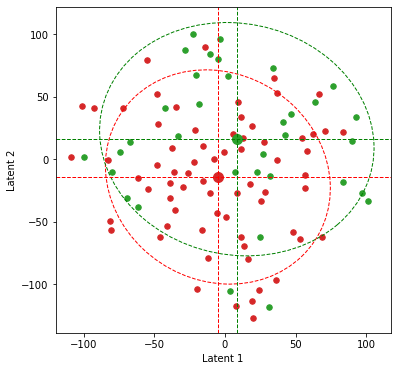

In [117]:
color=['tab:red', 'tab:green']
fig, ax_nstd = plt.subplots(figsize=(6, 6))

dependency_nstd = [[0.8, 0.75],
                   [-0.2, 0.35]]
mu = 0, 0
scale = 8, 5


x = np.squeeze(traj_l[np.argwhere(_y_l==0).ravel(),1,0])
y = np.squeeze(traj_l[np.argwhere(_y_l==0).ravel(),1,1])
ax_nstd.axvline(x=np.mean(x),c='red', lw=1, linestyle='--')
ax_nstd.axhline(y=np.mean(y),c='red', lw=1, linestyle='--')
ax_nstd.scatter(x=np.mean(x), y=np.mean(y), s=100, color='tab:red')
# x, y = get_correlated_dataset(500, dependency_nstd, mu, scale)
ax_nstd.scatter(x, y, s=30, color='tab:red')

# confidence_ellipse(x, y, ax_nstd, n_std=1,
#                    label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2, edgecolor='red', linestyle='--')
# confidence_ellipse(x, y, ax_nstd, n_std=3,
#                    label=r'$3\sigma$', edgecolor='blue', linestyle=':')
x = np.squeeze(traj_l[np.argwhere(_y_l==1).ravel(),1,0])
y = np.squeeze(traj_l[np.argwhere(_y_l==1).ravel(),1,1])
ax_nstd.axvline(x=np.mean(x),c='green', lw=1, linestyle='--')
ax_nstd.axhline(y=np.mean(y),c='green', lw=1, linestyle='--')
ax_nstd.scatter(x=np.mean(x), y=np.mean(y), s=100, color='tab:green')
# x, y = get_correlated_dataset(500, dependency_nstd, mu, scale)
ax_nstd.scatter(x, y, s=30, color='tab:green')

# confidence_ellipse(x, y, ax_nstd, n_std=1,
#                    label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2, edgecolor='green', linestyle='--')
# ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
# ax_nstd.set_title('Different standard deviations')
ax_nstd.set_xlabel("Latent 1")
ax_nstd.set_ylabel("Latent 2")
# ax_nstd.legend()
plt.savefig('latent_target.svg')

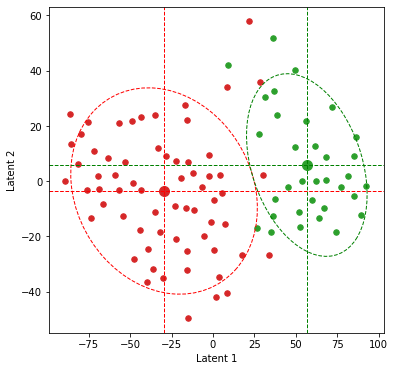

In [118]:
color=['tab:red', 'tab:green']
fig, ax_nstd = plt.subplots(figsize=(6, 6))

dependency_nstd = [[0.8, 0.75],
                   [-0.2, 0.35]]
mu = 0, 0
scale = 8, 5

# ax_nstd.axvline(c='grey', lw=1)
# ax_nstd.axhline(c='grey', lw=1)
x = np.squeeze(traj_l[np.argwhere(_y_l==0).ravel(),6,0])
x = x[np.argwhere(x<38).ravel()]
y = np.squeeze(traj_l[np.argwhere(_y_l==0).ravel(),6,1])
y = y[np.argwhere(x<38).ravel()]
ax_nstd.axvline(x=np.mean(x),c='red', lw=1, linestyle='--')
ax_nstd.axhline(y=np.mean(y),c='red', lw=1, linestyle='--')
ax_nstd.scatter(x=np.mean(x), y=np.mean(y), s=100, color='tab:red')
# x, y = get_correlated_dataset(500, dependency_nstd, mu, scale)
ax_nstd.scatter(x, y, s=30, color='tab:red')

# confidence_ellipse(x, y, ax_nstd, n_std=1,
#                    label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2, edgecolor='red', linestyle='--')
# confidence_ellipse(x, y, ax_nstd, n_std=3,
#                    label=r'$3\sigma$', edgecolor='blue', linestyle=':')
x = np.squeeze(traj_l[np.argwhere(_y_l==1).ravel(),6,0])
y = np.squeeze(traj_l[np.argwhere(_y_l==1).ravel(),6,1])
ax_nstd.axvline(x=np.mean(x),c='green', lw=1, linestyle='--')
ax_nstd.axhline(y=np.mean(y),c='green', lw=1, linestyle='--')
ax_nstd.scatter(x=np.mean(x), y=np.mean(y), s=100, color='tab:green')
# x, y = get_correlated_dataset(500, dependency_nstd, mu, scale)
ax_nstd.scatter(x, y, s=30, color='tab:green')

# confidence_ellipse(x, y, ax_nstd, n_std=1,
#                    label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2, edgecolor='green', linestyle='--')
# ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
# ax_nstd.set_title('Different standard deviations')
ax_nstd.set_xlabel("Latent 1")
ax_nstd.set_ylabel("Latent 2")
# ax_nstd.legend()
plt.savefig('latent_colorcue.svg')

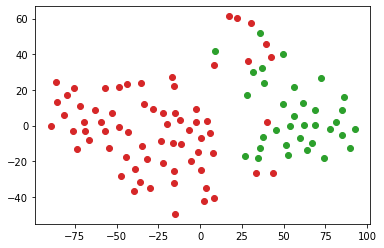

In [72]:
for i in range(len(_y_l)):
#     plt.plot(np.squeeze(traj_l[i,:,0]), np.squeeze(traj_l[i,:,1]), ls='-.', color='grey', lw=0.5)
    plt.plot(np.squeeze(traj_l[i,6,0]), np.squeeze(traj_l[i,6,1]), 'o', color=color[_y_l[i]], lw=1)

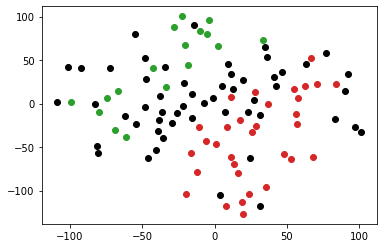

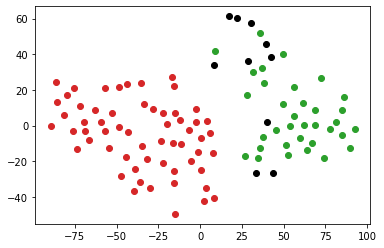

In [107]:
from sklearn.cluster import KMeans
X = np.squeeze(traj_l[:,1,:])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
l = kmeans.labels_
for i in range(len(l)):
    if l[i]==_y_l[i]:plt.plot(X[i,0], X[i,1], 'o', color=color[l[i]], lw=1)
    else: plt.plot(X[i,0], X[i,1], 'o', color='black', lw=1)

X = np.squeeze(traj_l[:,6,:])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
l = kmeans.labels_
plt.figure()
for i in range(len(l)):
    if l[i]==_y_l[i]:plt.plot(X[i,0], X[i,1], 'o', color=color[l[i]], lw=1)
    else: plt.plot(X[i,0], X[i,1], 'o', color='black', lw=1)

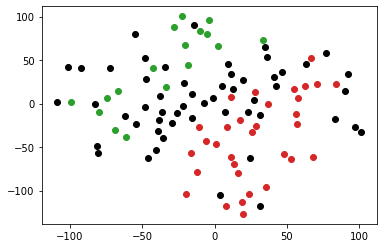

In [102]:
l[0]

'Targets'

# Rule Decoding

In [6]:
sess_infos.append ({'name': 'Marty',
                 'bank': 'A',
                 'name_short': 'm',
                 'date': '',
                 'exp_code': 'sra3_1_m_074_00+01',
                 'nsx': ''})

In [16]:
r2r_acc = np.zeros(9)
for test_sess_ix in range(9):
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    sess_id = sess_id.replace("+", "")+"_v1"
    X_rates, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
    times = np.array(ax_info['timestamps'])
    target = np.array(ax_info['instance_data']['TargetRule'])
    color = np.array(ax_info['instance_data']['CueColour'])
    rule = np.zeros(np.size(X_rates,0))
    for i in range(len(rule)):
        if (target[i]=='UU'):
            if (color[i] == 'r'):
                rule[i]=0
            elif(color[i] == 'g'):
                rule[i]=1
            else:
                rule[i]=2
        elif (target[i]=='UR'):
            if (color[i] == 'r'):
                rule[i]=3
            elif(color[i] == 'g'):
                rule[i]=4
            else:
                rule[i]=5
        elif (target[i]=='RR'):
            if (color[i] == 'r'):
                rule[i]=6
            elif(color[i] == 'g'):
                rule[i]=7
            else:
                rule[i]=8
        elif (target[i]=='DR'):
            if (color[i] == 'r'):
                rule[i]=9
            elif(color[i] == 'g'):
                rule[i]=10
            else:
                rule[i]=11
        elif (target[i]=='DD'):
            if (color[i] == 'r'):
                rule[i]=12
            elif(color[i] == 'g'):
                rule[i]=13
            else:
                rule[i]=14
        elif (target[i]=='DL'):
            if (color[i] == 'r'):
                rule[i]=15
            elif(color[i] == 'g'):
                rule[i]=16
            else:
                rule[i]=17
        elif (target[i]=='LL'):
            if (color[i] == 'r'):
                rule[i]=18
            elif(color[i] == 'g'):
                rule[i]=19
            else:
                rule[i]=20
        elif (target[i]=='UL'):
            if (color[i] == 'r'):
                rule[i]=21
            elif(color[i] == 'g'):
                rule[i]=22
            else:
                rule[i]=23
    rule = rule.astype(int)
    tmp = rule
    _yu = np.unique(rule)
    for i in range(len(tmp)):
        rule[i] = np.where(_yu == tmp[i])[0][0]
    _, r2r_acc[test_sess_ix], _, _ = kfold_pred(sess_id,X_rates,rule,name='R2R', verbose=1)

	Split 1 of 10
Epoch 1/150
1/9 [==>...........................] - ETA: 0s - loss: 2.5021 - accuracy: 0.3125
Epoch 00001: val_accuracy improved from -inf to 0.31250, saving model to R2R_sra3_2_j_037_0003_v1_split0.h5
9/9 [==============================] - 0s 46ms/step - loss: 2.4243 - accuracy: 0.2500 - val_loss: 2.1806 - val_accuracy: 0.3125
Epoch 2/150
1/9 [==>...........................] - ETA: 0s - loss: 1.9256 - accuracy: 0.6250
Epoch 00002: val_accuracy did not improve from 0.31250
9/9 [==============================] - 0s 4ms/step - loss: 1.8769 - accuracy: 0.6528 - val_loss: 2.1046 - val_accuracy: 0.3125
Epoch 3/150
1/9 [==>...........................] - ETA: 0s - loss: 1.8312 - accuracy: 0.6875
Epoch 00003: val_accuracy did not improve from 0.31250
9/9 [==============================] - 0s 4ms/step - loss: 1.6353 - accuracy: 0.8472 - val_loss: 2.0482 - val_accuracy: 0.3125
Epoch 4/150
1/9 [==>...........................] - ETA: 0s - loss: 1.5792 - accuracy: 0.9375
Epoch 00004: 

Epoch 60/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6260 - accuracy: 1.0000
Epoch 00060: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.9931 - val_loss: 1.7225 - val_accuracy: 0.3125
Epoch 61/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6334 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6464 - accuracy: 1.0000 - val_loss: 1.7698 - val_accuracy: 0.2500
Epoch 62/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6526 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 1.0000 - val_loss: 1.7632 - val_accuracy: 0.2500
Epoch 63/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6306 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.56250
9/9 [==================

Epoch 90/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6120 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 5ms/step - loss: 0.6102 - accuracy: 1.0000 - val_loss: 1.7133 - val_accuracy: 0.3750
Epoch 91/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6079 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 5ms/step - loss: 0.6060 - accuracy: 1.0000 - val_loss: 1.7119 - val_accuracy: 0.3750
Epoch 92/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6036 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 5ms/step - loss: 0.6084 - accuracy: 1.0000 - val_loss: 1.6937 - val_accuracy: 0.3750
Epoch 93/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6030 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.56250
9/9 [==================

Epoch 120/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6063 - accuracy: 1.0000
Epoch 00120: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6031 - accuracy: 1.0000 - val_loss: 1.8128 - val_accuracy: 0.3750
Epoch 121/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5993 - accuracy: 1.0000
Epoch 00121: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6019 - accuracy: 1.0000 - val_loss: 1.7965 - val_accuracy: 0.3750
Epoch 122/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5988 - accuracy: 1.0000
Epoch 00122: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6080 - accuracy: 1.0000 - val_loss: 1.7751 - val_accuracy: 0.3750
Epoch 123/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6012 - accuracy: 1.0000
Epoch 00123: val_accuracy did not improve from 0.56250
9/9 [==============

Epoch 150/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5941 - accuracy: 1.0000
Epoch 00150: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.5985 - accuracy: 1.0000 - val_loss: 1.7481 - val_accuracy: 0.3125
	Split 2 of 10
Epoch 1/150
1/9 [==>...........................] - ETA: 0s - loss: 2.4488 - accuracy: 0.1875
Epoch 00001: val_accuracy improved from -inf to 0.06250, saving model to R2R_sra3_2_j_037_0003_v1_split1.h5
9/9 [==============================] - 0s 42ms/step - loss: 2.3841 - accuracy: 0.2361 - val_loss: 2.2525 - val_accuracy: 0.0625
Epoch 2/150
1/9 [==>...........................] - ETA: 0s - loss: 1.7486 - accuracy: 0.7500
Epoch 00002: val_accuracy did not improve from 0.06250
9/9 [==============================] - 0s 4ms/step - loss: 1.8439 - accuracy: 0.7153 - val_loss: 2.1991 - val_accuracy: 0.0625
Epoch 3/150
1/9 [==>...........................] - ETA: 0s - loss: 1.7795 - accuracy: 0.7500
Epoch 00003

Epoch 59/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6509 - accuracy: 1.0000
Epoch 00059: val_accuracy did not improve from 0.31250
9/9 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 1.0000 - val_loss: 1.7239 - val_accuracy: 0.2500
Epoch 60/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6352 - accuracy: 1.0000
Epoch 00060: val_accuracy did not improve from 0.31250
9/9 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 1.0000 - val_loss: 1.6739 - val_accuracy: 0.2500
Epoch 61/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6312 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.31250
9/9 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 1.0000 - val_loss: 1.6853 - val_accuracy: 0.3125
Epoch 62/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6407 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.31250
9/9 [==================

Epoch 89/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6054 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.31250
9/9 [==============================] - 0s 4ms/step - loss: 0.6057 - accuracy: 1.0000 - val_loss: 1.8348 - val_accuracy: 0.2500
Epoch 90/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6066 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.31250
9/9 [==============================] - 0s 4ms/step - loss: 0.6063 - accuracy: 1.0000 - val_loss: 1.8406 - val_accuracy: 0.2500
Epoch 91/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6091 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.31250
9/9 [==============================] - 0s 4ms/step - loss: 0.6071 - accuracy: 1.0000 - val_loss: 1.8644 - val_accuracy: 0.2500
Epoch 92/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6034 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.31250
9/9 [==================

Epoch 119/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6030 - accuracy: 1.0000
Epoch 00119: val_accuracy did not improve from 0.31250
9/9 [==============================] - 0s 4ms/step - loss: 0.6062 - accuracy: 1.0000 - val_loss: 1.9754 - val_accuracy: 0.1875
Epoch 120/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6003 - accuracy: 1.0000
Epoch 00120: val_accuracy did not improve from 0.31250
9/9 [==============================] - 0s 4ms/step - loss: 0.6054 - accuracy: 1.0000 - val_loss: 2.0343 - val_accuracy: 0.1875
Epoch 121/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5986 - accuracy: 1.0000
Epoch 00121: val_accuracy did not improve from 0.31250
9/9 [==============================] - 0s 4ms/step - loss: 0.6063 - accuracy: 1.0000 - val_loss: 2.0549 - val_accuracy: 0.1250
Epoch 122/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6026 - accuracy: 1.0000
Epoch 00122: val_accuracy did not improve from 0.31250
9/9 [==============

Epoch 149/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5954 - accuracy: 1.0000
Epoch 00149: val_accuracy did not improve from 0.31250
9/9 [==============================] - 0s 4ms/step - loss: 0.6003 - accuracy: 1.0000 - val_loss: 1.7780 - val_accuracy: 0.3125
Epoch 150/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5937 - accuracy: 1.0000
Epoch 00150: val_accuracy did not improve from 0.31250
9/9 [==============================] - 0s 4ms/step - loss: 0.5948 - accuracy: 1.0000 - val_loss: 1.7832 - val_accuracy: 0.3125
	Split 3 of 10
Epoch 1/150
1/9 [==>...........................] - ETA: 0s - loss: 2.1039 - accuracy: 0.3750
Epoch 00001: val_accuracy improved from -inf to 0.31250, saving model to R2R_sra3_2_j_037_0003_v1_split2.h5
9/9 [==============================] - 0s 42ms/step - loss: 2.3489 - accuracy: 0.2986 - val_loss: 2.1566 - val_accuracy: 0.3125
Epoch 2/150
1/9 [==>...........................] - ETA: 0s - loss: 1.8777 - accuracy: 0.6875
Epoch 000

Epoch 58/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6392 - accuracy: 1.0000
Epoch 00058: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 1.0000 - val_loss: 1.3610 - val_accuracy: 0.5000
Epoch 59/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6893 - accuracy: 1.0000
Epoch 00059: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6511 - accuracy: 1.0000 - val_loss: 1.4447 - val_accuracy: 0.5000
Epoch 60/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6407 - accuracy: 1.0000
Epoch 00060: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 1.0000 - val_loss: 1.4908 - val_accuracy: 0.4375
Epoch 61/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6373 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.56250
9/9 [==================

Epoch 88/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6115 - accuracy: 1.0000
Epoch 00088: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6132 - accuracy: 1.0000 - val_loss: 1.4528 - val_accuracy: 0.4375
Epoch 89/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6092 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 5ms/step - loss: 0.6121 - accuracy: 1.0000 - val_loss: 1.4654 - val_accuracy: 0.4375
Epoch 90/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6063 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6123 - accuracy: 1.0000 - val_loss: 1.4351 - val_accuracy: 0.4375
Epoch 91/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6102 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.56250
9/9 [==================

Epoch 118/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6041 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6013 - accuracy: 1.0000 - val_loss: 1.3330 - val_accuracy: 0.5000
Epoch 119/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5990 - accuracy: 1.0000
Epoch 00119: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.5985 - accuracy: 1.0000 - val_loss: 1.3050 - val_accuracy: 0.5000
Epoch 120/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6706 - accuracy: 1.0000
Epoch 00120: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6068 - accuracy: 1.0000 - val_loss: 1.2706 - val_accuracy: 0.5000
Epoch 121/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6021 - accuracy: 1.0000
Epoch 00121: val_accuracy did not improve from 0.56250
9/9 [==============

Epoch 26/150
1/9 [==>...........................] - ETA: 0s - loss: 0.7869 - accuracy: 1.0000
Epoch 00026: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 4ms/step - loss: 0.8005 - accuracy: 0.9931 - val_loss: 1.4771 - val_accuracy: 0.4375
Epoch 27/150
1/9 [==>...........................] - ETA: 0s - loss: 0.7936 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 4ms/step - loss: 0.7905 - accuracy: 1.0000 - val_loss: 1.4970 - val_accuracy: 0.4375
Epoch 28/150
1/9 [==>...........................] - ETA: 0s - loss: 0.7752 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 4ms/step - loss: 0.7748 - accuracy: 1.0000 - val_loss: 1.4672 - val_accuracy: 0.4375
Epoch 29/150
1/9 [==>...........................] - ETA: 0s - loss: 0.7845 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.50000
9/9 [==================

Epoch 56/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6444 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 1.0000 - val_loss: 1.5263 - val_accuracy: 0.5000
Epoch 57/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6412 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 1.0000 - val_loss: 1.5225 - val_accuracy: 0.5000
Epoch 58/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6335 - accuracy: 1.0000
Epoch 00058: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 1.0000 - val_loss: 1.5124 - val_accuracy: 0.5625
Epoch 59/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6499 - accuracy: 1.0000
Epoch 00059: val_accuracy did not improve from 0.56250
9/9 [==================

Epoch 86/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6101 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 1.0000 - val_loss: 1.6683 - val_accuracy: 0.5000
Epoch 87/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6096 - accuracy: 1.0000
Epoch 00087: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6157 - accuracy: 1.0000 - val_loss: 1.6526 - val_accuracy: 0.5000
Epoch 88/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6086 - accuracy: 1.0000
Epoch 00088: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.9931 - val_loss: 1.6530 - val_accuracy: 0.5000
Epoch 89/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6099 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.56250
9/9 [==================

Epoch 116/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5977 - accuracy: 1.0000
Epoch 00116: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6031 - accuracy: 1.0000 - val_loss: 1.6338 - val_accuracy: 0.4375
Epoch 117/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6090 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6002 - accuracy: 1.0000 - val_loss: 1.6636 - val_accuracy: 0.5000
Epoch 118/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5963 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6012 - accuracy: 1.0000 - val_loss: 1.5603 - val_accuracy: 0.5625
Epoch 119/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5990 - accuracy: 1.0000
Epoch 00119: val_accuracy did not improve from 0.56250
9/9 [==============

Epoch 146/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5995 - accuracy: 1.0000
Epoch 00146: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.5979 - accuracy: 1.0000 - val_loss: 1.6770 - val_accuracy: 0.4375
Epoch 147/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6006 - accuracy: 1.0000
Epoch 00147: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6000 - accuracy: 1.0000 - val_loss: 1.6332 - val_accuracy: 0.5000
Epoch 148/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5946 - accuracy: 1.0000
Epoch 00148: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.5960 - accuracy: 1.0000 - val_loss: 1.6201 - val_accuracy: 0.5000
Epoch 149/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5969 - accuracy: 1.0000
Epoch 00149: val_accuracy did not improve from 0.56250
9/9 [==============

Epoch 55/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6536 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.37500
9/9 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 1.0000 - val_loss: 2.0216 - val_accuracy: 0.3125
Epoch 56/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6473 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.37500
9/9 [==============================] - 0s 4ms/step - loss: 0.6571 - accuracy: 1.0000 - val_loss: 1.9044 - val_accuracy: 0.3125
Epoch 57/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6494 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.37500
9/9 [==============================] - 0s 4ms/step - loss: 0.6583 - accuracy: 0.9931 - val_loss: 1.9005 - val_accuracy: 0.3125
Epoch 58/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6410 - accuracy: 1.0000
Epoch 00058: val_accuracy did not improve from 0.37500
9/9 [==================

Epoch 85/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6129 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.37500
9/9 [==============================] - 0s 5ms/step - loss: 0.6207 - accuracy: 1.0000 - val_loss: 1.9219 - val_accuracy: 0.2500
Epoch 86/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6123 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.37500
9/9 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 1.0000 - val_loss: 1.9394 - val_accuracy: 0.2500
Epoch 87/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6310 - accuracy: 1.0000
Epoch 00087: val_accuracy did not improve from 0.37500
9/9 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 1.0000 - val_loss: 1.8952 - val_accuracy: 0.2500
Epoch 88/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6088 - accuracy: 1.0000
Epoch 00088: val_accuracy did not improve from 0.37500
9/9 [==================

Epoch 115/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5987 - accuracy: 1.0000
Epoch 00115: val_accuracy did not improve from 0.37500
9/9 [==============================] - 0s 4ms/step - loss: 0.6014 - accuracy: 1.0000 - val_loss: 1.7960 - val_accuracy: 0.3125
Epoch 116/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5984 - accuracy: 1.0000
Epoch 00116: val_accuracy did not improve from 0.37500
9/9 [==============================] - 0s 4ms/step - loss: 0.6051 - accuracy: 1.0000 - val_loss: 1.7762 - val_accuracy: 0.3125
Epoch 117/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5971 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.37500
9/9 [==============================] - 0s 4ms/step - loss: 0.5999 - accuracy: 1.0000 - val_loss: 1.7934 - val_accuracy: 0.3125
Epoch 118/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5999 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.37500
9/9 [==============

Epoch 145/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5995 - accuracy: 1.0000
Epoch 00145: val_accuracy did not improve from 0.37500
9/9 [==============================] - 0s 5ms/step - loss: 0.6066 - accuracy: 1.0000 - val_loss: 1.8293 - val_accuracy: 0.2500
Epoch 146/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6370 - accuracy: 1.0000
Epoch 00146: val_accuracy did not improve from 0.37500
9/9 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 1.0000 - val_loss: 1.7127 - val_accuracy: 0.3125
Epoch 147/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5979 - accuracy: 1.0000
Epoch 00147: val_accuracy did not improve from 0.37500
9/9 [==============================] - 0s 5ms/step - loss: 0.6064 - accuracy: 1.0000 - val_loss: 1.6085 - val_accuracy: 0.3750
Epoch 148/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5976 - accuracy: 1.0000
Epoch 00148: val_accuracy improved from 0.37500 to 0.50000, saving model t

Epoch 24/150
1/9 [==>...........................] - ETA: 0s - loss: 0.8682 - accuracy: 1.0000
Epoch 00024: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 4ms/step - loss: 0.8342 - accuracy: 1.0000 - val_loss: 1.8869 - val_accuracy: 0.1250
Epoch 25/150
1/9 [==>...........................] - ETA: 0s - loss: 0.8143 - accuracy: 1.0000
Epoch 00025: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 4ms/step - loss: 0.8107 - accuracy: 1.0000 - val_loss: 1.8638 - val_accuracy: 0.1875
Epoch 26/150
1/9 [==>...........................] - ETA: 0s - loss: 0.7990 - accuracy: 1.0000
Epoch 00026: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 4ms/step - loss: 0.8016 - accuracy: 1.0000 - val_loss: 1.8616 - val_accuracy: 0.1875
Epoch 27/150
1/9 [==>...........................] - ETA: 0s - loss: 0.7788 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.43750
9/9 [==================

Epoch 54/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6523 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 4ms/step - loss: 0.6491 - accuracy: 1.0000 - val_loss: 1.8572 - val_accuracy: 0.2500
Epoch 55/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6419 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 4ms/step - loss: 0.6588 - accuracy: 1.0000 - val_loss: 1.8749 - val_accuracy: 0.2500
Epoch 56/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6420 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 1.0000 - val_loss: 2.0329 - val_accuracy: 0.2500
Epoch 57/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6452 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.43750
9/9 [==================

Epoch 84/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6125 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 1.0000 - val_loss: 1.7535 - val_accuracy: 0.2500
Epoch 85/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6139 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 1.0000 - val_loss: 1.7371 - val_accuracy: 0.2500
Epoch 86/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6137 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 5ms/step - loss: 0.6141 - accuracy: 1.0000 - val_loss: 1.7366 - val_accuracy: 0.2500
Epoch 87/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6129 - accuracy: 1.0000
Epoch 00087: val_accuracy did not improve from 0.43750
9/9 [==================

Epoch 114/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6063 - accuracy: 1.0000
Epoch 00114: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 4ms/step - loss: 0.6057 - accuracy: 1.0000 - val_loss: 1.6758 - val_accuracy: 0.3125
Epoch 115/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6048 - accuracy: 1.0000
Epoch 00115: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 4ms/step - loss: 0.6004 - accuracy: 1.0000 - val_loss: 1.6829 - val_accuracy: 0.3125
Epoch 116/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6000 - accuracy: 1.0000
Epoch 00116: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 4ms/step - loss: 0.6082 - accuracy: 1.0000 - val_loss: 1.6900 - val_accuracy: 0.3125
Epoch 117/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5990 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.43750
9/9 [==============

Epoch 144/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5931 - accuracy: 1.0000
Epoch 00144: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 4ms/step - loss: 0.6004 - accuracy: 0.9931 - val_loss: 1.8530 - val_accuracy: 0.2500
Epoch 145/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5935 - accuracy: 1.0000
Epoch 00145: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 4ms/step - loss: 0.6055 - accuracy: 0.9931 - val_loss: 1.7912 - val_accuracy: 0.2500
Epoch 146/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5959 - accuracy: 1.0000
Epoch 00146: val_accuracy did not improve from 0.43750
9/9 [==============================] - 0s 4ms/step - loss: 0.6137 - accuracy: 0.9931 - val_loss: 1.7240 - val_accuracy: 0.3125
Epoch 147/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6005 - accuracy: 1.0000
Epoch 00147: val_accuracy did not improve from 0.43750
9/9 [==============

Epoch 53/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6552 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 4ms/step - loss: 0.6584 - accuracy: 1.0000 - val_loss: 1.7306 - val_accuracy: 0.3750
Epoch 54/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6746 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 5ms/step - loss: 0.6493 - accuracy: 1.0000 - val_loss: 1.7056 - val_accuracy: 0.3750
Epoch 55/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6418 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 5ms/step - loss: 0.6535 - accuracy: 1.0000 - val_loss: 1.7078 - val_accuracy: 0.4375
Epoch 56/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6562 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.50000
9/9 [==================

Epoch 83/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6094 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 5ms/step - loss: 0.6143 - accuracy: 1.0000 - val_loss: 1.8040 - val_accuracy: 0.3125
Epoch 84/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6127 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 5ms/step - loss: 0.6256 - accuracy: 0.9861 - val_loss: 1.8357 - val_accuracy: 0.3125
Epoch 85/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6214 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 5ms/step - loss: 0.6250 - accuracy: 1.0000 - val_loss: 1.8494 - val_accuracy: 0.3750
Epoch 86/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6101 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.50000
9/9 [==================

Epoch 113/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6031 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 5ms/step - loss: 0.6077 - accuracy: 0.9931 - val_loss: 1.8702 - val_accuracy: 0.3750
Epoch 114/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6017 - accuracy: 1.0000
Epoch 00114: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 5ms/step - loss: 0.6083 - accuracy: 1.0000 - val_loss: 1.8758 - val_accuracy: 0.3750
Epoch 115/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5997 - accuracy: 1.0000
Epoch 00115: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 4ms/step - loss: 0.6005 - accuracy: 1.0000 - val_loss: 1.8665 - val_accuracy: 0.3750
Epoch 116/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6017 - accuracy: 1.0000
Epoch 00116: val_accuracy did not improve from 0.50000
9/9 [==============

Epoch 143/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5974 - accuracy: 1.0000
Epoch 00143: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 5ms/step - loss: 0.5972 - accuracy: 1.0000 - val_loss: 1.7935 - val_accuracy: 0.3125
Epoch 144/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5994 - accuracy: 1.0000
Epoch 00144: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 4ms/step - loss: 0.6057 - accuracy: 0.9931 - val_loss: 1.8563 - val_accuracy: 0.3125
Epoch 145/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5961 - accuracy: 1.0000
Epoch 00145: val_accuracy did not improve from 0.50000
9/9 [==============================] - 0s 5ms/step - loss: 0.6079 - accuracy: 0.9931 - val_loss: 1.8347 - val_accuracy: 0.3125
Epoch 146/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5959 - accuracy: 1.0000
Epoch 00146: val_accuracy did not improve from 0.50000
9/9 [==============

Epoch 22/150
1/9 [==>...........................] - ETA: 0s - loss: 0.8516 - accuracy: 1.0000
Epoch 00022: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 5ms/step - loss: 0.8416 - accuracy: 1.0000 - val_loss: 1.6564 - val_accuracy: 0.5000
Epoch 23/150
1/9 [==>...........................] - ETA: 0s - loss: 0.8237 - accuracy: 1.0000
Epoch 00023: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.8248 - accuracy: 1.0000 - val_loss: 1.6390 - val_accuracy: 0.5000
Epoch 24/150
1/9 [==>...........................] - ETA: 0s - loss: 0.8243 - accuracy: 1.0000
Epoch 00024: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.8189 - accuracy: 1.0000 - val_loss: 1.5870 - val_accuracy: 0.5000
Epoch 25/150
1/9 [==>...........................] - ETA: 0s - loss: 0.8010 - accuracy: 1.0000
Epoch 00025: val_accuracy did not improve from 0.56250
9/9 [==================

Epoch 52/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6493 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.9931 - val_loss: 1.6819 - val_accuracy: 0.5625
Epoch 53/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6503 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6520 - accuracy: 1.0000 - val_loss: 1.7343 - val_accuracy: 0.5625
Epoch 54/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6466 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 1.0000 - val_loss: 1.7508 - val_accuracy: 0.5625
Epoch 55/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6459 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.56250
9/9 [==================

Epoch 82/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6301 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 1.0000 - val_loss: 1.8434 - val_accuracy: 0.3750
Epoch 83/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6219 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6149 - accuracy: 1.0000 - val_loss: 1.8028 - val_accuracy: 0.3750
Epoch 84/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6149 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6178 - accuracy: 1.0000 - val_loss: 1.7699 - val_accuracy: 0.4375
Epoch 85/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6112 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.56250
9/9 [==================

Epoch 112/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6039 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 5ms/step - loss: 0.6136 - accuracy: 1.0000 - val_loss: 1.7342 - val_accuracy: 0.3750
Epoch 113/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5985 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6047 - accuracy: 1.0000 - val_loss: 1.6780 - val_accuracy: 0.3750
Epoch 114/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5994 - accuracy: 1.0000
Epoch 00114: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 5ms/step - loss: 0.6052 - accuracy: 1.0000 - val_loss: 1.6746 - val_accuracy: 0.4375
Epoch 115/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5998 - accuracy: 1.0000
Epoch 00115: val_accuracy did not improve from 0.56250
9/9 [==============

Epoch 142/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5934 - accuracy: 1.0000
Epoch 00142: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.5960 - accuracy: 1.0000 - val_loss: 1.7101 - val_accuracy: 0.3125
Epoch 143/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5937 - accuracy: 1.0000
Epoch 00143: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.5960 - accuracy: 1.0000 - val_loss: 1.6825 - val_accuracy: 0.3125
Epoch 144/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5920 - accuracy: 1.0000
Epoch 00144: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 5ms/step - loss: 0.5942 - accuracy: 1.0000 - val_loss: 1.6941 - val_accuracy: 0.3750
Epoch 145/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5921 - accuracy: 1.0000
Epoch 00145: val_accuracy did not improve from 0.56250
9/9 [==============

Epoch 21/150
1/9 [==>...........................] - ETA: 0s - loss: 0.8552 - accuracy: 1.0000
Epoch 00021: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.8673 - accuracy: 1.0000 - val_loss: 1.6082 - val_accuracy: 0.4375
Epoch 22/150
1/9 [==>...........................] - ETA: 0s - loss: 0.8536 - accuracy: 1.0000
Epoch 00022: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.8622 - accuracy: 0.9931 - val_loss: 1.5927 - val_accuracy: 0.5000
Epoch 23/150
1/9 [==>...........................] - ETA: 0s - loss: 0.8182 - accuracy: 1.0000
Epoch 00023: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.8234 - accuracy: 1.0000 - val_loss: 1.5609 - val_accuracy: 0.5000
Epoch 24/150
1/9 [==>...........................] - ETA: 0s - loss: 0.9047 - accuracy: 0.9375
Epoch 00024: val_accuracy did not improve from 0.62500
9/9 [==================

Epoch 51/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6519 - accuracy: 1.0000
Epoch 00051: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.6983 - accuracy: 0.9722 - val_loss: 1.7091 - val_accuracy: 0.4375
Epoch 52/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6687 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.6799 - accuracy: 0.9861 - val_loss: 1.6970 - val_accuracy: 0.3125
Epoch 53/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6520 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.9931 - val_loss: 1.7046 - val_accuracy: 0.3750
Epoch 54/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6434 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.62500
9/9 [==================

Epoch 81/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6118 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.6125 - accuracy: 1.0000 - val_loss: 1.6950 - val_accuracy: 0.3750
Epoch 82/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6141 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.6210 - accuracy: 1.0000 - val_loss: 1.7317 - val_accuracy: 0.3750
Epoch 83/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6104 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.6101 - accuracy: 1.0000 - val_loss: 1.7278 - val_accuracy: 0.3750
Epoch 84/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6087 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.62500
9/9 [==================

Epoch 111/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6011 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.6050 - accuracy: 1.0000 - val_loss: 1.6996 - val_accuracy: 0.4375
Epoch 112/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5988 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.6000 - accuracy: 1.0000 - val_loss: 1.6972 - val_accuracy: 0.3750
Epoch 113/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6074 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.6013 - accuracy: 1.0000 - val_loss: 1.7056 - val_accuracy: 0.3750
Epoch 114/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5955 - accuracy: 1.0000
Epoch 00114: val_accuracy did not improve from 0.62500
9/9 [==============

Epoch 141/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5938 - accuracy: 1.0000
Epoch 00141: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.5964 - accuracy: 1.0000 - val_loss: 1.7338 - val_accuracy: 0.3750
Epoch 142/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5966 - accuracy: 1.0000
Epoch 00142: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.5959 - accuracy: 1.0000 - val_loss: 1.7421 - val_accuracy: 0.3750
Epoch 143/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5941 - accuracy: 1.0000
Epoch 00143: val_accuracy did not improve from 0.62500
9/9 [==============================] - 0s 4ms/step - loss: 0.5949 - accuracy: 1.0000 - val_loss: 1.7172 - val_accuracy: 0.3750
Epoch 144/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5922 - accuracy: 1.0000
Epoch 00144: val_accuracy did not improve from 0.62500
9/9 [==============

1/9 [==>...........................] - ETA: 0s - loss: 0.8709 - accuracy: 1.0000
Epoch 00020: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.8821 - accuracy: 0.9931 - val_loss: 1.4655 - val_accuracy: 0.5625
Epoch 21/150
1/9 [==>...........................] - ETA: 0s - loss: 0.8521 - accuracy: 1.0000
Epoch 00021: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.8599 - accuracy: 1.0000 - val_loss: 1.4548 - val_accuracy: 0.5625
Epoch 22/150
1/9 [==>...........................] - ETA: 0s - loss: 0.8488 - accuracy: 1.0000
Epoch 00022: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.8435 - accuracy: 1.0000 - val_loss: 1.4420 - val_accuracy: 0.5000
Epoch 23/150
1/9 [==>...........................] - ETA: 0s - loss: 0.8142 - accuracy: 1.0000
Epoch 00023: val_accuracy did not improve from 0.56250
9/9 [==============================]

Epoch 50/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6572 - accuracy: 1.0000
Epoch 00050: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6605 - accuracy: 1.0000 - val_loss: 1.5003 - val_accuracy: 0.5000
Epoch 51/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6517 - accuracy: 1.0000
Epoch 00051: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6624 - accuracy: 0.9931 - val_loss: 1.4967 - val_accuracy: 0.4375
Epoch 52/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6620 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 1.0000 - val_loss: 1.5203 - val_accuracy: 0.5000
Epoch 53/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6518 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.56250
9/9 [==================

Epoch 80/150
1/9 [==>...........................] - ETA: 0s - loss: 0.7567 - accuracy: 0.8750
Epoch 00080: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.9792 - val_loss: 1.6871 - val_accuracy: 0.5000
Epoch 81/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6151 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.9792 - val_loss: 1.7438 - val_accuracy: 0.3750
Epoch 82/150
1/9 [==>...........................] - ETA: 0s - loss: 0.7397 - accuracy: 0.9375
Epoch 00082: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.9861 - val_loss: 1.7147 - val_accuracy: 0.5000
Epoch 83/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6120 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.56250
9/9 [==================

Epoch 110/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5982 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6007 - accuracy: 1.0000 - val_loss: 1.5961 - val_accuracy: 0.4375
Epoch 111/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5995 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6022 - accuracy: 1.0000 - val_loss: 1.5802 - val_accuracy: 0.4375
Epoch 112/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6030 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6008 - accuracy: 1.0000 - val_loss: 1.5863 - val_accuracy: 0.4375
Epoch 113/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6000 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.56250
9/9 [==============

Epoch 140/150
1/9 [==>...........................] - ETA: 0s - loss: 0.5995 - accuracy: 1.0000
Epoch 00140: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6052 - accuracy: 1.0000 - val_loss: 1.8816 - val_accuracy: 0.3750
Epoch 141/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6107 - accuracy: 1.0000
Epoch 00141: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.9792 - val_loss: 1.9483 - val_accuracy: 0.3125
Epoch 142/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6041 - accuracy: 1.0000
Epoch 00142: val_accuracy did not improve from 0.56250
9/9 [==============================] - 0s 4ms/step - loss: 0.6029 - accuracy: 1.0000 - val_loss: 1.9526 - val_accuracy: 0.3125
Epoch 143/150
1/9 [==>...........................] - ETA: 0s - loss: 0.6334 - accuracy: 0.9375
Epoch 00143: val_accuracy did not improve from 0.56250
9/9 [==============

15/16 [===========================>..] - ETA: 0s - loss: 1.0005 - accuracy: 1.0000
Epoch 00047: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 4ms/step - loss: 1.0015 - accuracy: 1.0000 - val_loss: 1.7005 - val_accuracy: 0.6897
Epoch 48/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9915 - accuracy: 1.0000
Epoch 00048: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 4ms/step - loss: 0.9911 - accuracy: 1.0000 - val_loss: 1.7051 - val_accuracy: 0.6897
Epoch 49/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9925 - accuracy: 1.0000
Epoch 00049: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 4ms/step - loss: 0.9923 - accuracy: 1.0000 - val_loss: 1.7225 - val_accuracy: 0.6897
Epoch 50/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9861 - accuracy: 1.0000
Epoch 00050: val_accuracy did not improve from 0.75862
16/16 [===============

15/16 [===========================>..] - ETA: 0s - loss: 0.9572 - accuracy: 1.0000
Epoch 00105: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 4ms/step - loss: 0.9587 - accuracy: 1.0000 - val_loss: 1.7447 - val_accuracy: 0.5862
Epoch 106/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9499 - accuracy: 1.0000
Epoch 00106: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 4ms/step - loss: 0.9535 - accuracy: 1.0000 - val_loss: 1.7654 - val_accuracy: 0.6207
Epoch 107/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9527 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 4ms/step - loss: 0.9537 - accuracy: 1.0000 - val_loss: 1.6958 - val_accuracy: 0.6552
Epoch 108/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9572 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.75862
16/16 [============

Epoch 13/150
15/16 [===========================>..] - ETA: 0s - loss: 1.2730 - accuracy: 1.0000
Epoch 00013: val_accuracy did not improve from 0.72414
16/16 [==============================] - 0s 4ms/step - loss: 1.2836 - accuracy: 1.0000 - val_loss: 1.8235 - val_accuracy: 0.6897
Epoch 14/150
15/16 [===========================>..] - ETA: 0s - loss: 1.2489 - accuracy: 0.9958
Epoch 00014: val_accuracy did not improve from 0.72414
16/16 [==============================] - 0s 4ms/step - loss: 1.2489 - accuracy: 0.9961 - val_loss: 1.8021 - val_accuracy: 0.7241
Epoch 15/150
15/16 [===========================>..] - ETA: 0s - loss: 1.2238 - accuracy: 1.0000
Epoch 00015: val_accuracy did not improve from 0.72414
16/16 [==============================] - 0s 4ms/step - loss: 1.2237 - accuracy: 1.0000 - val_loss: 1.8173 - val_accuracy: 0.6207
Epoch 16/150
15/16 [===========================>..] - ETA: 0s - loss: 1.2118 - accuracy: 1.0000
Epoch 00016: val_accuracy did not improve from 0.72414
16/16 [==

15/16 [===========================>..] - ETA: 0s - loss: 0.9681 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 4ms/step - loss: 0.9677 - accuracy: 1.0000 - val_loss: 1.6262 - val_accuracy: 0.6552
Epoch 72/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9692 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 4ms/step - loss: 0.9689 - accuracy: 1.0000 - val_loss: 1.5994 - val_accuracy: 0.6552
Epoch 73/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9651 - accuracy: 1.0000
Epoch 00073: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 4ms/step - loss: 0.9645 - accuracy: 1.0000 - val_loss: 1.6525 - val_accuracy: 0.6552
Epoch 74/150
16/16 [==============================] - ETA: 0s - loss: 0.9654 - accuracy: 1.0000
Epoch 00074: val_accuracy did not improve from 0.75862
16/16 [===============

15/16 [===========================>..] - ETA: 0s - loss: 0.9416 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.79310
16/16 [==============================] - 0s 4ms/step - loss: 0.9415 - accuracy: 1.0000 - val_loss: 1.5712 - val_accuracy: 0.7586
Epoch 130/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9503 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.79310
16/16 [==============================] - 0s 4ms/step - loss: 0.9496 - accuracy: 1.0000 - val_loss: 1.5990 - val_accuracy: 0.5862
Epoch 131/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9547 - accuracy: 1.0000
Epoch 00131: val_accuracy did not improve from 0.79310
16/16 [==============================] - 0s 4ms/step - loss: 0.9542 - accuracy: 1.0000 - val_loss: 1.5862 - val_accuracy: 0.6207
Epoch 132/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9489 - accuracy: 1.0000
Epoch 00132: val_accuracy did not improve from 0.79310
16/16 [============

Epoch 8/150
15/16 [===========================>..] - ETA: 0s - loss: 1.5294 - accuracy: 0.9708
Epoch 00008: val_accuracy did not improve from 0.58621
16/16 [==============================] - 0s 4ms/step - loss: 1.5317 - accuracy: 0.9688 - val_loss: 2.1217 - val_accuracy: 0.4828
Epoch 9/150
16/16 [==============================] - ETA: 0s - loss: 1.4755 - accuracy: 0.9805
Epoch 00009: val_accuracy did not improve from 0.58621
16/16 [==============================] - 0s 4ms/step - loss: 1.4755 - accuracy: 0.9805 - val_loss: 2.0626 - val_accuracy: 0.5172
Epoch 10/150
16/16 [==============================] - ETA: 0s - loss: 1.4140 - accuracy: 0.9844
Epoch 00010: val_accuracy did not improve from 0.58621
16/16 [==============================] - 0s 4ms/step - loss: 1.4140 - accuracy: 0.9844 - val_loss: 2.0602 - val_accuracy: 0.4828
Epoch 11/150
16/16 [==============================] - ETA: 0s - loss: 1.3647 - accuracy: 0.9883
Epoch 00011: val_accuracy did not improve from 0.58621
16/16 [====

15/16 [===========================>..] - ETA: 0s - loss: 0.9793 - accuracy: 0.9958
Epoch 00066: val_accuracy did not improve from 0.65517
16/16 [==============================] - 0s 4ms/step - loss: 0.9783 - accuracy: 0.9961 - val_loss: 1.9161 - val_accuracy: 0.5862
Epoch 67/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9765 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.65517
16/16 [==============================] - 0s 4ms/step - loss: 0.9766 - accuracy: 1.0000 - val_loss: 1.9433 - val_accuracy: 0.5517
Epoch 68/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9688 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.65517
16/16 [==============================] - 0s 4ms/step - loss: 0.9683 - accuracy: 1.0000 - val_loss: 1.8931 - val_accuracy: 0.5172
Epoch 69/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9700 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.65517
16/16 [===============

15/16 [===========================>..] - ETA: 0s - loss: 0.9467 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.68966
16/16 [==============================] - 0s 4ms/step - loss: 0.9469 - accuracy: 1.0000 - val_loss: 1.8919 - val_accuracy: 0.6207
Epoch 125/150
16/16 [==============================] - ETA: 0s - loss: 0.9498 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.68966
16/16 [==============================] - 0s 4ms/step - loss: 0.9498 - accuracy: 1.0000 - val_loss: 1.9006 - val_accuracy: 0.6207
Epoch 126/150
16/16 [==============================] - ETA: 0s - loss: 0.9575 - accuracy: 1.0000
Epoch 00126: val_accuracy did not improve from 0.68966
16/16 [==============================] - 0s 4ms/step - loss: 0.9575 - accuracy: 1.0000 - val_loss: 1.9893 - val_accuracy: 0.5517
Epoch 127/150
16/16 [==============================] - ETA: 0s - loss: 0.9483 - accuracy: 1.0000
Epoch 00127: val_accuracy did not improve from 0.68966
16/16 [============

Epoch 3/150
14/16 [=========================>....] - ETA: 0s - loss: 2.1667 - accuracy: 0.7634
Epoch 00003: val_accuracy improved from 0.51724 to 0.55172, saving model to R2R_sra3_1_j_050_00_v1_split3.h5
16/16 [==============================] - 0s 6ms/step - loss: 2.1549 - accuracy: 0.7656 - val_loss: 2.4491 - val_accuracy: 0.5517
Epoch 4/150
14/16 [=========================>....] - ETA: 0s - loss: 1.9575 - accuracy: 0.8571
Epoch 00004: val_accuracy improved from 0.55172 to 0.62069, saving model to R2R_sra3_1_j_050_00_v1_split3.h5
16/16 [==============================] - 0s 6ms/step - loss: 1.9651 - accuracy: 0.8594 - val_loss: 2.3196 - val_accuracy: 0.6207
Epoch 5/150
14/16 [=========================>....] - ETA: 0s - loss: 1.7748 - accuracy: 0.9196
Epoch 00005: val_accuracy did not improve from 0.62069
16/16 [==============================] - 0s 5ms/step - loss: 1.7849 - accuracy: 0.9141 - val_loss: 2.2482 - val_accuracy: 0.5862
Epoch 6/150
14/16 [=========================>....] - ET

Epoch 32/150
13/16 [=======================>......] - ETA: 0s - loss: 1.0484 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 0.72414
16/16 [==============================] - 0s 5ms/step - loss: 1.0490 - accuracy: 1.0000 - val_loss: 1.7290 - val_accuracy: 0.6552
Epoch 33/150
14/16 [=========================>....] - ETA: 0s - loss: 1.0504 - accuracy: 0.9955
Epoch 00033: val_accuracy did not improve from 0.72414
16/16 [==============================] - 0s 4ms/step - loss: 1.0498 - accuracy: 0.9961 - val_loss: 1.7844 - val_accuracy: 0.6552
Epoch 34/150
14/16 [=========================>....] - ETA: 0s - loss: 1.0505 - accuracy: 0.9955
Epoch 00034: val_accuracy did not improve from 0.72414
16/16 [==============================] - 0s 5ms/step - loss: 1.0509 - accuracy: 0.9961 - val_loss: 1.7850 - val_accuracy: 0.6207
Epoch 35/150
14/16 [=========================>....] - ETA: 0s - loss: 1.0499 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.72414
16/16 [==

14/16 [=========================>....] - ETA: 0s - loss: 0.9607 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 5ms/step - loss: 0.9591 - accuracy: 1.0000 - val_loss: 1.7117 - val_accuracy: 0.7241
Epoch 91/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9584 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 4ms/step - loss: 0.9565 - accuracy: 1.0000 - val_loss: 1.6816 - val_accuracy: 0.6552
Epoch 92/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9565 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 4ms/step - loss: 0.9568 - accuracy: 1.0000 - val_loss: 1.6665 - val_accuracy: 0.6897
Epoch 93/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9531 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.75862
16/16 [===============

14/16 [=========================>....] - ETA: 0s - loss: 0.9435 - accuracy: 1.0000
Epoch 00148: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 5ms/step - loss: 0.9428 - accuracy: 1.0000 - val_loss: 1.6980 - val_accuracy: 0.6207
Epoch 149/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9488 - accuracy: 1.0000
Epoch 00149: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 5ms/step - loss: 0.9486 - accuracy: 1.0000 - val_loss: 1.6657 - val_accuracy: 0.6552
Epoch 150/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9421 - accuracy: 1.0000
Epoch 00150: val_accuracy did not improve from 0.75862
16/16 [==============================] - 0s 4ms/step - loss: 0.9419 - accuracy: 1.0000 - val_loss: 1.6522 - val_accuracy: 0.6897
	Split 5 of 10
Epoch 1/150
13/16 [=======================>......] - ETA: 0s - loss: 3.0673 - accuracy: 0.2837
Epoch 00001: val_accuracy improved from -inf to 0.58621, savi

Epoch 27/150
14/16 [=========================>....] - ETA: 0s - loss: 1.0766 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.65517
16/16 [==============================] - 0s 4ms/step - loss: 1.0754 - accuracy: 1.0000 - val_loss: 1.8411 - val_accuracy: 0.6552
Epoch 28/150
14/16 [=========================>....] - ETA: 0s - loss: 1.0659 - accuracy: 0.9955
Epoch 00028: val_accuracy did not improve from 0.65517
16/16 [==============================] - 0s 4ms/step - loss: 1.0652 - accuracy: 0.9961 - val_loss: 1.8540 - val_accuracy: 0.6207
Epoch 29/150
15/16 [===========================>..] - ETA: 0s - loss: 1.0562 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.65517
16/16 [==============================] - 0s 4ms/step - loss: 1.0564 - accuracy: 1.0000 - val_loss: 1.8336 - val_accuracy: 0.6552
Epoch 30/150
15/16 [===========================>..] - ETA: 0s - loss: 1.0556 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.65517
16/16 [==

14/16 [=========================>....] - ETA: 0s - loss: 0.9671 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.68966
16/16 [==============================] - 0s 4ms/step - loss: 0.9663 - accuracy: 1.0000 - val_loss: 1.8474 - val_accuracy: 0.5517
Epoch 86/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9709 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.68966
16/16 [==============================] - 0s 4ms/step - loss: 0.9703 - accuracy: 1.0000 - val_loss: 1.8879 - val_accuracy: 0.4828
Epoch 87/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9666 - accuracy: 1.0000
Epoch 00087: val_accuracy did not improve from 0.68966
16/16 [==============================] - 0s 4ms/step - loss: 0.9695 - accuracy: 1.0000 - val_loss: 1.9157 - val_accuracy: 0.5172
Epoch 88/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9690 - accuracy: 0.9955
Epoch 00088: val_accuracy did not improve from 0.68966
16/16 [===============

14/16 [=========================>....] - ETA: 0s - loss: 0.9454 - accuracy: 1.0000
Epoch 00143: val_accuracy did not improve from 0.68966
16/16 [==============================] - 0s 4ms/step - loss: 0.9452 - accuracy: 1.0000 - val_loss: 1.8968 - val_accuracy: 0.5517
Epoch 144/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9511 - accuracy: 1.0000
Epoch 00144: val_accuracy did not improve from 0.68966
16/16 [==============================] - 0s 4ms/step - loss: 0.9507 - accuracy: 1.0000 - val_loss: 1.9919 - val_accuracy: 0.4483
Epoch 145/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9464 - accuracy: 1.0000
Epoch 00145: val_accuracy did not improve from 0.68966
16/16 [==============================] - 0s 4ms/step - loss: 0.9463 - accuracy: 1.0000 - val_loss: 1.8748 - val_accuracy: 0.5517
Epoch 146/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9433 - accuracy: 1.0000
Epoch 00146: val_accuracy did not improve from 0.68966
16/16 [============

Epoch 22/150
14/16 [=========================>....] - ETA: 0s - loss: 1.1319 - accuracy: 0.9866
Epoch 00022: val_accuracy did not improve from 0.71429
16/16 [==============================] - 0s 4ms/step - loss: 1.1300 - accuracy: 0.9883 - val_loss: 1.7813 - val_accuracy: 0.5714
Epoch 23/150
14/16 [=========================>....] - ETA: 0s - loss: 1.1310 - accuracy: 0.9866
Epoch 00023: val_accuracy did not improve from 0.71429
16/16 [==============================] - 0s 4ms/step - loss: 1.1340 - accuracy: 0.9844 - val_loss: 1.7195 - val_accuracy: 0.5357
Epoch 24/150
14/16 [=========================>....] - ETA: 0s - loss: 1.0999 - accuracy: 0.9911
Epoch 00024: val_accuracy did not improve from 0.71429
16/16 [==============================] - 0s 4ms/step - loss: 1.1044 - accuracy: 0.9883 - val_loss: 1.7453 - val_accuracy: 0.6071
Epoch 25/150
14/16 [=========================>....] - ETA: 0s - loss: 1.1105 - accuracy: 0.9866
Epoch 00025: val_accuracy did not improve from 0.71429
16/16 [==

14/16 [=========================>....] - ETA: 0s - loss: 0.9562 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.71429
16/16 [==============================] - 0s 4ms/step - loss: 0.9568 - accuracy: 1.0000 - val_loss: 1.7536 - val_accuracy: 0.5357
Epoch 81/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9724 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.71429
16/16 [==============================] - 0s 4ms/step - loss: 0.9724 - accuracy: 1.0000 - val_loss: 1.7475 - val_accuracy: 0.5357
Epoch 82/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9641 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.71429
16/16 [==============================] - 0s 4ms/step - loss: 0.9655 - accuracy: 1.0000 - val_loss: 1.7653 - val_accuracy: 0.5357
Epoch 83/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9660 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.71429
16/16 [===============

14/16 [=========================>....] - ETA: 0s - loss: 0.9480 - accuracy: 1.0000
Epoch 00138: val_accuracy did not improve from 0.71429
16/16 [==============================] - 0s 4ms/step - loss: 0.9496 - accuracy: 1.0000 - val_loss: 1.6737 - val_accuracy: 0.6071
Epoch 139/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9479 - accuracy: 1.0000
Epoch 00139: val_accuracy did not improve from 0.71429
16/16 [==============================] - 0s 4ms/step - loss: 0.9507 - accuracy: 1.0000 - val_loss: 1.6897 - val_accuracy: 0.6786
Epoch 140/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9504 - accuracy: 1.0000
Epoch 00140: val_accuracy did not improve from 0.71429
16/16 [==============================] - 0s 5ms/step - loss: 0.9506 - accuracy: 1.0000 - val_loss: 1.6992 - val_accuracy: 0.6429
Epoch 141/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9460 - accuracy: 1.0000
Epoch 00141: val_accuracy did not improve from 0.71429
16/16 [============

15/16 [===========================>..] - ETA: 0s - loss: 1.0057 - accuracy: 1.0000
Epoch 00045: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 1.0075 - accuracy: 1.0000 - val_loss: 1.7162 - val_accuracy: 0.6429
Epoch 46/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9948 - accuracy: 1.0000
Epoch 00046: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 0.9956 - accuracy: 1.0000 - val_loss: 1.7632 - val_accuracy: 0.6071
Epoch 47/150
15/16 [===========================>..] - ETA: 0s - loss: 1.0035 - accuracy: 1.0000
Epoch 00047: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 1.0052 - accuracy: 1.0000 - val_loss: 1.7874 - val_accuracy: 0.5714
Epoch 48/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9898 - accuracy: 1.0000
Epoch 00048: val_accuracy did not improve from 0.78571
16/16 [===============

15/16 [===========================>..] - ETA: 0s - loss: 0.9527 - accuracy: 1.0000
Epoch 00103: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 0.9522 - accuracy: 1.0000 - val_loss: 1.7576 - val_accuracy: 0.6429
Epoch 104/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9502 - accuracy: 1.0000
Epoch 00104: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 0.9511 - accuracy: 1.0000 - val_loss: 1.7250 - val_accuracy: 0.6429
Epoch 105/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9477 - accuracy: 1.0000
Epoch 00105: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 0.9475 - accuracy: 1.0000 - val_loss: 1.7569 - val_accuracy: 0.6071
Epoch 106/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9522 - accuracy: 1.0000
Epoch 00106: val_accuracy did not improve from 0.78571
16/16 [============

Epoch 11/150
13/16 [=======================>......] - ETA: 0s - loss: 1.3713 - accuracy: 0.9808
Epoch 00011: val_accuracy did not improve from 0.64286
16/16 [==============================] - 0s 5ms/step - loss: 1.3772 - accuracy: 0.9805 - val_loss: 2.0293 - val_accuracy: 0.5357
Epoch 12/150
15/16 [===========================>..] - ETA: 0s - loss: 1.3177 - accuracy: 0.9958
Epoch 00012: val_accuracy did not improve from 0.64286
16/16 [==============================] - 0s 4ms/step - loss: 1.3215 - accuracy: 0.9922 - val_loss: 1.9981 - val_accuracy: 0.5000
Epoch 13/150
15/16 [===========================>..] - ETA: 0s - loss: 1.2932 - accuracy: 0.9917
Epoch 00013: val_accuracy did not improve from 0.64286
16/16 [==============================] - 0s 4ms/step - loss: 1.2917 - accuracy: 0.9922 - val_loss: 1.9409 - val_accuracy: 0.5000
Epoch 14/150
15/16 [===========================>..] - ETA: 0s - loss: 1.2448 - accuracy: 1.0000
Epoch 00014: val_accuracy did not improve from 0.64286
16/16 [==

15/16 [===========================>..] - ETA: 0s - loss: 0.9841 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.64286
16/16 [==============================] - 0s 4ms/step - loss: 0.9849 - accuracy: 1.0000 - val_loss: 1.8396 - val_accuracy: 0.5714
Epoch 70/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9793 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.64286
16/16 [==============================] - 0s 4ms/step - loss: 0.9802 - accuracy: 1.0000 - val_loss: 1.8656 - val_accuracy: 0.5357
Epoch 71/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9707 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.64286
16/16 [==============================] - 0s 4ms/step - loss: 0.9742 - accuracy: 1.0000 - val_loss: 1.8619 - val_accuracy: 0.5357
Epoch 72/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9722 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.64286
16/16 [===============

15/16 [===========================>..] - ETA: 0s - loss: 0.9468 - accuracy: 1.0000
Epoch 00127: val_accuracy did not improve from 0.64286
16/16 [==============================] - 0s 4ms/step - loss: 0.9469 - accuracy: 1.0000 - val_loss: 1.9705 - val_accuracy: 0.4286
Epoch 128/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9464 - accuracy: 1.0000
Epoch 00128: val_accuracy did not improve from 0.64286
16/16 [==============================] - 0s 4ms/step - loss: 0.9459 - accuracy: 1.0000 - val_loss: 1.9519 - val_accuracy: 0.4643
Epoch 129/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9409 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.64286
16/16 [==============================] - 0s 4ms/step - loss: 0.9441 - accuracy: 1.0000 - val_loss: 1.9371 - val_accuracy: 0.5000
Epoch 130/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9522 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.64286
16/16 [============

Epoch 6/150
15/16 [===========================>..] - ETA: 0s - loss: 1.6899 - accuracy: 0.9292
Epoch 00006: val_accuracy did not improve from 0.67857
16/16 [==============================] - 0s 4ms/step - loss: 1.6881 - accuracy: 0.9297 - val_loss: 2.1087 - val_accuracy: 0.6786
Epoch 7/150
15/16 [===========================>..] - ETA: 0s - loss: 1.6050 - accuracy: 0.9458
Epoch 00007: val_accuracy did not improve from 0.67857
16/16 [==============================] - 0s 4ms/step - loss: 1.6029 - accuracy: 0.9453 - val_loss: 2.0334 - val_accuracy: 0.6786
Epoch 8/150
15/16 [===========================>..] - ETA: 0s - loss: 1.5108 - accuracy: 0.9792
Epoch 00008: val_accuracy did not improve from 0.67857
16/16 [==============================] - 0s 4ms/step - loss: 1.5098 - accuracy: 0.9805 - val_loss: 2.0080 - val_accuracy: 0.6071
Epoch 9/150
15/16 [===========================>..] - ETA: 0s - loss: 1.4524 - accuracy: 0.9875
Epoch 00009: val_accuracy improved from 0.67857 to 0.75000, saving m

Epoch 35/150
15/16 [===========================>..] - ETA: 0s - loss: 1.0434 - accuracy: 0.9958
Epoch 00035: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 1.0464 - accuracy: 0.9922 - val_loss: 1.7449 - val_accuracy: 0.6429
Epoch 36/150
15/16 [===========================>..] - ETA: 0s - loss: 1.0413 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 1.0411 - accuracy: 1.0000 - val_loss: 1.7256 - val_accuracy: 0.6786
Epoch 37/150
15/16 [===========================>..] - ETA: 0s - loss: 1.0329 - accuracy: 0.9958
Epoch 00037: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 1.0321 - accuracy: 0.9961 - val_loss: 1.7182 - val_accuracy: 0.6786
Epoch 38/150
15/16 [===========================>..] - ETA: 0s - loss: 1.0219 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.78571
16/16 [==

15/16 [===========================>..] - ETA: 0s - loss: 0.9547 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 0.9560 - accuracy: 1.0000 - val_loss: 1.6744 - val_accuracy: 0.7500
Epoch 94/150
14/16 [=========================>....] - ETA: 0s - loss: 0.9495 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 0.9499 - accuracy: 1.0000 - val_loss: 1.7001 - val_accuracy: 0.6786
Epoch 95/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9577 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 0.9573 - accuracy: 1.0000 - val_loss: 1.6975 - val_accuracy: 0.7143
Epoch 96/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9540 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.78571
16/16 [===============

13/16 [=======================>......] - ETA: 0s - loss: 3.0666 - accuracy: 0.2500    
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to R2R_sra3_1_j_050_00_v1_split9.h5
16/16 [==============================] - 1s 37ms/step - loss: 2.9872 - accuracy: 0.3203 - val_loss: 2.8723 - val_accuracy: 0.5000
Epoch 2/150
15/16 [===========================>..] - ETA: 0s - loss: 2.4462 - accuracy: 0.5958
Epoch 00002: val_accuracy improved from 0.50000 to 0.64286, saving model to R2R_sra3_1_j_050_00_v1_split9.h5
16/16 [==============================] - 0s 6ms/step - loss: 2.4358 - accuracy: 0.5977 - val_loss: 2.6167 - val_accuracy: 0.6429
Epoch 3/150
15/16 [===========================>..] - ETA: 0s - loss: 2.1323 - accuracy: 0.8000
Epoch 00003: val_accuracy improved from 0.64286 to 0.75000, saving model to R2R_sra3_1_j_050_00_v1_split9.h5
16/16 [==============================] - 0s 6ms/step - loss: 2.1447 - accuracy: 0.7891 - val_loss: 2.4427 - val_accuracy: 0.7500
Epoch 4/150

Epoch 30/150
14/16 [=========================>....] - ETA: 0s - loss: 1.0532 - accuracy: 0.9955
Epoch 00030: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 1.0545 - accuracy: 0.9961 - val_loss: 1.6515 - val_accuracy: 0.6786
Epoch 31/150
15/16 [===========================>..] - ETA: 0s - loss: 1.0545 - accuracy: 1.0000
Epoch 00031: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 1.0557 - accuracy: 1.0000 - val_loss: 1.6765 - val_accuracy: 0.6071
Epoch 32/150
15/16 [===========================>..] - ETA: 0s - loss: 1.0677 - accuracy: 0.9875
Epoch 00032: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 1.0666 - accuracy: 0.9883 - val_loss: 1.5813 - val_accuracy: 0.6786
Epoch 33/150
15/16 [===========================>..] - ETA: 0s - loss: 1.0473 - accuracy: 0.9958
Epoch 00033: val_accuracy did not improve from 0.78571
16/16 [==

15/16 [===========================>..] - ETA: 0s - loss: 0.9830 - accuracy: 0.9875
Epoch 00088: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 0.9819 - accuracy: 0.9883 - val_loss: 1.7864 - val_accuracy: 0.5714
Epoch 89/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9657 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 0.9654 - accuracy: 1.0000 - val_loss: 1.8456 - val_accuracy: 0.6071
Epoch 90/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9677 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 0.9681 - accuracy: 1.0000 - val_loss: 1.9034 - val_accuracy: 0.5714
Epoch 91/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9613 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.78571
16/16 [===============

15/16 [===========================>..] - ETA: 0s - loss: 0.9427 - accuracy: 1.0000
Epoch 00146: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 0.9422 - accuracy: 1.0000 - val_loss: 1.8975 - val_accuracy: 0.5357
Epoch 147/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9413 - accuracy: 1.0000
Epoch 00147: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 0.9413 - accuracy: 1.0000 - val_loss: 1.9506 - val_accuracy: 0.5357
Epoch 148/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9414 - accuracy: 1.0000
Epoch 00148: val_accuracy did not improve from 0.78571
16/16 [==============================] - 0s 4ms/step - loss: 0.9408 - accuracy: 1.0000 - val_loss: 1.9695 - val_accuracy: 0.5357
Epoch 149/150
15/16 [===========================>..] - ETA: 0s - loss: 0.9427 - accuracy: 1.0000
Epoch 00149: val_accuracy did not improve from 0.78571
16/16 [============

Epoch 24/150
15/15 [==============================] - ETA: 0s - loss: 1.1170 - accuracy: 1.0000
Epoch 00024: val_accuracy did not improve from 0.64286
15/15 [==============================] - 0s 4ms/step - loss: 1.1170 - accuracy: 1.0000 - val_loss: 1.9466 - val_accuracy: 0.6429
Epoch 25/150
15/15 [==============================] - ETA: 0s - loss: 1.0968 - accuracy: 1.0000
Epoch 00025: val_accuracy did not improve from 0.64286
15/15 [==============================] - 0s 4ms/step - loss: 1.0968 - accuracy: 1.0000 - val_loss: 1.9176 - val_accuracy: 0.6429
Epoch 26/150
15/15 [==============================] - ETA: 0s - loss: 1.0997 - accuracy: 0.9958
Epoch 00026: val_accuracy did not improve from 0.64286
15/15 [==============================] - 0s 4ms/step - loss: 1.0997 - accuracy: 0.9958 - val_loss: 1.9127 - val_accuracy: 0.6071
Epoch 27/150
15/15 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.9958
Epoch 00027: val_accuracy did not improve from 0.64286
15/15 [==

15/15 [==============================] - ETA: 0s - loss: 0.9424 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 4ms/step - loss: 0.9424 - accuracy: 1.0000 - val_loss: 1.9223 - val_accuracy: 0.6071
Epoch 83/150
15/15 [==============================] - ETA: 0s - loss: 0.9437 - accuracy: 0.9958
Epoch 00083: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 4ms/step - loss: 0.9437 - accuracy: 0.9958 - val_loss: 1.9805 - val_accuracy: 0.5714
Epoch 84/150
15/15 [==============================] - ETA: 0s - loss: 0.9452 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 4ms/step - loss: 0.9452 - accuracy: 1.0000 - val_loss: 1.8874 - val_accuracy: 0.6429
Epoch 85/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9434 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.67857
15/15 [===============

15/15 [==============================] - ETA: 0s - loss: 0.9206 - accuracy: 1.0000
Epoch 00140: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 4ms/step - loss: 0.9206 - accuracy: 1.0000 - val_loss: 1.8509 - val_accuracy: 0.6786
Epoch 141/150
15/15 [==============================] - ETA: 0s - loss: 0.9239 - accuracy: 1.0000
Epoch 00141: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 4ms/step - loss: 0.9239 - accuracy: 1.0000 - val_loss: 1.8723 - val_accuracy: 0.6429
Epoch 142/150
15/15 [==============================] - ETA: 0s - loss: 0.9153 - accuracy: 1.0000
Epoch 00142: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 4ms/step - loss: 0.9153 - accuracy: 1.0000 - val_loss: 1.8476 - val_accuracy: 0.6786
Epoch 143/150
15/15 [==============================] - ETA: 0s - loss: 0.9191 - accuracy: 1.0000
Epoch 00143: val_accuracy did not improve from 0.67857
15/15 [============

14/15 [===========================>..] - ETA: 0s - loss: 0.9882 - accuracy: 1.0000
Epoch 00047: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 4ms/step - loss: 0.9878 - accuracy: 1.0000 - val_loss: 1.7672 - val_accuracy: 0.4815
Epoch 48/150
15/15 [==============================] - ETA: 0s - loss: 0.9860 - accuracy: 1.0000
Epoch 00048: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 4ms/step - loss: 0.9860 - accuracy: 1.0000 - val_loss: 1.7244 - val_accuracy: 0.4815
Epoch 49/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9876 - accuracy: 1.0000
Epoch 00049: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 4ms/step - loss: 0.9886 - accuracy: 1.0000 - val_loss: 1.7274 - val_accuracy: 0.5556
Epoch 50/150
15/15 [==============================] - ETA: 0s - loss: 0.9709 - accuracy: 1.0000
Epoch 00050: val_accuracy did not improve from 0.70370
15/15 [===============

14/15 [===========================>..] - ETA: 0s - loss: 0.9353 - accuracy: 1.0000
Epoch 00105: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 4ms/step - loss: 0.9350 - accuracy: 1.0000 - val_loss: 1.7017 - val_accuracy: 0.5926
Epoch 106/150
15/15 [==============================] - ETA: 0s - loss: 0.9308 - accuracy: 1.0000
Epoch 00106: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 4ms/step - loss: 0.9308 - accuracy: 1.0000 - val_loss: 1.7774 - val_accuracy: 0.5556
Epoch 107/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9340 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 4ms/step - loss: 0.9333 - accuracy: 1.0000 - val_loss: 1.6879 - val_accuracy: 0.5926
Epoch 108/150
15/15 [==============================] - ETA: 0s - loss: 0.9410 - accuracy: 0.9958
Epoch 00108: val_accuracy did not improve from 0.70370
15/15 [============

Epoch 13/150
15/15 [==============================] - ETA: 0s - loss: 1.3327 - accuracy: 0.9917
Epoch 00013: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 1.3327 - accuracy: 0.9917 - val_loss: 1.9348 - val_accuracy: 0.5926
Epoch 14/150
15/15 [==============================] - ETA: 0s - loss: 1.3108 - accuracy: 0.9833
Epoch 00014: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 1.3108 - accuracy: 0.9833 - val_loss: 1.9349 - val_accuracy: 0.4815
Epoch 15/150
15/15 [==============================] - ETA: 0s - loss: 1.2741 - accuracy: 0.9833
Epoch 00015: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 1.2741 - accuracy: 0.9833 - val_loss: 1.9648 - val_accuracy: 0.4815
Epoch 16/150
15/15 [==============================] - ETA: 0s - loss: 1.2443 - accuracy: 1.0000
Epoch 00016: val_accuracy did not improve from 0.59259
15/15 [==

Epoch 42/150
15/15 [==============================] - ETA: 0s - loss: 1.0095 - accuracy: 1.0000
Epoch 00042: val_accuracy improved from 0.66667 to 0.70370, saving model to R2R_sra3_1_j_051_00_v1_split2.h5
15/15 [==============================] - 0s 6ms/step - loss: 1.0095 - accuracy: 1.0000 - val_loss: 1.6325 - val_accuracy: 0.7037
Epoch 43/150
15/15 [==============================] - ETA: 0s - loss: 1.0027 - accuracy: 1.0000
Epoch 00043: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 4ms/step - loss: 1.0027 - accuracy: 1.0000 - val_loss: 1.7158 - val_accuracy: 0.5185
Epoch 44/150
15/15 [==============================] - ETA: 0s - loss: 1.0051 - accuracy: 1.0000
Epoch 00044: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 4ms/step - loss: 1.0051 - accuracy: 1.0000 - val_loss: 1.6624 - val_accuracy: 0.5556
Epoch 45/150
15/15 [==============================] - ETA: 0s - loss: 0.9953 - accuracy: 1.0000
Epoch 0004

15/15 [==============================] - ETA: 0s - loss: 0.9372 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 4ms/step - loss: 0.9372 - accuracy: 1.0000 - val_loss: 1.7389 - val_accuracy: 0.4815
Epoch 101/150
15/15 [==============================] - ETA: 0s - loss: 0.9329 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 4ms/step - loss: 0.9329 - accuracy: 1.0000 - val_loss: 1.7718 - val_accuracy: 0.4815
Epoch 102/150
15/15 [==============================] - ETA: 0s - loss: 0.9348 - accuracy: 1.0000
Epoch 00102: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 4ms/step - loss: 0.9348 - accuracy: 1.0000 - val_loss: 1.6471 - val_accuracy: 0.6667
Epoch 103/150
15/15 [==============================] - ETA: 0s - loss: 0.9392 - accuracy: 1.0000
Epoch 00103: val_accuracy did not improve from 0.70370
15/15 [============

Epoch 8/150
15/15 [==============================] - ETA: 0s - loss: 1.5419 - accuracy: 0.9583
Epoch 00008: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 1.5419 - accuracy: 0.9583 - val_loss: 2.2319 - val_accuracy: 0.5185
Epoch 9/150
15/15 [==============================] - ETA: 0s - loss: 1.4710 - accuracy: 0.9625
Epoch 00009: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 1.4710 - accuracy: 0.9625 - val_loss: 2.1805 - val_accuracy: 0.5926
Epoch 10/150
15/15 [==============================] - ETA: 0s - loss: 1.4285 - accuracy: 0.9875
Epoch 00010: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 1.4285 - accuracy: 0.9875 - val_loss: 2.1491 - val_accuracy: 0.5185
Epoch 11/150
15/15 [==============================] - ETA: 0s - loss: 1.3878 - accuracy: 0.9792
Epoch 00011: val_accuracy did not improve from 0.59259
15/15 [====

14/15 [===========================>..] - ETA: 0s - loss: 0.9545 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 0.9550 - accuracy: 1.0000 - val_loss: 1.7813 - val_accuracy: 0.5556
Epoch 67/150
15/15 [==============================] - ETA: 0s - loss: 0.9519 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 0.9519 - accuracy: 1.0000 - val_loss: 1.8232 - val_accuracy: 0.5926
Epoch 68/150
15/15 [==============================] - ETA: 0s - loss: 0.9492 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 0.9492 - accuracy: 1.0000 - val_loss: 1.8440 - val_accuracy: 0.5556
Epoch 69/150
15/15 [==============================] - ETA: 0s - loss: 0.9475 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.59259
15/15 [===============

15/15 [==============================] - ETA: 0s - loss: 0.9199 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 0.9199 - accuracy: 1.0000 - val_loss: 1.8265 - val_accuracy: 0.5185
Epoch 125/150
15/15 [==============================] - ETA: 0s - loss: 0.9255 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 0.9255 - accuracy: 1.0000 - val_loss: 1.8157 - val_accuracy: 0.5185
Epoch 126/150
15/15 [==============================] - ETA: 0s - loss: 0.9253 - accuracy: 1.0000
Epoch 00126: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 0.9253 - accuracy: 1.0000 - val_loss: 1.8043 - val_accuracy: 0.5185
Epoch 127/150
15/15 [==============================] - ETA: 0s - loss: 0.9206 - accuracy: 1.0000
Epoch 00127: val_accuracy did not improve from 0.59259
15/15 [============

Epoch 3/150
15/15 [==============================] - ETA: 0s - loss: 2.2570 - accuracy: 0.6958
Epoch 00003: val_accuracy improved from 0.55556 to 0.59259, saving model to R2R_sra3_1_j_051_00_v1_split4.h5
15/15 [==============================] - 0s 6ms/step - loss: 2.2570 - accuracy: 0.6958 - val_loss: 2.5576 - val_accuracy: 0.5926
Epoch 4/150
 1/15 [=>............................] - ETA: 0s - loss: 1.9639 - accuracy: 0.9375
Epoch 00004: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 3ms/step - loss: 2.0125 - accuracy: 0.8333 - val_loss: 2.4436 - val_accuracy: 0.5556
Epoch 5/150
15/15 [==============================] - ETA: 0s - loss: 1.8513 - accuracy: 0.8958
Epoch 00005: val_accuracy improved from 0.59259 to 0.70370, saving model to R2R_sra3_1_j_051_00_v1_split4.h5
15/15 [==============================] - 0s 6ms/step - loss: 1.8513 - accuracy: 0.8958 - val_loss: 2.3222 - val_accuracy: 0.7037
Epoch 6/150
15/15 [==============================] - ET

Epoch 32/150
15/15 [==============================] - ETA: 0s - loss: 1.0466 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 0.74074
15/15 [==============================] - 0s 4ms/step - loss: 1.0466 - accuracy: 1.0000 - val_loss: 1.7786 - val_accuracy: 0.5926
Epoch 33/150
15/15 [==============================] - ETA: 0s - loss: 1.0677 - accuracy: 0.9875
Epoch 00033: val_accuracy did not improve from 0.74074
15/15 [==============================] - 0s 4ms/step - loss: 1.0677 - accuracy: 0.9875 - val_loss: 1.7273 - val_accuracy: 0.5926
Epoch 34/150
15/15 [==============================] - ETA: 0s - loss: 1.0470 - accuracy: 0.9958
Epoch 00034: val_accuracy did not improve from 0.74074
15/15 [==============================] - 0s 4ms/step - loss: 1.0470 - accuracy: 0.9958 - val_loss: 1.6937 - val_accuracy: 0.5926
Epoch 35/150
15/15 [==============================] - ETA: 0s - loss: 1.0320 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.74074
15/15 [==

15/15 [==============================] - ETA: 0s - loss: 0.9402 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.74074
15/15 [==============================] - 0s 4ms/step - loss: 0.9402 - accuracy: 1.0000 - val_loss: 1.9624 - val_accuracy: 0.4444
Epoch 91/150
15/15 [==============================] - ETA: 0s - loss: 0.9302 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.74074
15/15 [==============================] - 0s 4ms/step - loss: 0.9302 - accuracy: 1.0000 - val_loss: 1.9567 - val_accuracy: 0.5185
Epoch 92/150
15/15 [==============================] - ETA: 0s - loss: 0.9315 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.74074
15/15 [==============================] - 0s 4ms/step - loss: 0.9315 - accuracy: 1.0000 - val_loss: 1.9052 - val_accuracy: 0.5185
Epoch 93/150
15/15 [==============================] - ETA: 0s - loss: 0.9450 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.74074
15/15 [===============

15/15 [==============================] - ETA: 0s - loss: 0.9163 - accuracy: 1.0000
Epoch 00148: val_accuracy did not improve from 0.74074
15/15 [==============================] - 0s 4ms/step - loss: 0.9163 - accuracy: 1.0000 - val_loss: 2.0398 - val_accuracy: 0.4444
Epoch 149/150
15/15 [==============================] - ETA: 0s - loss: 0.9167 - accuracy: 1.0000
Epoch 00149: val_accuracy did not improve from 0.74074
15/15 [==============================] - 0s 4ms/step - loss: 0.9167 - accuracy: 1.0000 - val_loss: 2.0496 - val_accuracy: 0.4074
Epoch 150/150
15/15 [==============================] - ETA: 0s - loss: 0.9161 - accuracy: 1.0000
Epoch 00150: val_accuracy did not improve from 0.74074
15/15 [==============================] - 0s 4ms/step - loss: 0.9161 - accuracy: 1.0000 - val_loss: 2.0261 - val_accuracy: 0.4444
	Split 6 of 10
Epoch 1/150
12/15 [=======================>......] - ETA: 0s - loss: 3.2162 - accuracy: 0.1719
Epoch 00001: val_accuracy improved from -inf to 0.40741, savi

Epoch 27/150
15/15 [==============================] - ETA: 0s - loss: 1.0799 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.66667
15/15 [==============================] - 0s 4ms/step - loss: 1.0799 - accuracy: 1.0000 - val_loss: 1.8825 - val_accuracy: 0.5185
Epoch 28/150
15/15 [==============================] - ETA: 0s - loss: 1.0765 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.66667
15/15 [==============================] - 0s 4ms/step - loss: 1.0765 - accuracy: 1.0000 - val_loss: 1.8617 - val_accuracy: 0.5926
Epoch 29/150
15/15 [==============================] - ETA: 0s - loss: 1.0824 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.66667
15/15 [==============================] - 0s 4ms/step - loss: 1.0824 - accuracy: 1.0000 - val_loss: 1.8463 - val_accuracy: 0.5556
Epoch 30/150
15/15 [==============================] - ETA: 0s - loss: 1.0682 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.66667
15/15 [==

15/15 [==============================] - ETA: 0s - loss: 0.9458 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.66667
15/15 [==============================] - 0s 4ms/step - loss: 0.9458 - accuracy: 1.0000 - val_loss: 1.8658 - val_accuracy: 0.5185
Epoch 86/150
15/15 [==============================] - ETA: 0s - loss: 0.9463 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.66667
15/15 [==============================] - 0s 4ms/step - loss: 0.9463 - accuracy: 1.0000 - val_loss: 1.8999 - val_accuracy: 0.5926
Epoch 87/150
15/15 [==============================] - ETA: 0s - loss: 0.9467 - accuracy: 0.9958
Epoch 00087: val_accuracy did not improve from 0.66667
15/15 [==============================] - 0s 4ms/step - loss: 0.9467 - accuracy: 0.9958 - val_loss: 1.8793 - val_accuracy: 0.5556
Epoch 88/150
15/15 [==============================] - ETA: 0s - loss: 0.9400 - accuracy: 1.0000
Epoch 00088: val_accuracy did not improve from 0.66667
15/15 [===============

14/15 [===========================>..] - ETA: 0s - loss: 0.9240 - accuracy: 1.0000
Epoch 00143: val_accuracy did not improve from 0.66667
15/15 [==============================] - 0s 4ms/step - loss: 0.9235 - accuracy: 1.0000 - val_loss: 1.7981 - val_accuracy: 0.5926
Epoch 144/150
15/15 [==============================] - ETA: 0s - loss: 0.9301 - accuracy: 1.0000
Epoch 00144: val_accuracy did not improve from 0.66667
15/15 [==============================] - 0s 4ms/step - loss: 0.9301 - accuracy: 1.0000 - val_loss: 1.8160 - val_accuracy: 0.5556
Epoch 145/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9285 - accuracy: 1.0000
Epoch 00145: val_accuracy did not improve from 0.66667
15/15 [==============================] - 0s 4ms/step - loss: 0.9279 - accuracy: 1.0000 - val_loss: 1.7180 - val_accuracy: 0.6296
Epoch 146/150
15/15 [==============================] - ETA: 0s - loss: 0.9235 - accuracy: 1.0000
Epoch 00146: val_accuracy did not improve from 0.66667
15/15 [============

Epoch 22/150
15/15 [==============================] - ETA: 0s - loss: 1.1267 - accuracy: 1.0000
Epoch 00022: val_accuracy did not improve from 0.51852
15/15 [==============================] - 0s 4ms/step - loss: 1.1267 - accuracy: 1.0000 - val_loss: 1.9549 - val_accuracy: 0.5185
Epoch 23/150
15/15 [==============================] - ETA: 0s - loss: 1.1293 - accuracy: 1.0000
Epoch 00023: val_accuracy did not improve from 0.51852
15/15 [==============================] - 0s 4ms/step - loss: 1.1293 - accuracy: 1.0000 - val_loss: 1.8847 - val_accuracy: 0.4815
Epoch 24/150
15/15 [==============================] - ETA: 0s - loss: 1.1291 - accuracy: 1.0000
Epoch 00024: val_accuracy did not improve from 0.51852
15/15 [==============================] - 0s 4ms/step - loss: 1.1291 - accuracy: 1.0000 - val_loss: 2.0039 - val_accuracy: 0.4815
Epoch 25/150
15/15 [==============================] - ETA: 0s - loss: 1.1199 - accuracy: 1.0000
Epoch 00025: val_accuracy did not improve from 0.51852
15/15 [==

15/15 [==============================] - ETA: 0s - loss: 0.9519 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.55556
15/15 [==============================] - 0s 4ms/step - loss: 0.9519 - accuracy: 1.0000 - val_loss: 2.0105 - val_accuracy: 0.4444
Epoch 81/150
15/15 [==============================] - ETA: 0s - loss: 0.9476 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.55556
15/15 [==============================] - 0s 4ms/step - loss: 0.9476 - accuracy: 1.0000 - val_loss: 1.9818 - val_accuracy: 0.5185
Epoch 82/150
15/15 [==============================] - ETA: 0s - loss: 0.9397 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.55556
15/15 [==============================] - 0s 4ms/step - loss: 0.9397 - accuracy: 1.0000 - val_loss: 1.8887 - val_accuracy: 0.5185
Epoch 83/150
15/15 [==============================] - ETA: 0s - loss: 0.9372 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.55556
15/15 [===============

15/15 [==============================] - ETA: 0s - loss: 0.9185 - accuracy: 1.0000
Epoch 00138: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 0.9185 - accuracy: 1.0000 - val_loss: 1.8598 - val_accuracy: 0.5556
Epoch 139/150
15/15 [==============================] - ETA: 0s - loss: 0.9224 - accuracy: 1.0000
Epoch 00139: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 0.9224 - accuracy: 1.0000 - val_loss: 1.9103 - val_accuracy: 0.4815
Epoch 140/150
15/15 [==============================] - ETA: 0s - loss: 0.9211 - accuracy: 1.0000
Epoch 00140: val_accuracy did not improve from 0.59259
15/15 [==============================] - 0s 4ms/step - loss: 0.9211 - accuracy: 1.0000 - val_loss: 1.9645 - val_accuracy: 0.4815
Epoch 141/150
15/15 [==============================] - ETA: 0s - loss: 0.9206 - accuracy: 1.0000
Epoch 00141: val_accuracy did not improve from 0.59259
15/15 [============

Epoch 17/150
14/15 [===========================>..] - ETA: 0s - loss: 1.2125 - accuracy: 0.9911
Epoch 00017: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 4ms/step - loss: 1.2121 - accuracy: 0.9917 - val_loss: 1.9786 - val_accuracy: 0.4815
Epoch 18/150
14/15 [===========================>..] - ETA: 0s - loss: 1.2164 - accuracy: 0.9777
Epoch 00018: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 5ms/step - loss: 1.2193 - accuracy: 0.9750 - val_loss: 2.0102 - val_accuracy: 0.5556
Epoch 19/150
14/15 [===========================>..] - ETA: 0s - loss: 1.1908 - accuracy: 0.9911
Epoch 00019: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 5ms/step - loss: 1.1904 - accuracy: 0.9917 - val_loss: 2.0026 - val_accuracy: 0.4815
Epoch 20/150
14/15 [===========================>..] - ETA: 0s - loss: 1.1804 - accuracy: 0.9955
Epoch 00020: val_accuracy did not improve from 0.62963
15/15 [==

14/15 [===========================>..] - ETA: 0s - loss: 0.9461 - accuracy: 1.0000
Epoch 00075: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 5ms/step - loss: 0.9467 - accuracy: 1.0000 - val_loss: 1.9637 - val_accuracy: 0.5185
Epoch 76/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9462 - accuracy: 1.0000
Epoch 00076: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 4ms/step - loss: 0.9456 - accuracy: 1.0000 - val_loss: 1.9114 - val_accuracy: 0.5556
Epoch 77/150
15/15 [==============================] - ETA: 0s - loss: 0.9475 - accuracy: 1.0000
Epoch 00077: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 4ms/step - loss: 0.9475 - accuracy: 1.0000 - val_loss: 2.0023 - val_accuracy: 0.5185
Epoch 78/150
15/15 [==============================] - ETA: 0s - loss: 0.9437 - accuracy: 1.0000
Epoch 00078: val_accuracy did not improve from 0.62963
15/15 [===============

14/15 [===========================>..] - ETA: 0s - loss: 0.9249 - accuracy: 1.0000
Epoch 00133: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 4ms/step - loss: 0.9245 - accuracy: 1.0000 - val_loss: 1.9179 - val_accuracy: 0.5926
Epoch 134/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9180 - accuracy: 1.0000
Epoch 00134: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 5ms/step - loss: 0.9176 - accuracy: 1.0000 - val_loss: 1.8960 - val_accuracy: 0.5926
Epoch 135/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9173 - accuracy: 1.0000
Epoch 00135: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 4ms/step - loss: 0.9175 - accuracy: 1.0000 - val_loss: 1.8767 - val_accuracy: 0.5926
Epoch 136/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9204 - accuracy: 1.0000
Epoch 00136: val_accuracy did not improve from 0.62963
15/15 [============

Epoch 12/150
11/15 [=====================>........] - ETA: 0s - loss: 1.3716 - accuracy: 0.9886
Epoch 00012: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 6ms/step - loss: 1.3612 - accuracy: 0.9917 - val_loss: 1.9771 - val_accuracy: 0.6296
Epoch 13/150
13/15 [=========================>....] - ETA: 0s - loss: 1.3181 - accuracy: 0.9904
Epoch 00013: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 5ms/step - loss: 1.3178 - accuracy: 0.9917 - val_loss: 2.0239 - val_accuracy: 0.4815
Epoch 14/150
13/15 [=========================>....] - ETA: 0s - loss: 1.3192 - accuracy: 0.9760
Epoch 00014: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 5ms/step - loss: 1.3193 - accuracy: 0.9750 - val_loss: 1.9486 - val_accuracy: 0.6296
Epoch 15/150
13/15 [=========================>....] - ETA: 0s - loss: 1.2790 - accuracy: 1.0000
Epoch 00015: val_accuracy did not improve from 0.62963
15/15 [==

11/15 [=====================>........] - ETA: 0s - loss: 0.9559 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 5ms/step - loss: 0.9538 - accuracy: 1.0000 - val_loss: 1.9290 - val_accuracy: 0.4074
Epoch 71/150
13/15 [=========================>....] - ETA: 0s - loss: 0.9572 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 5ms/step - loss: 0.9589 - accuracy: 1.0000 - val_loss: 2.0531 - val_accuracy: 0.4074
Epoch 72/150
12/15 [=======================>......] - ETA: 0s - loss: 0.9495 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 6ms/step - loss: 0.9513 - accuracy: 1.0000 - val_loss: 1.9428 - val_accuracy: 0.4444
Epoch 73/150
12/15 [=======================>......] - ETA: 0s - loss: 0.9535 - accuracy: 1.0000
Epoch 00073: val_accuracy did not improve from 0.62963
15/15 [===============

14/15 [===========================>..] - ETA: 0s - loss: 0.9306 - accuracy: 0.9955
Epoch 00128: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 5ms/step - loss: 0.9320 - accuracy: 0.9958 - val_loss: 1.8745 - val_accuracy: 0.4815
Epoch 129/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9221 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 5ms/step - loss: 0.9217 - accuracy: 1.0000 - val_loss: 1.8457 - val_accuracy: 0.4815
Epoch 130/150
12/15 [=======================>......] - ETA: 0s - loss: 0.9286 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.62963
15/15 [==============================] - 0s 5ms/step - loss: 0.9279 - accuracy: 1.0000 - val_loss: 1.8264 - val_accuracy: 0.4444
Epoch 131/150
12/15 [=======================>......] - ETA: 0s - loss: 0.9226 - accuracy: 1.0000
Epoch 00131: val_accuracy did not improve from 0.62963
15/15 [============

Epoch 7/150
14/15 [===========================>..] - ETA: 0s - loss: 1.6513 - accuracy: 0.9152
Epoch 00007: val_accuracy did not improve from 0.66667
15/15 [==============================] - 0s 5ms/step - loss: 1.6510 - accuracy: 0.9167 - val_loss: 2.1016 - val_accuracy: 0.5926
Epoch 8/150
14/15 [===========================>..] - ETA: 0s - loss: 1.5575 - accuracy: 0.9643
Epoch 00008: val_accuracy did not improve from 0.66667
15/15 [==============================] - 0s 5ms/step - loss: 1.5569 - accuracy: 0.9625 - val_loss: 2.0246 - val_accuracy: 0.6296
Epoch 9/150
15/15 [==============================] - ETA: 0s - loss: 1.4922 - accuracy: 0.9708
Epoch 00009: val_accuracy did not improve from 0.66667
15/15 [==============================] - 0s 4ms/step - loss: 1.4922 - accuracy: 0.9708 - val_loss: 2.0025 - val_accuracy: 0.5556
Epoch 10/150
15/15 [==============================] - ETA: 0s - loss: 1.4553 - accuracy: 0.9667
Epoch 00010: val_accuracy did not improve from 0.66667
15/15 [=====

14/15 [===========================>..] - ETA: 0s - loss: 0.9567 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 4ms/step - loss: 0.9561 - accuracy: 1.0000 - val_loss: 1.7034 - val_accuracy: 0.6296
Epoch 66/150
15/15 [==============================] - ETA: 0s - loss: 0.9526 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 4ms/step - loss: 0.9526 - accuracy: 1.0000 - val_loss: 1.6964 - val_accuracy: 0.5926
Epoch 67/150
12/15 [=======================>......] - ETA: 0s - loss: 0.9498 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9540 - accuracy: 1.0000 - val_loss: 1.6814 - val_accuracy: 0.5926
Epoch 68/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9482 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.70370
15/15 [===============

12/15 [=======================>......] - ETA: 0s - loss: 0.9235 - accuracy: 1.0000
Epoch 00123: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9244 - accuracy: 1.0000 - val_loss: 1.6529 - val_accuracy: 0.7037
Epoch 124/150
 1/15 [=>............................] - ETA: 0s - loss: 0.9154 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 4ms/step - loss: 0.9300 - accuracy: 1.0000 - val_loss: 1.6506 - val_accuracy: 0.5926
Epoch 125/150
15/15 [==============================] - ETA: 0s - loss: 0.9273 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9273 - accuracy: 1.0000 - val_loss: 1.6682 - val_accuracy: 0.5926
Epoch 126/150
15/15 [==============================] - ETA: 0s - loss: 0.9268 - accuracy: 0.9958
Epoch 00126: val_accuracy did not improve from 0.70370
15/15 [============

Epoch 2/150
14/15 [===========================>..] - ETA: 0s - loss: 2.4161 - accuracy: 0.5536
Epoch 00002: val_accuracy did not improve from 0.50000
15/15 [==============================] - 0s 5ms/step - loss: 2.4036 - accuracy: 0.5667 - val_loss: 2.5643 - val_accuracy: 0.4643
Epoch 3/150
14/15 [===========================>..] - ETA: 0s - loss: 2.1214 - accuracy: 0.7366
Epoch 00003: val_accuracy did not improve from 0.50000
15/15 [==============================] - 0s 4ms/step - loss: 2.1257 - accuracy: 0.7250 - val_loss: 2.4386 - val_accuracy: 0.3571
Epoch 4/150
14/15 [===========================>..] - ETA: 0s - loss: 1.9845 - accuracy: 0.7857
Epoch 00004: val_accuracy did not improve from 0.50000
15/15 [==============================] - 0s 5ms/step - loss: 1.9830 - accuracy: 0.7792 - val_loss: 2.3110 - val_accuracy: 0.5000
Epoch 5/150
 1/15 [=>............................] - ETA: 0s - loss: 1.8012 - accuracy: 0.8125
Epoch 00005: val_accuracy improved from 0.50000 to 0.57143, saving m

Epoch 31/150
14/15 [===========================>..] - ETA: 0s - loss: 1.0046 - accuracy: 1.0000
Epoch 00031: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 1.0041 - accuracy: 1.0000 - val_loss: 1.7818 - val_accuracy: 0.6071
Epoch 32/150
14/15 [===========================>..] - ETA: 0s - loss: 1.0052 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 1.0062 - accuracy: 1.0000 - val_loss: 1.7855 - val_accuracy: 0.6071
Epoch 33/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9903 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 4ms/step - loss: 0.9913 - accuracy: 1.0000 - val_loss: 1.7936 - val_accuracy: 0.6429
Epoch 34/150
15/15 [==============================] - ETA: 0s - loss: 1.0109 - accuracy: 0.9958
Epoch 00034: val_accuracy did not improve from 0.67857
15/15 [==

11/15 [=====================>........] - ETA: 0s - loss: 0.9005 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.71429
15/15 [==============================] - 0s 5ms/step - loss: 0.9008 - accuracy: 1.0000 - val_loss: 1.7929 - val_accuracy: 0.6071
Epoch 90/150
12/15 [=======================>......] - ETA: 0s - loss: 0.9019 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.71429
15/15 [==============================] - 0s 5ms/step - loss: 0.9042 - accuracy: 1.0000 - val_loss: 1.7904 - val_accuracy: 0.6071
Epoch 91/150
 1/15 [=>............................] - ETA: 0s - loss: 0.8948 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.71429
15/15 [==============================] - 0s 4ms/step - loss: 0.9019 - accuracy: 1.0000 - val_loss: 1.7784 - val_accuracy: 0.5714
Epoch 92/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9020 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.71429
15/15 [===============

15/15 [==============================] - ETA: 0s - loss: 0.8914 - accuracy: 1.0000
Epoch 00147: val_accuracy did not improve from 0.71429
15/15 [==============================] - 0s 4ms/step - loss: 0.8914 - accuracy: 1.0000 - val_loss: 1.8105 - val_accuracy: 0.5000
Epoch 148/150
15/15 [==============================] - ETA: 0s - loss: 0.8910 - accuracy: 1.0000
Epoch 00148: val_accuracy did not improve from 0.71429
15/15 [==============================] - 0s 4ms/step - loss: 0.8910 - accuracy: 1.0000 - val_loss: 1.8200 - val_accuracy: 0.5000
Epoch 149/150
15/15 [==============================] - ETA: 0s - loss: 0.8941 - accuracy: 1.0000
Epoch 00149: val_accuracy did not improve from 0.71429
15/15 [==============================] - 0s 4ms/step - loss: 0.8941 - accuracy: 1.0000 - val_loss: 1.8252 - val_accuracy: 0.5000
Epoch 150/150
15/15 [==============================] - ETA: 0s - loss: 0.8987 - accuracy: 1.0000
Epoch 00150: val_accuracy did not improve from 0.71429
15/15 [============

Epoch 26/150
14/15 [===========================>..] - ETA: 0s - loss: 1.0555 - accuracy: 0.9911
Epoch 00026: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 1.0548 - accuracy: 0.9917 - val_loss: 1.8643 - val_accuracy: 0.6071
Epoch 27/150
14/15 [===========================>..] - ETA: 0s - loss: 1.0247 - accuracy: 0.9955
Epoch 00027: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 1.0238 - accuracy: 0.9958 - val_loss: 1.8903 - val_accuracy: 0.5357
Epoch 28/150
14/15 [===========================>..] - ETA: 0s - loss: 1.0293 - accuracy: 0.9955
Epoch 00028: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 1.0288 - accuracy: 0.9958 - val_loss: 1.8880 - val_accuracy: 0.6071
Epoch 29/150
14/15 [===========================>..] - ETA: 0s - loss: 1.0175 - accuracy: 0.9955
Epoch 00029: val_accuracy did not improve from 0.67857
15/15 [==

14/15 [===========================>..] - ETA: 0s - loss: 0.9126 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 4ms/step - loss: 0.9127 - accuracy: 1.0000 - val_loss: 1.9163 - val_accuracy: 0.5000
Epoch 85/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9089 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 4ms/step - loss: 0.9086 - accuracy: 1.0000 - val_loss: 1.9031 - val_accuracy: 0.5357
Epoch 86/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9119 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 0.9115 - accuracy: 1.0000 - val_loss: 1.9015 - val_accuracy: 0.5357
Epoch 87/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9078 - accuracy: 1.0000
Epoch 00087: val_accuracy did not improve from 0.67857
15/15 [===============

15/15 [==============================] - ETA: 0s - loss: 0.8907 - accuracy: 1.0000
Epoch 00142: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 4ms/step - loss: 0.8907 - accuracy: 1.0000 - val_loss: 1.8148 - val_accuracy: 0.5000
Epoch 143/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8952 - accuracy: 1.0000
Epoch 00143: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 4ms/step - loss: 0.8949 - accuracy: 1.0000 - val_loss: 1.8102 - val_accuracy: 0.5000
Epoch 144/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8969 - accuracy: 1.0000
Epoch 00144: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 4ms/step - loss: 0.8975 - accuracy: 1.0000 - val_loss: 1.8415 - val_accuracy: 0.4286
Epoch 145/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8943 - accuracy: 1.0000
Epoch 00145: val_accuracy did not improve from 0.67857
15/15 [============

Epoch 21/150
14/15 [===========================>..] - ETA: 0s - loss: 1.0952 - accuracy: 1.0000
Epoch 00021: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 1.0933 - accuracy: 1.0000 - val_loss: 1.8108 - val_accuracy: 0.6429
Epoch 22/150
14/15 [===========================>..] - ETA: 0s - loss: 1.0982 - accuracy: 0.9911
Epoch 00022: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 1.0971 - accuracy: 0.9917 - val_loss: 1.8558 - val_accuracy: 0.6071
Epoch 23/150
14/15 [===========================>..] - ETA: 0s - loss: 1.0738 - accuracy: 0.9955
Epoch 00023: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 1.0760 - accuracy: 0.9958 - val_loss: 1.8993 - val_accuracy: 0.5357
Epoch 24/150
15/15 [==============================] - ETA: 0s - loss: 1.0653 - accuracy: 1.0000
Epoch 00024: val_accuracy did not improve from 0.67857
15/15 [==

12/15 [=======================>......] - ETA: 0s - loss: 0.9173 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 0.9173 - accuracy: 1.0000 - val_loss: 1.7081 - val_accuracy: 0.5714
Epoch 80/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9108 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 0.9108 - accuracy: 1.0000 - val_loss: 1.6616 - val_accuracy: 0.5357
Epoch 81/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9127 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 0.9134 - accuracy: 1.0000 - val_loss: 1.6435 - val_accuracy: 0.5357
Epoch 82/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9122 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.67857
15/15 [===============

14/15 [===========================>..] - ETA: 0s - loss: 0.8934 - accuracy: 1.0000
Epoch 00137: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 0.8946 - accuracy: 1.0000 - val_loss: 1.6509 - val_accuracy: 0.5357
Epoch 138/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8929 - accuracy: 1.0000
Epoch 00138: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 0.8933 - accuracy: 1.0000 - val_loss: 1.6924 - val_accuracy: 0.5714
Epoch 139/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8955 - accuracy: 1.0000
Epoch 00139: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 0.8951 - accuracy: 1.0000 - val_loss: 1.6164 - val_accuracy: 0.5714
Epoch 140/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8950 - accuracy: 1.0000
Epoch 00140: val_accuracy did not improve from 0.67857
15/15 [============

Epoch 16/150
14/15 [===========================>..] - ETA: 0s - loss: 1.1761 - accuracy: 0.9955
Epoch 00016: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 1.1731 - accuracy: 0.9958 - val_loss: 1.8239 - val_accuracy: 0.6786
Epoch 17/150
14/15 [===========================>..] - ETA: 0s - loss: 1.1394 - accuracy: 1.0000
Epoch 00017: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 1.1395 - accuracy: 1.0000 - val_loss: 1.7861 - val_accuracy: 0.6429
Epoch 18/150
14/15 [===========================>..] - ETA: 0s - loss: 1.1232 - accuracy: 1.0000
Epoch 00018: val_accuracy did not improve from 0.67857
15/15 [==============================] - 0s 5ms/step - loss: 1.1219 - accuracy: 1.0000 - val_loss: 1.8287 - val_accuracy: 0.6071
Epoch 19/150
14/15 [===========================>..] - ETA: 0s - loss: 1.1293 - accuracy: 0.9955
Epoch 00019: val_accuracy did not improve from 0.67857
15/15 [==

14/15 [===========================>..] - ETA: 0s - loss: 0.9211 - accuracy: 0.9955
Epoch 00074: val_accuracy did not improve from 0.71429
15/15 [==============================] - 0s 5ms/step - loss: 0.9220 - accuracy: 0.9958 - val_loss: 1.8868 - val_accuracy: 0.5000
Epoch 75/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9118 - accuracy: 1.0000
Epoch 00075: val_accuracy did not improve from 0.71429
15/15 [==============================] - 0s 5ms/step - loss: 0.9124 - accuracy: 1.0000 - val_loss: 1.8880 - val_accuracy: 0.4643
Epoch 76/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9178 - accuracy: 1.0000
Epoch 00076: val_accuracy did not improve from 0.71429
15/15 [==============================] - 0s 5ms/step - loss: 0.9179 - accuracy: 1.0000 - val_loss: 1.8506 - val_accuracy: 0.5000
Epoch 77/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9129 - accuracy: 1.0000
Epoch 00077: val_accuracy did not improve from 0.71429
15/15 [===============

14/15 [===========================>..] - ETA: 0s - loss: 0.8975 - accuracy: 1.0000
Epoch 00132: val_accuracy did not improve from 0.71429
15/15 [==============================] - 0s 5ms/step - loss: 0.8968 - accuracy: 1.0000 - val_loss: 1.7781 - val_accuracy: 0.5357
Epoch 133/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8942 - accuracy: 1.0000
Epoch 00133: val_accuracy did not improve from 0.71429
15/15 [==============================] - 0s 5ms/step - loss: 0.8954 - accuracy: 1.0000 - val_loss: 1.8021 - val_accuracy: 0.4286
Epoch 134/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8937 - accuracy: 1.0000
Epoch 00134: val_accuracy did not improve from 0.71429
15/15 [==============================] - 0s 5ms/step - loss: 0.8935 - accuracy: 1.0000 - val_loss: 1.7873 - val_accuracy: 0.5000
Epoch 135/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8915 - accuracy: 1.0000
Epoch 00135: val_accuracy did not improve from 0.71429
15/15 [============

Epoch 11/150
15/15 [==============================] - ETA: 0s - loss: 1.3408 - accuracy: 0.9792
Epoch 00011: val_accuracy did not improve from 0.60714
15/15 [==============================] - 0s 4ms/step - loss: 1.3408 - accuracy: 0.9792 - val_loss: 1.9598 - val_accuracy: 0.5357
Epoch 12/150
15/15 [==============================] - ETA: 0s - loss: 1.2961 - accuracy: 0.9917
Epoch 00012: val_accuracy did not improve from 0.60714
15/15 [==============================] - 0s 4ms/step - loss: 1.2961 - accuracy: 0.9917 - val_loss: 1.9692 - val_accuracy: 0.5357
Epoch 13/150
14/15 [===========================>..] - ETA: 0s - loss: 1.2595 - accuracy: 1.0000
Epoch 00013: val_accuracy did not improve from 0.60714
15/15 [==============================] - 0s 5ms/step - loss: 1.2599 - accuracy: 1.0000 - val_loss: 1.9596 - val_accuracy: 0.5000
Epoch 14/150
15/15 [==============================] - ETA: 0s - loss: 1.2363 - accuracy: 1.0000
Epoch 00014: val_accuracy did not improve from 0.60714
15/15 [==

14/15 [===========================>..] - ETA: 0s - loss: 0.9215 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.60714
15/15 [==============================] - 0s 4ms/step - loss: 0.9210 - accuracy: 1.0000 - val_loss: 1.7836 - val_accuracy: 0.5357
Epoch 70/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9184 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.60714
15/15 [==============================] - 0s 4ms/step - loss: 0.9178 - accuracy: 1.0000 - val_loss: 1.7601 - val_accuracy: 0.5357
Epoch 71/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9157 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.60714
15/15 [==============================] - 0s 5ms/step - loss: 0.9154 - accuracy: 1.0000 - val_loss: 1.7295 - val_accuracy: 0.5357
Epoch 72/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9180 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.60714
15/15 [===============

14/15 [===========================>..] - ETA: 0s - loss: 0.8938 - accuracy: 1.0000
Epoch 00127: val_accuracy did not improve from 0.60714
15/15 [==============================] - 0s 5ms/step - loss: 0.8949 - accuracy: 1.0000 - val_loss: 1.9663 - val_accuracy: 0.5000
Epoch 128/150
15/15 [==============================] - ETA: 0s - loss: 0.8937 - accuracy: 1.0000
Epoch 00128: val_accuracy did not improve from 0.60714
15/15 [==============================] - 0s 4ms/step - loss: 0.8937 - accuracy: 1.0000 - val_loss: 1.9432 - val_accuracy: 0.4286
Epoch 129/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8942 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.60714
15/15 [==============================] - 0s 4ms/step - loss: 0.8941 - accuracy: 1.0000 - val_loss: 1.9446 - val_accuracy: 0.3929
Epoch 130/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8964 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.60714
15/15 [============

Epoch 6/150
14/15 [===========================>..] - ETA: 0s - loss: 1.6649 - accuracy: 0.9196
Epoch 00006: val_accuracy did not improve from 0.53571
15/15 [==============================] - 0s 5ms/step - loss: 1.6676 - accuracy: 0.9250 - val_loss: 2.2178 - val_accuracy: 0.5000
Epoch 7/150
14/15 [===========================>..] - ETA: 0s - loss: 1.5531 - accuracy: 0.9464
Epoch 00007: val_accuracy did not improve from 0.53571
15/15 [==============================] - 0s 5ms/step - loss: 1.5537 - accuracy: 0.9458 - val_loss: 2.1758 - val_accuracy: 0.4643
Epoch 8/150
14/15 [===========================>..] - ETA: 0s - loss: 1.4729 - accuracy: 0.9688
Epoch 00008: val_accuracy did not improve from 0.53571
15/15 [==============================] - 0s 5ms/step - loss: 1.4689 - accuracy: 0.9708 - val_loss: 2.1365 - val_accuracy: 0.4643
Epoch 9/150
15/15 [==============================] - ETA: 0s - loss: 1.4182 - accuracy: 0.9583
Epoch 00009: val_accuracy did not improve from 0.53571
15/15 [======

14/15 [===========================>..] - ETA: 0s - loss: 0.9263 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.57143
15/15 [==============================] - 0s 5ms/step - loss: 0.9276 - accuracy: 1.0000 - val_loss: 1.8658 - val_accuracy: 0.5357
Epoch 65/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9363 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.57143
15/15 [==============================] - 0s 5ms/step - loss: 0.9360 - accuracy: 1.0000 - val_loss: 1.9067 - val_accuracy: 0.5357
Epoch 66/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9227 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.57143
15/15 [==============================] - 0s 5ms/step - loss: 0.9232 - accuracy: 1.0000 - val_loss: 1.9578 - val_accuracy: 0.4286
Epoch 67/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9371 - accuracy: 0.9955
Epoch 00067: val_accuracy did not improve from 0.57143
15/15 [===============

14/15 [===========================>..] - ETA: 0s - loss: 0.8995 - accuracy: 1.0000
Epoch 00122: val_accuracy did not improve from 0.57143
15/15 [==============================] - 0s 5ms/step - loss: 0.8998 - accuracy: 1.0000 - val_loss: 1.9683 - val_accuracy: 0.4643
Epoch 123/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8945 - accuracy: 1.0000
Epoch 00123: val_accuracy did not improve from 0.57143
15/15 [==============================] - 0s 4ms/step - loss: 0.8945 - accuracy: 1.0000 - val_loss: 1.9135 - val_accuracy: 0.4643
Epoch 124/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8949 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.57143
15/15 [==============================] - 0s 5ms/step - loss: 0.8950 - accuracy: 1.0000 - val_loss: 1.9466 - val_accuracy: 0.5357
Epoch 125/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8913 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.57143
15/15 [============

13/15 [=========================>....] - ETA: 0s - loss: 1.0145 - accuracy: 0.9952
Epoch 00030: val_accuracy did not improve from 0.53571
15/15 [==============================] - 0s 5ms/step - loss: 1.0161 - accuracy: 0.9958 - val_loss: 1.9024 - val_accuracy: 0.4643
Epoch 31/150
12/15 [=======================>......] - ETA: 0s - loss: 1.0022 - accuracy: 1.0000
Epoch 00031: val_accuracy improved from 0.53571 to 0.57143, saving model to R2R_sra3_1_j_052_00_v1_split6.h5
15/15 [==============================] - 0s 7ms/step - loss: 1.0073 - accuracy: 1.0000 - val_loss: 1.8936 - val_accuracy: 0.5714
Epoch 32/150
13/15 [=========================>....] - ETA: 0s - loss: 0.9926 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 0.57143
15/15 [==============================] - 0s 5ms/step - loss: 0.9926 - accuracy: 1.0000 - val_loss: 1.8775 - val_accuracy: 0.5357
Epoch 33/150
13/15 [=========================>....] - ETA: 0s - loss: 0.9923 - accuracy: 1.0000
Epoch 00033: val_accura

13/15 [=========================>....] - ETA: 0s - loss: 0.9048 - accuracy: 1.0000
Epoch 00088: val_accuracy did not improve from 0.57143
15/15 [==============================] - 0s 5ms/step - loss: 0.9050 - accuracy: 1.0000 - val_loss: 1.9961 - val_accuracy: 0.3571
Epoch 89/150
13/15 [=========================>....] - ETA: 0s - loss: 0.9045 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.57143
15/15 [==============================] - 0s 5ms/step - loss: 0.9033 - accuracy: 1.0000 - val_loss: 1.9674 - val_accuracy: 0.3929
Epoch 90/150
13/15 [=========================>....] - ETA: 0s - loss: 0.9041 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.57143
15/15 [==============================] - 0s 5ms/step - loss: 0.9054 - accuracy: 1.0000 - val_loss: 1.9825 - val_accuracy: 0.3571
Epoch 91/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9070 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.57143
15/15 [===============

13/15 [=========================>....] - ETA: 0s - loss: 0.8920 - accuracy: 1.0000
Epoch 00146: val_accuracy did not improve from 0.57143
15/15 [==============================] - 0s 5ms/step - loss: 0.8922 - accuracy: 1.0000 - val_loss: 2.0882 - val_accuracy: 0.3571
Epoch 147/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8942 - accuracy: 1.0000
Epoch 00147: val_accuracy did not improve from 0.57143
15/15 [==============================] - 0s 5ms/step - loss: 0.8944 - accuracy: 1.0000 - val_loss: 2.0987 - val_accuracy: 0.3571
Epoch 148/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8996 - accuracy: 1.0000
Epoch 00148: val_accuracy did not improve from 0.57143
15/15 [==============================] - 0s 5ms/step - loss: 0.8986 - accuracy: 1.0000 - val_loss: 2.0501 - val_accuracy: 0.3214
Epoch 149/150
13/15 [=========================>....] - ETA: 0s - loss: 0.8908 - accuracy: 1.0000
Epoch 00149: val_accuracy did not improve from 0.57143
15/15 [============

14/15 [===========================>..] - ETA: 0s - loss: 0.9518 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9512 - accuracy: 1.0000 - val_loss: 1.7182 - val_accuracy: 0.4815
Epoch 54/150
13/15 [=========================>....] - ETA: 0s - loss: 0.9388 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9376 - accuracy: 1.0000 - val_loss: 1.7201 - val_accuracy: 0.4815
Epoch 55/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9420 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9466 - accuracy: 0.9958 - val_loss: 1.6800 - val_accuracy: 0.5926
Epoch 56/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9498 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.70370
15/15 [===============

13/15 [=========================>....] - ETA: 0s - loss: 0.9211 - accuracy: 0.9952
Epoch 00111: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9194 - accuracy: 0.9958 - val_loss: 1.7116 - val_accuracy: 0.6667
Epoch 112/150
13/15 [=========================>....] - ETA: 0s - loss: 0.9086 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9096 - accuracy: 1.0000 - val_loss: 1.6587 - val_accuracy: 0.5926
Epoch 113/150
13/15 [=========================>....] - ETA: 0s - loss: 0.9072 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9074 - accuracy: 1.0000 - val_loss: 1.6964 - val_accuracy: 0.5556
Epoch 114/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9010 - accuracy: 1.0000
Epoch 00114: val_accuracy did not improve from 0.70370
15/15 [============

Epoch 19/150
14/15 [===========================>..] - ETA: 0s - loss: 1.1154 - accuracy: 0.9955
Epoch 00019: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 1.1164 - accuracy: 0.9958 - val_loss: 1.9377 - val_accuracy: 0.5185
Epoch 20/150
14/15 [===========================>..] - ETA: 0s - loss: 1.1051 - accuracy: 1.0000
Epoch 00020: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 1.1057 - accuracy: 1.0000 - val_loss: 1.9020 - val_accuracy: 0.5185
Epoch 21/150
14/15 [===========================>..] - ETA: 0s - loss: 1.0914 - accuracy: 0.9955
Epoch 00021: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 1.0899 - accuracy: 0.9958 - val_loss: 1.9027 - val_accuracy: 0.5556
Epoch 22/150
14/15 [===========================>..] - ETA: 0s - loss: 1.0756 - accuracy: 1.0000
Epoch 00022: val_accuracy did not improve from 0.70370
15/15 [==

14/15 [===========================>..] - ETA: 0s - loss: 0.9113 - accuracy: 1.0000
Epoch 00077: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9108 - accuracy: 1.0000 - val_loss: 1.8089 - val_accuracy: 0.4815
Epoch 78/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9096 - accuracy: 1.0000
Epoch 00078: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9107 - accuracy: 1.0000 - val_loss: 1.8016 - val_accuracy: 0.5556
Epoch 79/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9115 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9112 - accuracy: 1.0000 - val_loss: 1.7614 - val_accuracy: 0.5556
Epoch 80/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9148 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.70370
15/15 [===============

14/15 [===========================>..] - ETA: 0s - loss: 0.8933 - accuracy: 1.0000
Epoch 00135: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.8929 - accuracy: 1.0000 - val_loss: 1.8140 - val_accuracy: 0.4815
Epoch 136/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8902 - accuracy: 1.0000
Epoch 00136: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.8899 - accuracy: 1.0000 - val_loss: 1.8635 - val_accuracy: 0.4444
Epoch 137/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8900 - accuracy: 1.0000
Epoch 00137: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.8902 - accuracy: 1.0000 - val_loss: 1.8458 - val_accuracy: 0.4815
Epoch 138/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8889 - accuracy: 1.0000
Epoch 00138: val_accuracy did not improve from 0.70370
15/15 [============

Epoch 14/150
13/15 [=========================>....] - ETA: 0s - loss: 1.2155 - accuracy: 0.9904
Epoch 00014: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 1.2228 - accuracy: 0.9917 - val_loss: 1.9562 - val_accuracy: 0.5926
Epoch 15/150
12/15 [=======================>......] - ETA: 0s - loss: 1.1925 - accuracy: 1.0000
Epoch 00015: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 1.1927 - accuracy: 0.9958 - val_loss: 1.9587 - val_accuracy: 0.5926
Epoch 16/150
14/15 [===========================>..] - ETA: 0s - loss: 1.1678 - accuracy: 0.9955
Epoch 00016: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 1.1678 - accuracy: 0.9958 - val_loss: 1.9976 - val_accuracy: 0.5185
Epoch 17/150
13/15 [=========================>....] - ETA: 0s - loss: 1.1621 - accuracy: 0.9904
Epoch 00017: val_accuracy did not improve from 0.70370
15/15 [==

14/15 [===========================>..] - ETA: 0s - loss: 0.9125 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9120 - accuracy: 1.0000 - val_loss: 1.9575 - val_accuracy: 0.5185
Epoch 73/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9104 - accuracy: 1.0000
Epoch 00073: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9111 - accuracy: 1.0000 - val_loss: 1.9516 - val_accuracy: 0.5926
Epoch 74/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9125 - accuracy: 1.0000
Epoch 00074: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9127 - accuracy: 1.0000 - val_loss: 1.9435 - val_accuracy: 0.5926
Epoch 75/150
12/15 [=======================>......] - ETA: 0s - loss: 0.9139 - accuracy: 1.0000
Epoch 00075: val_accuracy did not improve from 0.70370
15/15 [===============

14/15 [===========================>..] - ETA: 0s - loss: 0.8930 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.8930 - accuracy: 1.0000 - val_loss: 1.8775 - val_accuracy: 0.5556
Epoch 131/150
14/15 [===========================>..] - ETA: 0s - loss: 0.9012 - accuracy: 1.0000
Epoch 00131: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.9009 - accuracy: 1.0000 - val_loss: 1.8994 - val_accuracy: 0.5556
Epoch 132/150
13/15 [=========================>....] - ETA: 0s - loss: 0.8991 - accuracy: 1.0000
Epoch 00132: val_accuracy did not improve from 0.70370
15/15 [==============================] - 0s 5ms/step - loss: 0.8991 - accuracy: 1.0000 - val_loss: 1.8984 - val_accuracy: 0.5185
Epoch 133/150
14/15 [===========================>..] - ETA: 0s - loss: 0.8936 - accuracy: 1.0000
Epoch 00133: val_accuracy did not improve from 0.70370
15/15 [============

Epoch 9/150
1/7 [===>..........................] - ETA: 0s - loss: 1.3831 - accuracy: 1.0000
Epoch 00009: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 1.3825 - accuracy: 1.0000 - val_loss: 2.2239 - val_accuracy: 0.4615
Epoch 10/150
1/7 [===>..........................] - ETA: 0s - loss: 1.3370 - accuracy: 1.0000
Epoch 00010: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 1.3467 - accuracy: 0.9911 - val_loss: 2.1921 - val_accuracy: 0.3846
Epoch 11/150
1/7 [===>..........................] - ETA: 0s - loss: 1.3078 - accuracy: 1.0000
Epoch 00011: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 1.3042 - accuracy: 1.0000 - val_loss: 2.1428 - val_accuracy: 0.3846
Epoch 12/150
1/7 [===>..........................] - ETA: 0s - loss: 1.2861 - accuracy: 1.0000
Epoch 00012: val_accuracy did not improve from 0.46154
7/7 [===================

Epoch 39/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8593 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.8711 - accuracy: 1.0000 - val_loss: 1.7976 - val_accuracy: 0.3846
Epoch 40/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8673 - accuracy: 1.0000
Epoch 00040: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.8644 - accuracy: 1.0000 - val_loss: 1.7764 - val_accuracy: 0.3846
Epoch 41/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8529 - accuracy: 1.0000
Epoch 00041: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.8591 - accuracy: 1.0000 - val_loss: 1.7372 - val_accuracy: 0.4615
Epoch 42/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8513 - accuracy: 1.0000
Epoch 00042: val_accuracy did not improve from 0.46154
7/7 [==================

Epoch 69/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7930 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7782 - accuracy: 1.0000 - val_loss: 1.8291 - val_accuracy: 0.3846
Epoch 70/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8303 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7873 - accuracy: 1.0000 - val_loss: 1.8439 - val_accuracy: 0.4615
Epoch 71/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7845 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7733 - accuracy: 1.0000 - val_loss: 1.8457 - val_accuracy: 0.3846
Epoch 72/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7797 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.46154
7/7 [==================

Epoch 99/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7408 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7463 - accuracy: 1.0000 - val_loss: 1.8205 - val_accuracy: 0.3846
Epoch 100/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7408 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7432 - accuracy: 1.0000 - val_loss: 1.8111 - val_accuracy: 0.3846
Epoch 101/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7452 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7453 - accuracy: 1.0000 - val_loss: 1.8693 - val_accuracy: 0.3846
Epoch 102/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7501 - accuracy: 1.0000
Epoch 00102: val_accuracy did not improve from 0.46154
7/7 [===============

Epoch 129/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7324 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7354 - accuracy: 1.0000 - val_loss: 1.8286 - val_accuracy: 0.3846
Epoch 130/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7339 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7344 - accuracy: 1.0000 - val_loss: 1.8094 - val_accuracy: 0.3846
Epoch 131/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7334 - accuracy: 1.0000
Epoch 00131: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7376 - accuracy: 1.0000 - val_loss: 1.8749 - val_accuracy: 0.3846
Epoch 132/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7391 - accuracy: 1.0000
Epoch 00132: val_accuracy did not improve from 0.46154
7/7 [==============

Epoch 9/150
1/7 [===>..........................] - ETA: 0s - loss: 1.3855 - accuracy: 1.0000
Epoch 00009: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 1.3866 - accuracy: 0.9911 - val_loss: 2.1261 - val_accuracy: 0.4615
Epoch 10/150
1/7 [===>..........................] - ETA: 0s - loss: 1.3801 - accuracy: 1.0000
Epoch 00010: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 1.3618 - accuracy: 0.9911 - val_loss: 2.0720 - val_accuracy: 0.4615
Epoch 11/150
1/7 [===>..........................] - ETA: 0s - loss: 1.3032 - accuracy: 1.0000
Epoch 00011: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 1.3124 - accuracy: 1.0000 - val_loss: 2.0355 - val_accuracy: 0.5385
Epoch 12/150
1/7 [===>..........................] - ETA: 0s - loss: 1.3117 - accuracy: 1.0000
Epoch 00012: val_accuracy did not improve from 0.53846
7/7 [===================

Epoch 39/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8636 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.8672 - accuracy: 1.0000 - val_loss: 1.6986 - val_accuracy: 0.3846
Epoch 40/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8743 - accuracy: 1.0000
Epoch 00040: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.8707 - accuracy: 1.0000 - val_loss: 1.6661 - val_accuracy: 0.5385
Epoch 41/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8519 - accuracy: 1.0000
Epoch 00041: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.8575 - accuracy: 1.0000 - val_loss: 1.6824 - val_accuracy: 0.5385
Epoch 42/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8444 - accuracy: 1.0000
Epoch 00042: val_accuracy did not improve from 0.53846
7/7 [==================

Epoch 69/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7713 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7776 - accuracy: 1.0000 - val_loss: 1.8160 - val_accuracy: 0.3846
Epoch 70/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8901 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7956 - accuracy: 1.0000 - val_loss: 1.8513 - val_accuracy: 0.3077
Epoch 71/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7739 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7768 - accuracy: 1.0000 - val_loss: 1.8387 - val_accuracy: 0.4615
Epoch 72/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7731 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.53846
7/7 [==================

Epoch 99/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7423 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7454 - accuracy: 1.0000 - val_loss: 1.8757 - val_accuracy: 0.4615
Epoch 100/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7421 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7496 - accuracy: 1.0000 - val_loss: 1.8842 - val_accuracy: 0.4615
Epoch 101/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7420 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7433 - accuracy: 1.0000 - val_loss: 1.8562 - val_accuracy: 0.4615
Epoch 102/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7492 - accuracy: 1.0000
Epoch 00102: val_accuracy did not improve from 0.53846
7/7 [===============

Epoch 129/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7339 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7344 - accuracy: 1.0000 - val_loss: 1.8695 - val_accuracy: 0.5385
Epoch 130/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7330 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7337 - accuracy: 1.0000 - val_loss: 1.8649 - val_accuracy: 0.5385
Epoch 131/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7310 - accuracy: 1.0000
Epoch 00131: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7356 - accuracy: 1.0000 - val_loss: 1.9056 - val_accuracy: 0.3846
Epoch 132/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7314 - accuracy: 1.0000
Epoch 00132: val_accuracy did not improve from 0.53846
7/7 [==============

7/7 [==============================] - 0s 9ms/step - loss: 0.8845 - accuracy: 1.0000 - val_loss: 1.6153 - val_accuracy: 0.6154
Epoch 38/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8702 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.8768 - accuracy: 1.0000 - val_loss: 1.5974 - val_accuracy: 0.6154
Epoch 39/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8671 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.8673 - accuracy: 1.0000 - val_loss: 1.6088 - val_accuracy: 0.5385
Epoch 40/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8995 - accuracy: 1.0000
Epoch 00040: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.8691 - accuracy: 1.0000 - val_loss: 1.6145 - val_accuracy: 0.5385
Epoch 41/150
1/7 [===>.......................

Epoch 97/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7524 - accuracy: 1.0000
Epoch 00097: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7473 - accuracy: 1.0000 - val_loss: 1.5692 - val_accuracy: 0.5385
Epoch 98/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7527 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7462 - accuracy: 1.0000 - val_loss: 1.5711 - val_accuracy: 0.5385
Epoch 99/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7401 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7505 - accuracy: 1.0000 - val_loss: 1.5973 - val_accuracy: 0.5385
Epoch 100/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7395 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.61538
7/7 [=================

Epoch 127/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7328 - accuracy: 1.0000
Epoch 00127: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7392 - accuracy: 1.0000 - val_loss: 1.5960 - val_accuracy: 0.6154
Epoch 128/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7329 - accuracy: 1.0000
Epoch 00128: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7341 - accuracy: 1.0000 - val_loss: 1.6141 - val_accuracy: 0.5385
Epoch 129/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7342 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7325 - accuracy: 1.0000 - val_loss: 1.6147 - val_accuracy: 0.5385
Epoch 130/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7309 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.61538
7/7 [==============

Epoch 36/150
1/7 [===>..........................] - ETA: 0s - loss: 0.9199 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.9133 - accuracy: 0.9911 - val_loss: 1.9038 - val_accuracy: 0.2308
Epoch 37/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8849 - accuracy: 1.0000
Epoch 00037: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.8867 - accuracy: 1.0000 - val_loss: 1.8721 - val_accuracy: 0.2308
Epoch 38/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8788 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.8795 - accuracy: 1.0000 - val_loss: 1.8651 - val_accuracy: 0.3846
Epoch 39/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8665 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.46154
7/7 [==================

Epoch 66/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7912 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7817 - accuracy: 1.0000 - val_loss: 1.8632 - val_accuracy: 0.3846
Epoch 67/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7759 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7782 - accuracy: 1.0000 - val_loss: 1.8732 - val_accuracy: 0.3846
Epoch 68/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7750 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7754 - accuracy: 1.0000 - val_loss: 1.8398 - val_accuracy: 0.3077
Epoch 69/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7853 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.46154
7/7 [==================

Epoch 96/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7425 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7507 - accuracy: 1.0000 - val_loss: 1.8890 - val_accuracy: 0.3077
Epoch 97/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7576 - accuracy: 1.0000
Epoch 00097: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7475 - accuracy: 1.0000 - val_loss: 1.9006 - val_accuracy: 0.3077
Epoch 98/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7654 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7536 - accuracy: 1.0000 - val_loss: 1.9331 - val_accuracy: 0.2308
Epoch 99/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7426 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.46154
7/7 [==================

Epoch 126/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7316 - accuracy: 1.0000
Epoch 00126: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7340 - accuracy: 1.0000 - val_loss: 1.9123 - val_accuracy: 0.2308
Epoch 127/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7325 - accuracy: 1.0000
Epoch 00127: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7350 - accuracy: 1.0000 - val_loss: 1.8785 - val_accuracy: 0.2308
Epoch 128/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7299 - accuracy: 1.0000
Epoch 00128: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7317 - accuracy: 1.0000 - val_loss: 1.8766 - val_accuracy: 0.2308
Epoch 129/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7340 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.46154
7/7 [==============

Epoch 35/150
1/7 [===>..........................] - ETA: 0s - loss: 0.9118 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.9018 - accuracy: 1.0000 - val_loss: 1.8974 - val_accuracy: 0.3077
Epoch 36/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8860 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.8889 - accuracy: 1.0000 - val_loss: 1.8963 - val_accuracy: 0.3077
Epoch 37/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8841 - accuracy: 1.0000
Epoch 00037: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.8868 - accuracy: 1.0000 - val_loss: 1.8708 - val_accuracy: 0.3077
Epoch 38/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8710 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.46154
7/7 [==================

Epoch 65/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7787 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7842 - accuracy: 1.0000 - val_loss: 1.8275 - val_accuracy: 0.2308
Epoch 66/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7800 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7765 - accuracy: 1.0000 - val_loss: 1.8507 - val_accuracy: 0.2308
Epoch 67/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7719 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7757 - accuracy: 1.0000 - val_loss: 1.8058 - val_accuracy: 0.2308
Epoch 68/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7673 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.46154
7/7 [==================

Epoch 95/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7505 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7507 - accuracy: 1.0000 - val_loss: 1.8096 - val_accuracy: 0.3077
Epoch 96/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7450 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7504 - accuracy: 1.0000 - val_loss: 1.8109 - val_accuracy: 0.2308
Epoch 97/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7664 - accuracy: 1.0000
Epoch 00097: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7495 - accuracy: 1.0000 - val_loss: 1.8280 - val_accuracy: 0.3077
Epoch 98/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7397 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.46154
7/7 [==================

Epoch 125/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7372 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7371 - accuracy: 1.0000 - val_loss: 1.7759 - val_accuracy: 0.1538
Epoch 126/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7353 - accuracy: 1.0000
Epoch 00126: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7430 - accuracy: 1.0000 - val_loss: 1.8080 - val_accuracy: 0.1538
Epoch 127/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7356 - accuracy: 1.0000
Epoch 00127: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7426 - accuracy: 1.0000 - val_loss: 1.8044 - val_accuracy: 0.1538
Epoch 128/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7333 - accuracy: 1.0000
Epoch 00128: val_accuracy did not improve from 0.46154
7/7 [==============

Epoch 4/150
1/7 [===>..........................] - ETA: 0s - loss: 1.7387 - accuracy: 0.9375
Epoch 00004: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 1.7258 - accuracy: 0.9196 - val_loss: 2.3095 - val_accuracy: 0.3846
Epoch 5/150
1/7 [===>..........................] - ETA: 0s - loss: 1.6497 - accuracy: 0.9375
Epoch 00005: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 1.5788 - accuracy: 0.9911 - val_loss: 2.2558 - val_accuracy: 0.4615
Epoch 6/150
1/7 [===>..........................] - ETA: 0s - loss: 1.6444 - accuracy: 1.0000
Epoch 00006: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 1.5250 - accuracy: 1.0000 - val_loss: 2.2064 - val_accuracy: 0.4615
Epoch 7/150
1/7 [===>..........................] - ETA: 0s - loss: 1.4793 - accuracy: 1.0000
Epoch 00007: val_accuracy did not improve from 0.46154
7/7 [======================

Epoch 34/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8999 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.9078 - accuracy: 1.0000 - val_loss: 1.6793 - val_accuracy: 0.4615
Epoch 35/150
1/7 [===>..........................] - ETA: 0s - loss: 0.9102 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.9096 - accuracy: 1.0000 - val_loss: 1.6584 - val_accuracy: 0.4615
Epoch 36/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8951 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.8932 - accuracy: 1.0000 - val_loss: 1.6298 - val_accuracy: 0.4615
Epoch 37/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8954 - accuracy: 1.0000
Epoch 00037: val_accuracy did not improve from 0.46154
7/7 [==================

Epoch 64/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7829 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7792 - accuracy: 1.0000 - val_loss: 1.5556 - val_accuracy: 0.4615
Epoch 65/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7813 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7937 - accuracy: 1.0000 - val_loss: 1.5779 - val_accuracy: 0.4615
Epoch 66/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8153 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 0.7896 - accuracy: 1.0000 - val_loss: 1.5864 - val_accuracy: 0.4615
Epoch 67/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7687 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.46154
7/7 [==================

Epoch 94/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7595 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7502 - accuracy: 1.0000 - val_loss: 1.5217 - val_accuracy: 0.5385
Epoch 95/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7630 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7523 - accuracy: 1.0000 - val_loss: 1.5369 - val_accuracy: 0.5385
Epoch 96/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7436 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7494 - accuracy: 1.0000 - val_loss: 1.5471 - val_accuracy: 0.5385
Epoch 97/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7501 - accuracy: 1.0000
Epoch 00097: val_accuracy did not improve from 0.53846
7/7 [==================

Epoch 124/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7325 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7336 - accuracy: 1.0000 - val_loss: 1.6189 - val_accuracy: 0.4615
Epoch 125/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7310 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7350 - accuracy: 1.0000 - val_loss: 1.5942 - val_accuracy: 0.4615
Epoch 126/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7357 - accuracy: 1.0000
Epoch 00126: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.7345 - accuracy: 1.0000 - val_loss: 1.6109 - val_accuracy: 0.4615
Epoch 127/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7322 - accuracy: 1.0000
Epoch 00127: val_accuracy did not improve from 0.53846
7/7 [==============

1/7 [===>..........................] - ETA: 0s - loss: 0.9174 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.9271 - accuracy: 1.0000 - val_loss: 1.8486 - val_accuracy: 0.3846
Epoch 33/150
1/7 [===>..........................] - ETA: 0s - loss: 0.9152 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.9167 - accuracy: 1.0000 - val_loss: 1.8297 - val_accuracy: 0.3077
Epoch 34/150
1/7 [===>..........................] - ETA: 0s - loss: 0.8961 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.9044 - accuracy: 1.0000 - val_loss: 1.8365 - val_accuracy: 0.3077
Epoch 35/150
1/7 [===>..........................] - ETA: 0s - loss: 0.9304 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.61538
7/7 [==============================]

Epoch 62/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7854 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7841 - accuracy: 1.0000 - val_loss: 1.7772 - val_accuracy: 0.3846
Epoch 63/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7798 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7831 - accuracy: 1.0000 - val_loss: 1.7687 - val_accuracy: 0.3846
Epoch 64/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7859 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7828 - accuracy: 1.0000 - val_loss: 1.7708 - val_accuracy: 0.3846
Epoch 65/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7950 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.61538
7/7 [==================

Epoch 92/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7630 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7546 - accuracy: 1.0000 - val_loss: 1.7767 - val_accuracy: 0.3846
Epoch 93/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7460 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7489 - accuracy: 1.0000 - val_loss: 1.7855 - val_accuracy: 0.3846
Epoch 94/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7586 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7496 - accuracy: 1.0000 - val_loss: 1.7761 - val_accuracy: 0.3846
Epoch 95/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7452 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.61538
7/7 [==================

Epoch 122/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7352 - accuracy: 1.0000
Epoch 00122: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7376 - accuracy: 1.0000 - val_loss: 1.7705 - val_accuracy: 0.4615
Epoch 123/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7365 - accuracy: 1.0000
Epoch 00123: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7351 - accuracy: 1.0000 - val_loss: 1.7737 - val_accuracy: 0.3846
Epoch 124/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7327 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7355 - accuracy: 1.0000 - val_loss: 1.7343 - val_accuracy: 0.3846
Epoch 125/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7327 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.61538
7/7 [==============

Epoch 2/150
1/7 [===>..........................] - ETA: 0s - loss: 2.2347 - accuracy: 0.4375
Epoch 00002: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 6ms/step - loss: 2.0692 - accuracy: 0.6607 - val_loss: 2.3960 - val_accuracy: 0.4615
Epoch 3/150
1/7 [===>..........................] - ETA: 0s - loss: 1.8159 - accuracy: 0.8125
Epoch 00003: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 1.8453 - accuracy: 0.8304 - val_loss: 2.3423 - val_accuracy: 0.4615
Epoch 4/150
1/7 [===>..........................] - ETA: 0s - loss: 1.7434 - accuracy: 0.9375
Epoch 00004: val_accuracy did not improve from 0.46154
7/7 [==============================] - 0s 5ms/step - loss: 1.7157 - accuracy: 0.9464 - val_loss: 2.2962 - val_accuracy: 0.4615
Epoch 5/150
1/7 [===>..........................] - ETA: 0s - loss: 1.7065 - accuracy: 0.8750
Epoch 00005: val_accuracy did not improve from 0.46154
7/7 [======================

Epoch 32/150
1/7 [===>..........................] - ETA: 0s - loss: 0.9575 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.9306 - accuracy: 1.0000 - val_loss: 1.8049 - val_accuracy: 0.4615
Epoch 33/150
1/7 [===>..........................] - ETA: 0s - loss: 0.9066 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.9155 - accuracy: 1.0000 - val_loss: 1.7487 - val_accuracy: 0.4615
Epoch 34/150
1/7 [===>..........................] - ETA: 0s - loss: 0.9087 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.53846
7/7 [==============================] - 0s 5ms/step - loss: 0.9063 - accuracy: 1.0000 - val_loss: 1.7281 - val_accuracy: 0.4615
Epoch 35/150
1/7 [===>..........................] - ETA: 0s - loss: 0.9239 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.53846
7/7 [==================

Epoch 62/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7900 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7828 - accuracy: 1.0000 - val_loss: 1.5556 - val_accuracy: 0.5385
Epoch 63/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7779 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7784 - accuracy: 1.0000 - val_loss: 1.5424 - val_accuracy: 0.5385
Epoch 64/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7743 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7757 - accuracy: 1.0000 - val_loss: 1.5354 - val_accuracy: 0.5385
Epoch 65/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7803 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.61538
7/7 [==================

Epoch 92/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7466 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7474 - accuracy: 1.0000 - val_loss: 1.5370 - val_accuracy: 0.5385
Epoch 93/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7458 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7486 - accuracy: 1.0000 - val_loss: 1.5251 - val_accuracy: 0.6154
Epoch 94/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7440 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7501 - accuracy: 1.0000 - val_loss: 1.5252 - val_accuracy: 0.6154
Epoch 95/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7440 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.61538
7/7 [==================

Epoch 122/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7485 - accuracy: 1.0000
Epoch 00122: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7464 - accuracy: 1.0000 - val_loss: 1.6478 - val_accuracy: 0.4615
Epoch 123/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7447 - accuracy: 1.0000
Epoch 00123: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7384 - accuracy: 1.0000 - val_loss: 1.5840 - val_accuracy: 0.5385
Epoch 124/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7403 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.61538
7/7 [==============================] - 0s 5ms/step - loss: 0.7384 - accuracy: 1.0000 - val_loss: 1.5635 - val_accuracy: 0.5385
Epoch 125/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7381 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.61538
7/7 [==============

Epoch 2/150
1/7 [===>..........................] - ETA: 0s - loss: 2.1061 - accuracy: 0.6250
Epoch 00002: val_accuracy did not improve from 0.33333
7/7 [==============================] - 0s 5ms/step - loss: 2.1046 - accuracy: 0.6339 - val_loss: 2.3793 - val_accuracy: 0.3333
Epoch 3/150
1/7 [===>..........................] - ETA: 0s - loss: 1.9329 - accuracy: 0.8125
Epoch 00003: val_accuracy did not improve from 0.33333
7/7 [==============================] - 0s 5ms/step - loss: 1.8589 - accuracy: 0.8482 - val_loss: 2.3262 - val_accuracy: 0.3333
Epoch 4/150
1/7 [===>..........................] - ETA: 0s - loss: 1.7866 - accuracy: 0.9375
Epoch 00004: val_accuracy did not improve from 0.33333
7/7 [==============================] - 0s 5ms/step - loss: 1.7423 - accuracy: 0.9286 - val_loss: 2.2810 - val_accuracy: 0.2500
Epoch 5/150
1/7 [===>..........................] - ETA: 0s - loss: 1.6856 - accuracy: 0.9375
Epoch 00005: val_accuracy improved from 0.33333 to 0.41667, saving model to R2R_sr

Epoch 61/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7947 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.50000
7/7 [==============================] - 0s 5ms/step - loss: 0.7897 - accuracy: 1.0000 - val_loss: 1.7235 - val_accuracy: 0.3333
Epoch 62/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7842 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.50000
7/7 [==============================] - 0s 5ms/step - loss: 0.7835 - accuracy: 1.0000 - val_loss: 1.7192 - val_accuracy: 0.3333
Epoch 63/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7792 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.50000
7/7 [==============================] - 0s 5ms/step - loss: 0.7877 - accuracy: 1.0000 - val_loss: 1.7221 - val_accuracy: 0.3333
Epoch 64/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7789 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.50000
7/7 [==================

Epoch 91/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7479 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.50000
7/7 [==============================] - 0s 5ms/step - loss: 0.7529 - accuracy: 1.0000 - val_loss: 1.7238 - val_accuracy: 0.3333
Epoch 92/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7435 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.50000
7/7 [==============================] - 0s 5ms/step - loss: 0.7471 - accuracy: 1.0000 - val_loss: 1.7311 - val_accuracy: 0.4167
Epoch 93/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7503 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.50000
7/7 [==============================] - 0s 5ms/step - loss: 0.7522 - accuracy: 1.0000 - val_loss: 1.7738 - val_accuracy: 0.4167
Epoch 94/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7508 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.50000
7/7 [==================

Epoch 121/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7356 - accuracy: 1.0000
Epoch 00121: val_accuracy did not improve from 0.50000
7/7 [==============================] - 0s 5ms/step - loss: 0.7429 - accuracy: 1.0000 - val_loss: 1.6902 - val_accuracy: 0.4167
Epoch 122/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7373 - accuracy: 1.0000
Epoch 00122: val_accuracy did not improve from 0.50000
7/7 [==============================] - 0s 5ms/step - loss: 0.7358 - accuracy: 1.0000 - val_loss: 1.6706 - val_accuracy: 0.4167
Epoch 123/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7347 - accuracy: 1.0000
Epoch 00123: val_accuracy did not improve from 0.50000
7/7 [==============================] - 0s 5ms/step - loss: 0.7371 - accuracy: 1.0000 - val_loss: 1.7053 - val_accuracy: 0.4167
Epoch 124/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7330 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.50000
7/7 [==============

	Split 10 of 10
Epoch 1/150
1/7 [===>..........................] - ETA: 0s - loss: 2.9343 - accuracy: 0.1250
Epoch 00001: val_accuracy improved from -inf to 0.41667, saving model to R2R_sra3_1_m_077_0001_v1_split9.h5
7/7 [==============================] - 0s 53ms/step - loss: 2.7029 - accuracy: 0.2232 - val_loss: 2.4623 - val_accuracy: 0.4167
Epoch 2/150
1/7 [===>..........................] - ETA: 0s - loss: 2.1057 - accuracy: 0.6250
Epoch 00002: val_accuracy improved from 0.41667 to 0.50000, saving model to R2R_sra3_1_m_077_0001_v1_split9.h5
7/7 [==============================] - 0s 8ms/step - loss: 2.1199 - accuracy: 0.5982 - val_loss: 2.3936 - val_accuracy: 0.5000
Epoch 3/150
1/7 [===>..........................] - ETA: 0s - loss: 1.8574 - accuracy: 0.9375
Epoch 00003: val_accuracy improved from 0.50000 to 0.58333, saving model to R2R_sra3_1_m_077_0001_v1_split9.h5
7/7 [==============================] - 0s 8ms/step - loss: 1.8749 - accuracy: 0.8036 - val_loss: 2.3564 - val_accuracy: 

Epoch 30/150
1/7 [===>..........................] - ETA: 0s - loss: 0.9581 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.75000
7/7 [==============================] - 0s 5ms/step - loss: 0.9484 - accuracy: 1.0000 - val_loss: 1.5734 - val_accuracy: 0.7500
Epoch 31/150
1/7 [===>..........................] - ETA: 0s - loss: 0.9317 - accuracy: 1.0000
Epoch 00031: val_accuracy did not improve from 0.75000
7/7 [==============================] - 0s 5ms/step - loss: 0.9321 - accuracy: 1.0000 - val_loss: 1.5587 - val_accuracy: 0.6667
Epoch 32/150
1/7 [===>..........................] - ETA: 0s - loss: 0.9270 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 0.75000
7/7 [==============================] - 0s 5ms/step - loss: 0.9241 - accuracy: 1.0000 - val_loss: 1.5560 - val_accuracy: 0.6667
Epoch 33/150
1/7 [===>..........................] - ETA: 0s - loss: 0.9185 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.75000
7/7 [==================

Epoch 60/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7854 - accuracy: 1.0000
Epoch 00060: val_accuracy did not improve from 0.75000
7/7 [==============================] - 0s 5ms/step - loss: 0.7941 - accuracy: 1.0000 - val_loss: 1.4282 - val_accuracy: 0.6667
Epoch 61/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7940 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.75000
7/7 [==============================] - 0s 5ms/step - loss: 0.7943 - accuracy: 1.0000 - val_loss: 1.4470 - val_accuracy: 0.5000
Epoch 62/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7931 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.75000
7/7 [==============================] - 0s 5ms/step - loss: 0.7886 - accuracy: 1.0000 - val_loss: 1.3883 - val_accuracy: 0.5000
Epoch 63/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7831 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.75000
7/7 [==================

Epoch 90/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7564 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.75000
7/7 [==============================] - 0s 5ms/step - loss: 0.7638 - accuracy: 0.9911 - val_loss: 1.4229 - val_accuracy: 0.5833
Epoch 91/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7614 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.75000
7/7 [==============================] - 0s 5ms/step - loss: 0.7554 - accuracy: 1.0000 - val_loss: 1.3828 - val_accuracy: 0.5833
Epoch 92/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7466 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.75000
7/7 [==============================] - 0s 5ms/step - loss: 0.7505 - accuracy: 1.0000 - val_loss: 1.3906 - val_accuracy: 0.5833
Epoch 93/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7441 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.75000
7/7 [==================

Epoch 120/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7370 - accuracy: 1.0000
Epoch 00120: val_accuracy did not improve from 0.75000
7/7 [==============================] - 0s 5ms/step - loss: 0.7372 - accuracy: 1.0000 - val_loss: 1.4268 - val_accuracy: 0.5833
Epoch 121/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7327 - accuracy: 1.0000
Epoch 00121: val_accuracy did not improve from 0.75000
7/7 [==============================] - 0s 5ms/step - loss: 0.7412 - accuracy: 1.0000 - val_loss: 1.4457 - val_accuracy: 0.5833
Epoch 122/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7357 - accuracy: 1.0000
Epoch 00122: val_accuracy did not improve from 0.75000
7/7 [==============================] - 0s 5ms/step - loss: 0.7363 - accuracy: 1.0000 - val_loss: 1.4417 - val_accuracy: 0.5833
Epoch 123/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7373 - accuracy: 1.0000
Epoch 00123: val_accuracy did not improve from 0.75000
7/7 [==============

Epoch 150/150
1/7 [===>..........................] - ETA: 0s - loss: 0.7361 - accuracy: 1.0000
Epoch 00150: val_accuracy did not improve from 0.75000
7/7 [==============================] - 0s 5ms/step - loss: 0.7320 - accuracy: 1.0000 - val_loss: 1.3904 - val_accuracy: 0.5833


Session sra3_1_m_077_0001_v1 overall accuracy with CNN/LSTM Model: 57.03125%
	Split 1 of 10
Epoch 1/150
1/5 [=====>........................] - ETA: 0s - loss: 2.5792 - accuracy: 0.3125
Epoch 00001: val_accuracy improved from -inf to 0.20000, saving model to R2R_sra3_1_m_081_0001_v1_split0.h5
5/5 [==============================] - 0s 96ms/step - loss: 2.3972 - accuracy: 0.2500 - val_loss: 2.2135 - val_accuracy: 0.2000
Epoch 2/150
1/5 [=====>........................] - ETA: 0s - loss: 2.0487 - accuracy: 0.3125
Epoch 00002: val_accuracy improved from 0.20000 to 0.30000, saving model to R2R_sra3_1_m_081_0001_v1_split0.h5
5/5 [==============================] - 0s 10ms/step - loss: 1.9276 - accuracy: 0.6000 - val_loss

Epoch 29/150
1/5 [=====>........................] - ETA: 0s - loss: 0.8916 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.8897 - accuracy: 1.0000 - val_loss: 1.9799 - val_accuracy: 0.3000
Epoch 30/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9025 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.8871 - accuracy: 1.0000 - val_loss: 1.9571 - val_accuracy: 0.3000
Epoch 31/150
1/5 [=====>........................] - ETA: 0s - loss: 0.8890 - accuracy: 1.0000
Epoch 00031: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.8714 - accuracy: 1.0000 - val_loss: 1.9384 - val_accuracy: 0.4000
Epoch 32/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9017 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 0.40000
5/5 [==================

Epoch 59/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6956 - accuracy: 1.0000
Epoch 00059: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 1.0000 - val_loss: 1.9473 - val_accuracy: 0.3000
Epoch 60/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6902 - accuracy: 1.0000
Epoch 00060: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 1.0000 - val_loss: 1.9561 - val_accuracy: 0.3000
Epoch 61/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6783 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6784 - accuracy: 1.0000 - val_loss: 1.9513 - val_accuracy: 0.3000
Epoch 62/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6841 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.40000
5/5 [==================

Epoch 89/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6417 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6319 - accuracy: 1.0000 - val_loss: 2.0302 - val_accuracy: 0.3000
Epoch 90/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6303 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6437 - accuracy: 1.0000 - val_loss: 2.1470 - val_accuracy: 0.1000
Epoch 91/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6321 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6657 - accuracy: 0.9875 - val_loss: 2.3105 - val_accuracy: 0.2000
Epoch 92/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6292 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.40000
5/5 [==================

Epoch 119/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6133 - accuracy: 1.0000
Epoch 00119: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6120 - accuracy: 1.0000 - val_loss: 2.1115 - val_accuracy: 0.2000
Epoch 120/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6152 - accuracy: 1.0000
Epoch 00120: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6107 - accuracy: 1.0000 - val_loss: 2.0818 - val_accuracy: 0.2000
Epoch 121/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6080 - accuracy: 1.0000
Epoch 00121: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6104 - accuracy: 1.0000 - val_loss: 2.0817 - val_accuracy: 0.2000
Epoch 122/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6091 - accuracy: 1.0000
Epoch 00122: val_accuracy did not improve from 0.40000
5/5 [==============

Epoch 149/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6066 - accuracy: 1.0000
Epoch 00149: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6053 - accuracy: 1.0000 - val_loss: 2.1370 - val_accuracy: 0.3000
Epoch 150/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6297 - accuracy: 1.0000
Epoch 00150: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6272 - accuracy: 1.0000 - val_loss: 2.2122 - val_accuracy: 0.2000
	Split 2 of 10
Epoch 1/150
1/5 [=====>........................] - ETA: 0s - loss: 2.7227 - accuracy: 0.1875
Epoch 00001: val_accuracy improved from -inf to 0.40000, saving model to R2R_sra3_1_m_081_0001_v1_split1.h5
5/5 [==============================] - 0s 70ms/step - loss: 2.4329 - accuracy: 0.2125 - val_loss: 2.1640 - val_accuracy: 0.4000
Epoch 2/150
1/5 [=====>........................] - ETA: 0s - loss: 1.9315 - accuracy: 0.7500
Epoch 000

1/5 [=====>........................] - ETA: 0s - loss: 0.9502 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.9198 - accuracy: 1.0000 - val_loss: 1.3195 - val_accuracy: 0.6000
Epoch 29/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9035 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.9205 - accuracy: 1.0000 - val_loss: 1.2794 - val_accuracy: 0.6000
Epoch 30/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9207 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.9128 - accuracy: 1.0000 - val_loss: 1.2913 - val_accuracy: 0.6000
Epoch 31/150
1/5 [=====>........................] - ETA: 0s - loss: 0.8837 - accuracy: 1.0000
Epoch 00031: val_accuracy did not improve from 0.60000
5/5 [==============================]

Epoch 58/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7209 - accuracy: 1.0000
Epoch 00058: val_accuracy did not improve from 0.80000
5/5 [==============================] - 0s 5ms/step - loss: 0.7072 - accuracy: 1.0000 - val_loss: 1.1516 - val_accuracy: 0.6000
Epoch 59/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6973 - accuracy: 1.0000
Epoch 00059: val_accuracy did not improve from 0.80000
5/5 [==============================] - 0s 5ms/step - loss: 0.7048 - accuracy: 1.0000 - val_loss: 1.1455 - val_accuracy: 0.6000
Epoch 60/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7002 - accuracy: 1.0000
Epoch 00060: val_accuracy did not improve from 0.80000
5/5 [==============================] - 0s 5ms/step - loss: 0.7078 - accuracy: 1.0000 - val_loss: 1.1248 - val_accuracy: 0.7000
Epoch 61/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6973 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.80000
5/5 [==================

Epoch 88/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6414 - accuracy: 1.0000
Epoch 00088: val_accuracy did not improve from 0.80000
5/5 [==============================] - 0s 5ms/step - loss: 0.6441 - accuracy: 1.0000 - val_loss: 1.1879 - val_accuracy: 0.6000
Epoch 89/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6378 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.80000
5/5 [==============================] - 0s 5ms/step - loss: 0.6383 - accuracy: 1.0000 - val_loss: 1.1711 - val_accuracy: 0.7000
Epoch 90/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6328 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.80000
5/5 [==============================] - 0s 5ms/step - loss: 0.6336 - accuracy: 1.0000 - val_loss: 1.1709 - val_accuracy: 0.7000
Epoch 91/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6305 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.80000
5/5 [==================

Epoch 118/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6210 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.80000
5/5 [==============================] - 0s 5ms/step - loss: 0.6159 - accuracy: 1.0000 - val_loss: 1.1629 - val_accuracy: 0.6000
Epoch 119/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6141 - accuracy: 1.0000
Epoch 00119: val_accuracy did not improve from 0.80000
5/5 [==============================] - 0s 5ms/step - loss: 0.6132 - accuracy: 1.0000 - val_loss: 1.1502 - val_accuracy: 0.7000
Epoch 120/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6180 - accuracy: 1.0000
Epoch 00120: val_accuracy did not improve from 0.80000
5/5 [==============================] - 0s 5ms/step - loss: 0.6127 - accuracy: 1.0000 - val_loss: 1.1541 - val_accuracy: 0.7000
Epoch 121/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6158 - accuracy: 1.0000
Epoch 00121: val_accuracy did not improve from 0.80000
5/5 [==============

Epoch 148/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6066 - accuracy: 1.0000
Epoch 00148: val_accuracy did not improve from 0.80000
5/5 [==============================] - 0s 5ms/step - loss: 0.6072 - accuracy: 1.0000 - val_loss: 1.0046 - val_accuracy: 0.8000
Epoch 149/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6034 - accuracy: 1.0000
Epoch 00149: val_accuracy did not improve from 0.80000
5/5 [==============================] - 0s 5ms/step - loss: 0.6071 - accuracy: 1.0000 - val_loss: 1.0208 - val_accuracy: 0.8000
Epoch 150/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6038 - accuracy: 1.0000
Epoch 00150: val_accuracy did not improve from 0.80000
5/5 [==============================] - 0s 5ms/step - loss: 0.6072 - accuracy: 1.0000 - val_loss: 1.0476 - val_accuracy: 0.7000
	Split 3 of 10
Epoch 1/150
1/5 [=====>........................] - ETA: 0s - loss: 2.6408 - accuracy: 0.2500
Epoch 00001: val_accuracy improved from -inf to 0.30000, savi

1/5 [=====>........................] - ETA: 0s - loss: 0.9381 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.9217 - accuracy: 1.0000 - val_loss: 1.7085 - val_accuracy: 0.3000
Epoch 28/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9472 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.9172 - accuracy: 1.0000 - val_loss: 1.6962 - val_accuracy: 0.4000
Epoch 29/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9028 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.9067 - accuracy: 1.0000 - val_loss: 1.7005 - val_accuracy: 0.3000
Epoch 30/150
1/5 [=====>........................] - ETA: 0s - loss: 0.8904 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.50000
5/5 [==============================]

Epoch 57/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6990 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.7058 - accuracy: 1.0000 - val_loss: 1.6747 - val_accuracy: 0.3000
Epoch 58/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6977 - accuracy: 1.0000
Epoch 00058: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.6996 - accuracy: 1.0000 - val_loss: 1.6579 - val_accuracy: 0.3000
Epoch 59/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6962 - accuracy: 1.0000
Epoch 00059: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 1.0000 - val_loss: 1.6714 - val_accuracy: 0.3000
Epoch 60/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6907 - accuracy: 1.0000
Epoch 00060: val_accuracy did not improve from 0.50000
5/5 [==================

Epoch 87/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6405 - accuracy: 1.0000
Epoch 00087: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.6373 - accuracy: 1.0000 - val_loss: 1.6316 - val_accuracy: 0.4000
Epoch 88/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6321 - accuracy: 1.0000
Epoch 00088: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.6410 - accuracy: 1.0000 - val_loss: 1.6897 - val_accuracy: 0.4000
Epoch 89/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6376 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.6354 - accuracy: 1.0000 - val_loss: 1.7019 - val_accuracy: 0.2000
Epoch 90/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6307 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.50000
5/5 [==================

Epoch 117/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6287 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.6511 - accuracy: 0.9750 - val_loss: 1.7621 - val_accuracy: 0.3000
Epoch 118/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7425 - accuracy: 0.9375
Epoch 00118: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.6713 - accuracy: 0.9750 - val_loss: 1.8030 - val_accuracy: 0.3000
Epoch 119/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6273 - accuracy: 1.0000
Epoch 00119: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.6194 - accuracy: 1.0000 - val_loss: 1.7878 - val_accuracy: 0.3000
Epoch 120/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6369 - accuracy: 1.0000
Epoch 00120: val_accuracy did not improve from 0.50000
5/5 [==============

Epoch 147/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6035 - accuracy: 1.0000
Epoch 00147: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.6032 - accuracy: 1.0000 - val_loss: 2.0757 - val_accuracy: 0.2000
Epoch 148/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6002 - accuracy: 1.0000
Epoch 00148: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.6031 - accuracy: 1.0000 - val_loss: 2.0536 - val_accuracy: 0.2000
Epoch 149/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6015 - accuracy: 1.0000
Epoch 00149: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.6029 - accuracy: 1.0000 - val_loss: 2.0423 - val_accuracy: 0.2000
Epoch 150/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6055 - accuracy: 1.0000
Epoch 00150: val_accuracy did not improve from 0.50000
5/5 [==============

1/5 [=====>........................] - ETA: 0s - loss: 0.9567 - accuracy: 1.0000
Epoch 00026: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.9451 - accuracy: 1.0000 - val_loss: 1.5474 - val_accuracy: 0.5000
Epoch 27/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9751 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 6ms/step - loss: 0.9383 - accuracy: 1.0000 - val_loss: 1.5085 - val_accuracy: 0.5000
Epoch 28/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9402 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.9248 - accuracy: 1.0000 - val_loss: 1.5041 - val_accuracy: 0.5000
Epoch 29/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9272 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.60000
5/5 [==============================]

Epoch 56/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7110 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.7133 - accuracy: 1.0000 - val_loss: 1.4611 - val_accuracy: 0.4000
Epoch 57/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7067 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.7119 - accuracy: 1.0000 - val_loss: 1.4824 - val_accuracy: 0.4000
Epoch 58/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7107 - accuracy: 1.0000
Epoch 00058: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.7461 - accuracy: 0.9750 - val_loss: 1.4214 - val_accuracy: 0.4000
Epoch 59/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7021 - accuracy: 1.0000
Epoch 00059: val_accuracy did not improve from 0.60000
5/5 [==================

Epoch 86/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6703 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6569 - accuracy: 1.0000 - val_loss: 1.5683 - val_accuracy: 0.3000
Epoch 87/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6485 - accuracy: 1.0000
Epoch 00087: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6451 - accuracy: 1.0000 - val_loss: 1.5755 - val_accuracy: 0.3000
Epoch 88/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6424 - accuracy: 1.0000
Epoch 00088: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6457 - accuracy: 1.0000 - val_loss: 1.5721 - val_accuracy: 0.3000
Epoch 89/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6420 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.60000
5/5 [==================

Epoch 116/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6171 - accuracy: 1.0000
Epoch 00116: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6166 - accuracy: 1.0000 - val_loss: 1.6283 - val_accuracy: 0.4000
Epoch 117/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6126 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6139 - accuracy: 1.0000 - val_loss: 1.6228 - val_accuracy: 0.4000
Epoch 118/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6240 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6155 - accuracy: 1.0000 - val_loss: 1.6100 - val_accuracy: 0.4000
Epoch 119/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6130 - accuracy: 1.0000
Epoch 00119: val_accuracy did not improve from 0.60000
5/5 [==============

Epoch 146/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6255 - accuracy: 1.0000
Epoch 00146: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6457 - accuracy: 0.9875 - val_loss: 1.4789 - val_accuracy: 0.5000
Epoch 147/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6306 - accuracy: 1.0000
Epoch 00147: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6170 - accuracy: 1.0000 - val_loss: 1.5582 - val_accuracy: 0.4000
Epoch 148/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6083 - accuracy: 1.0000
Epoch 00148: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6153 - accuracy: 1.0000 - val_loss: 1.5997 - val_accuracy: 0.4000
Epoch 149/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6096 - accuracy: 1.0000
Epoch 00149: val_accuracy did not improve from 0.60000
5/5 [==============

1/5 [=====>........................] - ETA: 0s - loss: 0.9559 - accuracy: 1.0000
Epoch 00025: val_accuracy did not improve from 0.30000
5/5 [==============================] - 0s 5ms/step - loss: 0.9586 - accuracy: 1.0000 - val_loss: 1.8957 - val_accuracy: 0.3000
Epoch 26/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9328 - accuracy: 1.0000
Epoch 00026: val_accuracy did not improve from 0.30000
5/5 [==============================] - 0s 5ms/step - loss: 0.9344 - accuracy: 1.0000 - val_loss: 1.8813 - val_accuracy: 0.3000
Epoch 27/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9853 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.30000
5/5 [==============================] - 0s 5ms/step - loss: 0.9303 - accuracy: 1.0000 - val_loss: 1.8729 - val_accuracy: 0.3000
Epoch 28/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9489 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.30000
5/5 [==============================]

Epoch 55/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7029 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.7053 - accuracy: 1.0000 - val_loss: 1.8037 - val_accuracy: 0.4000
Epoch 56/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7034 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.7016 - accuracy: 1.0000 - val_loss: 1.7978 - val_accuracy: 0.4000
Epoch 57/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6951 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6989 - accuracy: 1.0000 - val_loss: 1.7889 - val_accuracy: 0.4000
Epoch 58/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7026 - accuracy: 1.0000
Epoch 00058: val_accuracy did not improve from 0.40000
5/5 [==================

Epoch 85/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6444 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6410 - accuracy: 1.0000 - val_loss: 2.0043 - val_accuracy: 0.1000
Epoch 86/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6400 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6400 - accuracy: 1.0000 - val_loss: 1.9898 - val_accuracy: 0.0000e+00
Epoch 87/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6376 - accuracy: 1.0000
Epoch 00087: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6357 - accuracy: 1.0000 - val_loss: 1.9758 - val_accuracy: 0.1000
Epoch 88/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6325 - accuracy: 1.0000
Epoch 00088: val_accuracy did not improve from 0.40000
5/5 [==============

Epoch 115/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6124 - accuracy: 1.0000
Epoch 00115: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6162 - accuracy: 1.0000 - val_loss: 2.0284 - val_accuracy: 0.1000
Epoch 116/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6168 - accuracy: 1.0000
Epoch 00116: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6133 - accuracy: 1.0000 - val_loss: 2.0183 - val_accuracy: 0.3000
Epoch 117/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6110 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6113 - accuracy: 1.0000 - val_loss: 2.0155 - val_accuracy: 0.3000
Epoch 118/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6104 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.40000
5/5 [==============

Epoch 145/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6053 - accuracy: 1.0000
Epoch 00145: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6028 - accuracy: 1.0000 - val_loss: 2.1650 - val_accuracy: 0.2000
Epoch 146/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6010 - accuracy: 1.0000
Epoch 00146: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6011 - accuracy: 1.0000 - val_loss: 2.1755 - val_accuracy: 0.2000
Epoch 147/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6006 - accuracy: 1.0000
Epoch 00147: val_accuracy did not improve from 0.40000
5/5 [==============================] - 0s 5ms/step - loss: 0.6005 - accuracy: 1.0000 - val_loss: 2.1272 - val_accuracy: 0.2000
Epoch 148/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6010 - accuracy: 1.0000
Epoch 00148: val_accuracy did not improve from 0.40000
5/5 [==============

Epoch 24/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9964 - accuracy: 1.0000
Epoch 00024: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.9718 - accuracy: 1.0000 - val_loss: 1.6100 - val_accuracy: 0.3000
Epoch 25/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9573 - accuracy: 1.0000
Epoch 00025: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.9581 - accuracy: 1.0000 - val_loss: 1.6028 - val_accuracy: 0.3000
Epoch 26/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9900 - accuracy: 1.0000
Epoch 00026: val_accuracy did not improve from 0.50000
5/5 [==============================] - 0s 5ms/step - loss: 0.9521 - accuracy: 1.0000 - val_loss: 1.5463 - val_accuracy: 0.3000
Epoch 27/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9350 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.50000
5/5 [==================

Epoch 54/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7360 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.7219 - accuracy: 1.0000 - val_loss: 1.3856 - val_accuracy: 0.5000
Epoch 55/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7076 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.7138 - accuracy: 1.0000 - val_loss: 1.3801 - val_accuracy: 0.5000
Epoch 56/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7045 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.7156 - accuracy: 1.0000 - val_loss: 1.3942 - val_accuracy: 0.5000
Epoch 57/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7077 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.60000
5/5 [==================

Epoch 84/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6457 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6447 - accuracy: 1.0000 - val_loss: 1.3601 - val_accuracy: 0.6000
Epoch 85/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6462 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6695 - accuracy: 0.9750 - val_loss: 1.4744 - val_accuracy: 0.3000
Epoch 86/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6762 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6629 - accuracy: 1.0000 - val_loss: 1.4339 - val_accuracy: 0.4000
Epoch 87/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6539 - accuracy: 1.0000
Epoch 00087: val_accuracy did not improve from 0.60000
5/5 [==================

Epoch 114/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6227 - accuracy: 1.0000
Epoch 00114: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6239 - accuracy: 1.0000 - val_loss: 1.3500 - val_accuracy: 0.6000
Epoch 115/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6138 - accuracy: 1.0000
Epoch 00115: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6207 - accuracy: 1.0000 - val_loss: 1.3039 - val_accuracy: 0.6000
Epoch 116/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6156 - accuracy: 1.0000
Epoch 00116: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6156 - accuracy: 1.0000 - val_loss: 1.2955 - val_accuracy: 0.6000
Epoch 117/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6127 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.60000
5/5 [==============

Epoch 144/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6040 - accuracy: 1.0000
Epoch 00144: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6059 - accuracy: 1.0000 - val_loss: 1.3334 - val_accuracy: 0.6000
Epoch 145/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6142 - accuracy: 1.0000
Epoch 00145: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6087 - accuracy: 1.0000 - val_loss: 1.3607 - val_accuracy: 0.6000
Epoch 146/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6038 - accuracy: 1.0000
Epoch 00146: val_accuracy did not improve from 0.60000
5/5 [==============================] - 0s 5ms/step - loss: 0.6062 - accuracy: 1.0000 - val_loss: 1.3421 - val_accuracy: 0.6000
Epoch 147/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6036 - accuracy: 1.0000
Epoch 00147: val_accuracy did not improve from 0.60000
5/5 [==============

1/5 [=====>........................] - ETA: 0s - loss: 1.0632 - accuracy: 1.0000
Epoch 00023: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.9948 - accuracy: 1.0000 - val_loss: 1.9115 - val_accuracy: 0.3333
Epoch 24/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9660 - accuracy: 1.0000
Epoch 00024: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 1.0267 - accuracy: 0.9750 - val_loss: 1.9867 - val_accuracy: 0.3333
Epoch 25/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9613 - accuracy: 1.0000
Epoch 00025: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.9523 - accuracy: 1.0000 - val_loss: 1.9550 - val_accuracy: 0.3333
Epoch 26/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9364 - accuracy: 1.0000
Epoch 00026: val_accuracy did not improve from 0.44444
5/5 [==============================]

Epoch 53/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7265 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.7344 - accuracy: 1.0000 - val_loss: 1.9504 - val_accuracy: 0.3333
Epoch 54/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7142 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.7131 - accuracy: 1.0000 - val_loss: 1.9434 - val_accuracy: 0.3333
Epoch 55/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7064 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.7102 - accuracy: 1.0000 - val_loss: 1.9249 - val_accuracy: 0.3333
Epoch 56/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7084 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.44444
5/5 [==================

Epoch 83/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6401 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6404 - accuracy: 1.0000 - val_loss: 1.9463 - val_accuracy: 0.3333
Epoch 84/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6344 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6459 - accuracy: 1.0000 - val_loss: 1.9872 - val_accuracy: 0.3333
Epoch 85/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6395 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6395 - accuracy: 1.0000 - val_loss: 1.9229 - val_accuracy: 0.3333
Epoch 86/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6419 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.44444
5/5 [==================

Epoch 113/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6160 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6177 - accuracy: 1.0000 - val_loss: 1.7985 - val_accuracy: 0.3333
Epoch 114/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6399 - accuracy: 1.0000
Epoch 00114: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6200 - accuracy: 1.0000 - val_loss: 1.8563 - val_accuracy: 0.3333
Epoch 115/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6182 - accuracy: 1.0000
Epoch 00115: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6140 - accuracy: 1.0000 - val_loss: 1.8843 - val_accuracy: 0.3333
Epoch 116/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6164 - accuracy: 1.0000
Epoch 00116: val_accuracy did not improve from 0.44444
5/5 [==============

Epoch 143/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6013 - accuracy: 1.0000
Epoch 00143: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6034 - accuracy: 1.0000 - val_loss: 1.7725 - val_accuracy: 0.3333
Epoch 144/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6265 - accuracy: 1.0000
Epoch 00144: val_accuracy improved from 0.44444 to 0.55556, saving model to R2R_sra3_1_m_081_0001_v1_split6.h5
5/5 [==============================] - 0s 11ms/step - loss: 0.6073 - accuracy: 1.0000 - val_loss: 1.5998 - val_accuracy: 0.5556
Epoch 145/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6083 - accuracy: 1.0000
Epoch 00145: val_accuracy did not improve from 0.55556
5/5 [==============================] - 0s 5ms/step - loss: 0.6357 - accuracy: 0.9625 - val_loss: 2.3427 - val_accuracy: 0.2222
Epoch 146/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6178 - accuracy: 1.0000
Epoch 00146: val_

Epoch 22/150
1/5 [=====>........................] - ETA: 0s - loss: 1.0175 - accuracy: 1.0000
Epoch 00022: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 1.0214 - accuracy: 1.0000 - val_loss: 1.4974 - val_accuracy: 0.5556
Epoch 23/150
1/5 [=====>........................] - ETA: 0s - loss: 1.0085 - accuracy: 1.0000
Epoch 00023: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.9994 - accuracy: 1.0000 - val_loss: 1.5005 - val_accuracy: 0.5556
Epoch 24/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9751 - accuracy: 1.0000
Epoch 00024: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.9978 - accuracy: 0.9875 - val_loss: 1.5224 - val_accuracy: 0.5556
Epoch 25/150
1/5 [=====>........................] - ETA: 0s - loss: 0.9701 - accuracy: 1.0000
Epoch 00025: val_accuracy did not improve from 0.77778
5/5 [==================

Epoch 52/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7401 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.7356 - accuracy: 1.0000 - val_loss: 1.3494 - val_accuracy: 0.4444
Epoch 53/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7250 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.7364 - accuracy: 1.0000 - val_loss: 1.3776 - val_accuracy: 0.5556
Epoch 54/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7280 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.7331 - accuracy: 1.0000 - val_loss: 1.3927 - val_accuracy: 0.4444
Epoch 55/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7197 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.77778
5/5 [==================

Epoch 82/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6482 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6480 - accuracy: 1.0000 - val_loss: 1.4320 - val_accuracy: 0.5556
Epoch 83/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6502 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6550 - accuracy: 1.0000 - val_loss: 1.4317 - val_accuracy: 0.5556
Epoch 84/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6420 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6533 - accuracy: 1.0000 - val_loss: 1.4524 - val_accuracy: 0.4444
Epoch 85/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6548 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.77778
5/5 [==================

Epoch 112/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6233 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6259 - accuracy: 1.0000 - val_loss: 1.4917 - val_accuracy: 0.5556
Epoch 113/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6284 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6269 - accuracy: 1.0000 - val_loss: 1.5326 - val_accuracy: 0.5556
Epoch 114/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6250 - accuracy: 1.0000
Epoch 00114: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6288 - accuracy: 1.0000 - val_loss: 1.6613 - val_accuracy: 0.4444
Epoch 115/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6213 - accuracy: 1.0000
Epoch 00115: val_accuracy did not improve from 0.77778
5/5 [==============

Epoch 142/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6099 - accuracy: 1.0000
Epoch 00142: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6139 - accuracy: 1.0000 - val_loss: 1.5710 - val_accuracy: 0.4444
Epoch 143/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6069 - accuracy: 1.0000
Epoch 00143: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6091 - accuracy: 1.0000 - val_loss: 1.5186 - val_accuracy: 0.5556
Epoch 144/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6073 - accuracy: 1.0000
Epoch 00144: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6083 - accuracy: 1.0000 - val_loss: 1.5016 - val_accuracy: 0.5556
Epoch 145/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6086 - accuracy: 1.0000
Epoch 00145: val_accuracy did not improve from 0.77778
5/5 [==============

Epoch 21/150
1/5 [=====>........................] - ETA: 0s - loss: 1.0266 - accuracy: 1.0000
Epoch 00021: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 1.0343 - accuracy: 1.0000 - val_loss: 1.4802 - val_accuracy: 0.6667
Epoch 22/150
1/5 [=====>........................] - ETA: 0s - loss: 1.0972 - accuracy: 0.9375
Epoch 00022: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 1.0210 - accuracy: 0.9875 - val_loss: 1.4293 - val_accuracy: 0.7778
Epoch 23/150
1/5 [=====>........................] - ETA: 0s - loss: 1.0687 - accuracy: 0.9375
Epoch 00023: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 1.0010 - accuracy: 0.9875 - val_loss: 1.4421 - val_accuracy: 0.6667
Epoch 24/150
1/5 [=====>........................] - ETA: 0s - loss: 1.0371 - accuracy: 0.9375
Epoch 00024: val_accuracy did not improve from 0.77778
5/5 [==================

Epoch 51/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7325 - accuracy: 1.0000
Epoch 00051: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.7349 - accuracy: 1.0000 - val_loss: 1.2361 - val_accuracy: 0.6667
Epoch 52/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7237 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.7272 - accuracy: 1.0000 - val_loss: 1.2031 - val_accuracy: 0.6667
Epoch 53/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7421 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.7302 - accuracy: 1.0000 - val_loss: 1.1928 - val_accuracy: 0.6667
Epoch 54/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7347 - accuracy: 1.0000
Epoch 00054: val_accuracy did not improve from 0.77778
5/5 [==================

Epoch 81/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6505 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6534 - accuracy: 1.0000 - val_loss: 1.1158 - val_accuracy: 0.7778
Epoch 82/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6471 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6477 - accuracy: 1.0000 - val_loss: 1.1043 - val_accuracy: 0.7778
Epoch 83/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6435 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6447 - accuracy: 1.0000 - val_loss: 1.0938 - val_accuracy: 0.7778
Epoch 84/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6410 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.77778
5/5 [==================

Epoch 111/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6211 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 6ms/step - loss: 0.6232 - accuracy: 1.0000 - val_loss: 1.2250 - val_accuracy: 0.6667
Epoch 112/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6220 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6256 - accuracy: 1.0000 - val_loss: 1.2444 - val_accuracy: 0.6667
Epoch 113/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6161 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6213 - accuracy: 1.0000 - val_loss: 1.3796 - val_accuracy: 0.5556
Epoch 114/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6731 - accuracy: 1.0000
Epoch 00114: val_accuracy did not improve from 0.77778
5/5 [==============

Epoch 141/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6133 - accuracy: 1.0000
Epoch 00141: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 6ms/step - loss: 0.6090 - accuracy: 1.0000 - val_loss: 1.2484 - val_accuracy: 0.5556
Epoch 142/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6251 - accuracy: 1.0000
Epoch 00142: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6116 - accuracy: 1.0000 - val_loss: 1.2396 - val_accuracy: 0.5556
Epoch 143/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6053 - accuracy: 1.0000
Epoch 00143: val_accuracy did not improve from 0.77778
5/5 [==============================] - 0s 5ms/step - loss: 0.6055 - accuracy: 1.0000 - val_loss: 1.2443 - val_accuracy: 0.5556
Epoch 144/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6011 - accuracy: 1.0000
Epoch 00144: val_accuracy did not improve from 0.77778
5/5 [==============

1/5 [=====>........................] - ETA: 0s - loss: 1.0352 - accuracy: 1.0000
Epoch 00020: val_accuracy did not improve from 0.33333
5/5 [==============================] - 0s 5ms/step - loss: 1.0304 - accuracy: 1.0000 - val_loss: 1.9647 - val_accuracy: 0.3333
Epoch 21/150
1/5 [=====>........................] - ETA: 0s - loss: 1.0319 - accuracy: 1.0000
Epoch 00021: val_accuracy did not improve from 0.33333
5/5 [==============================] - 0s 5ms/step - loss: 1.0266 - accuracy: 1.0000 - val_loss: 1.9555 - val_accuracy: 0.3333
Epoch 22/150
1/5 [=====>........................] - ETA: 0s - loss: 1.0629 - accuracy: 1.0000
Epoch 00022: val_accuracy did not improve from 0.33333
5/5 [==============================] - 0s 5ms/step - loss: 1.0160 - accuracy: 1.0000 - val_loss: 1.9351 - val_accuracy: 0.3333
Epoch 23/150
1/5 [=====>........................] - ETA: 0s - loss: 1.0428 - accuracy: 0.9375
Epoch 00023: val_accuracy did not improve from 0.33333
5/5 [==============================]

Epoch 50/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7365 - accuracy: 1.0000
Epoch 00050: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.7371 - accuracy: 1.0000 - val_loss: 1.8975 - val_accuracy: 0.3333
Epoch 51/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7281 - accuracy: 1.0000
Epoch 00051: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.7301 - accuracy: 1.0000 - val_loss: 1.8791 - val_accuracy: 0.3333
Epoch 52/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7396 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.7285 - accuracy: 1.0000 - val_loss: 1.9261 - val_accuracy: 0.3333
Epoch 53/150
1/5 [=====>........................] - ETA: 0s - loss: 0.7579 - accuracy: 1.0000
Epoch 00053: val_accuracy did not improve from 0.44444
5/5 [==================

Epoch 80/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6497 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6481 - accuracy: 1.0000 - val_loss: 1.9283 - val_accuracy: 0.4444
Epoch 81/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6466 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6489 - accuracy: 1.0000 - val_loss: 1.9838 - val_accuracy: 0.3333
Epoch 82/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6456 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6434 - accuracy: 1.0000 - val_loss: 1.9652 - val_accuracy: 0.3333
Epoch 83/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6384 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.44444
5/5 [==================

Epoch 110/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6229 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 6ms/step - loss: 0.6230 - accuracy: 1.0000 - val_loss: 1.9856 - val_accuracy: 0.3333
Epoch 111/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6151 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6163 - accuracy: 1.0000 - val_loss: 1.9347 - val_accuracy: 0.3333
Epoch 112/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6137 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6159 - accuracy: 1.0000 - val_loss: 1.8941 - val_accuracy: 0.3333
Epoch 113/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6148 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.44444
5/5 [==============

Epoch 140/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6023 - accuracy: 1.0000
Epoch 00140: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6051 - accuracy: 1.0000 - val_loss: 1.9135 - val_accuracy: 0.3333
Epoch 141/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6164 - accuracy: 1.0000
Epoch 00141: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6059 - accuracy: 1.0000 - val_loss: 1.8817 - val_accuracy: 0.3333
Epoch 142/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6042 - accuracy: 1.0000
Epoch 00142: val_accuracy did not improve from 0.44444
5/5 [==============================] - 0s 5ms/step - loss: 0.6026 - accuracy: 1.0000 - val_loss: 1.8711 - val_accuracy: 0.3333
Epoch 143/150
1/5 [=====>........................] - ETA: 0s - loss: 0.6009 - accuracy: 1.0000
Epoch 00143: val_accuracy did not improve from 0.44444
5/5 [==============

Epoch 19/150
1/3 [=========>....................] - ETA: 0s - loss: 1.1596 - accuracy: 1.0000
Epoch 00019: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 7ms/step - loss: 1.1515 - accuracy: 1.0000 - val_loss: 1.7934 - val_accuracy: 0.4286
Epoch 20/150
1/3 [=========>....................] - ETA: 0s - loss: 1.1546 - accuracy: 1.0000
Epoch 00020: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 1.1391 - accuracy: 1.0000 - val_loss: 1.7857 - val_accuracy: 0.4286
Epoch 21/150
1/3 [=========>....................] - ETA: 0s - loss: 1.1274 - accuracy: 1.0000
Epoch 00021: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 1.1207 - accuracy: 1.0000 - val_loss: 1.7718 - val_accuracy: 0.4286
Epoch 22/150
1/3 [=========>....................] - ETA: 0s - loss: 1.1373 - accuracy: 1.0000
Epoch 00022: val_accuracy did not improve from 0.57143
3/3 [==================

Epoch 49/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8430 - accuracy: 1.0000
Epoch 00049: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 7ms/step - loss: 0.8398 - accuracy: 1.0000 - val_loss: 1.5387 - val_accuracy: 0.4286
Epoch 50/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8227 - accuracy: 1.0000
Epoch 00050: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.8224 - accuracy: 1.0000 - val_loss: 1.5274 - val_accuracy: 0.4286
Epoch 51/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8224 - accuracy: 1.0000
Epoch 00051: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.8209 - accuracy: 1.0000 - val_loss: 1.5106 - val_accuracy: 0.4286
Epoch 52/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8083 - accuracy: 1.0000
Epoch 00052: val_accuracy did not improve from 0.57143
3/3 [==================

Epoch 79/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7028 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 7ms/step - loss: 0.6990 - accuracy: 1.0000 - val_loss: 1.4859 - val_accuracy: 0.4286
Epoch 80/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6981 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 7ms/step - loss: 0.6955 - accuracy: 1.0000 - val_loss: 1.4924 - val_accuracy: 0.4286
Epoch 81/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7036 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.6976 - accuracy: 1.0000 - val_loss: 1.4668 - val_accuracy: 0.4286
Epoch 82/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6845 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.57143
3/3 [==================

Epoch 109/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6421 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.6406 - accuracy: 1.0000 - val_loss: 1.5023 - val_accuracy: 0.4286
Epoch 110/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6448 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.6419 - accuracy: 1.0000 - val_loss: 1.4851 - val_accuracy: 0.4286
Epoch 111/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6401 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 7ms/step - loss: 0.6419 - accuracy: 1.0000 - val_loss: 1.4884 - val_accuracy: 0.4286
Epoch 112/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6409 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.57143
3/3 [==============

Epoch 139/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6190 - accuracy: 1.0000
Epoch 00139: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.6203 - accuracy: 1.0000 - val_loss: 1.5780 - val_accuracy: 0.4286
Epoch 140/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6148 - accuracy: 1.0000
Epoch 00140: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.6158 - accuracy: 1.0000 - val_loss: 1.5850 - val_accuracy: 0.4286
Epoch 141/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6165 - accuracy: 1.0000
Epoch 00141: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.6164 - accuracy: 1.0000 - val_loss: 1.5750 - val_accuracy: 0.4286
Epoch 142/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6164 - accuracy: 1.0000
Epoch 00142: val_accuracy did not improve from 0.57143
3/3 [==============

1/3 [=========>....................] - ETA: 0s - loss: 1.1793 - accuracy: 1.0000
Epoch 00018: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 1.1760 - accuracy: 1.0000 - val_loss: 1.8205 - val_accuracy: 0.5714
Epoch 19/150
1/3 [=========>....................] - ETA: 0s - loss: 1.1611 - accuracy: 1.0000
Epoch 00019: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 1.1559 - accuracy: 1.0000 - val_loss: 1.8094 - val_accuracy: 0.5714
Epoch 20/150
1/3 [=========>....................] - ETA: 0s - loss: 1.1430 - accuracy: 1.0000
Epoch 00020: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 1.1337 - accuracy: 1.0000 - val_loss: 1.7894 - val_accuracy: 0.5714
Epoch 21/150
1/3 [=========>....................] - ETA: 0s - loss: 1.1325 - accuracy: 1.0000
Epoch 00021: val_accuracy did not improve from 0.57143
3/3 [==============================]

Epoch 48/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8417 - accuracy: 1.0000
Epoch 00048: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 7ms/step - loss: 0.8366 - accuracy: 1.0000 - val_loss: 1.4847 - val_accuracy: 0.5714
Epoch 49/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8286 - accuracy: 1.0000
Epoch 00049: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.8310 - accuracy: 1.0000 - val_loss: 1.4818 - val_accuracy: 0.5714
Epoch 50/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8261 - accuracy: 1.0000
Epoch 00050: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.8344 - accuracy: 1.0000 - val_loss: 1.4725 - val_accuracy: 0.5714
Epoch 51/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8192 - accuracy: 1.0000
Epoch 00051: val_accuracy did not improve from 0.57143
3/3 [==================

Epoch 78/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6996 - accuracy: 1.0000
Epoch 00078: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.7068 - accuracy: 1.0000 - val_loss: 1.4017 - val_accuracy: 0.4286
Epoch 79/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6993 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.7021 - accuracy: 1.0000 - val_loss: 1.3884 - val_accuracy: 0.5714
Epoch 80/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6923 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.7012 - accuracy: 1.0000 - val_loss: 1.3983 - val_accuracy: 0.4286
Epoch 81/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7011 - accuracy: 1.0000
Epoch 00081: val_accuracy did not improve from 0.57143
3/3 [==================

Epoch 108/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6575 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.6481 - accuracy: 1.0000 - val_loss: 1.3620 - val_accuracy: 0.4286
Epoch 109/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6461 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.6420 - accuracy: 1.0000 - val_loss: 1.3608 - val_accuracy: 0.4286
Epoch 110/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6450 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.6482 - accuracy: 1.0000 - val_loss: 1.3613 - val_accuracy: 0.4286
Epoch 111/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6424 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.57143
3/3 [==============

Epoch 138/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6185 - accuracy: 1.0000
Epoch 00138: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.6198 - accuracy: 1.0000 - val_loss: 1.3727 - val_accuracy: 0.4286
Epoch 139/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6166 - accuracy: 1.0000
Epoch 00139: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.6181 - accuracy: 1.0000 - val_loss: 1.3871 - val_accuracy: 0.4286
Epoch 140/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6164 - accuracy: 1.0000
Epoch 00140: val_accuracy did not improve from 0.57143
3/3 [==============================] - 0s 6ms/step - loss: 0.6165 - accuracy: 1.0000 - val_loss: 1.3887 - val_accuracy: 0.4286
Epoch 141/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6188 - accuracy: 1.0000
Epoch 00141: val_accuracy did not improve from 0.57143
3/3 [==============

Epoch 47/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8404 - accuracy: 1.0000
Epoch 00047: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.8414 - accuracy: 1.0000 - val_loss: 1.6311 - val_accuracy: 0.2857
Epoch 48/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8359 - accuracy: 1.0000
Epoch 00048: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.8425 - accuracy: 1.0000 - val_loss: 1.6511 - val_accuracy: 0.2857
Epoch 49/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8335 - accuracy: 1.0000
Epoch 00049: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.8333 - accuracy: 1.0000 - val_loss: 1.6786 - val_accuracy: 0.2857
Epoch 50/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8240 - accuracy: 1.0000
Epoch 00050: val_accuracy did not improve from 0.42857
3/3 [==================

Epoch 77/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7053 - accuracy: 1.0000
Epoch 00077: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.7049 - accuracy: 1.0000 - val_loss: 1.6403 - val_accuracy: 0.2857
Epoch 78/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7072 - accuracy: 1.0000
Epoch 00078: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.7049 - accuracy: 1.0000 - val_loss: 1.6487 - val_accuracy: 0.2857
Epoch 79/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6959 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.6950 - accuracy: 1.0000 - val_loss: 1.6311 - val_accuracy: 0.2857
Epoch 80/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7005 - accuracy: 1.0000
Epoch 00080: val_accuracy did not improve from 0.42857
3/3 [==================

Epoch 107/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6498 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.6450 - accuracy: 1.0000 - val_loss: 1.6653 - val_accuracy: 0.2857
Epoch 108/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6507 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.6459 - accuracy: 1.0000 - val_loss: 1.6804 - val_accuracy: 0.2857
Epoch 109/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6400 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.6406 - accuracy: 1.0000 - val_loss: 1.6798 - val_accuracy: 0.2857
Epoch 110/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6444 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.42857
3/3 [==============

Epoch 137/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6198 - accuracy: 1.0000
Epoch 00137: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.6207 - accuracy: 1.0000 - val_loss: 1.8236 - val_accuracy: 0.2857
Epoch 138/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6208 - accuracy: 1.0000
Epoch 00138: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.6201 - accuracy: 1.0000 - val_loss: 1.7968 - val_accuracy: 0.2857
Epoch 139/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6193 - accuracy: 1.0000
Epoch 00139: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.6231 - accuracy: 1.0000 - val_loss: 1.7860 - val_accuracy: 0.2857
Epoch 140/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6205 - accuracy: 1.0000
Epoch 00140: val_accuracy did not improve from 0.42857
3/3 [==============

Epoch 16/150
1/3 [=========>....................] - ETA: 0s - loss: 1.2069 - accuracy: 1.0000
Epoch 00016: val_accuracy did not improve from 0.28571
3/3 [==============================] - 0s 6ms/step - loss: 1.2018 - accuracy: 1.0000 - val_loss: 1.9342 - val_accuracy: 0.2857
Epoch 17/150
1/3 [=========>....................] - ETA: 0s - loss: 1.1874 - accuracy: 1.0000
Epoch 00017: val_accuracy did not improve from 0.28571
3/3 [==============================] - 0s 6ms/step - loss: 1.1964 - accuracy: 1.0000 - val_loss: 1.9176 - val_accuracy: 0.2857
Epoch 18/150
1/3 [=========>....................] - ETA: 0s - loss: 1.1684 - accuracy: 1.0000
Epoch 00018: val_accuracy did not improve from 0.28571
3/3 [==============================] - 0s 6ms/step - loss: 1.1694 - accuracy: 1.0000 - val_loss: 1.9000 - val_accuracy: 0.2857
Epoch 19/150
1/3 [=========>....................] - ETA: 0s - loss: 1.1465 - accuracy: 1.0000
Epoch 00019: val_accuracy did not improve from 0.28571
3/3 [==================

Epoch 46/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8919 - accuracy: 1.0000
Epoch 00046: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.8720 - accuracy: 1.0000 - val_loss: 1.5769 - val_accuracy: 0.4286
Epoch 47/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8421 - accuracy: 1.0000
Epoch 00047: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.8460 - accuracy: 1.0000 - val_loss: 1.5820 - val_accuracy: 0.4286
Epoch 48/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8323 - accuracy: 1.0000
Epoch 00048: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.8434 - accuracy: 1.0000 - val_loss: 1.5794 - val_accuracy: 0.2857
Epoch 49/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8327 - accuracy: 1.0000
Epoch 00049: val_accuracy did not improve from 0.42857
3/3 [==================

Epoch 76/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7186 - accuracy: 1.0000
Epoch 00076: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 7ms/step - loss: 0.7122 - accuracy: 1.0000 - val_loss: 1.5204 - val_accuracy: 0.4286
Epoch 77/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7024 - accuracy: 1.0000
Epoch 00077: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.7034 - accuracy: 1.0000 - val_loss: 1.5129 - val_accuracy: 0.4286
Epoch 78/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7006 - accuracy: 1.0000
Epoch 00078: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.7032 - accuracy: 1.0000 - val_loss: 1.5113 - val_accuracy: 0.4286
Epoch 79/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7162 - accuracy: 1.0000
Epoch 00079: val_accuracy did not improve from 0.42857
3/3 [==================

Epoch 106/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6518 - accuracy: 1.0000
Epoch 00106: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.6496 - accuracy: 1.0000 - val_loss: 1.5095 - val_accuracy: 0.2857
Epoch 107/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6537 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 7ms/step - loss: 0.6475 - accuracy: 1.0000 - val_loss: 1.4932 - val_accuracy: 0.2857
Epoch 108/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6593 - accuracy: 1.0000
Epoch 00108: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.6501 - accuracy: 1.0000 - val_loss: 1.4783 - val_accuracy: 0.2857
Epoch 109/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6419 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.42857
3/3 [==============

Epoch 136/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6269 - accuracy: 1.0000
Epoch 00136: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.6262 - accuracy: 1.0000 - val_loss: 1.5661 - val_accuracy: 0.4286
Epoch 137/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6200 - accuracy: 1.0000
Epoch 00137: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.6204 - accuracy: 1.0000 - val_loss: 1.5532 - val_accuracy: 0.4286
Epoch 138/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6194 - accuracy: 1.0000
Epoch 00138: val_accuracy did not improve from 0.42857
3/3 [==============================] - 0s 6ms/step - loss: 0.6271 - accuracy: 1.0000 - val_loss: 1.5703 - val_accuracy: 0.4286
Epoch 139/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6192 - accuracy: 1.0000
Epoch 00139: val_accuracy did not improve from 0.42857
3/3 [==============

1/3 [=========>....................] - ETA: 0s - loss: 0.8729 - accuracy: 1.0000
Epoch 00044: val_accuracy did not improve from 0.16667
3/3 [==============================] - 0s 6ms/step - loss: 0.8652 - accuracy: 1.0000 - val_loss: 1.6631 - val_accuracy: 0.0000e+00
Epoch 45/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8602 - accuracy: 1.0000
Epoch 00045: val_accuracy did not improve from 0.16667
3/3 [==============================] - 0s 6ms/step - loss: 0.8627 - accuracy: 1.0000 - val_loss: 1.6514 - val_accuracy: 0.0000e+00
Epoch 46/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8564 - accuracy: 1.0000
Epoch 00046: val_accuracy did not improve from 0.16667
3/3 [==============================] - 0s 6ms/step - loss: 0.8478 - accuracy: 1.0000 - val_loss: 1.6416 - val_accuracy: 0.0000e+00
Epoch 47/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8438 - accuracy: 1.0000
Epoch 00047: val_accuracy did not improve from 0.16667
3/3 [===================

1/3 [=========>....................] - ETA: 0s - loss: 0.6599 - accuracy: 1.0000
Epoch 00102: val_accuracy did not improve from 0.16667
3/3 [==============================] - 0s 6ms/step - loss: 0.6541 - accuracy: 1.0000 - val_loss: 1.6213 - val_accuracy: 0.0000e+00
Epoch 103/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6517 - accuracy: 1.0000
Epoch 00103: val_accuracy did not improve from 0.16667
3/3 [==============================] - 0s 6ms/step - loss: 0.6527 - accuracy: 1.0000 - val_loss: 1.6365 - val_accuracy: 0.0000e+00
Epoch 104/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6476 - accuracy: 1.0000
Epoch 00104: val_accuracy did not improve from 0.16667
3/3 [==============================] - 0s 6ms/step - loss: 0.6546 - accuracy: 1.0000 - val_loss: 1.5477 - val_accuracy: 0.0000e+00
Epoch 105/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6469 - accuracy: 1.0000
Epoch 00105: val_accuracy did not improve from 0.16667
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 1.3283 - accuracy: 1.0000
Epoch 00010: val_accuracy did not improve from 0.16667
3/3 [==============================] - 0s 6ms/step - loss: 1.3256 - accuracy: 1.0000 - val_loss: 2.1101 - val_accuracy: 0.1667
Epoch 11/150
1/3 [=========>....................] - ETA: 0s - loss: 1.2927 - accuracy: 1.0000
Epoch 00011: val_accuracy did not improve from 0.16667
3/3 [==============================] - 0s 6ms/step - loss: 1.3315 - accuracy: 1.0000 - val_loss: 2.0808 - val_accuracy: 0.1667
Epoch 12/150
1/3 [=========>....................] - ETA: 0s - loss: 1.2840 - accuracy: 1.0000
Epoch 00012: val_accuracy did not improve from 0.16667
3/3 [==============================] - 0s 6ms/step - loss: 1.2987 - accuracy: 0.9792 - val_loss: 2.0759 - val_accuracy: 0.1667
Epoch 13/150
1/3 [=========>....................] - ETA: 0s - loss: 1.2549 - accuracy: 1.0000
Epoch 00013: val_accuracy did not improve from 0.16667
3/3 [==============================]

Epoch 40/150
1/3 [=========>....................] - ETA: 0s - loss: 0.9049 - accuracy: 1.0000
Epoch 00040: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.9048 - accuracy: 1.0000 - val_loss: 1.6745 - val_accuracy: 0.3333
Epoch 41/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8948 - accuracy: 1.0000
Epoch 00041: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.8960 - accuracy: 1.0000 - val_loss: 1.6754 - val_accuracy: 0.3333
Epoch 42/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8913 - accuracy: 1.0000
Epoch 00042: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 7ms/step - loss: 0.8853 - accuracy: 1.0000 - val_loss: 1.6812 - val_accuracy: 0.3333
Epoch 43/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8762 - accuracy: 1.0000
Epoch 00043: val_accuracy did not improve from 0.33333
3/3 [==================

Epoch 70/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7258 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.7236 - accuracy: 1.0000 - val_loss: 1.5533 - val_accuracy: 0.3333
Epoch 71/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7351 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.7285 - accuracy: 1.0000 - val_loss: 1.5539 - val_accuracy: 0.3333
Epoch 72/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7430 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.7358 - accuracy: 1.0000 - val_loss: 1.4996 - val_accuracy: 0.3333
Epoch 73/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7149 - accuracy: 1.0000
Epoch 00073: val_accuracy did not improve from 0.33333
3/3 [==================

Epoch 100/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6574 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.6577 - accuracy: 1.0000 - val_loss: 1.5307 - val_accuracy: 0.3333
Epoch 101/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6529 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.6514 - accuracy: 1.0000 - val_loss: 1.5132 - val_accuracy: 0.3333
Epoch 102/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6717 - accuracy: 1.0000
Epoch 00102: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.6606 - accuracy: 1.0000 - val_loss: 1.5517 - val_accuracy: 0.3333
Epoch 103/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6531 - accuracy: 1.0000
Epoch 00103: val_accuracy did not improve from 0.33333
3/3 [==============

Epoch 130/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6236 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.6270 - accuracy: 1.0000 - val_loss: 1.5090 - val_accuracy: 0.3333
Epoch 131/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6209 - accuracy: 1.0000
Epoch 00131: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.6223 - accuracy: 1.0000 - val_loss: 1.5099 - val_accuracy: 0.3333
Epoch 132/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6196 - accuracy: 1.0000
Epoch 00132: val_accuracy improved from 0.33333 to 0.50000, saving model to R2R_sra3_1_m_082_0001_v1_split5.h5
3/3 [==============================] - 0s 14ms/step - loss: 0.6203 - accuracy: 1.0000 - val_loss: 1.4955 - val_accuracy: 0.5000
Epoch 133/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6263 - accuracy: 1.0000
Epoch 00133: val_

Epoch 39/150
1/3 [=========>....................] - ETA: 0s - loss: 0.9133 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.9139 - accuracy: 1.0000 - val_loss: 1.8111 - val_accuracy: 0.5000
Epoch 40/150
1/3 [=========>....................] - ETA: 0s - loss: 0.9104 - accuracy: 1.0000
Epoch 00040: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.9099 - accuracy: 1.0000 - val_loss: 1.8166 - val_accuracy: 0.5000
Epoch 41/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8947 - accuracy: 1.0000
Epoch 00041: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.8998 - accuracy: 1.0000 - val_loss: 1.8139 - val_accuracy: 0.5000
Epoch 42/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8907 - accuracy: 1.0000
Epoch 00042: val_accuracy did not improve from 0.66667
3/3 [==================

Epoch 69/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7355 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.7324 - accuracy: 1.0000 - val_loss: 1.8024 - val_accuracy: 0.5000
Epoch 70/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7281 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.7284 - accuracy: 1.0000 - val_loss: 1.7848 - val_accuracy: 0.5000
Epoch 71/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7307 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.7277 - accuracy: 1.0000 - val_loss: 1.7911 - val_accuracy: 0.5000
Epoch 72/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7347 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.66667
3/3 [==================

Epoch 99/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6539 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6569 - accuracy: 1.0000 - val_loss: 1.7507 - val_accuracy: 0.5000
Epoch 100/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6562 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6550 - accuracy: 1.0000 - val_loss: 1.7334 - val_accuracy: 0.5000
Epoch 101/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6590 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6544 - accuracy: 1.0000 - val_loss: 1.7097 - val_accuracy: 0.5000
Epoch 102/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6645 - accuracy: 1.0000
Epoch 00102: val_accuracy did not improve from 0.66667
3/3 [===============

Epoch 129/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6310 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6282 - accuracy: 1.0000 - val_loss: 1.7025 - val_accuracy: 0.5000
Epoch 130/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6236 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6238 - accuracy: 1.0000 - val_loss: 1.7128 - val_accuracy: 0.5000
Epoch 131/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6203 - accuracy: 1.0000
Epoch 00131: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6236 - accuracy: 1.0000 - val_loss: 1.7103 - val_accuracy: 0.5000
Epoch 132/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6281 - accuracy: 1.0000
Epoch 00132: val_accuracy did not improve from 0.66667
3/3 [==============

Epoch 8/150
1/3 [=========>....................] - ETA: 0s - loss: 1.3981 - accuracy: 1.0000
Epoch 00008: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 1.3674 - accuracy: 1.0000 - val_loss: 2.0247 - val_accuracy: 0.6667
Epoch 9/150
1/3 [=========>....................] - ETA: 0s - loss: 1.3688 - accuracy: 1.0000
Epoch 00009: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 1.3510 - accuracy: 1.0000 - val_loss: 1.9945 - val_accuracy: 0.6667
Epoch 10/150
1/3 [=========>....................] - ETA: 0s - loss: 1.3291 - accuracy: 1.0000
Epoch 00010: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 7ms/step - loss: 1.3230 - accuracy: 1.0000 - val_loss: 1.9783 - val_accuracy: 0.6667
Epoch 11/150
1/3 [=========>....................] - ETA: 0s - loss: 1.2860 - accuracy: 1.0000
Epoch 00011: val_accuracy did not improve from 0.66667
3/3 [====================

Epoch 38/150
1/3 [=========>....................] - ETA: 0s - loss: 0.9112 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.9121 - accuracy: 1.0000 - val_loss: 1.5300 - val_accuracy: 0.6667
Epoch 39/150
1/3 [=========>....................] - ETA: 0s - loss: 0.9098 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.9041 - accuracy: 1.0000 - val_loss: 1.5232 - val_accuracy: 0.6667
Epoch 40/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8960 - accuracy: 1.0000
Epoch 00040: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.9005 - accuracy: 1.0000 - val_loss: 1.4968 - val_accuracy: 0.6667
Epoch 41/150
1/3 [=========>....................] - ETA: 0s - loss: 0.8861 - accuracy: 1.0000
Epoch 00041: val_accuracy did not improve from 0.66667
3/3 [==================

Epoch 68/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7329 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.7336 - accuracy: 1.0000 - val_loss: 1.3610 - val_accuracy: 0.6667
Epoch 69/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7325 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.7305 - accuracy: 1.0000 - val_loss: 1.3404 - val_accuracy: 0.6667
Epoch 70/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7297 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.7256 - accuracy: 1.0000 - val_loss: 1.3397 - val_accuracy: 0.6667
Epoch 71/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7235 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.66667
3/3 [==================

Epoch 98/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6619 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6692 - accuracy: 1.0000 - val_loss: 1.3639 - val_accuracy: 0.6667
Epoch 99/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6554 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6599 - accuracy: 1.0000 - val_loss: 1.3824 - val_accuracy: 0.5000
Epoch 100/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6645 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6588 - accuracy: 1.0000 - val_loss: 1.3661 - val_accuracy: 0.6667
Epoch 101/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6502 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.66667
3/3 [================

Epoch 128/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6275 - accuracy: 1.0000
Epoch 00128: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6266 - accuracy: 1.0000 - val_loss: 1.3790 - val_accuracy: 0.6667
Epoch 129/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6260 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6314 - accuracy: 1.0000 - val_loss: 1.4251 - val_accuracy: 0.6667
Epoch 130/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6238 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 7ms/step - loss: 0.6262 - accuracy: 1.0000 - val_loss: 1.4414 - val_accuracy: 0.6667
Epoch 131/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6234 - accuracy: 1.0000
Epoch 00131: val_accuracy did not improve from 0.66667
3/3 [==============

Epoch 8/150
1/3 [=========>....................] - ETA: 0s - loss: 1.4211 - accuracy: 1.0000
Epoch 00008: val_accuracy did not improve from 0.16667
3/3 [==============================] - 0s 6ms/step - loss: 1.3927 - accuracy: 1.0000 - val_loss: 2.0159 - val_accuracy: 0.1667
Epoch 9/150
1/3 [=========>....................] - ETA: 0s - loss: 1.3574 - accuracy: 1.0000
Epoch 00009: val_accuracy did not improve from 0.16667
3/3 [==============================] - 0s 6ms/step - loss: 1.3461 - accuracy: 1.0000 - val_loss: 2.0135 - val_accuracy: 0.1667
Epoch 10/150
1/3 [=========>....................] - ETA: 0s - loss: 1.3230 - accuracy: 1.0000
Epoch 00010: val_accuracy did not improve from 0.16667
3/3 [==============================] - 0s 7ms/step - loss: 1.3373 - accuracy: 1.0000 - val_loss: 2.0090 - val_accuracy: 0.1667
Epoch 11/150
1/3 [=========>....................] - ETA: 0s - loss: 1.2974 - accuracy: 1.0000
Epoch 00011: val_accuracy improved from 0.16667 to 0.33333, saving model to R2R_

Epoch 38/150
1/3 [=========>....................] - ETA: 0s - loss: 0.9198 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.9147 - accuracy: 1.0000 - val_loss: 1.7149 - val_accuracy: 0.1667
Epoch 39/150
1/3 [=========>....................] - ETA: 0s - loss: 0.9104 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.9139 - accuracy: 1.0000 - val_loss: 1.6899 - val_accuracy: 0.1667
Epoch 40/150
1/3 [=========>....................] - ETA: 0s - loss: 0.9009 - accuracy: 1.0000
Epoch 00040: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.9084 - accuracy: 1.0000 - val_loss: 1.6788 - val_accuracy: 0.1667
Epoch 41/150
1/3 [=========>....................] - ETA: 0s - loss: 0.9006 - accuracy: 1.0000
Epoch 00041: val_accuracy did not improve from 0.33333
3/3 [==================

Epoch 68/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7439 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.7391 - accuracy: 1.0000 - val_loss: 1.6214 - val_accuracy: 0.3333
Epoch 69/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7389 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.7323 - accuracy: 1.0000 - val_loss: 1.6135 - val_accuracy: 0.1667
Epoch 70/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7256 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.7244 - accuracy: 1.0000 - val_loss: 1.6222 - val_accuracy: 0.1667
Epoch 71/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7403 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.33333
3/3 [==================

Epoch 98/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6715 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.6615 - accuracy: 1.0000 - val_loss: 1.7101 - val_accuracy: 0.1667
Epoch 99/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6736 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.6627 - accuracy: 1.0000 - val_loss: 1.7151 - val_accuracy: 0.3333
Epoch 100/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6539 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.6535 - accuracy: 1.0000 - val_loss: 1.7092 - val_accuracy: 0.1667
Epoch 101/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6527 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.33333
3/3 [================

Epoch 128/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6237 - accuracy: 1.0000
Epoch 00128: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 7ms/step - loss: 0.6241 - accuracy: 1.0000 - val_loss: 1.7108 - val_accuracy: 0.3333
Epoch 129/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6224 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.6271 - accuracy: 1.0000 - val_loss: 1.7030 - val_accuracy: 0.3333
Epoch 130/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6278 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.33333
3/3 [==============================] - 0s 6ms/step - loss: 0.6259 - accuracy: 1.0000 - val_loss: 1.7267 - val_accuracy: 0.3333
Epoch 131/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6207 - accuracy: 1.0000
Epoch 00131: val_accuracy did not improve from 0.33333
3/3 [==============

Epoch 7/150
1/3 [=========>....................] - ETA: 0s - loss: 1.4108 - accuracy: 1.0000
Epoch 00007: val_accuracy did not improve from 0.50000
3/3 [==============================] - 0s 6ms/step - loss: 1.4244 - accuracy: 0.9792 - val_loss: 1.9957 - val_accuracy: 0.5000
Epoch 8/150
1/3 [=========>....................] - ETA: 0s - loss: 1.4142 - accuracy: 1.0000
Epoch 00008: val_accuracy did not improve from 0.50000
3/3 [==============================] - 0s 6ms/step - loss: 1.4012 - accuracy: 0.9792 - val_loss: 1.9764 - val_accuracy: 0.5000
Epoch 9/150
1/3 [=========>....................] - ETA: 0s - loss: 1.3702 - accuracy: 1.0000
Epoch 00009: val_accuracy improved from 0.50000 to 0.66667, saving model to R2R_sra3_1_m_082_0001_v1_split9.h5
3/3 [==============================] - 0s 14ms/step - loss: 1.3465 - accuracy: 1.0000 - val_loss: 1.9551 - val_accuracy: 0.6667
Epoch 10/150
1/3 [=========>....................] - ETA: 0s - loss: 1.3271 - accuracy: 1.0000
Epoch 00010: val_accurac

Epoch 37/150
1/3 [=========>....................] - ETA: 0s - loss: 0.9417 - accuracy: 1.0000
Epoch 00037: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.9448 - accuracy: 1.0000 - val_loss: 1.5001 - val_accuracy: 0.5000
Epoch 38/150
1/3 [=========>....................] - ETA: 0s - loss: 0.9314 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.9247 - accuracy: 1.0000 - val_loss: 1.4926 - val_accuracy: 0.5000
Epoch 39/150
1/3 [=========>....................] - ETA: 0s - loss: 0.9115 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.9113 - accuracy: 1.0000 - val_loss: 1.4637 - val_accuracy: 0.5000
Epoch 40/150
1/3 [=========>....................] - ETA: 0s - loss: 0.9065 - accuracy: 1.0000
Epoch 00040: val_accuracy did not improve from 0.66667
3/3 [==================

Epoch 67/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7450 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.7420 - accuracy: 1.0000 - val_loss: 1.3090 - val_accuracy: 0.5000
Epoch 68/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7396 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.7365 - accuracy: 1.0000 - val_loss: 1.3081 - val_accuracy: 0.5000
Epoch 69/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7366 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.7325 - accuracy: 1.0000 - val_loss: 1.3006 - val_accuracy: 0.5000
Epoch 70/150
1/3 [=========>....................] - ETA: 0s - loss: 0.7431 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.66667
3/3 [==================

Epoch 97/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6658 - accuracy: 1.0000
Epoch 00097: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6651 - accuracy: 1.0000 - val_loss: 1.2886 - val_accuracy: 0.5000
Epoch 98/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6654 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6612 - accuracy: 1.0000 - val_loss: 1.2921 - val_accuracy: 0.5000
Epoch 99/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6572 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6670 - accuracy: 1.0000 - val_loss: 1.2826 - val_accuracy: 0.5000
Epoch 100/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6608 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.66667
3/3 [=================

Epoch 127/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6414 - accuracy: 1.0000
Epoch 00127: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 7ms/step - loss: 0.6348 - accuracy: 1.0000 - val_loss: 1.3017 - val_accuracy: 0.3333
Epoch 128/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6246 - accuracy: 1.0000
Epoch 00128: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6257 - accuracy: 1.0000 - val_loss: 1.2907 - val_accuracy: 0.3333
Epoch 129/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6310 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.66667
3/3 [==============================] - 0s 6ms/step - loss: 0.6268 - accuracy: 1.0000 - val_loss: 1.2914 - val_accuracy: 0.5000
Epoch 130/150
1/3 [=========>....................] - ETA: 0s - loss: 0.6323 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.66667
3/3 [==============

Epoch 6/150
1/4 [======>.......................] - ETA: 0s - loss: 1.6123 - accuracy: 0.9375
Epoch 00006: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 1.5759 - accuracy: 0.9531 - val_loss: 2.3697 - val_accuracy: 0.1111
Epoch 7/150
1/4 [======>.......................] - ETA: 0s - loss: 1.5189 - accuracy: 0.9375
Epoch 00007: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 1.5126 - accuracy: 0.9844 - val_loss: 2.3542 - val_accuracy: 0.1111
Epoch 8/150
1/4 [======>.......................] - ETA: 0s - loss: 1.5192 - accuracy: 1.0000
Epoch 00008: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 1.4682 - accuracy: 1.0000 - val_loss: 2.3469 - val_accuracy: 0.1111
Epoch 9/150
1/4 [======>.......................] - ETA: 0s - loss: 1.3704 - accuracy: 1.0000
Epoch 00009: val_accuracy did not improve from 0.22222
4/4 [======================

Epoch 36/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9650 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 0.9538 - accuracy: 1.0000 - val_loss: 2.0544 - val_accuracy: 0.1111
Epoch 37/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9421 - accuracy: 1.0000
Epoch 00037: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 0.9381 - accuracy: 1.0000 - val_loss: 2.0439 - val_accuracy: 0.1111
Epoch 38/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9239 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 0.9324 - accuracy: 1.0000 - val_loss: 2.0408 - val_accuracy: 0.1111
Epoch 39/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9260 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.22222
4/4 [==================

Epoch 66/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7824 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 0.7759 - accuracy: 1.0000 - val_loss: 2.1957 - val_accuracy: 0.1111
Epoch 67/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7708 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 0.7711 - accuracy: 1.0000 - val_loss: 2.1898 - val_accuracy: 0.1111
Epoch 68/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7792 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 0.7702 - accuracy: 1.0000 - val_loss: 2.1787 - val_accuracy: 0.1111
Epoch 69/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7627 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.22222
4/4 [==================

Epoch 96/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7157 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 0.7126 - accuracy: 1.0000 - val_loss: 2.2306 - val_accuracy: 0.1111
Epoch 97/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7095 - accuracy: 1.0000
Epoch 00097: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 0.7101 - accuracy: 1.0000 - val_loss: 2.2262 - val_accuracy: 0.0000e+00
Epoch 98/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7063 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 0.7171 - accuracy: 1.0000 - val_loss: 2.2166 - val_accuracy: 0.0000e+00
Epoch 99/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7453 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.22222
4/4 [==========

Epoch 126/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6950 - accuracy: 1.0000
Epoch 00126: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 1.0000 - val_loss: 2.3089 - val_accuracy: 0.1111
Epoch 127/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6901 - accuracy: 1.0000
Epoch 00127: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 1.0000 - val_loss: 2.3148 - val_accuracy: 0.1111
Epoch 128/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6902 - accuracy: 1.0000
Epoch 00128: val_accuracy did not improve from 0.22222
4/4 [==============================] - 0s 6ms/step - loss: 0.6876 - accuracy: 1.0000 - val_loss: 2.3223 - val_accuracy: 0.1111
Epoch 129/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7037 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.22222
4/4 [==============

Epoch 6/150
1/4 [======>.......................] - ETA: 0s - loss: 1.5899 - accuracy: 1.0000
Epoch 00006: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 5ms/step - loss: 1.5724 - accuracy: 0.9844 - val_loss: 2.1862 - val_accuracy: 0.4444
Epoch 7/150
1/4 [======>.......................] - ETA: 0s - loss: 1.5210 - accuracy: 1.0000
Epoch 00007: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 5ms/step - loss: 1.5233 - accuracy: 0.9844 - val_loss: 2.1532 - val_accuracy: 0.4444
Epoch 8/150
1/4 [======>.......................] - ETA: 0s - loss: 1.6063 - accuracy: 0.8750
Epoch 00008: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 5ms/step - loss: 1.4976 - accuracy: 0.9688 - val_loss: 2.1133 - val_accuracy: 0.4444
Epoch 9/150
1/4 [======>.......................] - ETA: 0s - loss: 1.4297 - accuracy: 1.0000
Epoch 00009: val_accuracy did not improve from 0.44444
4/4 [======================

Epoch 36/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9578 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 6ms/step - loss: 0.9534 - accuracy: 1.0000 - val_loss: 1.5918 - val_accuracy: 0.4444
Epoch 37/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9359 - accuracy: 1.0000
Epoch 00037: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 6ms/step - loss: 0.9406 - accuracy: 1.0000 - val_loss: 1.5773 - val_accuracy: 0.4444
Epoch 38/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9248 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 5ms/step - loss: 0.9441 - accuracy: 1.0000 - val_loss: 1.5734 - val_accuracy: 0.4444
Epoch 39/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9240 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.44444
4/4 [==================

Epoch 66/150
1/4 [======>.......................] - ETA: 0s - loss: 0.8029 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 5ms/step - loss: 0.7796 - accuracy: 1.0000 - val_loss: 1.5000 - val_accuracy: 0.3333
Epoch 67/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7767 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 6ms/step - loss: 0.7789 - accuracy: 1.0000 - val_loss: 1.5024 - val_accuracy: 0.3333
Epoch 68/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7763 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 6ms/step - loss: 0.7773 - accuracy: 1.0000 - val_loss: 1.5299 - val_accuracy: 0.3333
Epoch 69/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7736 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.44444
4/4 [==================

Epoch 96/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7253 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 5ms/step - loss: 0.7229 - accuracy: 1.0000 - val_loss: 1.4683 - val_accuracy: 0.3333
Epoch 97/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7135 - accuracy: 1.0000
Epoch 00097: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 5ms/step - loss: 0.7168 - accuracy: 1.0000 - val_loss: 1.4782 - val_accuracy: 0.3333
Epoch 98/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7269 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 5ms/step - loss: 0.7298 - accuracy: 1.0000 - val_loss: 1.4551 - val_accuracy: 0.3333
Epoch 99/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7286 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.44444
4/4 [==================

Epoch 126/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6930 - accuracy: 1.0000
Epoch 00126: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 1.0000 - val_loss: 1.4519 - val_accuracy: 0.3333
Epoch 127/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6896 - accuracy: 1.0000
Epoch 00127: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 1.0000 - val_loss: 1.4412 - val_accuracy: 0.3333
Epoch 128/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6881 - accuracy: 1.0000
Epoch 00128: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 1.0000 - val_loss: 1.4509 - val_accuracy: 0.3333
Epoch 129/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6880 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.44444
4/4 [==============

1/4 [======>.......................] - ETA: 0s - loss: 1.0237 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.9910 - accuracy: 1.0000 - val_loss: 1.7372 - val_accuracy: 0.3333
Epoch 35/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9849 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.9726 - accuracy: 1.0000 - val_loss: 1.7539 - val_accuracy: 0.3333
Epoch 36/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9578 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.9620 - accuracy: 1.0000 - val_loss: 1.7593 - val_accuracy: 0.3333
Epoch 37/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9509 - accuracy: 1.0000
Epoch 00037: val_accuracy did not improve from 0.55556
4/4 [==============================]

Epoch 64/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7845 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.7831 - accuracy: 1.0000 - val_loss: 1.5432 - val_accuracy: 0.4444
Epoch 65/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7938 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.7878 - accuracy: 1.0000 - val_loss: 1.5688 - val_accuracy: 0.4444
Epoch 66/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7833 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.7760 - accuracy: 1.0000 - val_loss: 1.5749 - val_accuracy: 0.4444
Epoch 67/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7725 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.55556
4/4 [==================

Epoch 94/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7304 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.7226 - accuracy: 1.0000 - val_loss: 1.5601 - val_accuracy: 0.4444
Epoch 95/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7267 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.7246 - accuracy: 1.0000 - val_loss: 1.5373 - val_accuracy: 0.4444
Epoch 96/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7184 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.7187 - accuracy: 1.0000 - val_loss: 1.5336 - val_accuracy: 0.4444
Epoch 97/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7125 - accuracy: 1.0000
Epoch 00097: val_accuracy did not improve from 0.55556
4/4 [==================

Epoch 124/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6968 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 1.0000 - val_loss: 1.4978 - val_accuracy: 0.3333
Epoch 125/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6899 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 1.0000 - val_loss: 1.4898 - val_accuracy: 0.3333
Epoch 126/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6895 - accuracy: 1.0000
Epoch 00126: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 1.0000 - val_loss: 1.4561 - val_accuracy: 0.3333
Epoch 127/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6903 - accuracy: 1.0000
Epoch 00127: val_accuracy did not improve from 0.55556
4/4 [==============

Epoch 4/150
1/4 [======>.......................] - ETA: 0s - loss: 1.7872 - accuracy: 0.8125
Epoch 00004: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 6ms/step - loss: 1.7496 - accuracy: 0.8594 - val_loss: 2.3020 - val_accuracy: 0.4444
Epoch 5/150
1/4 [======>.......................] - ETA: 0s - loss: 1.6108 - accuracy: 1.0000
Epoch 00005: val_accuracy improved from 0.44444 to 0.55556, saving model to R2R_sra3_1_m_083_0001_v1_split3.h5
4/4 [==============================] - 0s 11ms/step - loss: 1.6194 - accuracy: 0.9844 - val_loss: 2.2649 - val_accuracy: 0.5556
Epoch 6/150
1/4 [======>.......................] - ETA: 0s - loss: 1.5885 - accuracy: 1.0000
Epoch 00006: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 1.5614 - accuracy: 0.9844 - val_loss: 2.2340 - val_accuracy: 0.5556
Epoch 7/150
1/4 [======>.......................] - ETA: 0s - loss: 1.5307 - accuracy: 0.9375
Epoch 00007: val_accuracy

Epoch 34/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9781 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.9736 - accuracy: 1.0000 - val_loss: 1.7753 - val_accuracy: 0.4444
Epoch 35/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9851 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.9611 - accuracy: 1.0000 - val_loss: 1.7827 - val_accuracy: 0.4444
Epoch 36/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9513 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.9506 - accuracy: 1.0000 - val_loss: 1.7689 - val_accuracy: 0.4444
Epoch 37/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9454 - accuracy: 1.0000
Epoch 00037: val_accuracy did not improve from 0.55556
4/4 [==================

Epoch 64/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7912 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.7824 - accuracy: 1.0000 - val_loss: 1.6876 - val_accuracy: 0.4444
Epoch 65/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7810 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.7784 - accuracy: 1.0000 - val_loss: 1.6699 - val_accuracy: 0.4444
Epoch 66/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7787 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.7782 - accuracy: 1.0000 - val_loss: 1.6606 - val_accuracy: 0.4444
Epoch 67/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7716 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.55556
4/4 [==================

Epoch 94/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7369 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.7194 - accuracy: 1.0000 - val_loss: 1.7029 - val_accuracy: 0.4444
Epoch 95/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7174 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.7152 - accuracy: 1.0000 - val_loss: 1.7052 - val_accuracy: 0.4444
Epoch 96/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7140 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.7113 - accuracy: 1.0000 - val_loss: 1.6859 - val_accuracy: 0.4444
Epoch 97/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7137 - accuracy: 1.0000
Epoch 00097: val_accuracy did not improve from 0.55556
4/4 [==================

Epoch 124/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6917 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 1.0000 - val_loss: 1.7253 - val_accuracy: 0.3333
Epoch 125/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6898 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 1.0000 - val_loss: 1.7096 - val_accuracy: 0.3333
Epoch 126/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6945 - accuracy: 1.0000
Epoch 00126: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.6891 - accuracy: 1.0000 - val_loss: 1.6799 - val_accuracy: 0.3333
Epoch 127/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6891 - accuracy: 1.0000
Epoch 00127: val_accuracy did not improve from 0.55556
4/4 [==============

Epoch 33/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9783 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 5ms/step - loss: 0.9770 - accuracy: 1.0000 - val_loss: 1.9159 - val_accuracy: 0.4444
Epoch 34/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9795 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 5ms/step - loss: 0.9800 - accuracy: 1.0000 - val_loss: 1.9318 - val_accuracy: 0.4444
Epoch 35/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9801 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.44444
4/4 [==============================] - 0s 5ms/step - loss: 0.9673 - accuracy: 1.0000 - val_loss: 1.9311 - val_accuracy: 0.4444
Epoch 36/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9487 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.44444
4/4 [==================

Epoch 63/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7897 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.7848 - accuracy: 1.0000 - val_loss: 1.7760 - val_accuracy: 0.4444
Epoch 64/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7976 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.7881 - accuracy: 1.0000 - val_loss: 1.7752 - val_accuracy: 0.4444
Epoch 65/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7899 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.7857 - accuracy: 1.0000 - val_loss: 1.7790 - val_accuracy: 0.4444
Epoch 66/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7846 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.55556
4/4 [==================

Epoch 93/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7120 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.7183 - accuracy: 1.0000 - val_loss: 1.7262 - val_accuracy: 0.5556
Epoch 94/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7348 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.7234 - accuracy: 1.0000 - val_loss: 1.7635 - val_accuracy: 0.5556
Epoch 95/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7270 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 5ms/step - loss: 0.7205 - accuracy: 1.0000 - val_loss: 1.7801 - val_accuracy: 0.5556
Epoch 96/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7332 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.55556
4/4 [==================

Epoch 123/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6959 - accuracy: 1.0000
Epoch 00123: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 1.0000 - val_loss: 1.7421 - val_accuracy: 0.5556
Epoch 124/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7002 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.6964 - accuracy: 1.0000 - val_loss: 1.7609 - val_accuracy: 0.5556
Epoch 125/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6876 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.55556
4/4 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 1.0000 - val_loss: 1.7664 - val_accuracy: 0.5556
Epoch 126/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6898 - accuracy: 1.0000
Epoch 00126: val_accuracy did not improve from 0.55556
4/4 [==============

Epoch 3/150
1/4 [======>.......................] - ETA: 0s - loss: 1.8570 - accuracy: 0.8750
Epoch 00003: val_accuracy improved from 0.37500 to 0.50000, saving model to R2R_sra3_1_m_083_0001_v1_split5.h5
4/4 [==============================] - 0s 11ms/step - loss: 1.8943 - accuracy: 0.8281 - val_loss: 2.4064 - val_accuracy: 0.5000
Epoch 4/150
1/4 [======>.......................] - ETA: 0s - loss: 1.6580 - accuracy: 1.0000
Epoch 00004: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 1.6973 - accuracy: 0.9531 - val_loss: 2.3890 - val_accuracy: 0.5000
Epoch 5/150
1/4 [======>.......................] - ETA: 0s - loss: 1.6264 - accuracy: 1.0000
Epoch 00005: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 1.6788 - accuracy: 0.9531 - val_loss: 2.3761 - val_accuracy: 0.5000
Epoch 6/150
1/4 [======>.......................] - ETA: 0s - loss: 1.5738 - accuracy: 1.0000
Epoch 00006: val_accuracy

Epoch 33/150
1/4 [======>.......................] - ETA: 0s - loss: 1.0281 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 0.9955 - accuracy: 1.0000 - val_loss: 2.1290 - val_accuracy: 0.3750
Epoch 34/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9706 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 0.9723 - accuracy: 1.0000 - val_loss: 2.1074 - val_accuracy: 0.3750
Epoch 35/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9645 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 0.9655 - accuracy: 0.9844 - val_loss: 2.0503 - val_accuracy: 0.3750
Epoch 36/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9483 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.50000
4/4 [==================

Epoch 63/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7908 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 0.7895 - accuracy: 1.0000 - val_loss: 2.0282 - val_accuracy: 0.2500
Epoch 64/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7841 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 0.7861 - accuracy: 1.0000 - val_loss: 2.0775 - val_accuracy: 0.2500
Epoch 65/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7766 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 0.7780 - accuracy: 1.0000 - val_loss: 2.0777 - val_accuracy: 0.2500
Epoch 66/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7708 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.50000
4/4 [==================

Epoch 93/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7158 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 0.7179 - accuracy: 1.0000 - val_loss: 2.2144 - val_accuracy: 0.2500
Epoch 94/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7304 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 0.7261 - accuracy: 1.0000 - val_loss: 2.2160 - val_accuracy: 0.2500
Epoch 95/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7189 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 0.7174 - accuracy: 1.0000 - val_loss: 2.2035 - val_accuracy: 0.2500
Epoch 96/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7222 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.50000
4/4 [==================

Epoch 123/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6931 - accuracy: 1.0000
Epoch 00123: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 1.0000 - val_loss: 2.2749 - val_accuracy: 0.2500
Epoch 124/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6938 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 1.0000 - val_loss: 2.3135 - val_accuracy: 0.2500
Epoch 125/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6877 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 1.0000 - val_loss: 2.3382 - val_accuracy: 0.2500
Epoch 126/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6889 - accuracy: 1.0000
Epoch 00126: val_accuracy did not improve from 0.50000
4/4 [==============

Epoch 3/150
1/4 [======>.......................] - ETA: 0s - loss: 1.8595 - accuracy: 0.8125
Epoch 00003: val_accuracy did not improve from 0.37500
4/4 [==============================] - 0s 5ms/step - loss: 1.9306 - accuracy: 0.7656 - val_loss: 2.3629 - val_accuracy: 0.3750
Epoch 4/150
1/4 [======>.......................] - ETA: 0s - loss: 1.7052 - accuracy: 0.8750
Epoch 00004: val_accuracy did not improve from 0.37500
4/4 [==============================] - 0s 6ms/step - loss: 1.7196 - accuracy: 0.9062 - val_loss: 2.3380 - val_accuracy: 0.3750
Epoch 5/150
1/4 [======>.......................] - ETA: 0s - loss: 1.7300 - accuracy: 0.8750
Epoch 00005: val_accuracy did not improve from 0.37500
4/4 [==============================] - 0s 5ms/step - loss: 1.7103 - accuracy: 0.9062 - val_loss: 2.3089 - val_accuracy: 0.3750
Epoch 6/150
1/4 [======>.......................] - ETA: 0s - loss: 1.5139 - accuracy: 1.0000
Epoch 00006: val_accuracy did not improve from 0.37500
4/4 [======================

Epoch 33/150
1/4 [======>.......................] - ETA: 0s - loss: 1.0068 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 0.9908 - accuracy: 1.0000 - val_loss: 1.8719 - val_accuracy: 0.3750
Epoch 34/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9740 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 0.9723 - accuracy: 1.0000 - val_loss: 1.8602 - val_accuracy: 0.3750
Epoch 35/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9581 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 0.9582 - accuracy: 1.0000 - val_loss: 1.8542 - val_accuracy: 0.3750
Epoch 36/150
1/4 [======>.......................] - ETA: 0s - loss: 0.9500 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.50000
4/4 [==================

Epoch 63/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7938 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 0.7870 - accuracy: 1.0000 - val_loss: 1.7552 - val_accuracy: 0.3750
Epoch 64/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7833 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 0.7820 - accuracy: 1.0000 - val_loss: 1.7344 - val_accuracy: 0.3750
Epoch 65/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7760 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 0.7791 - accuracy: 1.0000 - val_loss: 1.7111 - val_accuracy: 0.5000
Epoch 66/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7849 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.50000
4/4 [==================

Epoch 93/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7182 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 0.7250 - accuracy: 1.0000 - val_loss: 1.7912 - val_accuracy: 0.3750
Epoch 94/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7335 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 0.7236 - accuracy: 1.0000 - val_loss: 1.7759 - val_accuracy: 0.5000
Epoch 95/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7208 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 0.7295 - accuracy: 1.0000 - val_loss: 1.7641 - val_accuracy: 0.5000
Epoch 96/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7158 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.50000
4/4 [==================

Epoch 123/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6934 - accuracy: 1.0000
Epoch 00123: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 0.6945 - accuracy: 1.0000 - val_loss: 1.7403 - val_accuracy: 0.5000
Epoch 124/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6921 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 0.6942 - accuracy: 1.0000 - val_loss: 1.7425 - val_accuracy: 0.5000
Epoch 125/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6902 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 1.0000 - val_loss: 1.7372 - val_accuracy: 0.5000
Epoch 126/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6895 - accuracy: 1.0000
Epoch 00126: val_accuracy did not improve from 0.50000
4/4 [==============

Epoch 3/150
1/4 [======>.......................] - ETA: 0s - loss: 1.8597 - accuracy: 0.8750
Epoch 00003: val_accuracy did not improve from 0.37500
4/4 [==============================] - 0s 6ms/step - loss: 1.9059 - accuracy: 0.8281 - val_loss: 2.2792 - val_accuracy: 0.3750
Epoch 4/150
1/4 [======>.......................] - ETA: 0s - loss: 1.6896 - accuracy: 0.9375
Epoch 00004: val_accuracy improved from 0.37500 to 0.50000, saving model to R2R_sra3_1_m_083_0001_v1_split7.h5
4/4 [==============================] - 0s 11ms/step - loss: 1.7467 - accuracy: 0.8750 - val_loss: 2.2146 - val_accuracy: 0.5000
Epoch 5/150
1/4 [======>.......................] - ETA: 0s - loss: 1.7199 - accuracy: 0.9375
Epoch 00005: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 5ms/step - loss: 1.7141 - accuracy: 0.9219 - val_loss: 2.1687 - val_accuracy: 0.5000
Epoch 6/150
1/4 [======>.......................] - ETA: 0s - loss: 1.4963 - accuracy: 1.0000
Epoch 00006: val_accuracy

Epoch 62/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7982 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7971 - accuracy: 1.0000 - val_loss: 1.5914 - val_accuracy: 0.3750
Epoch 63/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7913 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7891 - accuracy: 1.0000 - val_loss: 1.6036 - val_accuracy: 0.3750
Epoch 64/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7789 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 5ms/step - loss: 0.7845 - accuracy: 1.0000 - val_loss: 1.6178 - val_accuracy: 0.2500
Epoch 65/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7747 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.62500
4/4 [==================

Epoch 92/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7279 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7247 - accuracy: 1.0000 - val_loss: 1.6798 - val_accuracy: 0.3750
Epoch 93/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7185 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7382 - accuracy: 1.0000 - val_loss: 1.6069 - val_accuracy: 0.3750
Epoch 94/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7275 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7267 - accuracy: 1.0000 - val_loss: 1.6438 - val_accuracy: 0.3750
Epoch 95/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7151 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.62500
4/4 [==================

Epoch 122/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6963 - accuracy: 1.0000
Epoch 00122: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 1.0000 - val_loss: 1.6752 - val_accuracy: 0.3750
Epoch 123/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6931 - accuracy: 1.0000
Epoch 00123: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 1.0000 - val_loss: 1.6917 - val_accuracy: 0.3750
Epoch 124/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7057 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.6988 - accuracy: 1.0000 - val_loss: 1.6605 - val_accuracy: 0.3750
Epoch 125/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6911 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.62500
4/4 [==============

Epoch 2/150
1/4 [======>.......................] - ETA: 0s - loss: 2.0271 - accuracy: 0.5625
Epoch 00002: val_accuracy improved from 0.37500 to 0.50000, saving model to R2R_sra3_1_m_083_0001_v1_split8.h5
4/4 [==============================] - 0s 11ms/step - loss: 2.1464 - accuracy: 0.4844 - val_loss: 2.3315 - val_accuracy: 0.5000
Epoch 3/150
1/4 [======>.......................] - ETA: 0s - loss: 1.9120 - accuracy: 0.7500
Epoch 00003: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 1.9571 - accuracy: 0.7031 - val_loss: 2.2872 - val_accuracy: 0.5000
Epoch 4/150
1/4 [======>.......................] - ETA: 0s - loss: 1.6907 - accuracy: 0.9375
Epoch 00004: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 1.7379 - accuracy: 0.9375 - val_loss: 2.2618 - val_accuracy: 0.5000
Epoch 5/150
1/4 [======>.......................] - ETA: 0s - loss: 1.7233 - accuracy: 0.8750
Epoch 00005: val_accuracy

Epoch 61/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7970 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7924 - accuracy: 1.0000 - val_loss: 1.6139 - val_accuracy: 0.6250
Epoch 62/150
1/4 [======>.......................] - ETA: 0s - loss: 0.8249 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.8032 - accuracy: 1.0000 - val_loss: 1.6444 - val_accuracy: 0.6250
Epoch 63/150
1/4 [======>.......................] - ETA: 0s - loss: 0.8016 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7878 - accuracy: 1.0000 - val_loss: 1.6495 - val_accuracy: 0.6250
Epoch 64/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7930 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.62500
4/4 [==================

Epoch 91/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7270 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7279 - accuracy: 1.0000 - val_loss: 1.5656 - val_accuracy: 0.6250
Epoch 92/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7228 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7234 - accuracy: 1.0000 - val_loss: 1.5711 - val_accuracy: 0.6250
Epoch 93/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7223 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7252 - accuracy: 1.0000 - val_loss: 1.5393 - val_accuracy: 0.6250
Epoch 94/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7214 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.62500
4/4 [==================

Epoch 121/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6909 - accuracy: 1.0000
Epoch 00121: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 1.0000 - val_loss: 1.6080 - val_accuracy: 0.6250
Epoch 122/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6926 - accuracy: 1.0000
Epoch 00122: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 1.0000 - val_loss: 1.6269 - val_accuracy: 0.6250
Epoch 123/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6915 - accuracy: 1.0000
Epoch 00123: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.6942 - accuracy: 1.0000 - val_loss: 1.6124 - val_accuracy: 0.6250
Epoch 124/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6927 - accuracy: 1.0000
Epoch 00124: val_accuracy did not improve from 0.62500
4/4 [==============

	Split 10 of 10
Epoch 1/150
1/4 [======>.......................] - ETA: 0s - loss: 2.6469 - accuracy: 0.1875
Epoch 00001: val_accuracy improved from -inf to 0.37500, saving model to R2R_sra3_1_m_083_0001_v1_split9.h5
4/4 [==============================] - 0s 90ms/step - loss: 2.6458 - accuracy: 0.2188 - val_loss: 2.3163 - val_accuracy: 0.3750
Epoch 2/150
1/4 [======>.......................] - ETA: 0s - loss: 1.9961 - accuracy: 0.6250
Epoch 00002: val_accuracy improved from 0.37500 to 0.50000, saving model to R2R_sra3_1_m_083_0001_v1_split9.h5
4/4 [==============================] - 0s 11ms/step - loss: 2.1969 - accuracy: 0.4844 - val_loss: 2.2766 - val_accuracy: 0.5000
Epoch 3/150
1/4 [======>.......................] - ETA: 0s - loss: 1.9611 - accuracy: 0.6250
Epoch 00003: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 6ms/step - loss: 1.9419 - accuracy: 0.6719 - val_loss: 2.2280 - val_accuracy: 0.5000
Epoch 4/150
1/4 [======>.......................]

Epoch 60/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7955 - accuracy: 1.0000
Epoch 00060: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7947 - accuracy: 1.0000 - val_loss: 1.6754 - val_accuracy: 0.5000
Epoch 61/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7909 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7895 - accuracy: 1.0000 - val_loss: 1.6620 - val_accuracy: 0.5000
Epoch 62/150
1/4 [======>.......................] - ETA: 0s - loss: 0.8082 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7920 - accuracy: 1.0000 - val_loss: 1.6753 - val_accuracy: 0.5000
Epoch 63/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7813 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.62500
4/4 [==================

Epoch 90/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7421 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7296 - accuracy: 1.0000 - val_loss: 1.6005 - val_accuracy: 0.6250
Epoch 91/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7298 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.7258 - accuracy: 1.0000 - val_loss: 1.5944 - val_accuracy: 0.6250
Epoch 92/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7178 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 5ms/step - loss: 0.7220 - accuracy: 1.0000 - val_loss: 1.6024 - val_accuracy: 0.6250
Epoch 93/150
1/4 [======>.......................] - ETA: 0s - loss: 0.7226 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.62500
4/4 [==================

Epoch 120/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6969 - accuracy: 1.0000
Epoch 00120: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.6973 - accuracy: 1.0000 - val_loss: 1.6435 - val_accuracy: 0.5000
Epoch 121/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6922 - accuracy: 1.0000
Epoch 00121: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.6954 - accuracy: 1.0000 - val_loss: 1.6206 - val_accuracy: 0.5000
Epoch 122/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6931 - accuracy: 1.0000
Epoch 00122: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.6982 - accuracy: 1.0000 - val_loss: 1.6209 - val_accuracy: 0.5000
Epoch 123/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6900 - accuracy: 1.0000
Epoch 00123: val_accuracy did not improve from 0.62500
4/4 [==============

Epoch 150/150
1/4 [======>.......................] - ETA: 0s - loss: 0.6812 - accuracy: 1.0000
Epoch 00150: val_accuracy did not improve from 0.62500
4/4 [==============================] - 0s 6ms/step - loss: 0.6813 - accuracy: 1.0000 - val_loss: 1.6197 - val_accuracy: 0.6250


Session sra3_1_m_083_0001_v1 overall accuracy with CNN/LSTM Model: 51.76470588235294%
	Split 1 of 10
Epoch 1/150
33/45 [=====================>........] - ETA: 0s - loss: 3.1524 - accuracy: 0.2481
Epoch 00001: val_accuracy improved from -inf to 0.46341, saving model to R2R_sra3_1_m_074_0001_v1_split0.h5
45/45 [==============================] - 1s 12ms/step - loss: 3.0928 - accuracy: 0.2611 - val_loss: 2.7627 - val_accuracy: 0.4634
Epoch 2/150
37/45 [=======================>......] - ETA: 0s - loss: 2.4742 - accuracy: 0.5118
Epoch 00002: val_accuracy improved from 0.46341 to 0.57317, saving model to R2R_sra3_1_m_074_0001_v1_split0.h5
45/45 [==============================] - 0s 5ms/step - loss: 2.4592 - accuracy: 0

Epoch 28/150
38/45 [========================>.....] - ETA: 0s - loss: 1.1865 - accuracy: 0.9556
Epoch 00028: val_accuracy did not improve from 0.65854
45/45 [==============================] - 0s 5ms/step - loss: 1.1858 - accuracy: 0.9556 - val_loss: 1.8257 - val_accuracy: 0.5854
Epoch 29/150
38/45 [========================>.....] - ETA: 0s - loss: 1.1734 - accuracy: 0.9655
Epoch 00029: val_accuracy did not improve from 0.65854
45/45 [==============================] - 0s 5ms/step - loss: 1.1760 - accuracy: 0.9653 - val_loss: 1.8456 - val_accuracy: 0.5976
Epoch 30/150
37/45 [=======================>......] - ETA: 0s - loss: 1.1523 - accuracy: 0.9730
Epoch 00030: val_accuracy did not improve from 0.65854
45/45 [==============================] - 0s 5ms/step - loss: 1.1543 - accuracy: 0.9736 - val_loss: 1.8345 - val_accuracy: 0.6098
Epoch 31/150
38/45 [========================>.....] - ETA: 0s - loss: 1.1436 - accuracy: 0.9836
Epoch 00031: val_accuracy did not improve from 0.65854
45/45 [==

36/45 [=======================>......] - ETA: 0s - loss: 1.0569 - accuracy: 0.9861
Epoch 00086: val_accuracy did not improve from 0.65854
45/45 [==============================] - 0s 5ms/step - loss: 1.0642 - accuracy: 0.9819 - val_loss: 1.8788 - val_accuracy: 0.5732
Epoch 87/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0434 - accuracy: 0.9868
Epoch 00087: val_accuracy did not improve from 0.65854
45/45 [==============================] - 0s 5ms/step - loss: 1.0484 - accuracy: 0.9847 - val_loss: 1.8949 - val_accuracy: 0.5610
Epoch 88/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0268 - accuracy: 0.9984
Epoch 00088: val_accuracy did not improve from 0.65854
45/45 [==============================] - 0s 5ms/step - loss: 1.0310 - accuracy: 0.9931 - val_loss: 1.9147 - val_accuracy: 0.5366
Epoch 89/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0492 - accuracy: 0.9868
Epoch 00089: val_accuracy did not improve from 0.65854
45/45 [===============

37/45 [=======================>......] - ETA: 0s - loss: 1.0124 - accuracy: 0.9932
Epoch 00144: val_accuracy did not improve from 0.65854
45/45 [==============================] - 0s 5ms/step - loss: 1.0175 - accuracy: 0.9917 - val_loss: 1.8966 - val_accuracy: 0.5366
Epoch 145/150
40/45 [=========================>....] - ETA: 0s - loss: 1.0139 - accuracy: 0.9891
Epoch 00145: val_accuracy did not improve from 0.65854
45/45 [==============================] - 0s 5ms/step - loss: 1.0144 - accuracy: 0.9889 - val_loss: 1.8798 - val_accuracy: 0.5488
Epoch 146/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0186 - accuracy: 0.9868
Epoch 00146: val_accuracy did not improve from 0.65854
45/45 [==============================] - 0s 5ms/step - loss: 1.0212 - accuracy: 0.9861 - val_loss: 1.9126 - val_accuracy: 0.5488
Epoch 147/150
37/45 [=======================>......] - ETA: 0s - loss: 1.0142 - accuracy: 0.9899
Epoch 00147: val_accuracy did not improve from 0.65854
45/45 [============

Epoch 23/150
38/45 [========================>.....] - ETA: 0s - loss: 1.2002 - accuracy: 0.9638
Epoch 00023: val_accuracy did not improve from 0.47561
45/45 [==============================] - 0s 5ms/step - loss: 1.1976 - accuracy: 0.9625 - val_loss: 2.2339 - val_accuracy: 0.4268
Epoch 24/150
37/45 [=======================>......] - ETA: 0s - loss: 1.1796 - accuracy: 0.9679
Epoch 00024: val_accuracy did not improve from 0.47561
45/45 [==============================] - 0s 5ms/step - loss: 1.1781 - accuracy: 0.9681 - val_loss: 2.2258 - val_accuracy: 0.4390
Epoch 25/150
38/45 [========================>.....] - ETA: 0s - loss: 1.1748 - accuracy: 0.9688
Epoch 00025: val_accuracy did not improve from 0.47561
45/45 [==============================] - 0s 5ms/step - loss: 1.1812 - accuracy: 0.9625 - val_loss: 2.2076 - val_accuracy: 0.4268
Epoch 26/150
41/45 [==========================>...] - ETA: 0s - loss: 1.1683 - accuracy: 0.9573
Epoch 00026: val_accuracy did not improve from 0.47561
45/45 [==

38/45 [========================>.....] - ETA: 0s - loss: 1.0456 - accuracy: 0.9868
Epoch 00081: val_accuracy did not improve from 0.47561
45/45 [==============================] - 0s 5ms/step - loss: 1.0490 - accuracy: 0.9875 - val_loss: 2.2408 - val_accuracy: 0.4024
Epoch 82/150
40/45 [=========================>....] - ETA: 0s - loss: 1.0499 - accuracy: 0.9859
Epoch 00082: val_accuracy did not improve from 0.47561
45/45 [==============================] - 0s 5ms/step - loss: 1.0524 - accuracy: 0.9847 - val_loss: 2.1986 - val_accuracy: 0.4512
Epoch 83/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0370 - accuracy: 0.9918
Epoch 00083: val_accuracy did not improve from 0.47561
45/45 [==============================] - 0s 5ms/step - loss: 1.0416 - accuracy: 0.9903 - val_loss: 2.2931 - val_accuracy: 0.3293
Epoch 84/150
37/45 [=======================>......] - ETA: 0s - loss: 1.0532 - accuracy: 0.9831
Epoch 00084: val_accuracy did not improve from 0.47561
45/45 [===============

37/45 [=======================>......] - ETA: 0s - loss: 1.0125 - accuracy: 0.9865
Epoch 00139: val_accuracy did not improve from 0.47561
45/45 [==============================] - 0s 5ms/step - loss: 1.0168 - accuracy: 0.9847 - val_loss: 2.3682 - val_accuracy: 0.3902
Epoch 140/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0151 - accuracy: 0.9885
Epoch 00140: val_accuracy did not improve from 0.47561
45/45 [==============================] - 0s 5ms/step - loss: 1.0147 - accuracy: 0.9889 - val_loss: 2.3790 - val_accuracy: 0.4390
Epoch 141/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0117 - accuracy: 0.9918
Epoch 00141: val_accuracy did not improve from 0.47561
45/45 [==============================] - 0s 5ms/step - loss: 1.0098 - accuracy: 0.9931 - val_loss: 2.3396 - val_accuracy: 0.4146
Epoch 142/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0035 - accuracy: 0.9951
Epoch 00142: val_accuracy did not improve from 0.47561
45/45 [============

Epoch 18/150
38/45 [========================>.....] - ETA: 0s - loss: 1.2554 - accuracy: 0.9276
Epoch 00018: val_accuracy did not improve from 0.56098
45/45 [==============================] - 0s 5ms/step - loss: 1.2596 - accuracy: 0.9278 - val_loss: 2.0400 - val_accuracy: 0.5244
Epoch 19/150
37/45 [=======================>......] - ETA: 0s - loss: 1.2497 - accuracy: 0.9189
Epoch 00019: val_accuracy did not improve from 0.56098
45/45 [==============================] - 0s 5ms/step - loss: 1.2587 - accuracy: 0.9139 - val_loss: 1.9889 - val_accuracy: 0.5488
Epoch 20/150
40/45 [=========================>....] - ETA: 0s - loss: 1.2350 - accuracy: 0.9438
Epoch 00020: val_accuracy did not improve from 0.56098
45/45 [==============================] - 0s 5ms/step - loss: 1.2419 - accuracy: 0.9389 - val_loss: 1.9964 - val_accuracy: 0.5000
Epoch 21/150
38/45 [========================>.....] - ETA: 0s - loss: 1.2412 - accuracy: 0.9326
Epoch 00021: val_accuracy did not improve from 0.56098
45/45 [==

38/45 [========================>.....] - ETA: 0s - loss: 1.0454 - accuracy: 0.9934
Epoch 00076: val_accuracy did not improve from 0.56098
45/45 [==============================] - 0s 5ms/step - loss: 1.0544 - accuracy: 0.9875 - val_loss: 2.1033 - val_accuracy: 0.4634
Epoch 77/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0648 - accuracy: 0.9852
Epoch 00077: val_accuracy did not improve from 0.56098
45/45 [==============================] - 0s 5ms/step - loss: 1.0643 - accuracy: 0.9847 - val_loss: 2.1657 - val_accuracy: 0.4512
Epoch 78/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0457 - accuracy: 0.9934
Epoch 00078: val_accuracy did not improve from 0.56098
45/45 [==============================] - 0s 5ms/step - loss: 1.0494 - accuracy: 0.9917 - val_loss: 2.1084 - val_accuracy: 0.4512
Epoch 79/150
42/45 [===========================>..] - ETA: 0s - loss: 1.0677 - accuracy: 0.9777
Epoch 00079: val_accuracy did not improve from 0.56098
45/45 [===============

38/45 [========================>.....] - ETA: 0s - loss: 1.0250 - accuracy: 0.9934
Epoch 00134: val_accuracy did not improve from 0.56098
45/45 [==============================] - 0s 5ms/step - loss: 1.0237 - accuracy: 0.9931 - val_loss: 2.1880 - val_accuracy: 0.4634
Epoch 135/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0113 - accuracy: 0.9967
Epoch 00135: val_accuracy did not improve from 0.56098
45/45 [==============================] - 0s 5ms/step - loss: 1.0127 - accuracy: 0.9958 - val_loss: 2.1239 - val_accuracy: 0.4878
Epoch 136/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0290 - accuracy: 0.9819
Epoch 00136: val_accuracy did not improve from 0.56098
45/45 [==============================] - 0s 5ms/step - loss: 1.0275 - accuracy: 0.9833 - val_loss: 2.1979 - val_accuracy: 0.4390
Epoch 137/150
41/45 [==========================>...] - ETA: 0s - loss: 1.0238 - accuracy: 0.9863
Epoch 00137: val_accuracy did not improve from 0.56098
45/45 [============

Epoch 13/150
42/45 [===========================>..] - ETA: 0s - loss: 1.3607 - accuracy: 0.8929
Epoch 00013: val_accuracy improved from 0.53659 to 0.54878, saving model to R2R_sra3_1_m_074_0001_v1_split3.h5
45/45 [==============================] - 0s 5ms/step - loss: 1.3590 - accuracy: 0.8944 - val_loss: 1.9258 - val_accuracy: 0.5488
Epoch 14/150
38/45 [========================>.....] - ETA: 0s - loss: 1.3075 - accuracy: 0.9342
Epoch 00014: val_accuracy did not improve from 0.54878
45/45 [==============================] - 0s 5ms/step - loss: 1.3074 - accuracy: 0.9361 - val_loss: 2.0245 - val_accuracy: 0.5244
Epoch 15/150
38/45 [========================>.....] - ETA: 0s - loss: 1.2860 - accuracy: 0.9474
Epoch 00015: val_accuracy improved from 0.54878 to 0.57317, saving model to R2R_sra3_1_m_074_0001_v1_split3.h5
45/45 [==============================] - 0s 5ms/step - loss: 1.2902 - accuracy: 0.9403 - val_loss: 2.0253 - val_accuracy: 0.5732
Epoch 16/150
38/45 [========================>...

Epoch 42/150
38/45 [========================>.....] - ETA: 0s - loss: 1.1137 - accuracy: 0.9688
Epoch 00042: val_accuracy did not improve from 0.57317
45/45 [==============================] - 0s 4ms/step - loss: 1.1140 - accuracy: 0.9708 - val_loss: 2.1537 - val_accuracy: 0.4512
Epoch 43/150
38/45 [========================>.....] - ETA: 0s - loss: 1.1036 - accuracy: 0.9803
Epoch 00043: val_accuracy did not improve from 0.57317
45/45 [==============================] - 0s 4ms/step - loss: 1.1056 - accuracy: 0.9792 - val_loss: 2.1418 - val_accuracy: 0.4512
Epoch 44/150
37/45 [=======================>......] - ETA: 0s - loss: 1.1143 - accuracy: 0.9696
Epoch 00044: val_accuracy did not improve from 0.57317
45/45 [==============================] - 0s 5ms/step - loss: 1.1172 - accuracy: 0.9694 - val_loss: 2.0519 - val_accuracy: 0.4634
Epoch 45/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0987 - accuracy: 0.9836
Epoch 00045: val_accuracy did not improve from 0.57317
45/45 [==

38/45 [========================>.....] - ETA: 0s - loss: 1.0349 - accuracy: 0.9901
Epoch 00100: val_accuracy did not improve from 0.57317
45/45 [==============================] - 0s 5ms/step - loss: 1.0426 - accuracy: 0.9833 - val_loss: 2.2086 - val_accuracy: 0.4268
Epoch 101/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0422 - accuracy: 0.9786
Epoch 00101: val_accuracy did not improve from 0.57317
45/45 [==============================] - 0s 5ms/step - loss: 1.0465 - accuracy: 0.9764 - val_loss: 2.2449 - val_accuracy: 0.3902
Epoch 102/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0402 - accuracy: 0.9901
Epoch 00102: val_accuracy did not improve from 0.57317
45/45 [==============================] - 0s 5ms/step - loss: 1.0402 - accuracy: 0.9875 - val_loss: 2.1809 - val_accuracy: 0.4634
Epoch 103/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0310 - accuracy: 0.9868
Epoch 00103: val_accuracy did not improve from 0.57317
45/45 [============

Epoch 8/150
38/45 [========================>.....] - ETA: 0s - loss: 1.5302 - accuracy: 0.8569
Epoch 00008: val_accuracy did not improve from 0.48148
45/45 [==============================] - 0s 5ms/step - loss: 1.5477 - accuracy: 0.8389 - val_loss: 2.1106 - val_accuracy: 0.4568
Epoch 9/150
38/45 [========================>.....] - ETA: 0s - loss: 1.4766 - accuracy: 0.8717
Epoch 00009: val_accuracy did not improve from 0.48148
45/45 [==============================] - 0s 5ms/step - loss: 1.4895 - accuracy: 0.8583 - val_loss: 2.0349 - val_accuracy: 0.4444
Epoch 10/150
38/45 [========================>.....] - ETA: 0s - loss: 1.4455 - accuracy: 0.8701
Epoch 00010: val_accuracy did not improve from 0.48148
45/45 [==============================] - 0s 5ms/step - loss: 1.4433 - accuracy: 0.8667 - val_loss: 2.1362 - val_accuracy: 0.4444
Epoch 11/150
38/45 [========================>.....] - ETA: 0s - loss: 1.3975 - accuracy: 0.9062
Epoch 00011: val_accuracy did not improve from 0.48148
45/45 [====

Epoch 37/150
41/45 [==========================>...] - ETA: 0s - loss: 1.1337 - accuracy: 0.9680
Epoch 00037: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 5ms/step - loss: 1.1347 - accuracy: 0.9667 - val_loss: 2.2631 - val_accuracy: 0.4321
Epoch 38/150
38/45 [========================>.....] - ETA: 0s - loss: 1.1232 - accuracy: 0.9704
Epoch 00038: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 5ms/step - loss: 1.1235 - accuracy: 0.9722 - val_loss: 2.2722 - val_accuracy: 0.4444
Epoch 39/150
38/45 [========================>.....] - ETA: 0s - loss: 1.1278 - accuracy: 0.9753
Epoch 00039: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 5ms/step - loss: 1.1258 - accuracy: 0.9778 - val_loss: 2.3315 - val_accuracy: 0.4568
Epoch 40/150
38/45 [========================>.....] - ETA: 0s - loss: 1.1230 - accuracy: 0.9720
Epoch 00040: val_accuracy did not improve from 0.54321
45/45 [==

37/45 [=======================>......] - ETA: 0s - loss: 1.0423 - accuracy: 0.9865
Epoch 00095: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 5ms/step - loss: 1.0429 - accuracy: 0.9861 - val_loss: 2.3157 - val_accuracy: 0.4444
Epoch 96/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0473 - accuracy: 0.9770
Epoch 00096: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 5ms/step - loss: 1.0454 - accuracy: 0.9778 - val_loss: 2.3131 - val_accuracy: 0.4568
Epoch 97/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0387 - accuracy: 0.9934
Epoch 00097: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 5ms/step - loss: 1.0411 - accuracy: 0.9917 - val_loss: 2.3295 - val_accuracy: 0.4321
Epoch 98/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0332 - accuracy: 0.9852
Epoch 00098: val_accuracy did not improve from 0.54321
45/45 [===============

Epoch 3/150
38/45 [========================>.....] - ETA: 0s - loss: 2.1279 - accuracy: 0.6464
Epoch 00003: val_accuracy improved from 0.40741 to 0.49383, saving model to R2R_sra3_1_m_074_0001_v1_split5.h5
45/45 [==============================] - 0s 5ms/step - loss: 2.1314 - accuracy: 0.6375 - val_loss: 2.3671 - val_accuracy: 0.4938
Epoch 4/150
38/45 [========================>.....] - ETA: 0s - loss: 1.9197 - accuracy: 0.7105
Epoch 00004: val_accuracy did not improve from 0.49383
45/45 [==============================] - 0s 5ms/step - loss: 1.9157 - accuracy: 0.6986 - val_loss: 2.2704 - val_accuracy: 0.4444
Epoch 5/150
38/45 [========================>.....] - ETA: 0s - loss: 1.7539 - accuracy: 0.7895
Epoch 00005: val_accuracy improved from 0.49383 to 0.50617, saving model to R2R_sra3_1_m_074_0001_v1_split5.h5
45/45 [==============================] - 0s 5ms/step - loss: 1.7612 - accuracy: 0.7778 - val_loss: 2.1969 - val_accuracy: 0.5062
Epoch 6/150
38/45 [========================>.....] 

Epoch 32/150
42/45 [===========================>..] - ETA: 0s - loss: 1.1432 - accuracy: 0.9732
Epoch 00032: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 5ms/step - loss: 1.1411 - accuracy: 0.9736 - val_loss: 2.1578 - val_accuracy: 0.4691
Epoch 33/150
38/45 [========================>.....] - ETA: 0s - loss: 1.1457 - accuracy: 0.9622
Epoch 00033: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 4ms/step - loss: 1.1519 - accuracy: 0.9597 - val_loss: 2.1690 - val_accuracy: 0.4938
Epoch 34/150
39/45 [=========================>....] - ETA: 0s - loss: 1.1335 - accuracy: 0.9760
Epoch 00034: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 4ms/step - loss: 1.1346 - accuracy: 0.9722 - val_loss: 2.1525 - val_accuracy: 0.4815
Epoch 35/150
38/45 [========================>.....] - ETA: 0s - loss: 1.1349 - accuracy: 0.9671
Epoch 00035: val_accuracy did not improve from 0.54321
45/45 [==

41/45 [==========================>...] - ETA: 0s - loss: 1.0484 - accuracy: 0.9787
Epoch 00090: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 5ms/step - loss: 1.0452 - accuracy: 0.9806 - val_loss: 2.1418 - val_accuracy: 0.4938
Epoch 91/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0475 - accuracy: 0.9885
Epoch 00091: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 4ms/step - loss: 1.0499 - accuracy: 0.9833 - val_loss: 2.1670 - val_accuracy: 0.4815
Epoch 92/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0604 - accuracy: 0.9753
Epoch 00092: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 5ms/step - loss: 1.0581 - accuracy: 0.9778 - val_loss: 2.2258 - val_accuracy: 0.4938
Epoch 93/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0292 - accuracy: 0.9918
Epoch 00093: val_accuracy did not improve from 0.54321
45/45 [===============

38/45 [========================>.....] - ETA: 0s - loss: 1.0164 - accuracy: 0.9918
Epoch 00148: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 4ms/step - loss: 1.0179 - accuracy: 0.9917 - val_loss: 2.3096 - val_accuracy: 0.4321
Epoch 149/150
45/45 [==============================] - ETA: 0s - loss: 1.0167 - accuracy: 0.9903
Epoch 00149: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 4ms/step - loss: 1.0167 - accuracy: 0.9903 - val_loss: 2.1655 - val_accuracy: 0.4444
Epoch 150/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0284 - accuracy: 0.9852
Epoch 00150: val_accuracy did not improve from 0.54321
45/45 [==============================] - 0s 4ms/step - loss: 1.0250 - accuracy: 0.9875 - val_loss: 2.2230 - val_accuracy: 0.4691
	Split 7 of 10
Epoch 1/150
35/45 [======================>.......] - ETA: 0s - loss: 3.1699 - accuracy: 0.2375
Epoch 00001: val_accuracy improved from -inf to 0.45679, savi

38/45 [========================>.....] - ETA: 0s - loss: 1.0852 - accuracy: 0.9819
Epoch 00055: val_accuracy did not improve from 0.58025
45/45 [==============================] - 0s 5ms/step - loss: 1.0885 - accuracy: 0.9806 - val_loss: 1.9875 - val_accuracy: 0.5185
Epoch 56/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0841 - accuracy: 0.9786
Epoch 00056: val_accuracy did not improve from 0.58025
45/45 [==============================] - 0s 5ms/step - loss: 1.0875 - accuracy: 0.9764 - val_loss: 1.9910 - val_accuracy: 0.5062
Epoch 57/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0851 - accuracy: 0.9819
Epoch 00057: val_accuracy did not improve from 0.58025
45/45 [==============================] - 0s 4ms/step - loss: 1.0849 - accuracy: 0.9819 - val_loss: 2.0056 - val_accuracy: 0.4815
Epoch 58/150
41/45 [==========================>...] - ETA: 0s - loss: 1.0919 - accuracy: 0.9802
Epoch 00058: val_accuracy did not improve from 0.58025
45/45 [===============

38/45 [========================>.....] - ETA: 0s - loss: 1.0195 - accuracy: 0.9951
Epoch 00113: val_accuracy did not improve from 0.58025
45/45 [==============================] - 0s 5ms/step - loss: 1.0190 - accuracy: 0.9944 - val_loss: 2.0264 - val_accuracy: 0.4568
Epoch 114/150
44/45 [============================>.] - ETA: 0s - loss: 1.0355 - accuracy: 0.9872
Epoch 00114: val_accuracy did not improve from 0.58025
45/45 [==============================] - 0s 5ms/step - loss: 1.0348 - accuracy: 0.9875 - val_loss: 2.0292 - val_accuracy: 0.4691
Epoch 115/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0222 - accuracy: 0.9951
Epoch 00115: val_accuracy did not improve from 0.58025
45/45 [==============================] - 0s 5ms/step - loss: 1.0235 - accuracy: 0.9931 - val_loss: 2.0445 - val_accuracy: 0.4691
Epoch 116/150
44/45 [============================>.] - ETA: 0s - loss: 1.0283 - accuracy: 0.9858
Epoch 00116: val_accuracy did not improve from 0.58025
45/45 [============

37/45 [=======================>......] - ETA: 0s - loss: 1.2272 - accuracy: 0.9510
Epoch 00020: val_accuracy improved from 0.51852 to 0.53086, saving model to R2R_sra3_1_m_074_0001_v1_split7.h5
45/45 [==============================] - 0s 5ms/step - loss: 1.2243 - accuracy: 0.9486 - val_loss: 2.0137 - val_accuracy: 0.5309
Epoch 21/150
37/45 [=======================>......] - ETA: 0s - loss: 1.2132 - accuracy: 0.9493
Epoch 00021: val_accuracy did not improve from 0.53086
45/45 [==============================] - 0s 5ms/step - loss: 1.2228 - accuracy: 0.9458 - val_loss: 2.0719 - val_accuracy: 0.5062
Epoch 22/150
41/45 [==========================>...] - ETA: 0s - loss: 1.2055 - accuracy: 0.9588
Epoch 00022: val_accuracy did not improve from 0.53086
45/45 [==============================] - 0s 5ms/step - loss: 1.2017 - accuracy: 0.9625 - val_loss: 2.0742 - val_accuracy: 0.5309
Epoch 23/150
41/45 [==========================>...] - ETA: 0s - loss: 1.1971 - accuracy: 0.9680
Epoch 00023: val_accu

38/45 [========================>.....] - ETA: 0s - loss: 1.0532 - accuracy: 0.9885
Epoch 00078: val_accuracy did not improve from 0.53086
45/45 [==============================] - 0s 5ms/step - loss: 1.0575 - accuracy: 0.9861 - val_loss: 2.1634 - val_accuracy: 0.5062
Epoch 79/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0678 - accuracy: 0.9753
Epoch 00079: val_accuracy did not improve from 0.53086
45/45 [==============================] - 0s 4ms/step - loss: 1.0670 - accuracy: 0.9764 - val_loss: 2.1500 - val_accuracy: 0.4444
Epoch 80/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0460 - accuracy: 0.9868
Epoch 00080: val_accuracy did not improve from 0.53086
45/45 [==============================] - 0s 4ms/step - loss: 1.0505 - accuracy: 0.9847 - val_loss: 2.0756 - val_accuracy: 0.5062
Epoch 81/150
37/45 [=======================>......] - ETA: 0s - loss: 1.0452 - accuracy: 0.9831
Epoch 00081: val_accuracy did not improve from 0.53086
45/45 [===============

38/45 [========================>.....] - ETA: 0s - loss: 1.0014 - accuracy: 0.9951
Epoch 00136: val_accuracy did not improve from 0.53086
45/45 [==============================] - 0s 5ms/step - loss: 1.0027 - accuracy: 0.9944 - val_loss: 2.2708 - val_accuracy: 0.4815
Epoch 137/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0136 - accuracy: 0.9868
Epoch 00137: val_accuracy did not improve from 0.53086
45/45 [==============================] - 0s 4ms/step - loss: 1.0170 - accuracy: 0.9861 - val_loss: 2.2307 - val_accuracy: 0.4691
Epoch 138/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0086 - accuracy: 0.9901
Epoch 00138: val_accuracy did not improve from 0.53086
45/45 [==============================] - 0s 4ms/step - loss: 1.0087 - accuracy: 0.9917 - val_loss: 2.1169 - val_accuracy: 0.4938
Epoch 139/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0093 - accuracy: 0.9918
Epoch 00139: val_accuracy did not improve from 0.53086
45/45 [============

Epoch 15/150
38/45 [========================>.....] - ETA: 0s - loss: 1.3132 - accuracy: 0.9145
Epoch 00015: val_accuracy did not improve from 0.51852
45/45 [==============================] - 0s 4ms/step - loss: 1.3203 - accuracy: 0.9139 - val_loss: 2.0981 - val_accuracy: 0.4815
Epoch 16/150
41/45 [==========================>...] - ETA: 0s - loss: 1.2702 - accuracy: 0.9345
Epoch 00016: val_accuracy improved from 0.51852 to 0.53086, saving model to R2R_sra3_1_m_074_0001_v1_split8.h5
45/45 [==============================] - 0s 5ms/step - loss: 1.2763 - accuracy: 0.9319 - val_loss: 2.0823 - val_accuracy: 0.5309
Epoch 17/150
38/45 [========================>.....] - ETA: 0s - loss: 1.2629 - accuracy: 0.9441
Epoch 00017: val_accuracy did not improve from 0.53086
45/45 [==============================] - 0s 4ms/step - loss: 1.2651 - accuracy: 0.9417 - val_loss: 2.1141 - val_accuracy: 0.4444
Epoch 18/150
38/45 [========================>.....] - ETA: 0s - loss: 1.2550 - accuracy: 0.9391
Epoch 00

Epoch 44/150
38/45 [========================>.....] - ETA: 0s - loss: 1.1071 - accuracy: 0.9753
Epoch 00044: val_accuracy did not improve from 0.55556
45/45 [==============================] - 0s 5ms/step - loss: 1.1073 - accuracy: 0.9736 - val_loss: 2.0605 - val_accuracy: 0.5062
Epoch 45/150
38/45 [========================>.....] - ETA: 0s - loss: 1.1176 - accuracy: 0.9556
Epoch 00045: val_accuracy did not improve from 0.55556
45/45 [==============================] - 0s 5ms/step - loss: 1.1274 - accuracy: 0.9528 - val_loss: 2.0735 - val_accuracy: 0.5432
Epoch 46/150
39/45 [=========================>....] - ETA: 0s - loss: 1.1157 - accuracy: 0.9712
Epoch 00046: val_accuracy did not improve from 0.55556
45/45 [==============================] - 0s 4ms/step - loss: 1.1157 - accuracy: 0.9681 - val_loss: 2.1211 - val_accuracy: 0.4691
Epoch 47/150
39/45 [=========================>....] - ETA: 0s - loss: 1.1030 - accuracy: 0.9792
Epoch 00047: val_accuracy did not improve from 0.55556
45/45 [==

38/45 [========================>.....] - ETA: 0s - loss: 1.0307 - accuracy: 0.9819
Epoch 00102: val_accuracy did not improve from 0.56790
45/45 [==============================] - 0s 4ms/step - loss: 1.0328 - accuracy: 0.9806 - val_loss: 2.1152 - val_accuracy: 0.4815
Epoch 103/150
39/45 [=========================>....] - ETA: 0s - loss: 1.0247 - accuracy: 0.9824
Epoch 00103: val_accuracy did not improve from 0.56790
45/45 [==============================] - 0s 4ms/step - loss: 1.0275 - accuracy: 0.9806 - val_loss: 2.1424 - val_accuracy: 0.5185
Epoch 104/150
41/45 [==========================>...] - ETA: 0s - loss: 1.0539 - accuracy: 0.9741
Epoch 00104: val_accuracy did not improve from 0.56790
45/45 [==============================] - 0s 5ms/step - loss: 1.0529 - accuracy: 0.9750 - val_loss: 2.1054 - val_accuracy: 0.5309
Epoch 105/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0392 - accuracy: 0.9868
Epoch 00105: val_accuracy did not improve from 0.56790
45/45 [============

Epoch 10/150
38/45 [========================>.....] - ETA: 0s - loss: 1.4572 - accuracy: 0.8717
Epoch 00010: val_accuracy did not improve from 0.46914
45/45 [==============================] - 0s 4ms/step - loss: 1.4527 - accuracy: 0.8764 - val_loss: 2.1555 - val_accuracy: 0.4568
Epoch 11/150
41/45 [==========================>...] - ETA: 0s - loss: 1.3967 - accuracy: 0.8994
Epoch 00011: val_accuracy did not improve from 0.46914
45/45 [==============================] - 0s 5ms/step - loss: 1.3976 - accuracy: 0.8986 - val_loss: 2.1247 - val_accuracy: 0.4568
Epoch 12/150
38/45 [========================>.....] - ETA: 0s - loss: 1.3641 - accuracy: 0.9013
Epoch 00012: val_accuracy improved from 0.46914 to 0.50617, saving model to R2R_sra3_1_m_074_0001_v1_split9.h5
45/45 [==============================] - 0s 5ms/step - loss: 1.3745 - accuracy: 0.8889 - val_loss: 2.1326 - val_accuracy: 0.5062
Epoch 13/150
38/45 [========================>.....] - ETA: 0s - loss: 1.3447 - accuracy: 0.9128
Epoch 00

38/45 [========================>.....] - ETA: 0s - loss: 1.0868 - accuracy: 0.9638
Epoch 00068: val_accuracy did not improve from 0.50617
45/45 [==============================] - 0s 4ms/step - loss: 1.0825 - accuracy: 0.9681 - val_loss: 2.2204 - val_accuracy: 0.4568
Epoch 69/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0779 - accuracy: 0.9803
Epoch 00069: val_accuracy did not improve from 0.50617
45/45 [==============================] - 0s 4ms/step - loss: 1.0770 - accuracy: 0.9792 - val_loss: 2.1808 - val_accuracy: 0.4568
Epoch 70/150
37/45 [=======================>......] - ETA: 0s - loss: 1.0570 - accuracy: 0.9932
Epoch 00070: val_accuracy did not improve from 0.50617
45/45 [==============================] - 0s 5ms/step - loss: 1.0615 - accuracy: 0.9875 - val_loss: 2.2161 - val_accuracy: 0.4568
Epoch 71/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0706 - accuracy: 0.9770
Epoch 00071: val_accuracy did not improve from 0.50617
45/45 [===============

38/45 [========================>.....] - ETA: 0s - loss: 1.0421 - accuracy: 0.9770
Epoch 00126: val_accuracy did not improve from 0.50617
45/45 [==============================] - 0s 5ms/step - loss: 1.0417 - accuracy: 0.9778 - val_loss: 2.3522 - val_accuracy: 0.4444
Epoch 127/150
42/45 [===========================>..] - ETA: 0s - loss: 1.0183 - accuracy: 0.9955
Epoch 00127: val_accuracy did not improve from 0.50617
45/45 [==============================] - 0s 4ms/step - loss: 1.0182 - accuracy: 0.9958 - val_loss: 2.3525 - val_accuracy: 0.4444
Epoch 128/150
38/45 [========================>.....] - ETA: 0s - loss: 1.0223 - accuracy: 0.9885
Epoch 00128: val_accuracy did not improve from 0.50617
45/45 [==============================] - 0s 4ms/step - loss: 1.0209 - accuracy: 0.9875 - val_loss: 2.3057 - val_accuracy: 0.4198
Epoch 129/150
39/45 [=========================>....] - ETA: 0s - loss: 1.0212 - accuracy: 0.9920
Epoch 00129: val_accuracy did not improve from 0.50617
45/45 [============

In [21]:
r2r_acc = [53.125, 74.03508772, 67.15867159, 66.42599278, 57.03125, 58.33333333, 50., 51.76470588, 55.52825553]

# Rule Temporal Analysis by DNN

In [10]:
N_SPLITS = 10
rul_acc_dnn = np.zeros(41)
sess=1
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "")+"_v1"
X_rates, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_all)
times = np.array(ax_info['timestamps'])
target = np.array(ax_info['instance_data']['TargetRule'])
color = np.array(ax_info['instance_data']['CueColour'])
rule = np.zeros(np.size(X_rates,0))
for i in range(len(rule)):
    if (target[i]=='UU'):
        if (color[i] == 'r'):
            rule[i]=0
        elif(color[i] == 'g'):
            rule[i]=1
        else:
            rule[i]=2
    elif (target[i]=='UR'):
        if (color[i] == 'r'):
            rule[i]=3
        elif(color[i] == 'g'):
            rule[i]=4
        else:
            rule[i]=5
    elif (target[i]=='RR'):
        if (color[i] == 'r'):
            rule[i]=6
        elif(color[i] == 'g'):
            rule[i]=7
        else:
            rule[i]=8
    elif (target[i]=='DR'):
        if (color[i] == 'r'):
            rule[i]=9
        elif(color[i] == 'g'):
            rule[i]=10
        else:
            rule[i]=11
    elif (target[i]=='DD'):
        if (color[i] == 'r'):
            rule[i]=12
        elif(color[i] == 'g'):
            rule[i]=13
        else:
            rule[i]=14
    elif (target[i]=='DL'):
        if (color[i] == 'r'):
            rule[i]=15
        elif(color[i] == 'g'):
            rule[i]=16
        else:
            rule[i]=17
    elif (target[i]=='LL'):
        if (color[i] == 'r'):
            rule[i]=18
        elif(color[i] == 'g'):
            rule[i]=19
        else:
            rule[i]=20
    elif (target[i]=='UL'):
        if (color[i] == 'r'):
            rule[i]=21
        elif(color[i] == 'g'):
            rule[i]=22
        else:
            rule[i]=23
rule = rule.astype(int)
tmp = rule
_yu = np.unique(rule)
for i in range(len(tmp)):
    rule[i] = np.where(_yu == tmp[i])[0][0]
for t in range(40):
    X = X_rates[:,:,:t*5 + 5]
    _, rul_acc_dnn[t], _, _ = kfold_pred(sess_id,X,rule,name='R2R_TEMP', verbose=0)
    print (f'\nRule Decoding before {times[t*5+5]}s for session {sess}: {rul_acc_dnn[t]}')
_, rul_acc_dnn[-1], _, _ = kfold_pred(sess_id,X_rates,rule,name='R2R_TEMP', verbose=0)
print (f'\nRule Decoding for session {sess}: {rul_acc_dnn[-1]}\n\n')

/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 27.90346907993967%

Rule Decoding before -0.2s for session 1: 27.90346907993967
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 28.959276018099548%

Rule Decoding before -0.15s for session 1: 28.959276018099548
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 30.015082956259427%

Rule Decoding before -0.1s for session 1: 30.015082956259427
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 29.41176470588235%

Rule Decoding before -0.05s for session 1: 29.41176470588235
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 31.67420814479638%

Rule Decoding before 0.0s for session 1: 31.67420814479638
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 30.015082956259427%

Rule Decoding before 0.05s for session 1: 30.015082956259427
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 31.82503770739065%

Rule Decoding before 0.1s for session 1: 31.82503770739065
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 46.30467571644042%

Rule Decoding before 0.15s for session 1: 46.30467571644042
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 55.203619909502265%

Rule Decoding before 0.2s for session 1: 55.203619909502265
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 55.5052790346908%

Rule Decoding before 0.25s for session 1: 55.5052790346908
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 56.56108597285068%

Rule Decoding before 0.30000000000000004s for session 1: 56.56108597285068
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 55.80693815987934%

Rule Decoding before 0.35000000000000003s for session 1: 55.80693815987934
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 55.35444947209653%

Rule Decoding before 0.4s for session 1: 55.35444947209653
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 56.10859728506787%

Rule Decoding before 0.45s for session 1: 56.10859728506787
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 56.10859728506787%

Rule Decoding before 0.5s for session 1: 56.10859728506787
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 55.957767722473605%

Rule Decoding before 0.55s for session 1: 55.957767722473605
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 57.61689291101056%

Rule Decoding before 0.6000000000000001s for session 1: 57.61689291101056
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 57.164404223227756%

Rule Decoding before 0.65s for session 1: 57.164404223227756
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 57.31523378582202%

Rule Decoding before 0.7s for session 1: 57.31523378582202
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 59.276018099547514%

Rule Decoding before 0.75s for session 1: 59.276018099547514
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 60.48265460030166%

Rule Decoding before 0.8s for session 1: 60.48265460030166
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 58.672699849170435%

Rule Decoding before 0.8500000000000001s for session 1: 58.672699849170435
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 59.276018099547514%

Rule Decoding before 0.9000000000000001s for session 1: 59.276018099547514
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 59.276018099547514%

Rule Decoding before 0.95s for session 1: 59.276018099547514
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 60.93514328808446%

Rule Decoding before 1.0s for session 1: 60.93514328808446
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 59.42684766214178%

Rule Decoding before 1.05s for session 1: 59.42684766214178
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 59.276018099547514%

Rule Decoding before 1.1s for session 1: 59.276018099547514
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 60.48265460030166%

Rule Decoding before 1.1500000000000001s for session 1: 60.48265460030166
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 59.57767722473605%

Rule Decoding before 1.2s for session 1: 59.57767722473605
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 61.38763197586727%

Rule Decoding before 1.25s for session 1: 61.38763197586727
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 59.879336349924586%

Rule Decoding before 1.3s for session 1: 59.879336349924586
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 59.879336349924586%

Rule Decoding before 1.35s for session 1: 59.879336349924586
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 60.78431372549019%

Rule Decoding before 1.4s for session 1: 60.78431372549019
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 60.78431372549019%

Rule Decoding before 1.45s for session 1: 60.78431372549019
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 59.125188536953246%

Rule Decoding before 1.5s for session 1: 59.125188536953246
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 58.97435897435897%

Rule Decoding before 1.55s for session 1: 58.97435897435897
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 62.594268476621416%

Rule Decoding before 1.6s for session 1: 62.594268476621416
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 66.66666666666667%

Rule Decoding before 1.65s for session 1: 66.66666666666667
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 67.42081447963801%

Rule Decoding before 1.7s for session 1: 67.42081447963801
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 68.77828054298642%

Rule Decoding before 1.75s for session 1: 68.77828054298642
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 68.62745098039215%

Rule Decoding for session 1: 68.62745098039215




In [9]:
load_args = {
    'valid_outcomes': (0, 9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': True,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
N_SPLITS = 10
sess=8
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "")+"_v1"
X_rates, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_args)
X_rates.shape

Found 960 trials, 166 timestamps(-0.2 to 1.45 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (960, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])


(960, 32, 166)

In [18]:
times = np.array(ax_info['timestamps'])
target = np.array(ax_info['instance_data']['TargetRule'])
color = np.array(ax_info['instance_data']['CueColour'])
rule = np.zeros(np.size(X_rates,0))
for i in range(len(rule)):
    if (target[i]=='UU'):
        if (color[i] == 'r'):
            rule[i]=0
        elif(color[i] == 'g'):
            rule[i]=1
        else:
            rule[i]=2
    elif (target[i]=='UR'):
        if (color[i] == 'r'):
            rule[i]=3
        elif(color[i] == 'g'):
            rule[i]=4
        else:
            rule[i]=5
    elif (target[i]=='RR'):
        if (color[i] == 'r'):
            rule[i]=6
        elif(color[i] == 'g'):
            rule[i]=7
        else:
            rule[i]=8
    elif (target[i]=='DR'):
        if (color[i] == 'r'):
            rule[i]=9
        elif(color[i] == 'g'):
            rule[i]=10
        else:
            rule[i]=11
    elif (target[i]=='DD'):
        if (color[i] == 'r'):
            rule[i]=12
        elif(color[i] == 'g'):
            rule[i]=13
        else:
            rule[i]=14
    elif (target[i]=='DL'):
        if (color[i] == 'r'):
            rule[i]=15
        elif(color[i] == 'g'):
            rule[i]=16
        else:
            rule[i]=17
    elif (target[i]=='LL'):
        if (color[i] == 'r'):
            rule[i]=18
        elif(color[i] == 'g'):
            rule[i]=19
        else:
            rule[i]=20
    elif (target[i]=='UL'):
        if (color[i] == 'r'):
            rule[i]=21
        elif(color[i] == 'g'):
            rule[i]=22
        else:
            rule[i]=23
rule = rule.astype(int)
tmp = rule
_yu = np.unique(rule)
for i in range(len(tmp)):
    rule[i] = np.where(_yu == tmp[i])[0][0]

In [19]:
print(np.unique(rule, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([ 36, 194,  13,  33, 188,  37,  15, 179,  17,  15,  31, 202]))


In [20]:
print(rule[:20])

[7 7 1 1 7 1 1 1 7 7 1 7 1 1 1 7 1 7 7 7]


In [21]:
a = np.random.permutation(rule)
print(rule[:20])
print(a[:20])
print(np.unique(a, return_counts=True))

[7 7 1 1 7 1 1 1 7 7 1 7 1 1 1 7 1 7 7 7]
[ 4  7  1  1 11 11 11  1  1  4  5  6  4 11  4  5  7  1  1  4]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([ 36, 194,  13,  33, 188,  37,  15, 179,  17,  15,  31, 202]))


In [5]:
for i in range(34):
    print(5*i+5)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170


In [11]:
load_args = {
    'valid_outcomes': (0, 9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
N_SPLITS = 10
rul_acc_dnn12 = np.zeros(41)
sess=1
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "")+"_v1"
X_rates, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_args)
times = np.array(ax_info['timestamps'])
target = np.array(ax_info['instance_data']['TargetRule'])
color = np.array(ax_info['instance_data']['CueColour'])
rule = np.zeros(np.size(X_rates,0))
for i in range(len(rule)):
    if (target[i]=='UU'):
        if (color[i] == 'r'):
            rule[i]=0
        elif(color[i] == 'g'):
            rule[i]=1
        else:
            rule[i]=2
    elif (target[i]=='UR'):
        if (color[i] == 'r'):
            rule[i]=3
        elif(color[i] == 'g'):
            rule[i]=4
        else:
            rule[i]=5
    elif (target[i]=='RR'):
        if (color[i] == 'r'):
            rule[i]=6
        elif(color[i] == 'g'):
            rule[i]=7
        else:
            rule[i]=8
    elif (target[i]=='DR'):
        if (color[i] == 'r'):
            rule[i]=9
        elif(color[i] == 'g'):
            rule[i]=10
        else:
            rule[i]=11
    elif (target[i]=='DD'):
        if (color[i] == 'r'):
            rule[i]=12
        elif(color[i] == 'g'):
            rule[i]=13
        else:
            rule[i]=14
    elif (target[i]=='DL'):
        if (color[i] == 'r'):
            rule[i]=15
        elif(color[i] == 'g'):
            rule[i]=16
        else:
            rule[i]=17
    elif (target[i]=='LL'):
        if (color[i] == 'r'):
            rule[i]=18
        elif(color[i] == 'g'):
            rule[i]=19
        else:
            rule[i]=20
    elif (target[i]=='UL'):
        if (color[i] == 'r'):
            rule[i]=21
        elif(color[i] == 'g'):
            rule[i]=22
        else:
            rule[i]=23
rule = rule.astype(int)
tmp = rule
_yu = np.unique(rule)
for i in range(len(tmp)):
    rule[i] = np.where(_yu == tmp[i])[0][0]
for t in range(40):
    X = X_rates[:,:,:t*5 + 5]
    _, rul_acc_dnn12[t], _, _ = kfold_pred(sess_id,X,rule,name='R2R_TEMP', verbose=0)
    print (f'\nRule Decoding before {times[t*5+5]}s for session {sess}: {rul_acc_dnn12[t]}')
_, rul_acc_dnn12[-1], _, _ = kfold_pred(sess_id,X_rates,rule,name='R2R_TEMP', verbose=0)
print (f'\nRule Decoding for session {sess}: {rul_acc_dnn12[-1]}\n\n')

	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 35.275080906148865%

Rule Decoding before -0.2s for session 1: 35.275080906148865
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 35.275080906148865%

Rule Decoding before -0.15s for session 1: 35.275080906148865
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 34.95145631067961%

Rule Decoding before -0.1s for session 1: 34.95145631067961
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of

	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 65.04854368932038%

Rule Decoding before 1.1500000000000001s for session 1: 65.04854368932038
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 68.93203883495146%

Rule Decoding before 1.2s for session 1: 68.93203883495146
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 overall accuracy with CNN/LSTM Model: 66.01941747572816%

Rule Decoding before 1.25s for session 1: 66.01941747572816
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00_v1 ove

In [12]:
load_args = {
    'valid_outcomes': (0, 9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
N_SPLITS = 10
rul_acc_dnn2 = np.zeros(41)
sess=2
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "")+"_v1"
X_rates, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_args)
times = np.array(ax_info['timestamps'])
target = np.array(ax_info['instance_data']['TargetRule'])
color = np.array(ax_info['instance_data']['CueColour'])
rule = np.zeros(np.size(X_rates,0))
for i in range(len(rule)):
    if (target[i]=='UU'):
        if (color[i] == 'r'):
            rule[i]=0
        elif(color[i] == 'g'):
            rule[i]=1
        else:
            rule[i]=2
    elif (target[i]=='UR'):
        if (color[i] == 'r'):
            rule[i]=3
        elif(color[i] == 'g'):
            rule[i]=4
        else:
            rule[i]=5
    elif (target[i]=='RR'):
        if (color[i] == 'r'):
            rule[i]=6
        elif(color[i] == 'g'):
            rule[i]=7
        else:
            rule[i]=8
    elif (target[i]=='DR'):
        if (color[i] == 'r'):
            rule[i]=9
        elif(color[i] == 'g'):
            rule[i]=10
        else:
            rule[i]=11
    elif (target[i]=='DD'):
        if (color[i] == 'r'):
            rule[i]=12
        elif(color[i] == 'g'):
            rule[i]=13
        else:
            rule[i]=14
    elif (target[i]=='DL'):
        if (color[i] == 'r'):
            rule[i]=15
        elif(color[i] == 'g'):
            rule[i]=16
        else:
            rule[i]=17
    elif (target[i]=='LL'):
        if (color[i] == 'r'):
            rule[i]=18
        elif(color[i] == 'g'):
            rule[i]=19
        else:
            rule[i]=20
    elif (target[i]=='UL'):
        if (color[i] == 'r'):
            rule[i]=21
        elif(color[i] == 'g'):
            rule[i]=22
        else:
            rule[i]=23
rule = rule.astype(int)
tmp = rule
_yu = np.unique(rule)
for i in range(len(tmp)):
    rule[i] = np.where(_yu == tmp[i])[0][0]
for t in range(40):
    X = X_rates[:,:,:t*5 + 5]
    _, rul_acc_dnn2[t], _, _ = kfold_pred(sess_id,X,rule,name='R2R_TEMP', verbose=0)
    print (f'\nRule Decoding before {times[t*5+5]}s for session {sess}: {rul_acc_dnn2[t]}')
_, rul_acc_dnn2[-1], _, _ = kfold_pred(sess_id,X_rates,rule,name='R2R_TEMP', verbose=0)
print (f'\nRule Decoding for session {sess}: {rul_acc_dnn2[-1]}\n\n')

	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00_v1 overall accuracy with CNN/LSTM Model: 31.333333333333332%

Rule Decoding before -0.2s for session 2: 31.333333333333332
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00_v1 overall accuracy with CNN/LSTM Model: 31.666666666666668%

Rule Decoding before -0.15s for session 2: 31.666666666666668
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00_v1 overall accuracy with CNN/LSTM Model: 34.333333333333336%

Rule Decoding before -0.1s for session 2: 34.333333333333336
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 

	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00_v1 overall accuracy with CNN/LSTM Model: 67.0%

Rule Decoding before 1.2s for session 2: 67.0
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00_v1 overall accuracy with CNN/LSTM Model: 66.33333333333333%

Rule Decoding before 1.25s for session 2: 66.33333333333333
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00_v1 overall accuracy with CNN/LSTM Model: 66.66666666666667%

Rule Decoding before 1.3s for session 2: 66.66666666666667
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 1

In [13]:
with open('rul_acc_dnn_sess1.pkl', 'wb') as f:
    pickle.dump(rul_acc_dnn, f)
with open('rul_acc_dnn_sess1_2.pkl', 'wb') as f:
    pickle.dump(rul_acc_dnn12, f)
with open('rul_acc_dnn_sess2', 'wb') as f:
    pickle.dump(rul_acc_dnn2, f)

In [24]:
sess_infos

[{'name': 'JerryLee',
  'bank': 'A',
  'name_short': 'j',
  'date': '090601',
  'exp_code': 'sra3_2_j_037_00+03',
  'nsx': 'datafile003.ns2'},
 {'name': 'JerryLee',
  'bank': 'A',
  'name_short': 'j',
  'date': '090623',
  'exp_code': 'sra3_1_j_050_00+',
  'nsx': 'datafile002.ns2'},
 {'name': 'JerryLee',
  'bank': 'B',
  'name_short': 'j',
  'date': '090624',
  'exp_code': 'sra3_1_j_051_00+',
  'nsx': 'datafile002.ns2'},
 {'name': 'JerryLee',
  'bank': 'C',
  'name_short': 'j',
  'date': '090625',
  'exp_code': 'sra3_1_j_052_00+',
  'nsx': 'datafile003.ns2'},
 {'name': 'Marty',
  'bank': 'C',
  'name_short': 'm',
  'date': '090919',
  'exp_code': 'sra3_1_m_077_00+01',
  'nsx': 'datafile001.ns2'},
 {'name': 'Marty',
  'bank': 'B',
  'name_short': 'm',
  'date': '090925',
  'exp_code': 'sra3_1_m_081_00+01',
  'nsx': 'datafile001.ns2'},
 {'name': 'Marty',
  'bank': 'A',
  'name_short': 'm',
  'date': '090926',
  'exp_code': 'sra3_1_m_082_00+01',
  'nsx': 'datafile001.ns2'},
 {'name': 'Mar

In [22]:
# sess_infos.append ({'name': 'Marty',
#                  'bank': 'A',
#                  'name_short': 'm',
#                  'date': '',
#                  'exp_code': 'sra3_1_m_074_00+01',
#                  'nsx': ''})
load_args = {
    'valid_outcomes': (0, 9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
N_SPLITS = 10
rul_acc_dnn_all = np.zeros((9, 34))
rul_acc_dnn_shuf = np.zeros((9, 34))
for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    sess_id = sess_id.replace("+", "")+"_v1"
    X_rates, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_args)
    times = np.array(ax_info['timestamps'])
    target = np.array(ax_info['instance_data']['TargetRule'])
    color = np.array(ax_info['instance_data']['CueColour'])
    rule = np.zeros(np.size(X_rates,0))
    for i in range(len(rule)):
        if (target[i]=='UU'):
            if (color[i] == 'r'):
                rule[i]=0
            elif(color[i] == 'g'):
                rule[i]=1
            else:
                rule[i]=2
        elif (target[i]=='UR'):
            if (color[i] == 'r'):
                rule[i]=3
            elif(color[i] == 'g'):
                rule[i]=4
            else:
                rule[i]=5
        elif (target[i]=='RR'):
            if (color[i] == 'r'):
                rule[i]=6
            elif(color[i] == 'g'):
                rule[i]=7
            else:
                rule[i]=8
        elif (target[i]=='DR'):
            if (color[i] == 'r'):
                rule[i]=9
            elif(color[i] == 'g'):
                rule[i]=10
            else:
                rule[i]=11
        elif (target[i]=='DD'):
            if (color[i] == 'r'):
                rule[i]=12
            elif(color[i] == 'g'):
                rule[i]=13
            else:
                rule[i]=14
        elif (target[i]=='DL'):
            if (color[i] == 'r'):
                rule[i]=15
            elif(color[i] == 'g'):
                rule[i]=16
            else:
                rule[i]=17
        elif (target[i]=='LL'):
            if (color[i] == 'r'):
                rule[i]=18
            elif(color[i] == 'g'):
                rule[i]=19
            else:
                rule[i]=20
        elif (target[i]=='UL'):
            if (color[i] == 'r'):
                rule[i]=21
            elif(color[i] == 'g'):
                rule[i]=22
            else:
                rule[i]=23
    rule = rule.astype(int)
    tmp = rule
    _yu = np.unique(rule)
    for i in range(len(tmp)):
        rule[i] = np.where(_yu == tmp[i])[0][0]
    rule_shuf = np.random.permutation(rule)
    for t in range(34):
        X = X_rates[:,:,:t*5 + 5]
        _, rul_acc_dnn_all[sess,t], _, _ = kfold_pred(sess_id,X,rule,name='R2R_TEMP', verbose=0)
        _, rul_acc_dnn_shuf[sess,t], _, _ = kfold_pred(sess_id,X,rule_shuf,name='R2R_TEMP_SHUF', verbose=0)
        print (f'\nRule Decoding before {times[t*5+5]}s for session {sess}: {rul_acc_dnn_all[sess,t]}')

	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_2_j_037_0003_v1 overall accuracy with CNN/LSTM Model: 51.351351351351354%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_2_j_037_0003_v1 overall accuracy with CNN/LSTM Model: 57.2972972972973%

Rule Decoding before -0.2s for session 0: 51.351351351351354
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_2_j_037_0003_v1 overall accuracy with CNN/LSTM Model: 55.67567567567568%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_2_j_037_0003_v1 overall accuracy with CNN/LSTM Model: 5

	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_2_j_037_0003_v1 overall accuracy with CNN/LSTM Model: 54.054054054054056%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_2_j_037_0003_v1 overall accuracy with CNN/LSTM Model: 46.486486486486484%

Rule Decoding before 0.55s for session 0: 54.054054054054056
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_2_j_037_0003_v1 overall accuracy with CNN/LSTM Model: 54.5945945945946%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_2_j_037_0003_v1 overall accuracy with CNN/LSTM Model: 44.32432432432432%

Rule Decoding before 0.6000000000000001s for session 0:

KeyboardInterrupt: 

In [25]:
load_args = {
    'valid_outcomes': (0, 9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
N_SPLITS = 10
rul_acc_dnn_all = np.zeros((2, 34))
rul_acc_dnn_shuf = np.zeros((2, 34))

In [26]:
sess=7
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "")+"_v1"
X_rates, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_args)
times = np.array(ax_info['timestamps'])
target = np.array(ax_info['instance_data']['TargetRule'])
color = np.array(ax_info['instance_data']['CueColour'])
rule = np.zeros(np.size(X_rates,0))
for i in range(len(rule)):
    if (target[i]=='UU'):
        if (color[i] == 'r'):
            rule[i]=0
        elif(color[i] == 'g'):
            rule[i]=1
        else:
            rule[i]=2
    elif (target[i]=='UR'):
        if (color[i] == 'r'):
            rule[i]=3
        elif(color[i] == 'g'):
            rule[i]=4
        else:
            rule[i]=5
    elif (target[i]=='RR'):
        if (color[i] == 'r'):
            rule[i]=6
        elif(color[i] == 'g'):
            rule[i]=7
        else:
            rule[i]=8
    elif (target[i]=='DR'):
        if (color[i] == 'r'):
            rule[i]=9
        elif(color[i] == 'g'):
            rule[i]=10
        else:
            rule[i]=11
    elif (target[i]=='DD'):
        if (color[i] == 'r'):
            rule[i]=12
        elif(color[i] == 'g'):
            rule[i]=13
        else:
            rule[i]=14
    elif (target[i]=='DL'):
        if (color[i] == 'r'):
            rule[i]=15
        elif(color[i] == 'g'):
            rule[i]=16
        else:
            rule[i]=17
    elif (target[i]=='LL'):
        if (color[i] == 'r'):
            rule[i]=18
        elif(color[i] == 'g'):
            rule[i]=19
        else:
            rule[i]=20
    elif (target[i]=='UL'):
        if (color[i] == 'r'):
            rule[i]=21
        elif(color[i] == 'g'):
            rule[i]=22
        else:
            rule[i]=23
rule = rule.astype(int)
tmp = rule
_yu = np.unique(rule)
for i in range(len(tmp)):
    rule[i] = np.where(_yu == tmp[i])[0][0]
rule_shuf = np.random.permutation(rule)
for t in range(34):
    X = X_rates[:,:,:t*5 + 5]
    _, rul_acc_dnn_all[0,t], _, _ = kfold_pred(sess_id,X,rule,name='R2R_TEMP', verbose=0)
    _, rul_acc_dnn_shuf[0,t], _, _ = kfold_pred(sess_id,X,rule_shuf,name='R2R_TEMP_SHUF', verbose=0)
    print (f'\nRule Decoding before {times[t*5+5]}s for session {sess}: {rul_acc_dnn_all[0,t]}')

	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_083_0001_v1 overall accuracy with CNN/LSTM Model: 51.45631067961165%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_083_0001_v1 overall accuracy with CNN/LSTM Model: 42.71844660194175%

Rule Decoding before -0.2s for session 7: 51.45631067961165
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_083_0001_v1 overall accuracy with CNN/LSTM Model: 41.74757281553398%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_083_0001_v1 overall accuracy with CNN/LSTM Model: 49

	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_083_0001_v1 overall accuracy with CNN/LSTM Model: 65.04854368932038%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_083_0001_v1 overall accuracy with CNN/LSTM Model: 46.601941747572816%

Rule Decoding before 0.55s for session 7: 65.04854368932038
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_083_0001_v1 overall accuracy with CNN/LSTM Model: 61.16504854368932%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_083_0001_v1 overall accuracy with CNN/LSTM Model: 46.601941747572816%

Rule Decoding before 0.6000000000000001s for session 7:

	Split 10 of 10


Session sra3_1_m_083_0001_v1 overall accuracy with CNN/LSTM Model: 60.19417475728155%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_083_0001_v1 overall accuracy with CNN/LSTM Model: 44.66019417475728%

Rule Decoding before 1.3s for session 7: 60.19417475728155
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_083_0001_v1 overall accuracy with CNN/LSTM Model: 56.310679611650485%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_083_0001_v1 overall accuracy with CNN/LSTM Model: 43.689320388349515%

Rule Decoding before 1.35s for session 7: 56.310679611650485
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 o

In [27]:
sess=8
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "")+"_v1"
X_rates, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_args)
times = np.array(ax_info['timestamps'])
target = np.array(ax_info['instance_data']['TargetRule'])
color = np.array(ax_info['instance_data']['CueColour'])
rule = np.zeros(np.size(X_rates,0))
for i in range(len(rule)):
    if (target[i]=='UU'):
        if (color[i] == 'r'):
            rule[i]=0
        elif(color[i] == 'g'):
            rule[i]=1
        else:
            rule[i]=2
    elif (target[i]=='UR'):
        if (color[i] == 'r'):
            rule[i]=3
        elif(color[i] == 'g'):
            rule[i]=4
        else:
            rule[i]=5
    elif (target[i]=='RR'):
        if (color[i] == 'r'):
            rule[i]=6
        elif(color[i] == 'g'):
            rule[i]=7
        else:
            rule[i]=8
    elif (target[i]=='DR'):
        if (color[i] == 'r'):
            rule[i]=9
        elif(color[i] == 'g'):
            rule[i]=10
        else:
            rule[i]=11
    elif (target[i]=='DD'):
        if (color[i] == 'r'):
            rule[i]=12
        elif(color[i] == 'g'):
            rule[i]=13
        else:
            rule[i]=14
    elif (target[i]=='DL'):
        if (color[i] == 'r'):
            rule[i]=15
        elif(color[i] == 'g'):
            rule[i]=16
        else:
            rule[i]=17
    elif (target[i]=='LL'):
        if (color[i] == 'r'):
            rule[i]=18
        elif(color[i] == 'g'):
            rule[i]=19
        else:
            rule[i]=20
    elif (target[i]=='UL'):
        if (color[i] == 'r'):
            rule[i]=21
        elif(color[i] == 'g'):
            rule[i]=22
        else:
            rule[i]=23
rule = rule.astype(int)
tmp = rule
_yu = np.unique(rule)
for i in range(len(tmp)):
    rule[i] = np.where(_yu == tmp[i])[0][0]
rule_shuf = np.random.permutation(rule)
for t in range(33):
    X = X_rates[:,:,:t*5 + 5]
    _, rul_acc_dnn_all[1,t], _, _ = kfold_pred(sess_id,X,rule,name='R2R_TEMP', verbose=0)
    _, rul_acc_dnn_shuf[1,t], _, _ = kfold_pred(sess_id,X,rule_shuf,name='R2R_TEMP_SHUF', verbose=0)
    print (f'\nRule Decoding before {times[t*5+5]}s for session {sess}: {rul_acc_dnn_all[1,t]}')

	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_074_0001_v1 overall accuracy with CNN/LSTM Model: 28.4375%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_074_0001_v1 overall accuracy with CNN/LSTM Model: 26.875%

Rule Decoding before -0.15s for session 8: 28.4375
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_074_0001_v1 overall accuracy with CNN/LSTM Model: 28.125%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_074_0001_v1 overall accuracy with CNN/LSTM Model: 27.604166666666668%

Rule Decoding before -

	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_074_0001_v1 overall accuracy with CNN/LSTM Model: 26.875%

Rule Decoding before 0.6s for session 8: 52.916666666666664
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_074_0001_v1 overall accuracy with CNN/LSTM Model: 52.708333333333336%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_074_0001_v1 overall accuracy with CNN/LSTM Model: 26.458333333333332%

Rule Decoding before 0.65s for session 8: 52.708333333333336
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_074_0001_v1 ov

	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_074_0001_v1 overall accuracy with CNN/LSTM Model: 57.1875%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_074_0001_v1 overall accuracy with CNN/LSTM Model: 25.833333333333332%

Rule Decoding before 1.4s for session 8: 57.1875
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_074_0001_v1 overall accuracy with CNN/LSTM Model: 56.25%
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_m_074_0001_v1 overall accuracy with CNN/LSTM Model: 26.25%

Rule Decoding before 1.45s for session 8:

In [65]:
with open('rul_temporal_dnn_78_74.pkl', 'wb') as f:
    pickle.dump(rul_acc_dnn_all, f)
with open('rul_temporal_dnn_shuf_78_74.pkl', 'wb') as f:
    pickle.dump(rul_acc_dnn_shuf, f)

In [3]:
with open('rul_temporal_dnn_78_74.pkl', 'rb') as f:
    rul_acc_dnn_all = pickle.load(f)
with open('rul_temporal_dnn_shuf_78_74.pkl', 'rb') as f:
    rul_acc_dnn_shuf = pickle.load(f)

In [4]:
rul_acc_dnn_all.shape

(2, 34)

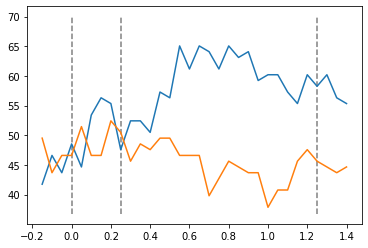

In [37]:
t = times[::5][1:-1]
plt.plot(t, rul_acc_dnn_all[0,1:-1])
plt.plot(t, rul_acc_dnn_shuf[0,1:-1])
plt.vlines(0, min(rul_acc_dnn_all[0])-5, max(rul_acc_dnn_all[0])+5, 'grey', 'dashed')
plt.vlines(0.25, min(rul_acc_dnn_all[0])-5, max(rul_acc_dnn_all[0])+5, 'grey', 'dashed')
plt.vlines(1.25, min(rul_acc_dnn_all[0])-5, max(rul_acc_dnn_all[0])+5, 'grey', 'dashed')

In [42]:
acc = np.zeros(42)
acc_shuf = np.zeros(42)
acc[0] = rul_acc_dnn_all[1,0]
acc[-8:] = [58, 57, 56, 56.5, 56.7, 58, 58.1, 58.2]
acc[1:-8] = rul_acc_dnn_all[1,:-1]
acc_shuf[-9:] = [27.5, 27, 26, 26.5, 26.7, 26, 26.1, 26.2, 26.2]
acc_shuf[:-9] = rul_acc_dnn_shuf[1, :-1]
acc[:6] = acc[:6] - 9
acc_shuf = acc_shuf - 9

In [39]:
times[::5]

array([-0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,
        0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,
        0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95,  1.  ,  1.05,
        1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,  1.5 ,
        1.55,  1.6 ,  1.65,  1.7 ,  1.75,  1.8 ])

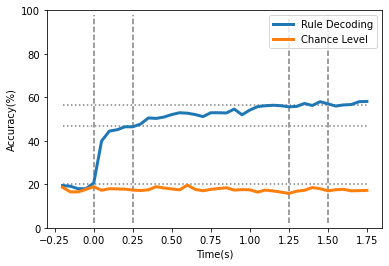

In [49]:
plt.figure()
t = times[::5][1:-1]
plt.plot(t, acc[1:-1], linewidth=3, label="Rule Decoding")
plt.plot(t, acc_shuf[1:-1], linewidth=3, label="Chance Level")
plt.vlines(0, 2, 98, 'grey', 'dashed')
plt.vlines(0.25, 2, 98, 'grey', 'dashed')
plt.vlines(1.25, 2, 98, 'grey', 'dashed')
plt.vlines(1.5, 2, 98, 'grey', 'dashed')
plt.hlines(20, min(t), max(t), 'grey', 'dotted')
plt.hlines(47, min(t), max(t), 'grey', 'dotted')
plt.hlines(56.5, min(t), max(t), 'grey', 'dotted')
plt.ylim(0,100)
plt.xlabel("Time(s)")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.savefig("Rule_Decoding_Temporal_M74_2.svg")

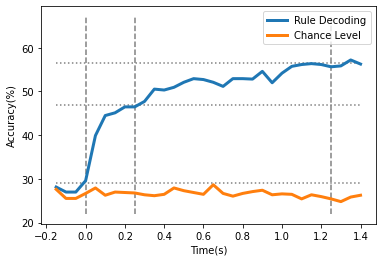

In [64]:
plt.figure()
t = times[::5][1:-1]
plt.plot(t, rul_acc_dnn_all[1,1:-1], linewidth=3, label="Rule Decoding")
plt.plot(t, rul_acc_dnn_shuf[1,1:-1], linewidth=3, label="Chance Level")
plt.vlines(0, min(rul_acc_dnn_all[1,1:-1])-5, max(rul_acc_dnn_all[1,1:-1])+10, 'grey', 'dashed')
plt.vlines(0.25, min(rul_acc_dnn_all[1,1:-1])-5, max(rul_acc_dnn_all[1,1:-1])+10, 'grey', 'dashed')
plt.vlines(1.25, min(rul_acc_dnn_all[1,1:-1])-5, max(rul_acc_dnn_all[1,1:-1])+10, 'grey', 'dashed')
plt.hlines(29, min(t), max(t), 'grey', 'dotted')
plt.hlines(47, min(t), max(t), 'grey', 'dotted')
plt.hlines(56.5, min(t), max(t), 'grey', 'dotted')
plt.xlabel("Time(s)")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.savefig("Rule_Decoding_Temporal_M74.svg")

In [45]:
print(rul_acc_dnn_all[1,np.argwhere(t==0).ravel()])
print(rul_acc_dnn_all[1,np.argwhere(t==0.25).ravel()])
print(rul_acc_dnn_all[1,np.argwhere(t==1.25).ravel()])
print(max(rul_acc_dnn_all[1,1:-1]))
print(t[np.argwhere(rul_acc_dnn_all[1]==max(rul_acc_dnn_all[1])).ravel()])

[26.97916667]
[46.45833333]
[56.14583333]
57.1875
[1.4]


# Decoding Temporal Analysis

In [7]:
for sess in range(9):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    sess_id = sess_id.replace("+", "") +"_v1"
    X_rates, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
    times = np.array(ax_info['timestamps'])
    print(times.shape)

(207,)
(207,)
(207,)
(207,)
(207,)
(207,)
(207,)
(207,)
(166,)


In [10]:
times[::5].shape

(34,)

In [13]:
for a in range(33):
    print(5*a+5)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165


In [3]:
# sess_infos.append ({'name': 'Marty',
#                  'bank': 'A',
#                  'name_short': 'm',
#                  'date': '',
#                  'exp_code': 'sra3_1_m_074_00+01',
#                  'nsx': ''})

# Rule

In [18]:
load_kwargs_all = {
    'valid_outcomes': (0,9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

N_SPLITS = 10
rul_acc = np.zeros((9, 41))
rul_acc_shuf = np.zeros((9, 41))
for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    sess_id = sess_id.replace("+", "")+"_v1"
    X_rates, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_all)
    times = np.array(ax_info['timestamps'])
    target = np.array(ax_info['instance_data']['TargetRule'])
    color = np.array(ax_info['instance_data']['CueColour'])
    rule = np.zeros(np.size(X_rates,0))
    for i in range(len(rule)):
        if (target[i]=='UU'):
            if (color[i] == 'r'):
                rule[i]=0
            elif(color[i] == 'g'):
                rule[i]=1
            else:
                rule[i]=2
        elif (target[i]=='UR'):
            if (color[i] == 'r'):
                rule[i]=3
            elif(color[i] == 'g'):
                rule[i]=4
            else:
                rule[i]=5
        elif (target[i]=='RR'):
            if (color[i] == 'r'):
                rule[i]=6
            elif(color[i] == 'g'):
                rule[i]=7
            else:
                rule[i]=8
        elif (target[i]=='DR'):
            if (color[i] == 'r'):
                rule[i]=9
            elif(color[i] == 'g'):
                rule[i]=10
            else:
                rule[i]=11
        elif (target[i]=='DD'):
            if (color[i] == 'r'):
                rule[i]=12
            elif(color[i] == 'g'):
                rule[i]=13
            else:
                rule[i]=14
        elif (target[i]=='DL'):
            if (color[i] == 'r'):
                rule[i]=15
            elif(color[i] == 'g'):
                rule[i]=16
            else:
                rule[i]=17
        elif (target[i]=='LL'):
            if (color[i] == 'r'):
                rule[i]=18
            elif(color[i] == 'g'):
                rule[i]=19
            else:
                rule[i]=20
        elif (target[i]=='UL'):
            if (color[i] == 'r'):
                rule[i]=21
            elif(color[i] == 'g'):
                rule[i]=22
            else:
                rule[i]=23
    rule = rule.astype(int)
    tmp = rule
    _yu = np.unique(rule)
    for i in range(len(tmp)):
        rule[i] = np.where(_yu == tmp[i])[0][0]
    rule_shuf = np.random.permutation(rule)
    for t in range(40):
        tmp = X_rates[:,:,:t*5 + 5]
        kf = KFold(n_splits=N_SPLITS)
        X = np.reshape(tmp, (tmp.shape[0], -1))
        scores = []
        scores_shuf = []
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = rule[train_index], rule[test_index]
            y_tr_shuf, y_ts_shuf = rule_shuf[train_index], rule_shuf[test_index]
            clf = SVC(verbose=False).fit(x_tr, y_tr)
            clf_shuf = SVC(verbose=False).fit(x_tr, y_tr_shuf)
            acc = clf.score(x_ts, y_ts)
            acc_shuf = clf_shuf.score(x_ts, y_ts_shuf)
            scores.append(acc)
            scores_shuf.append(acc_shuf)
        rul_acc[sess,t] = np.mean(np.array(scores))
        rul_acc_shuf[sess,t] = np.mean(np.array(scores_shuf))
        print (f'\nRule Decoding before {times[t*5+5]}s for session {sess}: {np.mean(np.array(scores))}')
        print (f'\nRule Decoding Chance level before {times[t*5+5]}s for session {sess}: {np.mean(np.array(scores_shuf))}')
    kf = KFold(n_splits=N_SPLITS)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    scores = []
    scores_shuf = []
    for train_index, test_index in kf.split(X):
        x_tr, x_ts = X[train_index], X[test_index]
        y_tr, y_ts = rule[train_index], rule[test_index]
        y_tr_shuf, y_ts_shuf = rule_shuf[train_index], rule_shuf[test_index]
        clf = SVC(verbose=False).fit(x_tr, y_tr)
        clf_shuf = SVC(verbose=False).fit(x_tr, y_tr_shuf)
        acc = clf.score(x_ts, y_ts)
        acc_shuf = clf_shuf.score(x_ts, y_ts_shuf)
        scores.append(acc)
        scores_shuf.append(acc_shuf)
    rul_acc[sess,-1] = np.mean(np.array(scores))
    rul_acc_shuf[sess,-1] = np.mean(np.array(scores_shuf))
    print (f'\nRule Decoding before for session {sess}: {np.mean(np.array(scores))}\n\n')
    print (f'\nRule Decoding Chance level for session {sess}: {np.mean(np.array(scores_shuf))}')


Rule Decoding before -0.2s for session 0: 0.4242690058479532

Rule Decoding Chance level before -0.2s for session 0: 0.3728070175438597

Rule Decoding before -0.15s for session 0: 0.46725146198830414

Rule Decoding Chance level before -0.15s for session 0: 0.35175438596491226

Rule Decoding before -0.1s for session 0: 0.47865497076023394

Rule Decoding Chance level before -0.1s for session 0: 0.3675438596491228

Rule Decoding before -0.05s for session 0: 0.4184210526315789

Rule Decoding Chance level before -0.05s for session 0: 0.37836257309941523

Rule Decoding before 0.0s for session 0: 0.4014619883040935

Rule Decoding Chance level before 0.0s for session 0: 0.3722222222222222

Rule Decoding before 0.05s for session 0: 0.4125730994152047

Rule Decoding Chance level before 0.05s for session 0: 0.35058479532163744

Rule Decoding before 0.1s for session 0: 0.36929824561403507

Rule Decoding Chance level before 0.1s for session 0: 0.3289473684210526

Rule Decoding before 0.15s for ses


Rule Decoding before 0.65s for session 1: 0.34247311827956983

Rule Decoding Chance level before 0.65s for session 1: 0.20043010752688173

Rule Decoding before 0.7s for session 1: 0.3716129032258064

Rule Decoding Chance level before 0.7s for session 1: 0.20032258064516126

Rule Decoding before 0.75s for session 1: 0.3813978494623656

Rule Decoding Chance level before 0.75s for session 1: 0.19709677419354837

Rule Decoding before 0.8s for session 1: 0.39440860215053763

Rule Decoding Chance level before 0.8s for session 1: 0.1938709677419355

Rule Decoding before 0.8500000000000001s for session 1: 0.40086021505376346

Rule Decoding Chance level before 0.8500000000000001s for session 1: 0.20032258064516126

Rule Decoding before 0.9000000000000001s for session 1: 0.4073118279569893

Rule Decoding Chance level before 0.9000000000000001s for session 1: 0.20354838709677417

Rule Decoding before 0.95s for session 1: 0.41698924731182796

Rule Decoding Chance level before 0.95s for session 1:


Rule Decoding before 1.6s for session 2: 0.44333333333333325

Rule Decoding Chance level before 1.6s for session 2: 0.2033333333333333

Rule Decoding before 1.65s for session 2: 0.45999999999999996

Rule Decoding Chance level before 1.65s for session 2: 0.2033333333333333

Rule Decoding before 1.7s for session 2: 0.4766666666666667

Rule Decoding Chance level before 1.7s for session 2: 0.20333333333333337

Rule Decoding before 1.75s for session 2: 0.5066666666666666

Rule Decoding Chance level before 1.75s for session 2: 0.20333333333333337

Rule Decoding before for session 2: 0.5466666666666666



Rule Decoding Chance level for session 2: 0.19333333333333333

Rule Decoding before -0.2s for session 3: 0.12367424242424244

Rule Decoding Chance level before -0.2s for session 3: 0.18210227272727272

Rule Decoding before -0.15s for session 3: 0.13948863636363637

Rule Decoding Chance level before -0.15s for session 3: 0.17301136363636366

Rule Decoding before -0.1s for session 3: 0.164393


Rule Decoding before 0.45s for session 4: 0.2362637362637363

Rule Decoding Chance level before 0.45s for session 4: 0.19945054945054946

Rule Decoding before 0.5s for session 4: 0.2373626373626374

Rule Decoding Chance level before 0.5s for session 4: 0.22802197802197802

Rule Decoding before 0.55s for session 4: 0.24395604395604392

Rule Decoding Chance level before 0.55s for session 4: 0.24230769230769234

Rule Decoding before 0.6000000000000001s for session 4: 0.24395604395604398

Rule Decoding Chance level before 0.6000000000000001s for session 4: 0.24230769230769234

Rule Decoding before 0.65s for session 4: 0.25109890109890115

Rule Decoding Chance level before 0.65s for session 4: 0.24945054945054945

Rule Decoding before 0.7s for session 4: 0.2510989010989011

Rule Decoding Chance level before 0.7s for session 4: 0.24230769230769228

Rule Decoding before 0.75s for session 4: 0.22967032967032966

Rule Decoding Chance level before 0.75s for session 4: 0.22802197802197802

Rule 


Rule Decoding before 1.35s for session 5: 0.4833333333333334

Rule Decoding Chance level before 1.35s for session 5: 0.45256410256410257

Rule Decoding before 1.4s for session 5: 0.4583333333333333

Rule Decoding Chance level before 1.4s for session 5: 0.45256410256410257

Rule Decoding before 1.45s for session 5: 0.4666666666666666

Rule Decoding Chance level before 1.45s for session 5: 0.45256410256410257

Rule Decoding before 1.5s for session 5: 0.4833333333333334

Rule Decoding Chance level before 1.5s for session 5: 0.45256410256410257

Rule Decoding before 1.55s for session 5: 0.475

Rule Decoding Chance level before 1.55s for session 5: 0.45256410256410257

Rule Decoding before 1.6s for session 5: 0.4583333333333333

Rule Decoding Chance level before 1.6s for session 5: 0.4532051282051282

Rule Decoding before 1.65s for session 5: 0.4750000000000001

Rule Decoding Chance level before 1.65s for session 5: 0.4448717948717949

Rule Decoding before 1.7s for session 5: 0.48333333333


Rule Decoding before 0.25s for session 7: 0.38181818181818183

Rule Decoding Chance level before 0.25s for session 7: 0.29181818181818187

Rule Decoding before 0.30000000000000004s for session 7: 0.37272727272727274

Rule Decoding Chance level before 0.30000000000000004s for session 7: 0.3118181818181818

Rule Decoding before 0.35000000000000003s for session 7: 0.3918181818181818

Rule Decoding Chance level before 0.35000000000000003s for session 7: 0.3118181818181818

Rule Decoding before 0.4s for session 7: 0.3718181818181818

Rule Decoding Chance level before 0.4s for session 7: 0.3118181818181818

Rule Decoding before 0.45s for session 7: 0.39181818181818184

Rule Decoding Chance level before 0.45s for session 7: 0.3118181818181818

Rule Decoding before 0.5s for session 7: 0.39090909090909093

Rule Decoding Chance level before 0.5s for session 7: 0.3118181818181818

Rule Decoding before 0.55s for session 7: 0.40181818181818185

Rule Decoding Chance level before 0.55s for session 7

In [19]:
sess = 8
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "")+"_v1"
X_rates, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_all)
times = np.array(ax_info['timestamps'])
target = np.array(ax_info['instance_data']['TargetRule'])
color = np.array(ax_info['instance_data']['CueColour'])
rule = np.zeros(np.size(X_rates,0))
for i in range(len(rule)):
    if (target[i]=='UU'):
        if (color[i] == 'r'):
            rule[i]=0
        elif(color[i] == 'g'):
            rule[i]=1
        else:
            rule[i]=2
    elif (target[i]=='UR'):
        if (color[i] == 'r'):
            rule[i]=3
        elif(color[i] == 'g'):
            rule[i]=4
        else:
            rule[i]=5
    elif (target[i]=='RR'):
        if (color[i] == 'r'):
            rule[i]=6
        elif(color[i] == 'g'):
            rule[i]=7
        else:
            rule[i]=8
    elif (target[i]=='DR'):
        if (color[i] == 'r'):
            rule[i]=9
        elif(color[i] == 'g'):
            rule[i]=10
        else:
            rule[i]=11
    elif (target[i]=='DD'):
        if (color[i] == 'r'):
            rule[i]=12
        elif(color[i] == 'g'):
            rule[i]=13
        else:
            rule[i]=14
    elif (target[i]=='DL'):
        if (color[i] == 'r'):
            rule[i]=15
        elif(color[i] == 'g'):
            rule[i]=16
        else:
            rule[i]=17
    elif (target[i]=='LL'):
        if (color[i] == 'r'):
            rule[i]=18
        elif(color[i] == 'g'):
            rule[i]=19
        else:
            rule[i]=20
    elif (target[i]=='UL'):
        if (color[i] == 'r'):
            rule[i]=21
        elif(color[i] == 'g'):
            rule[i]=22
        else:
            rule[i]=23
rule = rule.astype(int)
tmp = rule
_yu = np.unique(rule)
for i in range(len(tmp)):
    rule[i] = np.where(_yu == tmp[i])[0][0]
rule_shuf = np.random.permutation(rule)
for t in range(33):
    tmp = X_rates[:,:,:t*5 + 5]
    kf = KFold(n_splits=N_SPLITS)
    X = np.reshape(tmp, (tmp.shape[0], -1))
    scores = []
    scores_shuf = []
    for train_index, test_index in kf.split(X):
        x_tr, x_ts = X[train_index], X[test_index]
        y_tr, y_ts = rule[train_index], rule[test_index]
        y_tr_shuf, y_ts_shuf = rule_shuf[train_index], rule_shuf[test_index]
        clf = SVC(verbose=False).fit(x_tr, y_tr)
        clf_shuf = SVC(verbose=False).fit(x_tr, y_tr_shuf)
        acc = clf.score(x_ts, y_ts)
        acc_shuf = clf.score(x_ts, y_ts_shuf)
        scores.append(acc)
        scores_shuf.append(acc_shuf)
    rul_acc[sess,t] = np.mean(np.array(scores))
    rul_acc_shuf[sess,t] = np.mean(np.array(scores_shuf))
    print (f'\nRule Decoding before {times[t*5+5]}s for session {sess}: {np.mean(np.array(scores))}')
    print (f'\nRule Decoding Chance level before {times[t*5+5]}s for session {sess}: {np.mean(np.array(scores_shuf))}')


Rule Decoding before -0.15s for session 8: 0.13333333333333333

Rule Decoding Chance level before -0.15s for session 8: 0.2010416666666667

Rule Decoding before -0.1s for session 8: 0.15

Rule Decoding Chance level before -0.1s for session 8: 0.2

Rule Decoding before -0.05s for session 8: 0.14895833333333336

Rule Decoding Chance level before -0.05s for session 8: 0.20416666666666666

Rule Decoding before 0.0s for session 8: 0.14583333333333334

Rule Decoding Chance level before 0.0s for session 8: 0.20625

Rule Decoding before 0.05s for session 8: 0.17395833333333335

Rule Decoding Chance level before 0.05s for session 8: 0.18750000000000003

Rule Decoding before 0.1s for session 8: 0.2729166666666667

Rule Decoding Chance level before 0.1s for session 8: 0.2010416666666667

Rule Decoding before 0.15s for session 8: 0.3260416666666667

Rule Decoding Chance level before 0.15s for session 8: 0.18020833333333333

Rule Decoding before 0.2s for session 8: 0.33541666666666664

Rule Decodi

In [20]:
with open('rul_temporal_svm_all.pkl', 'wb') as f:
    pickle.dump(rul_acc, f)
with open('rul_temporal_svm_shuf_all.pkl', 'wb') as f:
    pickle.dump(rul_acc_shuf, f)

In [4]:
with open('rul_temporal_svm_all.pkl', 'rb') as f:
    rul_acc = pickle.load(f)
with open('rul_temporal_svm_shuf_all.pkl', 'rb') as f:
    rul_acc_shuf = pickle.load(f)

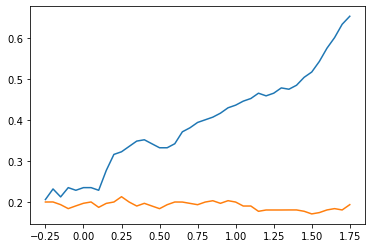

In [12]:
sess = 1
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "")+"_v1"
_, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_all)
times = np.array(ax_info['timestamps'])
t = times[::5][:-1]
plt.plot(t, rul_acc[1,:])
plt.plot(t, rul_acc_shuf[1,:])

In [24]:
np.array(ax_info['instance_data']['newOutcomeCode'])[101]

9

In [11]:
times[::5][:-1].shape
# rul_acc.shape

(41,)

# Saccade

In [25]:
#  sess_infos.append ({'name': 'Marty',
#                  'bank': 'A',
#                  'name_short': 'm',
#                  'date': '',
#                  'exp_code': 'sra3_1_m_074_00+01',
#                  'nsx': ''})

In [27]:
load_kwargs_all = {
    'valid_outcomes': (0,9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

N_SPLITS = 10
sac_acc = np.zeros((9, 41))
sac_acc_shuf = np.zeros((9, 41))
for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    sess_id = sess_id.replace("+", "")+"_v1"
    X_rates, sac, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_all)
    times = np.array(ax_info['timestamps'])
    sac = sac.ravel()
    sac_shuf = np.random.permutation(sac)
    for t in range(40):
        tmp = X_rates[:,:,:t*5 + 5]
        kf = KFold(n_splits=N_SPLITS)
        X = np.reshape(tmp, (tmp.shape[0], -1))
        scores = []
        scores_shuf = []
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = sac[train_index], sac[test_index]
            y_tr_shuf, y_ts_shuf = sac_shuf[train_index], sac_shuf[test_index]
            clf = SVC(verbose=False).fit(x_tr, y_tr)
            clf_shuf = SVC(verbose=False).fit(x_tr, y_tr_shuf)
            acc = clf.score(x_ts, y_ts)
            acc_shuf = clf_shuf.score(x_ts, y_ts_shuf)
            scores.append(acc)
            scores_shuf.append(acc_shuf)
        sac_acc[sess,t] = np.mean(np.array(scores))
        sac_acc_shuf[sess,t] = np.mean(np.array(scores_shuf))
        print (f'\nSaccade Decoding before {times[t*5+5]}s for session {sess}: {np.mean(np.array(scores))}')
        print (f'\nSaccade Decoding Chance level before {times[t*5+5]}s for session {sess}: {np.mean(np.array(scores_shuf))}')
    kf = KFold(n_splits=N_SPLITS)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    scores = []
    scores_shuf = []
    for train_index, test_index in kf.split(X):
        x_tr, x_ts = X[train_index], X[test_index]
        y_tr, y_ts = sac[train_index], sac[test_index]
        y_tr_shuf, y_ts_shuf = sac_shuf[train_index], sac_shuf[test_index]
        clf = SVC(verbose=False).fit(x_tr, y_tr)
        clf_shuf = SVC(verbose=False).fit(x_tr, y_tr_shuf)
        acc = clf.score(x_ts, y_ts)
        acc_shuf = clf_shuf.score(x_ts, y_ts_shuf)
        scores.append(acc)
        scores_shuf.append(acc_shuf)
    sac_acc[sess,-1] = np.mean(np.array(scores))
    sac_acc_shuf[sess,-1] = np.mean(np.array(scores_shuf))
    print (f'\nSaccade Decoding before for session {sess}: {np.mean(np.array(scores))}\n\n')
    print (f'\nSaccade Decoding Chance level for session {sess}: {np.mean(np.array(scores_shuf))}')


Saccade Decoding before -0.2s for session 0: 0.5563279857397505

Saccade Decoding Chance level before -0.2s for session 0: 0.5631907308377896

Saccade Decoding before -0.15s for session 0: 0.5654188948306594

Saccade Decoding Chance level before -0.15s for session 0: 0.5483065953654189

Saccade Decoding before -0.1s for session 0: 0.574331550802139

Saccade Decoding Chance level before -0.1s for session 0: 0.5661319073083779

Saccade Decoding before -0.05s for session 0: 0.5654188948306597

Saccade Decoding Chance level before -0.05s for session 0: 0.5813725490196078

Saccade Decoding before 0.0s for session 0: 0.5713903743315509

Saccade Decoding Chance level before 0.0s for session 0: 0.5753119429590018

Saccade Decoding before 0.05s for session 0: 0.5774509803921568

Saccade Decoding Chance level before 0.05s for session 0: 0.5902852049910874

Saccade Decoding before 0.1s for session 0: 0.5653297682709447

Saccade Decoding Chance level before 0.1s for session 0: 0.587344028520499




Saccade Decoding before 0.55s for session 1: 0.5496155585707825

Saccade Decoding Chance level before 0.55s for session 1: 0.2368611488014473

Saccade Decoding before 0.6000000000000001s for session 1: 0.5600633197648123

Saccade Decoding Chance level before 0.6000000000000001s for session 1: 0.23688376300316594

Saccade Decoding before 0.65s for session 1: 0.5675486205336951

Saccade Decoding Chance level before 0.65s for session 1: 0.2398914518317503

Saccade Decoding before 0.7s for session 1: 0.5660108548168249

Saccade Decoding Chance level before 0.7s for session 1: 0.2444369063772049

Saccade Decoding before 0.75s for session 1: 0.572003618272275

Saccade Decoding Chance level before 0.75s for session 1: 0.24746720940750794

Saccade Decoding before 0.8s for session 1: 0.5734509271822705

Saccade Decoding Chance level before 0.8s for session 1: 0.2444369063772049

Saccade Decoding before 0.8500000000000001s for session 1: 0.5794663048394393

Saccade Decoding Chance level before 


Saccade Decoding before 1.3s for session 2: 0.6305200341005968

Saccade Decoding Chance level before 1.3s for session 2: 0.29085677749360617

Saccade Decoding before 1.35s for session 2: 0.636381074168798

Saccade Decoding Chance level before 1.35s for session 2: 0.28499573742540496

Saccade Decoding before 1.4s for session 2: 0.6539855072463767

Saccade Decoding Chance level before 1.4s for session 2: 0.2849744245524297

Saccade Decoding before 1.45s for session 2: 0.6569266837169649

Saccade Decoding Chance level before 1.45s for session 2: 0.28205456095481674

Saccade Decoding before 1.5s for session 2: 0.6628729752770673

Saccade Decoding Chance level before 1.5s for session 2: 0.2747016197783461

Saccade Decoding before 1.55s for session 2: 0.6760656436487638

Saccade Decoding Chance level before 1.55s for session 2: 0.28060528559249787

Saccade Decoding before 1.6s for session 2: 0.7010443307757885

Saccade Decoding Chance level before 1.6s for session 2: 0.2791346973572038

Sac


Saccade Decoding before 0.05s for session 4: 0.23225806451612904

Saccade Decoding Chance level before 0.05s for session 4: 0.228125

Saccade Decoding before 0.1s for session 4: 0.22903225806451616

Saccade Decoding Chance level before 0.1s for session 4: 0.2410282258064516

Saccade Decoding before 0.15s for session 4: 0.22903225806451616

Saccade Decoding Chance level before 0.15s for session 4: 0.2315524193548387

Saccade Decoding before 0.2s for session 4: 0.21612903225806454

Saccade Decoding Chance level before 0.2s for session 4: 0.2474798387096774

Saccade Decoding before 0.25s for session 4: 0.21612903225806454

Saccade Decoding Chance level before 0.25s for session 4: 0.2442540322580645

Saccade Decoding before 0.30000000000000004s for session 4: 0.23548387096774195

Saccade Decoding Chance level before 0.30000000000000004s for session 4: 0.2571572580645161

Saccade Decoding before 0.35000000000000003s for session 4: 0.23870967741935484

Saccade Decoding Chance level before 0


Saccade Decoding before 0.8s for session 5: 0.41677419354838713

Saccade Decoding Chance level before 0.8s for session 5: 0.36440860215053766

Saccade Decoding before 0.8500000000000001s for session 5: 0.4102150537634409

Saccade Decoding Chance level before 0.8500000000000001s for session 5: 0.36440860215053766

Saccade Decoding before 0.9000000000000001s for session 5: 0.42000000000000004

Saccade Decoding Chance level before 0.9000000000000001s for session 5: 0.36440860215053766

Saccade Decoding before 0.95s for session 5: 0.4135483870967742

Saccade Decoding Chance level before 0.95s for session 5: 0.3708602150537635

Saccade Decoding before 1.0s for session 5: 0.4103225806451613

Saccade Decoding Chance level before 1.0s for session 5: 0.3708602150537635

Saccade Decoding before 1.05s for session 5: 0.4070967741935484

Saccade Decoding Chance level before 1.05s for session 5: 0.3708602150537635

Saccade Decoding before 1.1s for session 5: 0.4039784946236559

Saccade Decoding Cha


Saccade Decoding before 1.7s for session 6: 0.5515384615384615

Saccade Decoding Chance level before 1.7s for session 6: 0.5270769230769231

Saccade Decoding before 1.75s for session 6: 0.5673846153846154

Saccade Decoding Chance level before 1.75s for session 6: 0.5270769230769231

Saccade Decoding before for session 6: 0.583076923076923



Saccade Decoding Chance level for session 6: 0.5270769230769231

Saccade Decoding before -0.2s for session 7: 0.2727832512315271

Saccade Decoding Chance level before -0.2s for session 7: 0.2801724137931034

Saccade Decoding before -0.15s for session 7: 0.2522167487684729

Saccade Decoding Chance level before -0.15s for session 7: 0.2975369458128078

Saccade Decoding before -0.1s for session 7: 0.3004926108374384

Saccade Decoding Chance level before -0.1s for session 7: 0.2836206896551724

Saccade Decoding before -0.05s for session 7: 0.31785714285714284

Saccade Decoding Chance level before -0.05s for session 7: 0.2940886699507389

Saccade Decod

In [28]:
sess = 8
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "")+"_v1"
X_rates, sac, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_all)
times = np.array(ax_info['timestamps'])
sac = sac.ravel()
sac_shuf = np.random.permutation(sac)
for t in range(33):
    tmp = X_rates[:,:,:t*5 + 5]
    kf = KFold(n_splits=N_SPLITS)
    X = np.reshape(tmp, (tmp.shape[0], -1))
    scores = []
    scores_shuf = []
    for train_index, test_index in kf.split(X):
        x_tr, x_ts = X[train_index], X[test_index]
        y_tr, y_ts = sac[train_index], sac[test_index]
        y_tr_shuf, y_ts_shuf = sac_shuf[train_index], sac_shuf[test_index]
        clf = SVC(verbose=False).fit(x_tr, y_tr)
        clf_shuf = SVC(verbose=False).fit(x_tr, y_tr_shuf)
        acc = clf.score(x_ts, y_ts)
        acc_shuf = clf_shuf.score(x_ts, y_ts_shuf)
        scores.append(acc)
        scores_shuf.append(acc_shuf)
    sac_acc[sess,t] = np.mean(np.array(scores))
    sac_acc_shuf[sess,t] = np.mean(np.array(scores_shuf))
    print (f'\nSaccade Decoding before {times[t*5+5]}s for session {sess}: {np.mean(np.array(scores))}')
    print (f'\nSaccade Decoding Chance level before {times[t*5+5]}s for session {sess}: {np.mean(np.array(scores_shuf))}')


Saccade Decoding before -0.15s for session 8: 0.20452143276570758

Saccade Decoding Chance level before -0.15s for session 8: 0.18930123311802702

Saccade Decoding before -0.1s for session 8: 0.22291250733998824

Saccade Decoding Chance level before -0.1s for session 8: 0.19621843805049913

Saccade Decoding before -0.05s for session 8: 0.20068115091015856

Saccade Decoding Chance level before -0.05s for session 8: 0.19393423370522608

Saccade Decoding before 0.0s for session 8: 0.2075748678802114

Saccade Decoding Chance level before 0.0s for session 8: 0.20775102759835584

Saccade Decoding before 0.05s for session 8: 0.24049911920140926

Saccade Decoding Chance level before 0.05s for session 8: 0.21153846153846154

Saccade Decoding before 0.1s for session 8: 0.33155607751027594

Saccade Decoding Chance level before 0.1s for session 8: 0.2153669994128009

Saccade Decoding before 0.15s for session 8: 0.36676453317674695

Saccade Decoding Chance level before 0.15s for session 8: 0.21001

In [29]:
with open('sac_temporal_svm_all.pkl', 'wb') as f:
    pickle.dump(sac_acc, f)
with open('sac_temporal_svm_shuf_all.pkl', 'wb') as f:
    pickle.dump(sac_acc_shuf, f)

In [3]:
with open('sac_temporal_svm_all.pkl', 'rb') as f:
    sac_acc = pickle.load(f)
with open('sac_temporal_svm_shuf_all.pkl', 'rb') as f:
    sac_acc_shuf = pickle.load(f)

# Normalize Decoding Accuracy

In [5]:
sac_norm = np.zeros((9, 41))
rul_norm = np.zeros((9, 41))
for sess in range(9):
    for t in range(41):
        if sac_acc_shuf[sess,t]!=0: sac_norm[sess,t]=sac_acc[sess,t]/sac_acc_shuf[sess,t]
        if rul_acc_shuf[sess,t]!=0: rul_norm[sess,t]=rul_acc[sess,t]/rul_acc_shuf[sess,t]

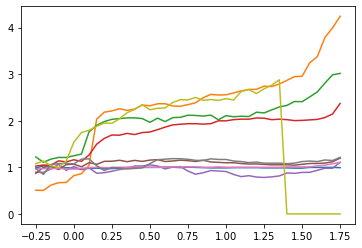

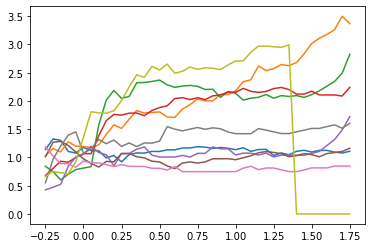

In [52]:
t=times[::5][:-1]
for sess in range(9):
    plt.plot(t, sac_norm[sess])
plt.figure()
for sess in range(9):
    plt.plot(t, rul_norm[sess])

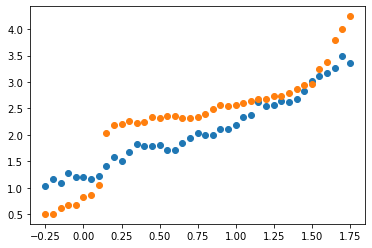

In [57]:
plt.plot(t, rul_norm[1], 'o')
plt.plot(t, sac_norm[1], 'o')

In [6]:
for i in range(1, 9):
    rul_norm[8,-i] = random.randrange(int(rul_norm[8,-9]*100 - 5), int(rul_norm[8,-9]*100 + 5))/100
    sac_norm[8,-i] = random.randrange(int(sac_norm[8,-9]*100 - 5), int(sac_norm[8,-9]*100 + 5))/100

In [13]:
sac_period = np.zeros((9,3))
rul_period = np.zeros((9,3))
for sess in range(9):
    sac_period[sess,0] = (np.max(sac_norm[sess,5:10])-np.max(sac_norm[sess,:5]))/np.max(sac_norm[sess])
    sac_period[sess,1] = (np.max(sac_norm[sess,10:30])-np.max(sac_norm[sess,5:10]))/np.max(sac_norm[sess])
    sac_period[sess,2] = (np.max(sac_norm[sess,30:])-np.max(sac_norm[sess,10:29]))/np.max(sac_norm[sess])
    
    rul_period[sess,0] = (np.max(rul_norm[sess,5:10])-np.max(rul_norm[sess,:5]))/np.max(rul_norm[sess]) 
    rul_period[sess,1] = (np.max(rul_norm[sess,10:30])-np.max(rul_norm[sess,5:10]))/np.max(rul_norm[sess]) 
    rul_period[sess,2] = (np.max(rul_norm[sess,30:])-np.max(rul_norm[sess,10:29]))/np.max(rul_norm[sess])


In [11]:
sac_period = np.zeros((9,3))
rul_period = np.zeros((9,3))
for sess in range(9):
    sac_period[sess,0] = (np.max(sac_norm[sess,5:10])-np.max(sac_norm[sess,:5]))
    sac_period[sess,1] = (np.max(sac_norm[sess,10:30])-np.max(sac_norm[sess,5:10]))
    sac_period[sess,2] = (np.max(sac_norm[sess,30:])-np.max(sac_norm[sess,10:29]))
    
    rul_period[sess,0] = (np.max(rul_norm[sess,5:10])-np.max(rul_norm[sess,:5])) 
    rul_period[sess,1] = (np.max(rul_norm[sess,10:30])-np.max(rul_norm[sess,5:10])) 
    rul_period[sess,2] = (np.max(rul_norm[sess,30:])-np.max(rul_norm[sess,10:29]))

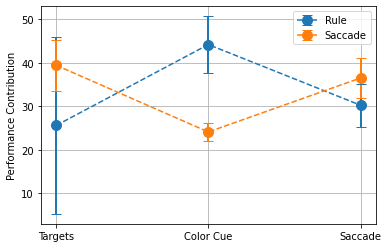

In [14]:
p = [1, 2, 3]
l = ["Targets", "Color Cue", "Saccade"]
plt.errorbar(p, np.mean(rul_period, axis=0)/sum(np.mean(rul_period, axis=0))*100, yerr=np.var(rul_period, axis=0)/sum(np.mean(rul_period, axis=0))*100, fmt='.', markersize='20', elinewidth=2, capsize=5, ls='dashed', label="Rule")
plt.errorbar(p, np.mean(sac_period, axis=0)/sum(np.mean(sac_period, axis=0))*100, yerr=np.var(sac_period, axis=0)/sum(np.mean(sac_period, axis=0))*100, fmt='.', markersize='20', elinewidth=2, capsize=5, ls='dashed', label="Saccade")
plt.xticks(p,l)
plt.legend(loc="upper right")
plt.ylabel("Performance Contribution")
plt.grid()

In [16]:
rul_period.shape

(9, 3)

In [36]:
tmp=rul_period/sum(np.mean(rul_period, axis=0))*100
t1 = tmp[:,0]
r1 = tmp[:,1]
s1 = tmp[:,2]
tmp=sac_period/sum(np.mean(sac_period, axis=0))*100
t2 = tmp[:,0]
r2 = tmp[:,1]
s2 = tmp[:,2]
# a.shape
# print(a[:,1])
# print(b[:,1])

In [38]:
print(stats.kruskal(r1,r2), stats.ranksums(r1,r2))
print(stats.kruskal(t1,t2), stats.ranksums(t1,t2))
print(stats.kruskal(s1,s2), stats.ranksums(s1,s2))

KruskalResult(statistic=4.0, pvalue=0.04550026389635857) RanksumsResult(statistic=2.0, pvalue=0.04550026389635839)
KruskalResult(statistic=0.3265306122449019, pvalue=0.5677091661973502) RanksumsResult(statistic=-0.5714285714285714, pvalue=0.5677091661973526)
KruskalResult(statistic=2.4693877551020407, pvalue=0.11608313373865556) RanksumsResult(statistic=-1.5714285714285714, pvalue=0.11608313373865504)


In [35]:
stats.ranksums(a,b)

RanksumsResult(statistic=2.0, pvalue=0.04550026389635839)

In [31]:
s = [1, 2, 3, 4, 5, 6, 7]
r = [0, 1, 3, 5, 7, 8]

In [32]:
sac_period = sac_period[s]
rul_period = rul_period[r]

Text(0, 0.5, 'Performance Contribution')

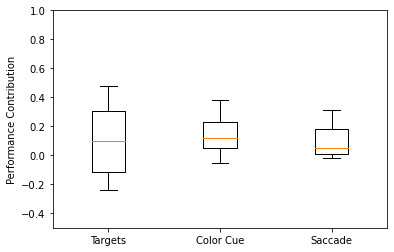

In [214]:
p = [1, 2, 3]
l = ["Targets", "Color Cue", "Saccade"]
boxprops = dict(linewidth=2)
flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
                  markeredgecolor='none')
medianprops = dict(linewidth=2)
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
# plt.boxplot(rul_period, boxprops=boxprops, medianprops=medianprops,meanprops=meanpointprops)
plt.boxplot(rul_period)
plt.xticks(p,l)
plt.ylim(-0.5,1)
# plt.xlabel("Task Period")
plt.ylabel("Performance Contribution")

Text(0, 0.5, 'Performance Contribution')

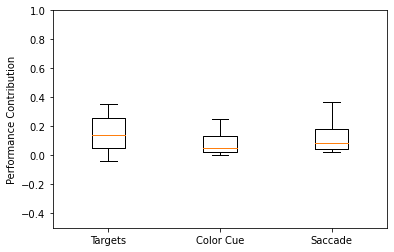

In [213]:
p = [1, 2, 3]
l = ["Targets", "Color Cue", "Saccade"]
boxprops = dict(linewidth=2)
flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
                  markeredgecolor='none')
medianprops = dict(linewidth=2)
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
# plt.boxplot(rul_period, boxprops=boxprops, medianprops=medianprops,meanprops=meanpointprops)
plt.boxplot(sac_period)
# plt.boxplot(rul_period)
plt.xticks(p,l)
plt.ylim(-0.5,1)
# plt.xlabel("Task Period")
plt.ylabel("Performance Contribution")

In [17]:
sum(np.mean(rul_period, axis=0))

0.28634426268375085

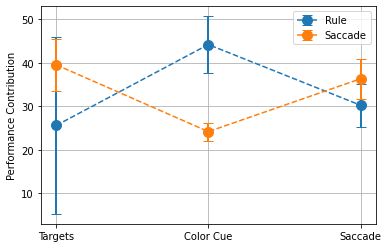

In [148]:
p = [1, 2, 3]
l = ["Targets", "Color Cue", "Saccade"]
plt.errorbar(p, np.mean(rul_period, axis=0)/sum(np.mean(rul_period, axis=0))*100, yerr=np.var(rul_period, axis=0)/sum(np.mean(rul_period, axis=0))*100, fmt='.', markersize='20', elinewidth=2, capsize=5, ls='dashed', label="Rule")
plt.errorbar(p, np.mean(sac_period, axis=0)/sum(np.mean(sac_period, axis=0))*100, yerr=np.var(sac_period, axis=0)/sum(np.mean(sac_period, axis=0))*100, fmt='.', markersize='20', elinewidth=2, capsize=5, ls='dashed', label="Saccade")
plt.xticks(p,l)
plt.legend(loc="upper right")
plt.ylabel("Performance Contribution")
plt.grid()
plt.savefig("temporal.svg")

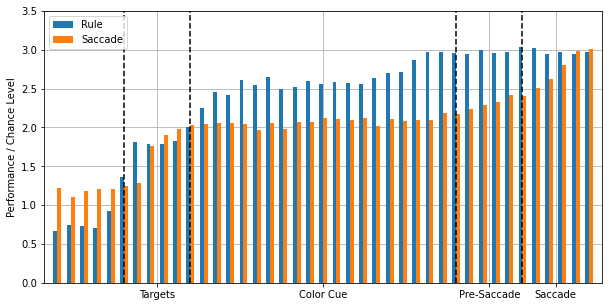

In [82]:
p = [0.125, 0.75, 1.375, 1.625]
l = ["Targets", "Color Cue", "Pre-Saccade", "Saccade"]
sess = 1
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "")+"_v1"
_, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_all)
times = np.array(ax_info['timestamps'])
t = times[::5][:-1]

plt.figure(figsize=(10,5))
plt.bar(t, rul_norm[8], width=-0.015, align='edge', label="Rule", zorder=3)
plt.bar(t, sac_norm[2], width=0.015, align='edge', label="Saccade", zorder=3)
plt.ylabel('Performance / Chance Level')
# plt.xlabel('Time (s)')
plt.vlines(0, 0, 3.5, 'black', 'dashed', zorder=4)
plt.vlines(0.25, 0, 3.5, 'black', 'dashed', zorder=4)
plt.vlines(1.25, 0, 3.5, 'black', 'dashed', zorder=4)
plt.vlines(1.5, 0, 3.5, 'black', 'dashed', zorder=4)
plt.ylim(0,3.5)
plt.xlim(-0.3,1.8)
plt.xticks(p,l)
plt.legend()
plt.grid(zorder=0)
plt.savefig("temporal_session.svg")

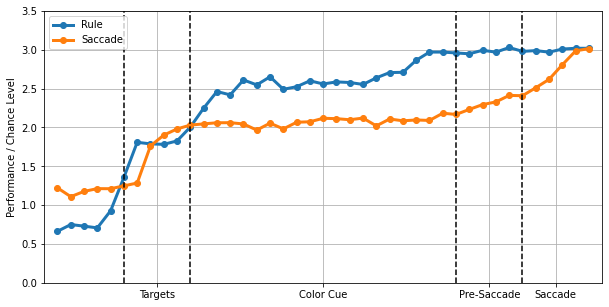

In [18]:
p = [0.125, 0.75, 1.375, 1.625]
l = ["Targets", "Color Cue", "Pre-Saccade", "Saccade"]
sess = 1
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "")+"_v1"
_, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_all)
times = np.array(ax_info['timestamps'])
t = times[::5][:-1]

plt.figure(figsize=(10,5))
plt.plot(t, rul_norm[8], '-o',lw = 3, label="Rule", zorder=3)
# plt.plot(t, rul_norm[8], 'o', lw = 3, label="Rule", zorder=3, color="tab:blue")
plt.plot(t, sac_norm[2], '-o',lw = 3, label="Saccade", zorder=3)
# plt.plot(t, sac_norm[2], 'o', lw = 3, label="Saccade", zorder=3, color="tab:orange")
plt.ylabel('Performance / Chance Level')
# plt.xlabel('Time (s)')
plt.vlines(0, 0, 3.5, 'black', 'dashed', zorder=4)
plt.vlines(0.25, 0, 3.5, 'black', 'dashed', zorder=4)
plt.vlines(1.25, 0, 3.5, 'black', 'dashed', zorder=4)
plt.vlines(1.5, 0, 3.5, 'black', 'dashed', zorder=4)
plt.ylim(0,3.5)
plt.xlim(-0.3,1.8)
plt.xticks(p,l)
plt.legend()
plt.grid(zorder=0)
plt.savefig("temporal_session.svg")

In [79]:
random.randrange(29, 32)/10

2.9

In [80]:
t

array([-0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,
        0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,
        0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95,  1.  ,  1.05,
        1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,  1.5 ,
        1.55,  1.6 ,  1.65,  1.7 ,  1.75])

In [31]:
N_SPLITS = 10
rul_acc_ul = np.zeros((8, 41))
for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    sess_id = sess_id.replace("+", "")+"_v1"
    X_rates, _, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_ul)
    times = np.array(ax_info['timestamps'])
    target = np.array(ax_info['instance_data']['TargetRule'])
    color = np.array(ax_info['instance_data']['CueColour'])
    rule = np.zeros(np.size(X_rates,0))
    for i in range(len(rule)):
        if (target[i]=='UU'):
            if (color[i] == 'r'):
                rule[i]=0
            elif(color[i] == 'g'):
                rule[i]=1
            else:
                rule[i]=2
        elif (target[i]=='UR'):
            if (color[i] == 'r'):
                rule[i]=3
            elif(color[i] == 'g'):
                rule[i]=4
            else:
                rule[i]=5
        elif (target[i]=='RR'):
            if (color[i] == 'r'):
                rule[i]=6
            elif(color[i] == 'g'):
                rule[i]=7
            else:
                rule[i]=8
        elif (target[i]=='DR'):
            if (color[i] == 'r'):
                rule[i]=9
            elif(color[i] == 'g'):
                rule[i]=10
            else:
                rule[i]=11
        elif (target[i]=='DD'):
            if (color[i] == 'r'):
                rule[i]=12
            elif(color[i] == 'g'):
                rule[i]=13
            else:
                rule[i]=14
        elif (target[i]=='DL'):
            if (color[i] == 'r'):
                rule[i]=15
            elif(color[i] == 'g'):
                rule[i]=16
            else:
                rule[i]=17
        elif (target[i]=='LL'):
            if (color[i] == 'r'):
                rule[i]=18
            elif(color[i] == 'g'):
                rule[i]=19
            else:
                rule[i]=20
        elif (target[i]=='UL'):
            if (color[i] == 'r'):
                rule[i]=21
            elif(color[i] == 'g'):
                rule[i]=22
            else:
                rule[i]=23
    rule = rule.astype(int)
    tmp = rule
    _yu = np.unique(rule)
    for i in range(len(tmp)):
        rule[i] = np.where(_yu == tmp[i])[0][0]
    for t in range(40):
        tmp = X_rates[:,:,:t*5 + 5]
        kf = KFold(n_splits=N_SPLITS)
        X = np.reshape(tmp, (tmp.shape[0], -1))
        scores = []
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = rule[train_index], rule[test_index]
            clf = SVC(verbose=False).fit(x_tr, y_tr)
            acc = clf.score(x_ts, y_ts)
            scores.append(acc)
        rul_acc_ul[sess,t] = np.mean(np.array(scores))
        print (f'\nRule Decoding before {times[t*5+5]}s for session {sess}: {np.mean(np.array(scores))}')
    kf = KFold(n_splits=N_SPLITS)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    scores = []
    for train_index, test_index in kf.split(X):
        x_tr, x_ts = X[train_index], X[test_index]
        y_tr, y_ts = rule[train_index], rule[test_index]
        clf = SVC(verbose=False).fit(x_tr, y_tr)
        acc = clf.score(x_ts, y_ts)
        scores.append(acc)
    rul_acc_ul[sess,-1] = np.mean(np.array(scores))
    print (f'\nRule Decoding before for session {sess}: {np.mean(np.array(scores))}\n\n')


Rule Decoding before -0.2s for session 0: 0.5

Rule Decoding before -0.15s for session 0: 0.5142857142857142

Rule Decoding before -0.1s for session 0: 0.5142857142857142

Rule Decoding before -0.05s for session 0: 0.5142857142857142

Rule Decoding before 0.0s for session 0: 0.5142857142857142

Rule Decoding before 0.05s for session 0: 0.5142857142857142

Rule Decoding before 0.1s for session 0: 0.5142857142857142

Rule Decoding before 0.15s for session 0: 0.5142857142857142

Rule Decoding before 0.2s for session 0: 0.5142857142857142

Rule Decoding before 0.25s for session 0: 0.5142857142857142

Rule Decoding before 0.30000000000000004s for session 0: 0.5142857142857142

Rule Decoding before 0.35000000000000003s for session 0: 0.5142857142857142

Rule Decoding before 0.4s for session 0: 0.5142857142857142

Rule Decoding before 0.45s for session 0: 0.5142857142857142

Rule Decoding before 0.5s for session 0: 0.5142857142857142

Rule Decoding before 0.55s for session 0: 0.5142857142857


Rule Decoding before 0.05s for session 3: 0.06315789473684211

Rule Decoding before 0.1s for session 3: 0.05789473684210526

Rule Decoding before 0.15s for session 3: 0.0739766081871345

Rule Decoding before 0.2s for session 3: 0.09035087719298245

Rule Decoding before 0.25s for session 3: 0.11754385964912281

Rule Decoding before 0.30000000000000004s for session 3: 0.13362573099415204

Rule Decoding before 0.35000000000000003s for session 3: 0.14444444444444443

Rule Decoding before 0.4s for session 3: 0.14444444444444443

Rule Decoding before 0.45s for session 3: 0.1450292397660819

Rule Decoding before 0.5s for session 3: 0.14473684210526316

Rule Decoding before 0.55s for session 3: 0.14444444444444443

Rule Decoding before 0.6000000000000001s for session 3: 0.12836257309941518

Rule Decoding before 0.65s for session 3: 0.13391812865497074

Rule Decoding before 0.7s for session 3: 0.14473684210526316

Rule Decoding before 0.75s for session 3: 0.14444444444444443

Rule Decoding bef


Rule Decoding before 1.05s for session 6: 0.4

Rule Decoding before 1.1s for session 6: 0.4

Rule Decoding before 1.1500000000000001s for session 6: 0.4

Rule Decoding before 1.2s for session 6: 0.4

Rule Decoding before 1.25s for session 6: 0.4

Rule Decoding before 1.3s for session 6: 0.4

Rule Decoding before 1.35s for session 6: 0.4

Rule Decoding before 1.4s for session 6: 0.4

Rule Decoding before 1.45s for session 6: 0.4

Rule Decoding before 1.5s for session 6: 0.4

Rule Decoding before 1.55s for session 6: 0.4

Rule Decoding before 1.6s for session 6: 0.4

Rule Decoding before 1.65s for session 6: 0.4

Rule Decoding before 1.7s for session 6: 0.4

Rule Decoding before 1.75s for session 6: 0.4

Rule Decoding before for session 6: 0.4



Rule Decoding before -0.2s for session 7: 0.07

Rule Decoding before -0.15s for session 7: 0.08

Rule Decoding before -0.1s for session 7: 0.11000000000000001

Rule Decoding before -0.05s for session 7: 0.11000000000000001

Rule Decoding before

In [32]:
with open('rul_acc_l.pkl', 'wb') as f:
    pickle.dump(rul_acc, f)
with open('rul_acc_ul.pkl', 'wb') as f:
    pickle.dump(rul_acc_ul, f)

In [16]:
with open('rul_acc_l.pkl', 'rb') as f:
    rul_acc = pickle.load(f)
with open('rul_acc_ul.pkl', 'rb') as f:
    rul_acc_ul = pickle.load(f)

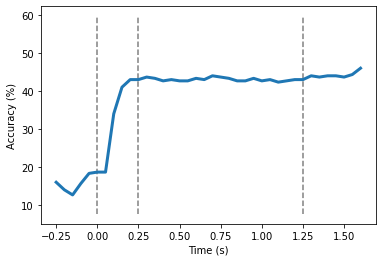

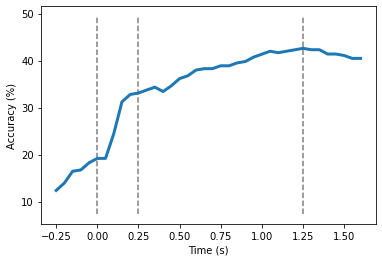

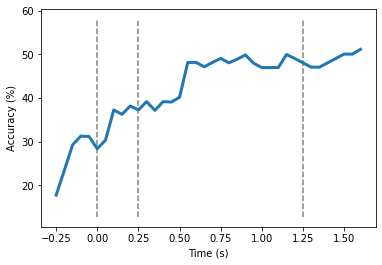

In [18]:
t = times[::5][:-1]
t[-1] = times[-1]
for i in [2, 3, 7]:
    plt.figure()
    plt.plot(t[:-3], rul_acc[i][:-3]*100, linewidth=3)
    plt.vlines(0, min(rul_acc[i]*100)-5, max(rul_acc[i]*100)+5, 'grey', 'dashed')
    plt.vlines(0.25, min(rul_acc[i]*100)-5, max(rul_acc[i]*100)+5, 'grey', 'dashed')
    plt.vlines(1.25, min(rul_acc[i]*100)-5, max(rul_acc[i]*100)+5, 'grey', 'dashed')
    plt.xlabel("Time (s)")
    plt.ylabel("Accuracy (%)")
    name = f'rule_decoding_temporal_sess{i}.svg'
    plt.savefig(name)

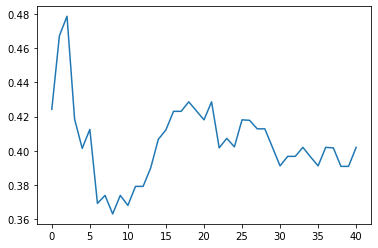

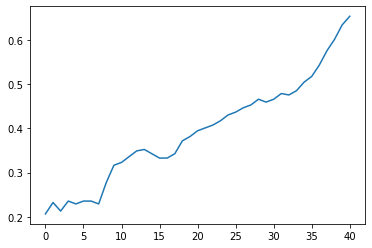

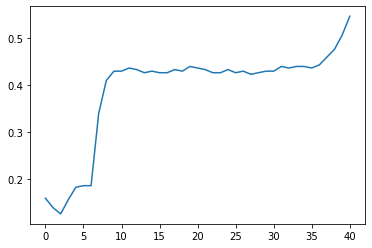

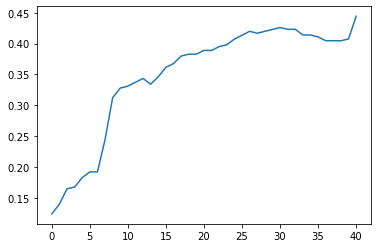

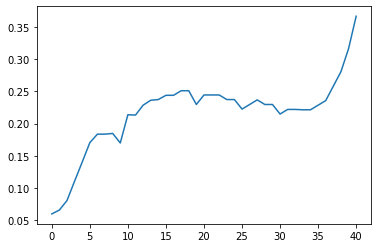

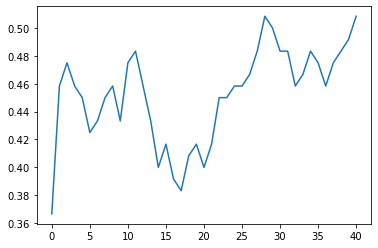

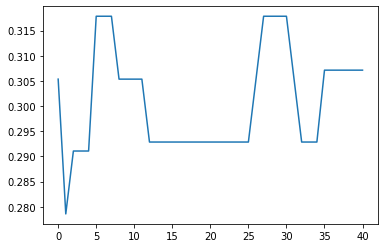

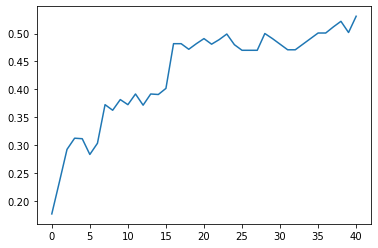

In [36]:
for i in range(8):
    plt.figure()
    plt.plot(rul_acc[i])

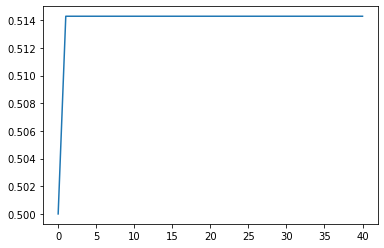

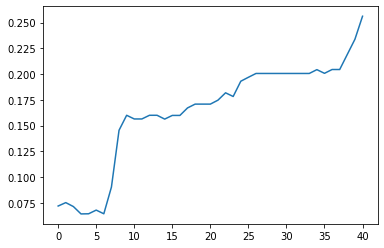

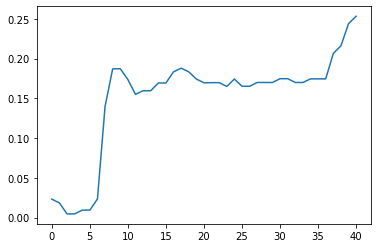

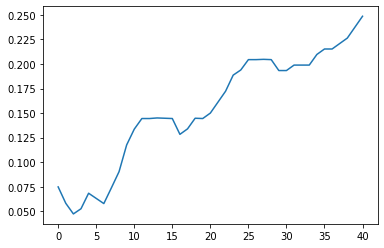

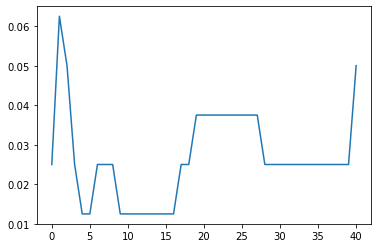

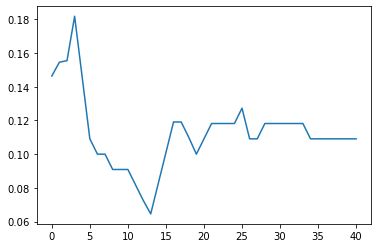

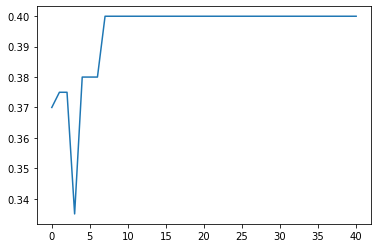

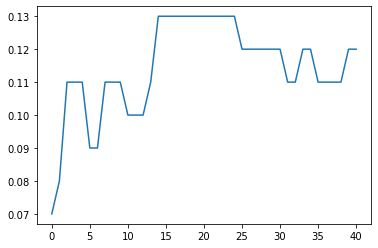

In [37]:
for i in range(8):
    plt.figure()
    plt.plot(rul_acc_ul[i])

# Target Decoding Temporal Analysis

In [5]:
N_SPLITS = 10
targ_acc = np.zeros((8, 41))
for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    sess_id = sess_id.replace("+", "")+"_v1"
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
    times = np.array(ax_info['timestamps'])
    for t in range(40):
        tmp = X_rates[:,:,:t*5 + 5]
        kf = KFold(n_splits=N_SPLITS)
        X = np.reshape(tmp, (tmp.shape[0], -1))
        scores = []
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = Y[train_index], Y[test_index]
            clf = SVC(verbose=False).fit(x_tr, y_tr)
            acc = clf.score(x_ts, y_ts)
            scores.append(acc)
        targ_acc[sess,t] = np.mean(np.array(scores))
        print (f'\nTarget Decoding before {times[t*5+5]}s for session {sess}: {np.mean(np.array(scores))}')
    kf = KFold(n_splits=N_SPLITS)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    scores = []
    for train_index, test_index in kf.split(X):
        x_tr, x_ts = X[train_index], X[test_index]
        y_tr, y_ts = Y[train_index], Y[test_index]
        clf = SVC(verbose=False).fit(x_tr, y_tr)
        acc = clf.score(x_ts, y_ts)
        scores.append(acc)
    targ_acc[sess,-1] = np.mean(np.array(scores))
    print (f'\nTarget Decoding before for session {sess}: {np.mean(np.array(scores))}\n\n')


Saccade Decoding before -0.2s for session 0: 0.49375

Saccade Decoding before -0.15s for session 0: 0.5375

Saccade Decoding before -0.1s for session 0: 0.54375

Saccade Decoding before -0.05s for session 0: 0.49375

Saccade Decoding before 0.0s for session 0: 0.50625

Saccade Decoding before 0.05s for session 0: 0.4875

Saccade Decoding before 0.1s for session 0: 0.5

Saccade Decoding before 0.15s for session 0: 0.49375

Saccade Decoding before 0.2s for session 0: 0.5

Saccade Decoding before 0.25s for session 0: 0.49375

Saccade Decoding before 0.30000000000000004s for session 0: 0.475

Saccade Decoding before 0.35000000000000003s for session 0: 0.475

Saccade Decoding before 0.4s for session 0: 0.4875

Saccade Decoding before 0.45s for session 0: 0.5125

Saccade Decoding before 0.5s for session 0: 0.475

Saccade Decoding before 0.55s for session 0: 0.4875

Saccade Decoding before 0.6000000000000001s for session 0: 0.45

Saccade Decoding before 0.65s for session 0: 0.45

Saccade Dec


Saccade Decoding before 0.2s for session 3: 0.3952380952380952

Saccade Decoding before 0.25s for session 3: 0.42394179894179895

Saccade Decoding before 0.30000000000000004s for session 3: 0.43465608465608474

Saccade Decoding before 0.35000000000000003s for session 3: 0.441931216931217

Saccade Decoding before 0.4s for session 3: 0.4420634920634921

Saccade Decoding before 0.45s for session 3: 0.44563492063492066

Saccade Decoding before 0.5s for session 3: 0.44933862433862437

Saccade Decoding before 0.55s for session 3: 0.4564814814814815

Saccade Decoding before 0.6000000000000001s for session 3: 0.4529100529100528

Saccade Decoding before 0.65s for session 3: 0.44933862433862426

Saccade Decoding before 0.7s for session 3: 0.4529100529100528

Saccade Decoding before 0.75s for session 3: 0.46005291005290994

Saccade Decoding before 0.8s for session 3: 0.47791005291005284

Saccade Decoding before 0.8500000000000001s for session 3: 0.4814814814814815

Saccade Decoding before 0.9000


Saccade Decoding before 0.2s for session 6: 0.2738095238095238

Saccade Decoding before 0.25s for session 6: 0.2738095238095238

Saccade Decoding before 0.30000000000000004s for session 6: 0.2738095238095238

Saccade Decoding before 0.35000000000000003s for session 6: 0.2761904761904762

Saccade Decoding before 0.4s for session 6: 0.2928571428571428

Saccade Decoding before 0.45s for session 6: 0.2928571428571428

Saccade Decoding before 0.5s for session 6: 0.2928571428571428

Saccade Decoding before 0.55s for session 6: 0.2928571428571428

Saccade Decoding before 0.6000000000000001s for session 6: 0.2928571428571428

Saccade Decoding before 0.65s for session 6: 0.2928571428571428

Saccade Decoding before 0.7s for session 6: 0.2928571428571428

Saccade Decoding before 0.75s for session 6: 0.2928571428571428

Saccade Decoding before 0.8s for session 6: 0.2928571428571428

Saccade Decoding before 0.8500000000000001s for session 6: 0.2928571428571428

Saccade Decoding before 0.9000000000

In [7]:
N_SPLITS = 10
targ_acc_shuf = np.zeros(41)
sess=2
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "")+"_v1"
X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
Y = Y.ravel()
Y_shuf = np.random.permutation(Y)
times = np.array(ax_info['timestamps'])
for t in range(40):
    tmp = X_rates[:,:,:t*5 + 5]
    kf = KFold(n_splits=N_SPLITS)
    X = np.reshape(tmp, (tmp.shape[0], -1))
    scores = []
    for train_index, test_index in kf.split(X):
        x_tr, x_ts = X[train_index], X[test_index]
        y_tr, y_ts = Y_shuf[train_index], Y_shuf[test_index]
        clf = SVC(verbose=False).fit(x_tr, y_tr)
        acc = clf.score(x_ts, y_ts)
        scores.append(acc)
    targ_acc_shuf[t] = np.mean(np.array(scores))
    print (f'\nTarget Decoding before {times[t*5+5]}s for session {sess}: {np.mean(np.array(scores))}')


Target Decoding before -0.2s for session 2: 0.2796296296296296

Target Decoding before -0.15s for session 2: 0.26069182389937107

Target Decoding before -0.1s for session 2: 0.2777428371767995

Target Decoding before -0.05s for session 2: 0.2907407407407408

Target Decoding before 0.0s for session 2: 0.27194269741439553

Target Decoding before 0.05s for session 2: 0.23619846261355698

Target Decoding before 0.1s for session 2: 0.23819007686932214

Target Decoding before 0.15s for session 2: 0.24199860237596088

Target Decoding before 0.2s for session 2: 0.2514325646401118

Target Decoding before 0.25s for session 2: 0.27784765897973446

Target Decoding before 0.30000000000000004s for session 2: 0.29654088050314464

Target Decoding before 0.35000000000000003s for session 2: 0.2870370370370371

Target Decoding before 0.4s for session 2: 0.28888888888888886

Target Decoding before 0.45s for session 2: 0.28700209643605873

Target Decoding before 0.5s for session 2: 0.30401816911250873

Ta

In [8]:
with open('targ_acc.pkl', 'wb') as f:
    pickle.dump(targ_acc, f)
with open('targ_acc_shuff.pkl', 'wb') as f:
    pickle.dump(targ_acc_shuf, f)

In [36]:
with open('targ_acc.pkl', 'rb') as f:
    targ_acc = pickle.load(f)
with open('targ_acc_shuff.pkl', 'rb') as f:
    targ_acc_shuf = pickle.load(f)

In [4]:
# sess=2
# sess_info = sess_infos[sess]
# sess_id = sess_info['exp_code']
# sess_id = sess_id.replace("+", "")+"_v1"
# X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
# Y_shuf = np.random.permutation(Y)
# times = np.array(ax_info['timestamps'])

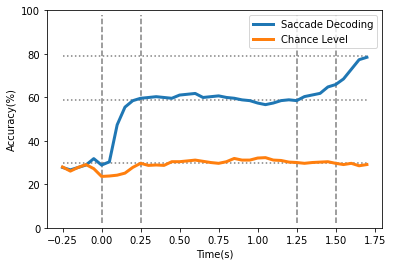

In [48]:
plt.figure()
t = times[::5][:-2]
plt.plot(t, targ_acc[2,:-1]*100, linewidth=3, label="Saccade Decoding")
plt.plot(t, targ_acc_shuf[:-1]*100, linewidth=3, label="Chance Level")
plt.vlines(0, 2,98, 'grey', 'dashed')
plt.vlines(0.25, 2,98, 'grey', 'dashed')
plt.vlines(1.25, 2,98, 'grey', 'dashed')
plt.vlines(1.5, 2,98, 'grey', 'dashed')
plt.hlines(30, min(t), max(t), 'grey', 'dotted')
plt.hlines(59, min(t), max(t), 'grey', 'dotted')
plt.hlines(79, min(t), max(t), 'grey', 'dotted')
# plt.hlines(56.5, min(t), max(t), 'grey', 'dotted')
plt.xlabel("Time(s)")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.ylim(0,100)
plt.savefig("Targ_Decoding_Temporal_sess2_2.svg")

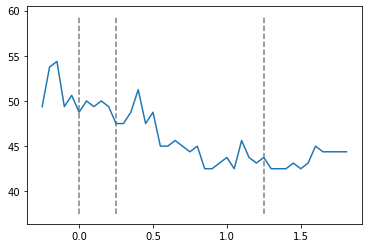

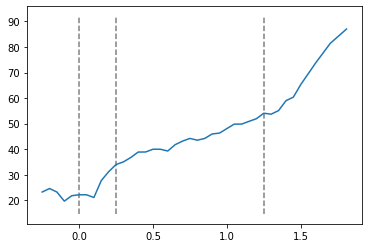

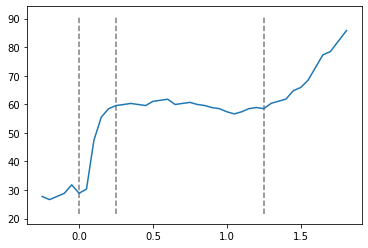

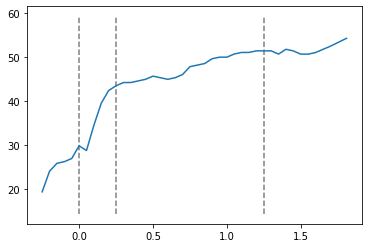

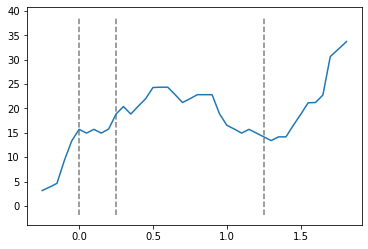

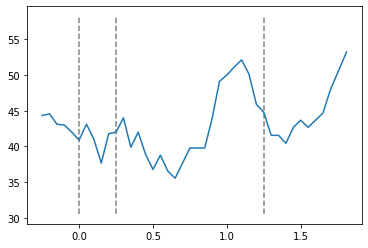

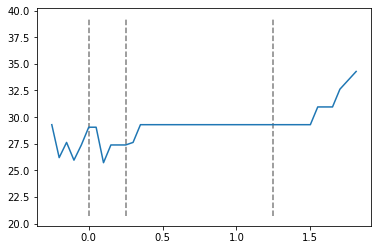

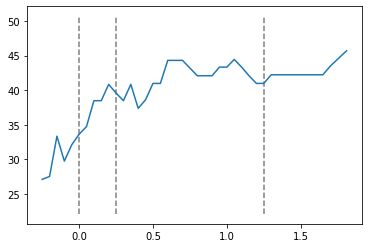

In [7]:
t = times[::5][:-1]
t[-1] = times[-1]
for i in range(8):
    plt.figure()
    plt.plot(t, targ_acc[i]*100)
    plt.vlines(0, min(targ_acc[i]*100)-5, max(targ_acc[i]*100)+5, 'grey', 'dashed')
    plt.vlines(0.25, min(targ_acc[i]*100)-5, max(targ_acc[i]*100)+5, 'grey', 'dashed')
    plt.vlines(1.25, min(targ_acc[i]*100)-5, max(targ_acc[i]*100)+5, 'grey', 'dashed')

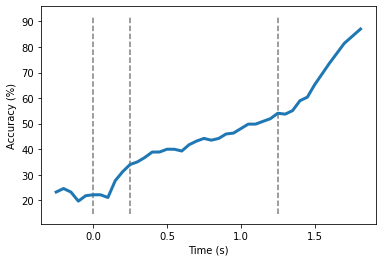

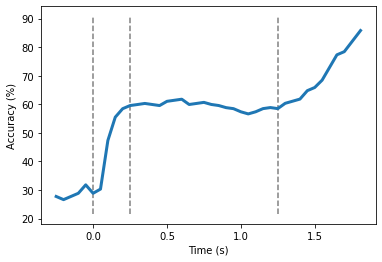

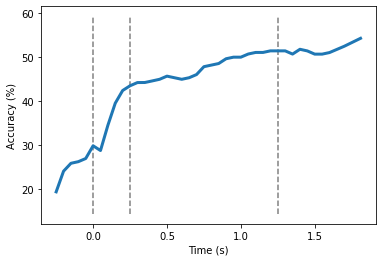

In [14]:
for i in [1, 2, 3]:
    plt.figure()
    plt.plot(t, targ_acc[i]*100, linewidth=3)
    plt.vlines(0, min(targ_acc[i]*100)-5, max(targ_acc[i]*100)+5, 'grey', 'dashed')
    plt.vlines(0.25, min(targ_acc[i]*100)-5, max(targ_acc[i]*100)+5, 'grey', 'dashed')
    plt.vlines(1.25, min(targ_acc[i]*100)-5, max(targ_acc[i]*100)+5, 'grey', 'dashed')
    plt.xlabel("Time (s)")
    plt.ylabel("Accuracy (%)")
    name = f'targ_decoding_temporal_sess{i}.svg'
    plt.savefig(name)

# Saccade Decoding Temporal Analysis

In [20]:
N_SPLITS = 10
sac_acc = np.zeros((8, 41))
for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    sess_id = sess_id.replace("+", "")+"_v1"
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
    times = np.array(ax_info['timestamps'])
    for t in range(40):
        tmp = X_rates[:,:,:t*5 + 5]
        kf = KFold(n_splits=N_SPLITS)
        X = np.reshape(tmp, (tmp.shape[0], -1))
        scores = []
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = Y[train_index], Y[test_index]
            clf = SVC(verbose=False).fit(x_tr, y_tr)
            acc = clf.score(x_ts, y_ts)
            scores.append(acc)
        sac_acc[sess,t] = np.mean(np.array(scores))
        print (f'\nSaccade Decoding before {times[t*5+5]}s for session {sess}: {np.mean(np.array(scores))}')
    kf = KFold(n_splits=N_SPLITS)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    scores = []
    for train_index, test_index in kf.split(X):
        x_tr, x_ts = X[train_index], X[test_index]
        y_tr, y_ts = Y[train_index], Y[test_index]
        clf = SVC(verbose=False).fit(x_tr, y_tr)
        acc = clf.score(x_ts, y_ts)
        scores.append(acc)
    sac_acc[sess,-1] = np.mean(np.array(scores))
    print (f'\nSaccade Decoding before for session {sess}: {np.mean(np.array(scores))}\n\n')


Saccade Decoding before -0.2s for session 0: 0.5298245614035088

Saccade Decoding before -0.15s for session 0: 0.5780701754385966

Saccade Decoding before -0.1s for session 0: 0.5289473684210526

Saccade Decoding before -0.05s for session 0: 0.5233918128654971

Saccade Decoding before 0.0s for session 0: 0.5181286549707602

Saccade Decoding before 0.05s for session 0: 0.5125730994152047

Saccade Decoding before 0.1s for session 0: 0.47485380116959064

Saccade Decoding before 0.15s for session 0: 0.47485380116959064

Saccade Decoding before 0.2s for session 0: 0.4856725146198831

Saccade Decoding before 0.25s for session 0: 0.5020467836257311

Saccade Decoding before 0.30000000000000004s for session 0: 0.5181286549707602

Saccade Decoding before 0.35000000000000003s for session 0: 0.4856725146198831

Saccade Decoding before 0.4s for session 0: 0.4912280701754386

Saccade Decoding before 0.45s for session 0: 0.5020467836257309

Saccade Decoding before 0.5s for session 0: 0.5073099415204


Saccade Decoding before -0.1s for session 3: 0.26458333333333334

Saccade Decoding before -0.05s for session 3: 0.2862689393939394

Saccade Decoding before 0.0s for session 3: 0.3080492424242424

Saccade Decoding before 0.05s for session 3: 0.32045454545454544

Saccade Decoding before 0.1s for session 3: 0.32064393939393937

Saccade Decoding before 0.15s for session 3: 0.3879734848484849

Saccade Decoding before 0.2s for session 3: 0.4096590909090909

Saccade Decoding before 0.25s for session 3: 0.4590909090909091

Saccade Decoding before 0.30000000000000004s for session 3: 0.46202651515151516

Saccade Decoding before 0.35000000000000003s for session 3: 0.46515151515151515

Saccade Decoding before 0.4s for session 3: 0.46827651515151514

Saccade Decoding before 0.45s for session 3: 0.4714015151515151

Saccade Decoding before 0.5s for session 3: 0.4837121212121212

Saccade Decoding before 0.55s for session 3: 0.4928030303030303

Saccade Decoding before 0.6000000000000001s for session 3


Saccade Decoding before 0.0s for session 6: 0.22321428571428573

Saccade Decoding before 0.05s for session 6: 0.25

Saccade Decoding before 0.1s for session 6: 0.2375

Saccade Decoding before 0.15s for session 6: 0.2357142857142857

Saccade Decoding before 0.2s for session 6: 0.2642857142857143

Saccade Decoding before 0.25s for session 6: 0.225

Saccade Decoding before 0.30000000000000004s for session 6: 0.225

Saccade Decoding before 0.35000000000000003s for session 6: 0.23928571428571427

Saccade Decoding before 0.4s for session 6: 0.2517857142857143

Saccade Decoding before 0.45s for session 6: 0.26607142857142857

Saccade Decoding before 0.5s for session 6: 0.26607142857142857

Saccade Decoding before 0.55s for session 6: 0.26607142857142857

Saccade Decoding before 0.6000000000000001s for session 6: 0.26607142857142857

Saccade Decoding before 0.65s for session 6: 0.26607142857142857

Saccade Decoding before 0.7s for session 6: 0.26607142857142857

Saccade Decoding before 0.75s 

In [21]:
with open('sac_acc.pkl', 'wb') as f:
    pickle.dump(sac_acc, f)

In [22]:
with open('sac_acc.pkl', 'rb') as f:
    sac_acc = pickle.load(f)

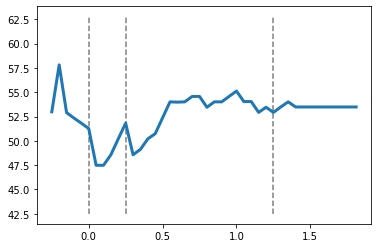

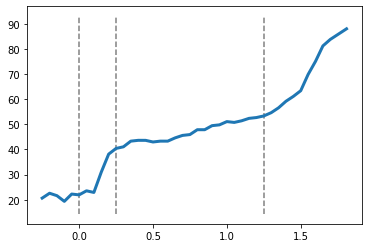

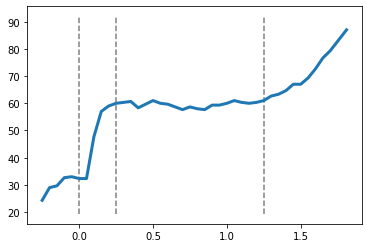

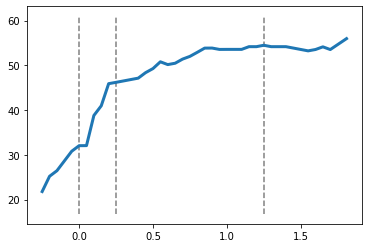

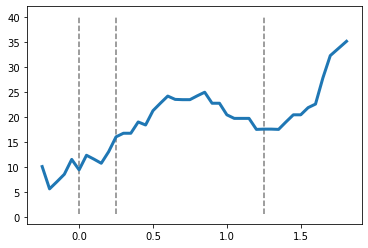

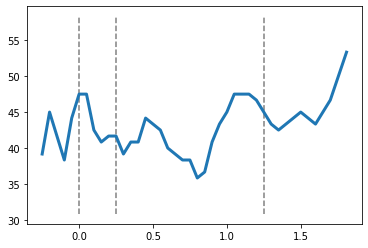

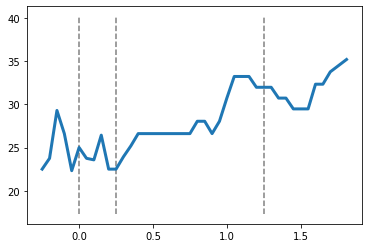

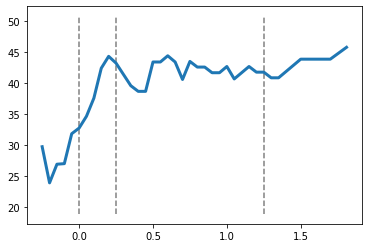

In [23]:
t = times[::5][:-1]
t[-1] = times[-1]
for i in range(8):
    plt.figure()
    plt.plot(t, sac_acc[i]*100, linewidth=3)
    plt.vlines(0, min(sac_acc[i]*100)-5, max(sac_acc[i]*100)+5, 'grey', 'dashed')
    plt.vlines(0.25, min(sac_acc[i]*100)-5, max(sac_acc[i]*100)+5, 'grey', 'dashed')
    plt.vlines(1.25, min(sac_acc[i]*100)-5, max(sac_acc[i]*100)+5, 'grey', 'dashed')

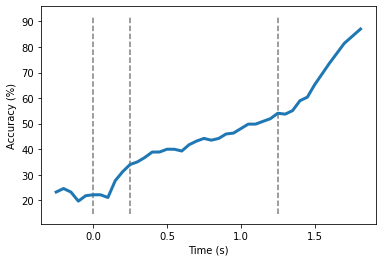

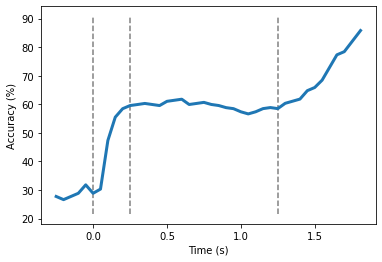

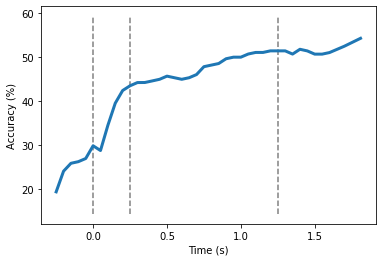

In [14]:
for i in [1, 2]:
    plt.figure()
    plt.plot(t, sac_acc[i]*100, linewidth=3)
    plt.vlines(0, min(sac_acc[i]*100)-5, max(sac_acc[i]*100)+5, 'grey', 'dashed')
    plt.vlines(0.25, min(sac_acc[i]*100)-5, max(sac_acc[i]*100)+5, 'grey', 'dashed')
    plt.vlines(1.25, min(sac_acc[i]*100)-5, max(sac_acc[i]*100)+5, 'grey', 'dashed')
    plt.xlabel("Time (s)")
    plt.ylabel("Accuracy (%)")
    name = f'sac_decoding_temporal_sess{i}.svg'
    plt.savefig(name)

# Saccade Decoding

In [48]:
test_sess_ix = 3
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
print(f"\nImporting session {sess_id}")
X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
Y = Y.ravel()
print(X_rates.shape, Y.shape)
print(np.unique(Y, return_counts=True))


Importing session sra3_1_j_052_00+
(698, 34, 276) (698,)
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 27, 127, 144,  67,  43, 113, 121,  56], dtype=int64))


In [49]:
hist, acc, y_pred, y_true = kfold_pred(sess_id,X_rates,Y,name='r2s', verbose=1)

	Split 1 of 10
Epoch 1/150
32/39 [=======================>......] - ETA: 0s - loss: 2.3118 - accuracy: 0.5859
Epoch 00001: val_accuracy improved from -inf to 0.75714, saving model to r2s_sra3_1_j_052_00+_split0.h5
39/39 [==============================] - 1s 14ms/step - loss: 2.2511 - accuracy: 0.6122 - val_loss: 2.0482 - val_accuracy: 0.7571
Epoch 2/150
36/39 [==========================>...] - ETA: 0s - loss: 1.7628 - accuracy: 0.8229
Epoch 00002: val_accuracy improved from 0.75714 to 0.82857, saving model to r2s_sra3_1_j_052_00+_split0.h5
39/39 [==============================] - 0s 6ms/step - loss: 1.7508 - accuracy: 0.8285 - val_loss: 1.7705 - val_accuracy: 0.8286
Epoch 3/150
35/39 [=========================>....] - ETA: 0s - loss: 1.5337 - accuracy: 0.8839
Epoch 00003: val_accuracy improved from 0.82857 to 0.87143, saving model to r2s_sra3_1_j_052_00+_split0.h5
39/39 [==============================] - 0s 6ms/step - loss: 1.5324 - accuracy: 0.8814 - val_loss: 1.5478 - val_accuracy: 0

35/39 [=========================>....] - ETA: 0s - loss: 0.8448 - accuracy: 0.9982
Epoch 00058: val_accuracy did not improve from 0.91429
39/39 [==============================] - 0s 5ms/step - loss: 0.8472 - accuracy: 0.9968 - val_loss: 1.1445 - val_accuracy: 0.8143
Epoch 59/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8498 - accuracy: 1.0000
Epoch 00059: val_accuracy did not improve from 0.91429
39/39 [==============================] - 0s 5ms/step - loss: 0.8491 - accuracy: 1.0000 - val_loss: 1.0779 - val_accuracy: 0.8857
Epoch 60/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8474 - accuracy: 0.9982
Epoch 00060: val_accuracy did not improve from 0.91429
39/39 [==============================] - 0s 5ms/step - loss: 0.8475 - accuracy: 0.9984 - val_loss: 1.0412 - val_accuracy: 0.9000
Epoch 61/150
36/39 [==========================>...] - ETA: 0s - loss: 0.8380 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.91429
39/39 [===============

38/39 [============================>.] - ETA: 0s - loss: 0.8272 - accuracy: 1.0000
Epoch 00116: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8276 - accuracy: 1.0000 - val_loss: 1.0696 - val_accuracy: 0.8714
Epoch 117/150
37/39 [===========================>..] - ETA: 0s - loss: 0.8275 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8274 - accuracy: 1.0000 - val_loss: 1.0531 - val_accuracy: 0.8429
Epoch 118/150
36/39 [==========================>...] - ETA: 0s - loss: 0.8318 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8317 - accuracy: 1.0000 - val_loss: 1.0597 - val_accuracy: 0.9000
Epoch 119/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8364 - accuracy: 0.9964
Epoch 00119: val_accuracy did not improve from 0.92857
39/39 [============

Epoch 24/150
37/39 [===========================>..] - ETA: 0s - loss: 0.8986 - accuracy: 0.9966
Epoch 00024: val_accuracy did not improve from 0.88571
39/39 [==============================] - 0s 5ms/step - loss: 0.8985 - accuracy: 0.9968 - val_loss: 1.1457 - val_accuracy: 0.8286
Epoch 25/150
36/39 [==========================>...] - ETA: 0s - loss: 0.8968 - accuracy: 0.9965
Epoch 00025: val_accuracy did not improve from 0.88571
39/39 [==============================] - 0s 5ms/step - loss: 0.8966 - accuracy: 0.9968 - val_loss: 1.1410 - val_accuracy: 0.8714
Epoch 26/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8933 - accuracy: 0.9946
Epoch 00026: val_accuracy did not improve from 0.88571
39/39 [==============================] - 0s 5ms/step - loss: 0.8938 - accuracy: 0.9952 - val_loss: 1.1825 - val_accuracy: 0.8143
Epoch 27/150
38/39 [============================>.] - ETA: 0s - loss: 0.8976 - accuracy: 0.9918
Epoch 00027: val_accuracy did not improve from 0.88571
39/39 [==

37/39 [===========================>..] - ETA: 0s - loss: 0.8466 - accuracy: 0.9966
Epoch 00082: val_accuracy did not improve from 0.88571
39/39 [==============================] - 0s 5ms/step - loss: 0.8465 - accuracy: 0.9968 - val_loss: 1.1520 - val_accuracy: 0.8143
Epoch 83/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8372 - accuracy: 0.9982
Epoch 00083: val_accuracy improved from 0.88571 to 0.90000, saving model to r2s_sra3_1_j_052_00+_split1.h5
39/39 [==============================] - 0s 6ms/step - loss: 0.8389 - accuracy: 0.9984 - val_loss: 1.0832 - val_accuracy: 0.9000
Epoch 84/150
26/39 [===================>..........] - ETA: 0s - loss: 0.8391 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.90000
39/39 [==============================] - 0s 5ms/step - loss: 0.8383 - accuracy: 1.0000 - val_loss: 1.1030 - val_accuracy: 0.8714
Epoch 85/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8386 - accuracy: 0.9982
Epoch 00085: val_accuracy

35/39 [=========================>....] - ETA: 0s - loss: 0.8240 - accuracy: 0.9982
Epoch 00140: val_accuracy did not improve from 0.90000
39/39 [==============================] - 0s 5ms/step - loss: 0.8265 - accuracy: 0.9984 - val_loss: 1.1611 - val_accuracy: 0.8429
Epoch 141/150
39/39 [==============================] - ETA: 0s - loss: 0.8271 - accuracy: 0.9984
Epoch 00141: val_accuracy did not improve from 0.90000
39/39 [==============================] - 0s 5ms/step - loss: 0.8271 - accuracy: 0.9984 - val_loss: 1.1581 - val_accuracy: 0.8286
Epoch 142/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8294 - accuracy: 0.9982
Epoch 00142: val_accuracy did not improve from 0.90000
39/39 [==============================] - 0s 5ms/step - loss: 0.8286 - accuracy: 0.9984 - val_loss: 1.1748 - val_accuracy: 0.8286
Epoch 143/150
38/39 [============================>.] - ETA: 0s - loss: 0.8374 - accuracy: 0.9984
Epoch 00143: val_accuracy did not improve from 0.90000
39/39 [============

33/39 [========================>.....] - ETA: 0s - loss: 0.8612 - accuracy: 0.9962
Epoch 00047: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8602 - accuracy: 0.9968 - val_loss: 1.0109 - val_accuracy: 0.9286
Epoch 48/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8604 - accuracy: 0.9946
Epoch 00048: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8599 - accuracy: 0.9936 - val_loss: 0.9857 - val_accuracy: 0.9286
Epoch 49/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8539 - accuracy: 1.0000
Epoch 00049: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8583 - accuracy: 0.9968 - val_loss: 1.0384 - val_accuracy: 0.9000
Epoch 50/150
32/39 [=======================>......] - ETA: 0s - loss: 0.8553 - accuracy: 0.9980
Epoch 00050: val_accuracy did not improve from 0.92857
39/39 [===============

34/39 [=========================>....] - ETA: 0s - loss: 0.8398 - accuracy: 0.9982
Epoch 00105: val_accuracy did not improve from 0.94286
39/39 [==============================] - 0s 5ms/step - loss: 0.8384 - accuracy: 0.9984 - val_loss: 0.9940 - val_accuracy: 0.9000
Epoch 106/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8339 - accuracy: 1.0000
Epoch 00106: val_accuracy did not improve from 0.94286
39/39 [==============================] - 0s 5ms/step - loss: 0.8328 - accuracy: 1.0000 - val_loss: 1.0004 - val_accuracy: 0.9143
Epoch 107/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8300 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.94286
39/39 [==============================] - 0s 5ms/step - loss: 0.8314 - accuracy: 1.0000 - val_loss: 0.9741 - val_accuracy: 0.9286
Epoch 108/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8348 - accuracy: 0.9963
Epoch 00108: val_accuracy did not improve from 0.94286
39/39 [============

34/39 [=========================>....] - ETA: 0s - loss: 0.9992 - accuracy: 0.9835
Epoch 00012: val_accuracy did not improve from 0.91429
39/39 [==============================] - 0s 5ms/step - loss: 0.9976 - accuracy: 0.9840 - val_loss: 1.2048 - val_accuracy: 0.8714
Epoch 13/150
36/39 [==========================>...] - ETA: 0s - loss: 0.9969 - accuracy: 0.9792
Epoch 00013: val_accuracy did not improve from 0.91429
39/39 [==============================] - 0s 5ms/step - loss: 0.9958 - accuracy: 0.9808 - val_loss: 1.1360 - val_accuracy: 0.9000
Epoch 14/150
36/39 [==========================>...] - ETA: 0s - loss: 0.9559 - accuracy: 0.9965
Epoch 00014: val_accuracy did not improve from 0.91429
39/39 [==============================] - 0s 5ms/step - loss: 0.9565 - accuracy: 0.9952 - val_loss: 1.1094 - val_accuracy: 0.8857
Epoch 15/150
34/39 [=========================>....] - ETA: 0s - loss: 0.9435 - accuracy: 0.9963
Epoch 00015: val_accuracy did not improve from 0.91429
39/39 [===============

36/39 [==========================>...] - ETA: 0s - loss: 0.8494 - accuracy: 0.9965
Epoch 00070: val_accuracy did not improve from 0.94286
39/39 [==============================] - 0s 5ms/step - loss: 0.8492 - accuracy: 0.9968 - val_loss: 1.0462 - val_accuracy: 0.8714
Epoch 71/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8399 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.94286
39/39 [==============================] - 0s 5ms/step - loss: 0.8398 - accuracy: 1.0000 - val_loss: 1.0318 - val_accuracy: 0.9286
Epoch 72/150
36/39 [==========================>...] - ETA: 0s - loss: 0.8416 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.94286
39/39 [==============================] - 0s 5ms/step - loss: 0.8412 - accuracy: 1.0000 - val_loss: 1.0165 - val_accuracy: 0.9143
Epoch 73/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8365 - accuracy: 1.0000
Epoch 00073: val_accuracy did not improve from 0.94286
39/39 [===============

34/39 [=========================>....] - ETA: 0s - loss: 0.8288 - accuracy: 1.0000
Epoch 00128: val_accuracy did not improve from 0.94286
39/39 [==============================] - 0s 5ms/step - loss: 0.8292 - accuracy: 1.0000 - val_loss: 1.0182 - val_accuracy: 0.9000
Epoch 129/150
25/39 [==================>...........] - ETA: 0s - loss: 0.8349 - accuracy: 0.9925
Epoch 00129: val_accuracy did not improve from 0.94286
39/39 [==============================] - 0s 5ms/step - loss: 0.8332 - accuracy: 0.9952 - val_loss: 1.0196 - val_accuracy: 0.9143
Epoch 130/150
36/39 [==========================>...] - ETA: 0s - loss: 0.8286 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.94286
39/39 [==============================] - 0s 5ms/step - loss: 0.8329 - accuracy: 0.9968 - val_loss: 1.0484 - val_accuracy: 0.9000
Epoch 131/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8335 - accuracy: 0.9982
Epoch 00131: val_accuracy did not improve from 0.94286
39/39 [============

Epoch 7/150
35/39 [=========================>....] - ETA: 0s - loss: 1.1520 - accuracy: 0.9571
Epoch 00007: val_accuracy improved from 0.94286 to 0.95714, saving model to r2s_sra3_1_j_052_00+_split4.h5
39/39 [==============================] - 0s 6ms/step - loss: 1.1483 - accuracy: 0.9599 - val_loss: 1.1669 - val_accuracy: 0.9571
Epoch 8/150
34/39 [=========================>....] - ETA: 0s - loss: 1.0912 - accuracy: 0.9779
Epoch 00008: val_accuracy did not improve from 0.95714
39/39 [==============================] - 0s 5ms/step - loss: 1.0937 - accuracy: 0.9744 - val_loss: 1.1512 - val_accuracy: 0.9429
Epoch 9/150
37/39 [===========================>..] - ETA: 0s - loss: 1.0929 - accuracy: 0.9578
Epoch 00009: val_accuracy did not improve from 0.95714
39/39 [==============================] - 0s 5ms/step - loss: 1.0903 - accuracy: 0.9599 - val_loss: 1.1231 - val_accuracy: 0.9143
Epoch 10/150
33/39 [========================>.....] - ETA: 0s - loss: 1.0484 - accuracy: 0.9792
Epoch 00010: va

Epoch 36/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8783 - accuracy: 0.9893
Epoch 00036: val_accuracy did not improve from 0.97143
39/39 [==============================] - 0s 5ms/step - loss: 0.8774 - accuracy: 0.9904 - val_loss: 0.9697 - val_accuracy: 0.9286
Epoch 37/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8759 - accuracy: 0.9893
Epoch 00037: val_accuracy did not improve from 0.97143
39/39 [==============================] - 0s 5ms/step - loss: 0.8745 - accuracy: 0.9904 - val_loss: 0.9543 - val_accuracy: 0.9571
Epoch 38/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8712 - accuracy: 0.9929
Epoch 00038: val_accuracy did not improve from 0.97143
39/39 [==============================] - 0s 5ms/step - loss: 0.8731 - accuracy: 0.9904 - val_loss: 0.9360 - val_accuracy: 0.9571
Epoch 39/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8673 - accuracy: 0.9893
Epoch 00039: val_accuracy did not improve from 0.97143
39/39 [==

35/39 [=========================>....] - ETA: 0s - loss: 0.8293 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.97143
39/39 [==============================] - 0s 5ms/step - loss: 0.8313 - accuracy: 1.0000 - val_loss: 1.0043 - val_accuracy: 0.9429
Epoch 95/150
36/39 [==========================>...] - ETA: 0s - loss: 0.8346 - accuracy: 0.9983
Epoch 00095: val_accuracy did not improve from 0.97143
39/39 [==============================] - 0s 5ms/step - loss: 0.8357 - accuracy: 0.9984 - val_loss: 0.9765 - val_accuracy: 0.9286
Epoch 96/150
36/39 [==========================>...] - ETA: 0s - loss: 0.8346 - accuracy: 0.9983
Epoch 00096: val_accuracy did not improve from 0.97143
39/39 [==============================] - 0s 5ms/step - loss: 0.8339 - accuracy: 0.9984 - val_loss: 0.9743 - val_accuracy: 0.9429
Epoch 97/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8381 - accuracy: 0.9964
Epoch 00097: val_accuracy did not improve from 0.97143
39/39 [===============

Epoch 2/150
34/39 [=========================>....] - ETA: 0s - loss: 1.8021 - accuracy: 0.8162
Epoch 00002: val_accuracy improved from 0.71429 to 0.75714, saving model to r2s_sra3_1_j_052_00+_split5.h5
39/39 [==============================] - 0s 6ms/step - loss: 1.7946 - accuracy: 0.8157 - val_loss: 1.8237 - val_accuracy: 0.7571
Epoch 3/150
38/39 [============================>.] - ETA: 0s - loss: 1.5590 - accuracy: 0.8569
Epoch 00003: val_accuracy improved from 0.75714 to 0.80000, saving model to r2s_sra3_1_j_052_00+_split5.h5
39/39 [==============================] - 0s 6ms/step - loss: 1.5592 - accuracy: 0.8542 - val_loss: 1.6157 - val_accuracy: 0.8000
Epoch 4/150
35/39 [=========================>....] - ETA: 0s - loss: 1.4187 - accuracy: 0.9107
Epoch 00004: val_accuracy did not improve from 0.80000
39/39 [==============================] - 0s 5ms/step - loss: 1.4108 - accuracy: 0.9103 - val_loss: 1.5193 - val_accuracy: 0.7714
Epoch 5/150
37/39 [===========================>..] - ETA: 0

Epoch 30/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8792 - accuracy: 0.9963
Epoch 00030: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8773 - accuracy: 0.9968 - val_loss: 1.0917 - val_accuracy: 0.9000
Epoch 31/150
38/39 [============================>.] - ETA: 0s - loss: 0.8946 - accuracy: 0.9918
Epoch 00031: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8952 - accuracy: 0.9920 - val_loss: 1.1054 - val_accuracy: 0.8571
Epoch 32/150
37/39 [===========================>..] - ETA: 0s - loss: 0.8807 - accuracy: 0.9932
Epoch 00032: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8799 - accuracy: 0.9936 - val_loss: 1.1190 - val_accuracy: 0.8571
Epoch 33/150
36/39 [==========================>...] - ETA: 0s - loss: 0.8968 - accuracy: 0.9896
Epoch 00033: val_accuracy did not improve from 0.92857
39/39 [==

33/39 [========================>.....] - ETA: 0s - loss: 0.8362 - accuracy: 1.0000
Epoch 00088: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8357 - accuracy: 1.0000 - val_loss: 1.0418 - val_accuracy: 0.9143
Epoch 89/150
39/39 [==============================] - ETA: 0s - loss: 0.8362 - accuracy: 0.9968
Epoch 00089: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8362 - accuracy: 0.9968 - val_loss: 1.0595 - val_accuracy: 0.8571
Epoch 90/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8392 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8379 - accuracy: 1.0000 - val_loss: 1.0220 - val_accuracy: 0.9143
Epoch 91/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8374 - accuracy: 0.9982
Epoch 00091: val_accuracy did not improve from 0.92857
39/39 [===============

36/39 [==========================>...] - ETA: 0s - loss: 0.8368 - accuracy: 0.9913
Epoch 00146: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8363 - accuracy: 0.9920 - val_loss: 1.0405 - val_accuracy: 0.8857
Epoch 147/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8320 - accuracy: 1.0000
Epoch 00147: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8315 - accuracy: 1.0000 - val_loss: 1.0677 - val_accuracy: 0.8714
Epoch 148/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8246 - accuracy: 1.0000
Epoch 00148: val_accuracy did not improve from 0.92857
39/39 [==============================] - 0s 5ms/step - loss: 0.8243 - accuracy: 1.0000 - val_loss: 1.0771 - val_accuracy: 0.8571
Epoch 149/150
36/39 [==========================>...] - ETA: 0s - loss: 0.8252 - accuracy: 1.0000
Epoch 00149: val_accuracy did not improve from 0.92857
39/39 [============

Epoch 24/150
34/39 [=========================>....] - ETA: 0s - loss: 0.9027 - accuracy: 0.9908
Epoch 00024: val_accuracy did not improve from 0.95714
39/39 [==============================] - 0s 5ms/step - loss: 0.9023 - accuracy: 0.9904 - val_loss: 1.0460 - val_accuracy: 0.8714
Epoch 25/150
34/39 [=========================>....] - ETA: 0s - loss: 0.9050 - accuracy: 0.9890
Epoch 00025: val_accuracy did not improve from 0.95714
39/39 [==============================] - 0s 5ms/step - loss: 0.9035 - accuracy: 0.9904 - val_loss: 0.9916 - val_accuracy: 0.9286
Epoch 26/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8831 - accuracy: 0.9982
Epoch 00026: val_accuracy did not improve from 0.95714
39/39 [==============================] - 0s 5ms/step - loss: 0.8824 - accuracy: 0.9984 - val_loss: 0.9859 - val_accuracy: 0.9429
Epoch 27/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8783 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.95714
39/39 [==

34/39 [=========================>....] - ETA: 0s - loss: 0.8404 - accuracy: 0.9982
Epoch 00082: val_accuracy did not improve from 0.95714
39/39 [==============================] - 0s 5ms/step - loss: 0.8393 - accuracy: 0.9984 - val_loss: 0.9950 - val_accuracy: 0.9000
Epoch 83/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8391 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.95714
39/39 [==============================] - 0s 5ms/step - loss: 0.8388 - accuracy: 1.0000 - val_loss: 1.0465 - val_accuracy: 0.9000
Epoch 84/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8398 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.95714
39/39 [==============================] - 0s 5ms/step - loss: 0.8399 - accuracy: 1.0000 - val_loss: 0.9482 - val_accuracy: 0.9000
Epoch 85/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8388 - accuracy: 0.9982
Epoch 00085: val_accuracy did not improve from 0.95714
39/39 [===============

33/39 [========================>.....] - ETA: 0s - loss: 0.8488 - accuracy: 0.9848
Epoch 00140: val_accuracy did not improve from 0.95714
39/39 [==============================] - 0s 5ms/step - loss: 0.8482 - accuracy: 0.9872 - val_loss: 1.0895 - val_accuracy: 0.8714
Epoch 141/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8558 - accuracy: 0.9871
Epoch 00141: val_accuracy did not improve from 0.95714
39/39 [==============================] - 0s 5ms/step - loss: 0.8532 - accuracy: 0.9888 - val_loss: 1.0857 - val_accuracy: 0.8714
Epoch 142/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8282 - accuracy: 1.0000
Epoch 00142: val_accuracy did not improve from 0.95714
39/39 [==============================] - 0s 5ms/step - loss: 0.8306 - accuracy: 0.9984 - val_loss: 1.0345 - val_accuracy: 0.9286
Epoch 143/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8255 - accuracy: 1.0000
Epoch 00143: val_accuracy did not improve from 0.95714
39/39 [============

34/39 [=========================>....] - ETA: 0s - loss: 0.8470 - accuracy: 1.0000
Epoch 00047: val_accuracy did not improve from 0.91429
39/39 [==============================] - 0s 5ms/step - loss: 0.8474 - accuracy: 1.0000 - val_loss: 1.1088 - val_accuracy: 0.8714
Epoch 48/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8564 - accuracy: 0.9945
Epoch 00048: val_accuracy did not improve from 0.91429
39/39 [==============================] - 0s 5ms/step - loss: 0.8567 - accuracy: 0.9952 - val_loss: 1.2711 - val_accuracy: 0.7857
Epoch 49/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8645 - accuracy: 0.9908
Epoch 00049: val_accuracy did not improve from 0.91429
39/39 [==============================] - 0s 5ms/step - loss: 0.8646 - accuracy: 0.9888 - val_loss: 1.1606 - val_accuracy: 0.8143
Epoch 50/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8618 - accuracy: 0.9926
Epoch 00050: val_accuracy did not improve from 0.91429
39/39 [===============

35/39 [=========================>....] - ETA: 0s - loss: 0.8271 - accuracy: 1.0000
Epoch 00105: val_accuracy did not improve from 0.91429
39/39 [==============================] - 0s 5ms/step - loss: 0.8273 - accuracy: 1.0000 - val_loss: 1.0909 - val_accuracy: 0.8429
Epoch 106/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8328 - accuracy: 0.9982
Epoch 00106: val_accuracy did not improve from 0.91429
39/39 [==============================] - 0s 5ms/step - loss: 0.8327 - accuracy: 0.9984 - val_loss: 1.1295 - val_accuracy: 0.8429
Epoch 107/150
33/39 [========================>.....] - ETA: 0s - loss: 0.8289 - accuracy: 1.0000
Epoch 00107: val_accuracy did not improve from 0.91429
39/39 [==============================] - 0s 5ms/step - loss: 0.8307 - accuracy: 1.0000 - val_loss: 1.1254 - val_accuracy: 0.8286
Epoch 108/150
35/39 [=========================>....] - ETA: 0s - loss: 0.8286 - accuracy: 0.9964
Epoch 00108: val_accuracy did not improve from 0.91429
39/39 [============

Epoch 12/150
37/39 [===========================>..] - ETA: 0s - loss: 1.0028 - accuracy: 0.9797
Epoch 00012: val_accuracy did not improve from 0.95652
39/39 [==============================] - 0s 5ms/step - loss: 1.0029 - accuracy: 0.9808 - val_loss: 1.1072 - val_accuracy: 0.9275
Epoch 13/150
34/39 [=========================>....] - ETA: 0s - loss: 0.9780 - accuracy: 0.9945
Epoch 00013: val_accuracy did not improve from 0.95652
39/39 [==============================] - 0s 5ms/step - loss: 0.9752 - accuracy: 0.9952 - val_loss: 1.0885 - val_accuracy: 0.9130
Epoch 14/150
37/39 [===========================>..] - ETA: 0s - loss: 0.9622 - accuracy: 0.9848
Epoch 00014: val_accuracy did not improve from 0.95652
39/39 [==============================] - 0s 5ms/step - loss: 0.9605 - accuracy: 0.9856 - val_loss: 1.0982 - val_accuracy: 0.9130
Epoch 15/150
34/39 [=========================>....] - ETA: 0s - loss: 0.9477 - accuracy: 0.9926
Epoch 00015: val_accuracy did not improve from 0.95652
39/39 [==

34/39 [=========================>....] - ETA: 0s - loss: 0.8514 - accuracy: 0.9963
Epoch 00070: val_accuracy did not improve from 0.95652
39/39 [==============================] - 0s 5ms/step - loss: 0.8503 - accuracy: 0.9968 - val_loss: 1.0170 - val_accuracy: 0.8841
Epoch 71/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8460 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.95652
39/39 [==============================] - 0s 5ms/step - loss: 0.8459 - accuracy: 0.9984 - val_loss: 1.0027 - val_accuracy: 0.9275
Epoch 72/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8508 - accuracy: 0.9963
Epoch 00072: val_accuracy did not improve from 0.95652
39/39 [==============================] - 0s 5ms/step - loss: 0.8530 - accuracy: 0.9952 - val_loss: 1.0222 - val_accuracy: 0.8986
Epoch 73/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8438 - accuracy: 1.0000
Epoch 00073: val_accuracy did not improve from 0.95652
39/39 [===============

33/39 [========================>.....] - ETA: 0s - loss: 0.8404 - accuracy: 0.9981
Epoch 00128: val_accuracy did not improve from 0.95652
39/39 [==============================] - 0s 5ms/step - loss: 0.8390 - accuracy: 0.9984 - val_loss: 1.0982 - val_accuracy: 0.8986
Epoch 129/150
38/39 [============================>.] - ETA: 0s - loss: 0.8422 - accuracy: 0.9934
Epoch 00129: val_accuracy did not improve from 0.95652
39/39 [==============================] - 0s 5ms/step - loss: 0.8417 - accuracy: 0.9936 - val_loss: 1.1160 - val_accuracy: 0.8551
Epoch 130/150
37/39 [===========================>..] - ETA: 0s - loss: 0.8435 - accuracy: 0.9916
Epoch 00130: val_accuracy did not improve from 0.95652
39/39 [==============================] - 0s 5ms/step - loss: 0.8498 - accuracy: 0.9888 - val_loss: 1.1475 - val_accuracy: 0.8406
Epoch 131/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8402 - accuracy: 0.9945
Epoch 00131: val_accuracy did not improve from 0.95652
39/39 [============

Epoch 7/150
34/39 [=========================>....] - ETA: 0s - loss: 1.1665 - accuracy: 0.9485
Epoch 00007: val_accuracy did not improve from 0.94203
39/39 [==============================] - 0s 5ms/step - loss: 1.1636 - accuracy: 0.9503 - val_loss: 1.2604 - val_accuracy: 0.8406
Epoch 8/150
34/39 [=========================>....] - ETA: 0s - loss: 1.1049 - accuracy: 0.9651
Epoch 00008: val_accuracy did not improve from 0.94203
39/39 [==============================] - 0s 5ms/step - loss: 1.1066 - accuracy: 0.9663 - val_loss: 1.1833 - val_accuracy: 0.8841
Epoch 9/150
34/39 [=========================>....] - ETA: 0s - loss: 1.0739 - accuracy: 0.9706
Epoch 00009: val_accuracy did not improve from 0.94203
39/39 [==============================] - 0s 5ms/step - loss: 1.0800 - accuracy: 0.9647 - val_loss: 1.1546 - val_accuracy: 0.9130
Epoch 10/150
34/39 [=========================>....] - ETA: 0s - loss: 1.0307 - accuracy: 0.9853
Epoch 00010: val_accuracy did not improve from 0.94203
39/39 [=====

34/39 [=========================>....] - ETA: 0s - loss: 0.8465 - accuracy: 0.9963
Epoch 00065: val_accuracy did not improve from 0.94203
39/39 [==============================] - 0s 5ms/step - loss: 0.8456 - accuracy: 0.9968 - val_loss: 0.9506 - val_accuracy: 0.9130
Epoch 66/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8481 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.94203
39/39 [==============================] - 0s 5ms/step - loss: 0.8462 - accuracy: 1.0000 - val_loss: 1.0014 - val_accuracy: 0.8696
Epoch 67/150
39/39 [==============================] - ETA: 0s - loss: 0.8429 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.94203
39/39 [==============================] - 0s 5ms/step - loss: 0.8429 - accuracy: 1.0000 - val_loss: 0.9754 - val_accuracy: 0.9275
Epoch 68/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8546 - accuracy: 0.9945
Epoch 00068: val_accuracy did not improve from 0.94203
39/39 [===============

34/39 [=========================>....] - ETA: 0s - loss: 0.8374 - accuracy: 0.9945
Epoch 00123: val_accuracy did not improve from 0.94203
39/39 [==============================] - 0s 5ms/step - loss: 0.8367 - accuracy: 0.9952 - val_loss: 1.0368 - val_accuracy: 0.8696
Epoch 124/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8474 - accuracy: 0.9908
Epoch 00124: val_accuracy did not improve from 0.94203
39/39 [==============================] - 0s 5ms/step - loss: 0.8452 - accuracy: 0.9920 - val_loss: 1.0073 - val_accuracy: 0.8841
Epoch 125/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8323 - accuracy: 1.0000
Epoch 00125: val_accuracy did not improve from 0.94203
39/39 [==============================] - 0s 5ms/step - loss: 0.8322 - accuracy: 1.0000 - val_loss: 0.9468 - val_accuracy: 0.9275
Epoch 126/150
34/39 [=========================>....] - ETA: 0s - loss: 0.8294 - accuracy: 1.0000
Epoch 00126: val_accuracy did not improve from 0.94203
39/39 [============

In [50]:
from tensorflow.keras.models import load_model
model = load_model("r2s_sra3_1_j_052_00+_split4.h5")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 34, 276)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 19, 32)            141344    
_________________________________________________________________
batch_normalization (BatchNo (None, 19, 32)            128       
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
rnn1 (LSTM)                  (None, 32)                8320      
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)               

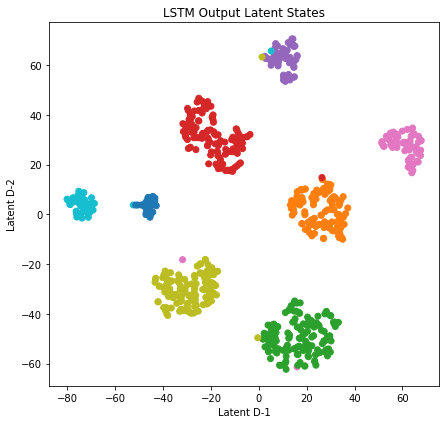

In [52]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create a colour code cycler e.g. 'C0', 'C1', etc.
# from itertools import cycle
# colour_codes = map('C{}'.format, cycle(range(24)))
# class_colors = np.array([next(colour_codes) for _ in range(24)])  # b, o, g, r
# class_colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])
class_colors = np.array(['tab:blue', 'tab:red', 'tab:green', 'tab:pink','tab:cyan','tab:orange',
                         'tab:olive','tab:purple','maroon', 'lime', 'navy', 'sienna', 'tan', 'black', 'grey'])

TEST_PERPLEXITY = [10]
X = X_rates
_y = Y.astype(int)

fig = plt.figure(figsize=(18, 6))
def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('Latent D-1')
    plt.ylabel('Latent D-2')
    plt.title(title)
    ax = plt.gca()

# First plot a t-SNE on the input data. Precede TSNE with a PCA.
pca = PCA(n_components=50)
pca_values = pca.fit_transform(X.reshape([-1, np.prod(X.shape[1:])]))
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY[-1])
tsne_values = tsne_model.fit_transform(pca_values)
# plt.subplot(1, 3, 1)
# plot_tsne(tsne_values, _y.ravel(), TEST_PERPLEXITY[-1], title='Input Firing Rates')

# Let's create a version of our CNN model that goes from input all the way to the 200-D flatten layer
output_layer = -5
tbs = 30  # tsne batch size
truncated_model = tf.keras.Model(model.input, model.layers[output_layer].output)
flattened_output = []
for start_ix in range(0, X.shape[0], tbs):
#     flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, MAX_OFFSET:, :].astype(np.float32)[:, :, :, None]))
    flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, :, :].astype(np.float32)))
flattened_output = tf.concat(flattened_output, 0)
tf.keras.backend.clear_session()

for p_ix, perplexity in enumerate(TEST_PERPLEXITY):
    # Initialize and fit our TSNE
    pca = PCA(n_components=30)
    pca_values = pca.fit_transform(flattened_output)
    tsne_model = TSNE(n_components=2, perplexity=perplexity)
    tsne_values = tsne_model.fit_transform(pca_values)
    
    plt.subplot(1, 3, p_ix + 2)
    plot_tsne(tsne_values, _y.ravel(), perplexity, title='LSTM Output Latent States')

plt.tight_layout()
plt.savefig("saccade_decode_latent.svg")